In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from postBornCrossSpectra import PostBorn_Bispec
import numpy as np
import Cosmology as C
import pickle
from scipy.integrate import simps
from scipy.interpolate import RectBivariateSpline
from classy import Class

import copy
import kernels
plt.style.use(['seaborn-colorblind','paper'])
plt.style.use('classic')

In [2]:
path = '/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/CrossPostBorn/data/class_postlimberdensity/inifiles3/'

In [42]:
step = 0.001
da = 0.01

def atoz(a):
    return 1/a-1

def ztoa(z):
    a = 1/(1+z)
    return a

a_min = 0.95
a_max = ztoa(5)

amins=[]
amaxs=[]

for a in np.arange(a_min, a_max, -da/2.):
    
    a1 = np.round(a, 3)
    a2 = np.round(a-da, 3)   
    
    amins+=[a1]
    amaxs+=[a2]
    
    aa = np.linspace(a1, a2, 11, endpoint=True)
    
    print(aa)
    
a_s = np.arange(a_min,a_max-da/2.-step*2,step=-step)
print(a_max-da/2.)
print(a_s)
print(amins)
print(amaxs)
zs = atoz(a_s)

[ 0.95   0.949  0.948  0.947  0.946  0.945  0.944  0.943  0.942  0.941
  0.94 ]
[ 0.945  0.944  0.943  0.942  0.941  0.94   0.939  0.938  0.937  0.936
  0.935]
[ 0.94   0.939  0.938  0.937  0.936  0.935  0.934  0.933  0.932  0.931
  0.93 ]
[ 0.935  0.934  0.933  0.932  0.931  0.93   0.929  0.928  0.927  0.926
  0.925]
[ 0.93   0.929  0.928  0.927  0.926  0.925  0.924  0.923  0.922  0.921
  0.92 ]
[ 0.925  0.924  0.923  0.922  0.921  0.92   0.919  0.918  0.917  0.916
  0.915]
[ 0.92   0.919  0.918  0.917  0.916  0.915  0.914  0.913  0.912  0.911
  0.91 ]
[ 0.915  0.914  0.913  0.912  0.911  0.91   0.909  0.908  0.907  0.906
  0.905]
[ 0.91   0.909  0.908  0.907  0.906  0.905  0.904  0.903  0.902  0.901  0.9  ]
[ 0.905  0.904  0.903  0.902  0.901  0.9    0.899  0.898  0.897  0.896
  0.895]
[ 0.9    0.899  0.898  0.897  0.896  0.895  0.894  0.893  0.892  0.891
  0.89 ]
[ 0.895  0.894  0.893  0.892  0.891  0.89   0.889  0.888  0.887  0.886
  0.885]
[ 0.89   0.889  0.888  0.887  0.886  0.88

In [43]:
indices = np.zeros((66,2))
count = 0
for ii in np.arange(11):
    for nn in np.arange(ii,11):
        indices[count]=[ii,nn]
        count+=1
print(indices)

[[  0.   0.]
 [  0.   1.]
 [  0.   2.]
 [  0.   3.]
 [  0.   4.]
 [  0.   5.]
 [  0.   6.]
 [  0.   7.]
 [  0.   8.]
 [  0.   9.]
 [  0.  10.]
 [  1.   1.]
 [  1.   2.]
 [  1.   3.]
 [  1.   4.]
 [  1.   5.]
 [  1.   6.]
 [  1.   7.]
 [  1.   8.]
 [  1.   9.]
 [  1.  10.]
 [  2.   2.]
 [  2.   3.]
 [  2.   4.]
 [  2.   5.]
 [  2.   6.]
 [  2.   7.]
 [  2.   8.]
 [  2.   9.]
 [  2.  10.]
 [  3.   3.]
 [  3.   4.]
 [  3.   5.]
 [  3.   6.]
 [  3.   7.]
 [  3.   8.]
 [  3.   9.]
 [  3.  10.]
 [  4.   4.]
 [  4.   5.]
 [  4.   6.]
 [  4.   7.]
 [  4.   8.]
 [  4.   9.]
 [  4.  10.]
 [  5.   5.]
 [  5.   6.]
 [  5.   7.]
 [  5.   8.]
 [  5.   9.]
 [  5.  10.]
 [  6.   6.]
 [  6.   7.]
 [  6.   8.]
 [  6.   9.]
 [  6.  10.]
 [  7.   7.]
 [  7.   8.]
 [  7.   9.]
 [  7.  10.]
 [  8.   8.]
 [  8.   9.]
 [  8.  10.]
 [  9.   9.]
 [  9.  10.]
 [ 10.  10.]]


In [44]:

filename = 'class_a%03da%03d_cl.dat'%(amins[0]*1000, amaxs[0]*1000)
corrs    = np.loadtxt(path+filename)
L        = corrs[:,0]
print(L)

[  2.00000000e+00   3.00000000e+00   4.00000000e+00 ...,   2.99800000e+03
   2.99900000e+03   3.00000000e+03]


In [45]:
def get_matrix_at_L(Lind):
    interp_matrix = np.zeros((len(a_s),len(a_s)))
    filenum = 0
    
    amin    = amins[filenum]
    amax    = amaxs[filenum]
    filename = 'class_a%03da%03d_cl.dat'%(amin*1000, amax*1000)
    corrs    = np.loadtxt(path+filename)
    corrs    = corrs[:,1::]
    for ii in range(0,len(zs)):
        for jj in range(ii,ii+6): #track correlation only for delta z = 0.5
            if jj < len(zs):
                a1 = a_s[ii]
                a2 = a_s[jj]
                print('%.3f, %.3f, %.3f, %.3f'%(a1,a2,amin,amax))
                if a2>=amax-step/2.:
                    print(a2,amin+step/2.)
                    print(filenum)
                    
                    ind1 = int((amin-a1)/step)
                    ind2 = int((amin-a2)/step)

                    index = np.all(np.equal(indices,[ind1,ind2]),axis=1)
                    print(ind1,ind2,np.where(index))
                    val = corrs[Lind,index]
                    print(Lind)
                else:
                    filenum+=1
                    print(filenum)

                    amin = amins[filenum]
                    amax = amaxs[filenum]
                    #print('%.3f, %.3f, %.3f, %.3f'%(a1,a2,amin,amax))
                    filename = 'class_a%03da%03d_cl.dat'%(amin*1000, amax*1000)
                    corrs    = np.loadtxt(path+filename)
                    corrs    = corrs[:,1::]
                    ind1 = int((amin-a1)/step)
                    ind2 = int((amin-a2)/step)
                    index = np.all(np.equal(indices,[ind1,ind2]),axis=1)
                    val = corrs[Lind,index]
                    print(Lind)
                    print(ind1,ind2,np.where(index))
                interp_matrix[ii,jj] = val

                interp_matrix[jj,ii] = interp_matrix[ii,jj] #hopefully creates only a pointer :)
    return interp_matrix


interp_matrix100  = get_matrix_at_L(100-2)
interp_matrix1000 = get_matrix_at_L(1000-2)
interp_matrix10   = get_matrix_at_L(10-2)
interp_matrix2   = get_matrix_at_L(0)


0.950, 0.950, 0.950, 0.940
(0.94999999999999996, 0.9504999999999999)
0
(0, 0, (array([0]),))
98
0.950, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(0, 1, (array([1]),))
98
0.950, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(0, 2, (array([2]),))
98
0.950, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(0, 3, (array([3]),))
98
0.950, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(0, 4, (array([4]),))
98
0.950, 0.945, 0.950, 0.940
(0.94499999999999995, 0.9504999999999999)
0
(0, 5, (array([5]),))
98
0.949, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(1, 1, (array([11]),))
98
0.949, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(1, 2, (array([12]),))
98
0.949, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(1, 3, (array([13]),))
98
0.949, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(1, 4, (array([14]),))
98
0.949, 0.945, 0.950, 0.940
(0.944999

98
(1, 6, (array([16]),))
0.928, 0.928, 0.930, 0.920
(0.92799999999999994, 0.93049999999999999)
4
(2, 2, (array([21]),))
98
0.928, 0.927, 0.930, 0.920
(0.92699999999999994, 0.93049999999999999)
4
(2, 3, (array([22]),))
98
0.928, 0.926, 0.930, 0.920
(0.92599999999999993, 0.93049999999999999)
4
(2, 4, (array([23]),))
98
0.928, 0.925, 0.930, 0.920
(0.92499999999999993, 0.93049999999999999)
4
(2, 5, (array([24]),))
98
0.928, 0.924, 0.930, 0.920
(0.92399999999999993, 0.93049999999999999)
4
(2, 6, (array([25]),))
98
0.928, 0.923, 0.930, 0.920
(0.92299999999999993, 0.93049999999999999)
4
(2, 7, (array([26]),))
98
0.927, 0.927, 0.930, 0.920
(0.92699999999999994, 0.93049999999999999)
4
(3, 3, (array([30]),))
98
0.927, 0.926, 0.930, 0.920
(0.92599999999999993, 0.93049999999999999)
4
(3, 4, (array([31]),))
98
0.927, 0.925, 0.930, 0.920
(0.92499999999999993, 0.93049999999999999)
4
(3, 5, (array([32]),))
98
0.927, 0.924, 0.930, 0.920
(0.92399999999999993, 0.93049999999999999)
4
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.908, 0.908, 0.910, 0.900
(0.90799999999999992, 0.91049999999999998)
8
(2, 2, (array([21]),))
98
0.908, 0.907, 0.910, 0.900
(0.90699999999999992, 0.91049999999999998)
8
(2, 3, (array([22]),))
98
0.908, 0.906, 0.910, 0.900
(0.90599999999999992, 0.91049999999999998)
8
(2, 4, (array([23]),))
98
0.908, 0.905, 0.910, 0.900
(0.90499999999999992, 0.91049999999999998)
8
(2, 5, (array([24]),))
98
0.908, 0.904, 0.910, 0.900
(0.90399999999999991, 0.91049999999999998)
8
(2, 6, (array([25]),))
98
0.908, 0.903, 0.910, 0.900
(0.90299999999999991, 0.91049999999999998)
8
(2, 7, (array([26]),))
98
0.907, 0.907, 0.910, 0.900
(0.90699999999999992, 0.91049999999999998)
8
(3, 3, (array([30]),))
98
0.907, 0.906, 0.910, 0.900
(0.90599999999999992, 0.91049999999999998)
8
(3, 4, (array([31]),))
98
0.907, 0.905, 0.910, 0.900
(0.90499999999999992, 0.91049999999999998)
8
(3, 5, (array([32]),))
98
0.907, 0.904, 0.910, 0.900
(0.90399999999999991, 0.91049999999999998)
8
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.888, 0.888, 0.890, 0.880
(0.8879999999999999, 0.89049999999999996)
12
(2, 2, (array([21]),))
98
0.888, 0.887, 0.890, 0.880
(0.8869999999999999, 0.89049999999999996)
12
(2, 3, (array([22]),))
98
0.888, 0.886, 0.890, 0.880
(0.8859999999999999, 0.89049999999999996)
12
(2, 4, (array([23]),))
98
0.888, 0.885, 0.890, 0.880
(0.8849999999999999, 0.89049999999999996)
12
(2, 5, (array([24]),))
98
0.888, 0.884, 0.890, 0.880
(0.8839999999999999, 0.89049999999999996)
12
(2, 6, (array([25]),))
98
0.888, 0.883, 0.890, 0.880
(0.8829999999999999, 0.89049999999999996)
12
(2, 7, (array([26]),))
98
0.887, 0.887, 0.890, 0.880
(0.8869999999999999, 0.89049999999999996)
12
(3, 3, (array([30]),))
98
0.887, 0.886, 0.890, 0.880
(0.8859999999999999, 0.89049999999999996)
12
(3, 4, (array([31]),))
98
0.887, 0.885, 0.890, 0.880
(0.8849999999999999, 0.89049999999999996)
12
(3, 5, (array([32]),))
98
0.887, 0.884, 0.890, 0.880
(0.8839999999999999, 0.89049999999999996)
12
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.868, 0.868, 0.870, 0.860
(0.86799999999999988, 0.87049999999999994)
16
(2, 2, (array([21]),))
98
0.868, 0.867, 0.870, 0.860
(0.86699999999999988, 0.87049999999999994)
16
(2, 3, (array([22]),))
98
0.868, 0.866, 0.870, 0.860
(0.86599999999999988, 0.87049999999999994)
16
(2, 4, (array([23]),))
98
0.868, 0.865, 0.870, 0.860
(0.86499999999999988, 0.87049999999999994)
16
(2, 5, (array([24]),))
98
0.868, 0.864, 0.870, 0.860
(0.86399999999999988, 0.87049999999999994)
16
(2, 6, (array([25]),))
98
0.868, 0.863, 0.870, 0.860
(0.86299999999999988, 0.87049999999999994)
16
(2, 7, (array([26]),))
98
0.867, 0.867, 0.870, 0.860
(0.86699999999999988, 0.87049999999999994)
16
(3, 3, (array([30]),))
98
0.867, 0.866, 0.870, 0.860
(0.86599999999999988, 0.87049999999999994)
16
(3, 4, (array([31]),))
98
0.867, 0.865, 0.870, 0.860
(0.86499999999999988, 0.87049999999999994)
16
(3, 5, (array([32]),))
98
0.867, 0.864, 0.870, 0.860
(0.86399999999999988, 0.87049999999999994)
16
(3, 6, (ar

98
(1, 6, (array([16]),))
0.848, 0.848, 0.850, 0.840
(0.84799999999999986, 0.85049999999999992)
20
(2, 2, (array([21]),))
98
0.848, 0.847, 0.850, 0.840
(0.84699999999999986, 0.85049999999999992)
20
(2, 3, (array([22]),))
98
0.848, 0.846, 0.850, 0.840
(0.84599999999999986, 0.85049999999999992)
20
(2, 4, (array([23]),))
98
0.848, 0.845, 0.850, 0.840
(0.84499999999999986, 0.85049999999999992)
20
(2, 5, (array([24]),))
98
0.848, 0.844, 0.850, 0.840
(0.84399999999999986, 0.85049999999999992)
20
(2, 6, (array([25]),))
98
0.848, 0.843, 0.850, 0.840
(0.84299999999999986, 0.85049999999999992)
20
(2, 7, (array([26]),))
98
0.847, 0.847, 0.850, 0.840
(0.84699999999999986, 0.85049999999999992)
20
(3, 3, (array([30]),))
98
0.847, 0.846, 0.850, 0.840
(0.84599999999999986, 0.85049999999999992)
20
(3, 4, (array([31]),))
98
0.847, 0.845, 0.850, 0.840
(0.84499999999999986, 0.85049999999999992)
20
(3, 5, (array([32]),))
98
0.847, 0.844, 0.850, 0.840
(0.84399999999999986, 0.85049999999999992)
20
(3, 6, (ar

98
(1, 6, (array([16]),))
0.828, 0.828, 0.830, 0.820
(0.82799999999999985, 0.8304999999999999)
24
(2, 2, (array([21]),))
98
0.828, 0.827, 0.830, 0.820
(0.82699999999999985, 0.8304999999999999)
24
(2, 3, (array([22]),))
98
0.828, 0.826, 0.830, 0.820
(0.82599999999999985, 0.8304999999999999)
24
(2, 4, (array([23]),))
98
0.828, 0.825, 0.830, 0.820
(0.82499999999999984, 0.8304999999999999)
24
(2, 5, (array([24]),))
98
0.828, 0.824, 0.830, 0.820
(0.82399999999999984, 0.8304999999999999)
24
(2, 6, (array([25]),))
98
0.828, 0.823, 0.830, 0.820
(0.82299999999999984, 0.8304999999999999)
24
(2, 7, (array([26]),))
98
0.827, 0.827, 0.830, 0.820
(0.82699999999999985, 0.8304999999999999)
24
(3, 3, (array([30]),))
98
0.827, 0.826, 0.830, 0.820
(0.82599999999999985, 0.8304999999999999)
24
(3, 4, (array([31]),))
98
0.827, 0.825, 0.830, 0.820
(0.82499999999999984, 0.8304999999999999)
24
(3, 5, (array([32]),))
98
0.827, 0.824, 0.830, 0.820
(0.82399999999999984, 0.8304999999999999)
24
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.808, 0.808, 0.810, 0.800
(0.80799999999999983, 0.8105)
28
(2, 2, (array([21]),))
98
0.808, 0.807, 0.810, 0.800
(0.80699999999999983, 0.8105)
28
(2, 3, (array([22]),))
98
0.808, 0.806, 0.810, 0.800
(0.80599999999999983, 0.8105)
28
(2, 4, (array([23]),))
98
0.808, 0.805, 0.810, 0.800
(0.80499999999999983, 0.8105)
28
(2, 5, (array([24]),))
98
0.808, 0.804, 0.810, 0.800
(0.80399999999999983, 0.8105)
28
(2, 6, (array([25]),))
98
0.808, 0.803, 0.810, 0.800
(0.80299999999999983, 0.8105)
28
(2, 7, (array([26]),))
98
0.807, 0.807, 0.810, 0.800
(0.80699999999999983, 0.8105)
28
(3, 3, (array([30]),))
98
0.807, 0.806, 0.810, 0.800
(0.80599999999999983, 0.8105)
28
(3, 4, (array([31]),))
98
0.807, 0.805, 0.810, 0.800
(0.80499999999999983, 0.8105)
28
(3, 5, (array([32]),))
98
0.807, 0.804, 0.810, 0.800
(0.80399999999999983, 0.8105)
28
(3, 6, (array([33]),))
98
0.807, 0.803, 0.810, 0.800
(0.80299999999999983, 0.8105)
28
(3, 7, (array([34]),))
98
0.807, 0.802, 0.810, 0.800
(

98
(1, 6, (array([16]),))
0.788, 0.788, 0.790, 0.780
(0.78799999999999981, 0.79049999999999998)
32
(2, 2, (array([21]),))
98
0.788, 0.787, 0.790, 0.780
(0.78699999999999981, 0.79049999999999998)
32
(2, 3, (array([22]),))
98
0.788, 0.786, 0.790, 0.780
(0.78599999999999981, 0.79049999999999998)
32
(2, 4, (array([23]),))
98
0.788, 0.785, 0.790, 0.780
(0.78499999999999981, 0.79049999999999998)
32
(2, 5, (array([24]),))
98
0.788, 0.784, 0.790, 0.780
(0.78399999999999981, 0.79049999999999998)
32
(2, 6, (array([25]),))
98
0.788, 0.783, 0.790, 0.780
(0.78299999999999981, 0.79049999999999998)
32
(2, 7, (array([26]),))
98
0.787, 0.787, 0.790, 0.780
(0.78699999999999981, 0.79049999999999998)
32
(3, 3, (array([30]),))
98
0.787, 0.786, 0.790, 0.780
(0.78599999999999981, 0.79049999999999998)
32
(3, 4, (array([31]),))
98
0.787, 0.785, 0.790, 0.780
(0.78499999999999981, 0.79049999999999998)
32
(3, 5, (array([32]),))
98
0.787, 0.784, 0.790, 0.780
(0.78399999999999981, 0.79049999999999998)
32
(3, 6, (ar

98
(1, 6, (array([16]),))
0.768, 0.768, 0.770, 0.760
(0.76799999999999979, 0.77049999999999996)
36
(2, 2, (array([21]),))
98
0.768, 0.767, 0.770, 0.760
(0.76699999999999979, 0.77049999999999996)
36
(2, 3, (array([22]),))
98
0.768, 0.766, 0.770, 0.760
(0.76599999999999979, 0.77049999999999996)
36
(2, 4, (array([23]),))
98
0.768, 0.765, 0.770, 0.760
(0.76499999999999979, 0.77049999999999996)
36
(2, 5, (array([24]),))
98
0.768, 0.764, 0.770, 0.760
(0.76399999999999979, 0.77049999999999996)
36
(2, 6, (array([25]),))
98
0.768, 0.763, 0.770, 0.760
(0.76299999999999979, 0.77049999999999996)
36
(2, 7, (array([26]),))
98
0.767, 0.767, 0.770, 0.760
(0.76699999999999979, 0.77049999999999996)
36
(3, 3, (array([30]),))
98
0.767, 0.766, 0.770, 0.760
(0.76599999999999979, 0.77049999999999996)
36
(3, 4, (array([31]),))
98
0.767, 0.765, 0.770, 0.760
(0.76499999999999979, 0.77049999999999996)
36
(3, 5, (array([32]),))
98
0.767, 0.764, 0.770, 0.760
(0.76399999999999979, 0.77049999999999996)
36
(3, 6, (ar

98
(1, 6, (array([16]),))
0.748, 0.748, 0.750, 0.740
(0.74799999999999978, 0.75049999999999994)
40
(2, 2, (array([21]),))
98
0.748, 0.747, 0.750, 0.740
(0.74699999999999978, 0.75049999999999994)
40
(2, 3, (array([22]),))
98
0.748, 0.746, 0.750, 0.740
(0.74599999999999977, 0.75049999999999994)
40
(2, 4, (array([23]),))
98
0.748, 0.745, 0.750, 0.740
(0.74499999999999977, 0.75049999999999994)
40
(2, 5, (array([24]),))
98
0.748, 0.744, 0.750, 0.740
(0.74399999999999977, 0.75049999999999994)
40
(2, 6, (array([25]),))
98
0.748, 0.743, 0.750, 0.740
(0.74299999999999977, 0.75049999999999994)
40
(2, 7, (array([26]),))
98
0.747, 0.747, 0.750, 0.740
(0.74699999999999978, 0.75049999999999994)
40
(3, 3, (array([30]),))
98
0.747, 0.746, 0.750, 0.740
(0.74599999999999977, 0.75049999999999994)
40
(3, 4, (array([31]),))
98
0.747, 0.745, 0.750, 0.740
(0.74499999999999977, 0.75049999999999994)
40
(3, 5, (array([32]),))
98
0.747, 0.744, 0.750, 0.740
(0.74399999999999977, 0.75049999999999994)
40
(3, 6, (ar

98
(1, 6, (array([16]),))
0.728, 0.728, 0.730, 0.720
(0.72799999999999976, 0.73049999999999993)
44
(2, 2, (array([21]),))
98
0.728, 0.727, 0.730, 0.720
(0.72699999999999976, 0.73049999999999993)
44
(2, 3, (array([22]),))
98
0.728, 0.726, 0.730, 0.720
(0.72599999999999976, 0.73049999999999993)
44
(2, 4, (array([23]),))
98
0.728, 0.725, 0.730, 0.720
(0.72499999999999976, 0.73049999999999993)
44
(2, 5, (array([24]),))
98
0.728, 0.724, 0.730, 0.720
(0.72399999999999975, 0.73049999999999993)
44
(2, 6, (array([25]),))
98
0.728, 0.723, 0.730, 0.720
(0.72299999999999975, 0.73049999999999993)
44
(2, 7, (array([26]),))
98
0.727, 0.727, 0.730, 0.720
(0.72699999999999976, 0.73049999999999993)
44
(3, 3, (array([30]),))
98
0.727, 0.726, 0.730, 0.720
(0.72599999999999976, 0.73049999999999993)
44
(3, 4, (array([31]),))
98
0.727, 0.725, 0.730, 0.720
(0.72499999999999976, 0.73049999999999993)
44
(3, 5, (array([32]),))
98
0.727, 0.724, 0.730, 0.720
(0.72399999999999975, 0.73049999999999993)
44
(3, 6, (ar

98
(1, 6, (array([16]),))
0.708, 0.708, 0.710, 0.700
(0.70799999999999974, 0.71049999999999991)
48
(2, 2, (array([21]),))
98
0.708, 0.707, 0.710, 0.700
(0.70699999999999974, 0.71049999999999991)
48
(2, 3, (array([22]),))
98
0.708, 0.706, 0.710, 0.700
(0.70599999999999974, 0.71049999999999991)
48
(2, 4, (array([23]),))
98
0.708, 0.705, 0.710, 0.700
(0.70499999999999974, 0.71049999999999991)
48
(2, 5, (array([24]),))
98
0.708, 0.704, 0.710, 0.700
(0.70399999999999974, 0.71049999999999991)
48
(2, 6, (array([25]),))
98
0.708, 0.703, 0.710, 0.700
(0.70299999999999974, 0.71049999999999991)
48
(2, 7, (array([26]),))
98
0.707, 0.707, 0.710, 0.700
(0.70699999999999974, 0.71049999999999991)
48
(3, 3, (array([30]),))
98
0.707, 0.706, 0.710, 0.700
(0.70599999999999974, 0.71049999999999991)
48
(3, 4, (array([31]),))
98
0.707, 0.705, 0.710, 0.700
(0.70499999999999974, 0.71049999999999991)
48
(3, 5, (array([32]),))
98
0.707, 0.704, 0.710, 0.700
(0.70399999999999974, 0.71049999999999991)
48
(3, 6, (ar

98
(1, 6, (array([16]),))
0.688, 0.688, 0.690, 0.680
(0.68799999999999972, 0.69049999999999989)
52
(2, 2, (array([21]),))
98
0.688, 0.687, 0.690, 0.680
(0.68699999999999972, 0.69049999999999989)
52
(2, 3, (array([22]),))
98
0.688, 0.686, 0.690, 0.680
(0.68599999999999972, 0.69049999999999989)
52
(2, 4, (array([23]),))
98
0.688, 0.685, 0.690, 0.680
(0.68499999999999972, 0.69049999999999989)
52
(2, 5, (array([24]),))
98
0.688, 0.684, 0.690, 0.680
(0.68399999999999972, 0.69049999999999989)
52
(2, 6, (array([25]),))
98
0.688, 0.683, 0.690, 0.680
(0.68299999999999972, 0.69049999999999989)
52
(2, 7, (array([26]),))
98
0.687, 0.687, 0.690, 0.680
(0.68699999999999972, 0.69049999999999989)
52
(3, 3, (array([30]),))
98
0.687, 0.686, 0.690, 0.680
(0.68599999999999972, 0.69049999999999989)
52
(3, 4, (array([31]),))
98
0.687, 0.685, 0.690, 0.680
(0.68499999999999972, 0.69049999999999989)
52
(3, 5, (array([32]),))
98
0.687, 0.684, 0.690, 0.680
(0.68399999999999972, 0.69049999999999989)
52
(3, 6, (ar

98
(1, 6, (array([16]),))
0.668, 0.668, 0.670, 0.660
(0.66799999999999971, 0.67049999999999998)
56
(2, 2, (array([21]),))
98
0.668, 0.667, 0.670, 0.660
(0.6669999999999997, 0.67049999999999998)
56
(2, 3, (array([22]),))
98
0.668, 0.666, 0.670, 0.660
(0.6659999999999997, 0.67049999999999998)
56
(2, 4, (array([23]),))
98
0.668, 0.665, 0.670, 0.660
(0.6649999999999997, 0.67049999999999998)
56
(2, 5, (array([24]),))
98
0.668, 0.664, 0.670, 0.660
(0.6639999999999997, 0.67049999999999998)
56
(2, 6, (array([25]),))
98
0.668, 0.663, 0.670, 0.660
(0.6629999999999997, 0.67049999999999998)
56
(2, 7, (array([26]),))
98
0.667, 0.667, 0.670, 0.660
(0.6669999999999997, 0.67049999999999998)
56
(3, 3, (array([30]),))
98
0.667, 0.666, 0.670, 0.660
(0.6659999999999997, 0.67049999999999998)
56
(3, 4, (array([31]),))
98
0.667, 0.665, 0.670, 0.660
(0.6649999999999997, 0.67049999999999998)
56
(3, 5, (array([32]),))
98
0.667, 0.664, 0.670, 0.660
(0.6639999999999997, 0.67049999999999998)
56
(3, 6, (array([33])

98
(1, 6, (array([16]),))
0.648, 0.648, 0.650, 0.640
(0.64799999999999969, 0.65049999999999997)
60
(2, 2, (array([21]),))
98
0.648, 0.647, 0.650, 0.640
(0.64699999999999969, 0.65049999999999997)
60
(2, 3, (array([22]),))
98
0.648, 0.646, 0.650, 0.640
(0.64599999999999969, 0.65049999999999997)
60
(2, 4, (array([23]),))
98
0.648, 0.645, 0.650, 0.640
(0.64499999999999968, 0.65049999999999997)
60
(2, 5, (array([24]),))
98
0.648, 0.644, 0.650, 0.640
(0.64399999999999968, 0.65049999999999997)
60
(2, 6, (array([25]),))
98
0.648, 0.643, 0.650, 0.640
(0.64299999999999968, 0.65049999999999997)
60
(2, 7, (array([26]),))
98
0.647, 0.647, 0.650, 0.640
(0.64699999999999969, 0.65049999999999997)
60
(3, 3, (array([30]),))
98
0.647, 0.646, 0.650, 0.640
(0.64599999999999969, 0.65049999999999997)
60
(3, 4, (array([31]),))
98
0.647, 0.645, 0.650, 0.640
(0.64499999999999968, 0.65049999999999997)
60
(3, 5, (array([32]),))
98
0.647, 0.644, 0.650, 0.640
(0.64399999999999968, 0.65049999999999997)
60
(3, 6, (ar

98
(1, 6, (array([16]),))
0.628, 0.628, 0.630, 0.620
(0.62799999999999967, 0.63049999999999995)
64
(2, 2, (array([21]),))
98
0.628, 0.627, 0.630, 0.620
(0.62699999999999967, 0.63049999999999995)
64
(2, 3, (array([22]),))
98
0.628, 0.626, 0.630, 0.620
(0.62599999999999967, 0.63049999999999995)
64
(2, 4, (array([23]),))
98
0.628, 0.625, 0.630, 0.620
(0.62499999999999967, 0.63049999999999995)
64
(2, 5, (array([24]),))
98
0.628, 0.624, 0.630, 0.620
(0.62399999999999967, 0.63049999999999995)
64
(2, 6, (array([25]),))
98
0.628, 0.623, 0.630, 0.620
(0.62299999999999967, 0.63049999999999995)
64
(2, 7, (array([26]),))
98
0.627, 0.627, 0.630, 0.620
(0.62699999999999967, 0.63049999999999995)
64
(3, 3, (array([30]),))
98
0.627, 0.626, 0.630, 0.620
(0.62599999999999967, 0.63049999999999995)
64
(3, 4, (array([31]),))
98
0.627, 0.625, 0.630, 0.620
(0.62499999999999967, 0.63049999999999995)
64
(3, 5, (array([32]),))
98
0.627, 0.624, 0.630, 0.620
(0.62399999999999967, 0.63049999999999995)
64
(3, 6, (ar

98
(1, 6, (array([16]),))
0.608, 0.608, 0.610, 0.600
(0.60799999999999965, 0.61049999999999993)
68
(2, 2, (array([21]),))
98
0.608, 0.607, 0.610, 0.600
(0.60699999999999965, 0.61049999999999993)
68
(2, 3, (array([22]),))
98
0.608, 0.606, 0.610, 0.600
(0.60599999999999965, 0.61049999999999993)
68
(2, 4, (array([23]),))
98
0.608, 0.605, 0.610, 0.600
(0.60499999999999965, 0.61049999999999993)
68
(2, 5, (array([24]),))
98
0.608, 0.604, 0.610, 0.600
(0.60399999999999965, 0.61049999999999993)
68
(2, 6, (array([25]),))
98
0.608, 0.603, 0.610, 0.600
(0.60299999999999965, 0.61049999999999993)
68
(2, 7, (array([26]),))
98
0.607, 0.607, 0.610, 0.600
(0.60699999999999965, 0.61049999999999993)
68
(3, 3, (array([30]),))
98
0.607, 0.606, 0.610, 0.600
(0.60599999999999965, 0.61049999999999993)
68
(3, 4, (array([31]),))
98
0.607, 0.605, 0.610, 0.600
(0.60499999999999965, 0.61049999999999993)
68
(3, 5, (array([32]),))
98
0.607, 0.604, 0.610, 0.600
(0.60399999999999965, 0.61049999999999993)
68
(3, 6, (ar

98
(1, 6, (array([16]),))
0.588, 0.588, 0.590, 0.580
(0.58799999999999963, 0.59049999999999991)
72
(2, 2, (array([21]),))
98
0.588, 0.587, 0.590, 0.580
(0.58699999999999963, 0.59049999999999991)
72
(2, 3, (array([22]),))
98
0.588, 0.586, 0.590, 0.580
(0.58599999999999963, 0.59049999999999991)
72
(2, 4, (array([23]),))
98
0.588, 0.585, 0.590, 0.580
(0.58499999999999963, 0.59049999999999991)
72
(2, 5, (array([24]),))
98
0.588, 0.584, 0.590, 0.580
(0.58399999999999963, 0.59049999999999991)
72
(2, 6, (array([25]),))
98
0.588, 0.583, 0.590, 0.580
(0.58299999999999963, 0.59049999999999991)
72
(2, 7, (array([26]),))
98
0.587, 0.587, 0.590, 0.580
(0.58699999999999963, 0.59049999999999991)
72
(3, 3, (array([30]),))
98
0.587, 0.586, 0.590, 0.580
(0.58599999999999963, 0.59049999999999991)
72
(3, 4, (array([31]),))
98
0.587, 0.585, 0.590, 0.580
(0.58499999999999963, 0.59049999999999991)
72
(3, 5, (array([32]),))
98
0.587, 0.584, 0.590, 0.580
(0.58399999999999963, 0.59049999999999991)
72
(3, 6, (ar

98
(1, 6, (array([16]),))
0.568, 0.568, 0.570, 0.560
(0.56799999999999962, 0.5704999999999999)
76
(2, 2, (array([21]),))
98
0.568, 0.567, 0.570, 0.560
(0.56699999999999962, 0.5704999999999999)
76
(2, 3, (array([22]),))
98
0.568, 0.566, 0.570, 0.560
(0.56599999999999961, 0.5704999999999999)
76
(2, 4, (array([23]),))
98
0.568, 0.565, 0.570, 0.560
(0.56499999999999961, 0.5704999999999999)
76
(2, 5, (array([24]),))
98
0.568, 0.564, 0.570, 0.560
(0.56399999999999961, 0.5704999999999999)
76
(2, 6, (array([25]),))
98
0.568, 0.563, 0.570, 0.560
(0.56299999999999961, 0.5704999999999999)
76
(2, 7, (array([26]),))
98
0.567, 0.567, 0.570, 0.560
(0.56699999999999962, 0.5704999999999999)
76
(3, 3, (array([30]),))
98
0.567, 0.566, 0.570, 0.560
(0.56599999999999961, 0.5704999999999999)
76
(3, 4, (array([31]),))
98
0.567, 0.565, 0.570, 0.560
(0.56499999999999961, 0.5704999999999999)
76
(3, 5, (array([32]),))
98
0.567, 0.564, 0.570, 0.560
(0.56399999999999961, 0.5704999999999999)
76
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.548, 0.548, 0.550, 0.540
(0.5479999999999996, 0.55049999999999999)
80
(2, 2, (array([21]),))
98
0.548, 0.547, 0.550, 0.540
(0.5469999999999996, 0.55049999999999999)
80
(2, 3, (array([22]),))
98
0.548, 0.546, 0.550, 0.540
(0.5459999999999996, 0.55049999999999999)
80
(2, 4, (array([23]),))
98
0.548, 0.545, 0.550, 0.540
(0.5449999999999996, 0.55049999999999999)
80
(2, 5, (array([24]),))
98
0.548, 0.544, 0.550, 0.540
(0.54399999999999959, 0.55049999999999999)
80
(2, 6, (array([25]),))
98
0.548, 0.543, 0.550, 0.540
(0.54299999999999959, 0.55049999999999999)
80
(2, 7, (array([26]),))
98
0.547, 0.547, 0.550, 0.540
(0.5469999999999996, 0.55049999999999999)
80
(3, 3, (array([30]),))
98
0.547, 0.546, 0.550, 0.540
(0.5459999999999996, 0.55049999999999999)
80
(3, 4, (array([31]),))
98
0.547, 0.545, 0.550, 0.540
(0.5449999999999996, 0.55049999999999999)
80
(3, 5, (array([32]),))
98
0.547, 0.544, 0.550, 0.540
(0.54399999999999959, 0.55049999999999999)
80
(3, 6, (array([33

98
(1, 6, (array([16]),))
0.528, 0.528, 0.530, 0.520
(0.52799999999999958, 0.53049999999999997)
84
(2, 2, (array([21]),))
98
0.528, 0.527, 0.530, 0.520
(0.52699999999999958, 0.53049999999999997)
84
(2, 3, (array([22]),))
98
0.528, 0.526, 0.530, 0.520
(0.52599999999999958, 0.53049999999999997)
84
(2, 4, (array([23]),))
98
0.528, 0.525, 0.530, 0.520
(0.52499999999999958, 0.53049999999999997)
84
(2, 5, (array([24]),))
98
0.528, 0.524, 0.530, 0.520
(0.52399999999999958, 0.53049999999999997)
84
(2, 6, (array([25]),))
98
0.528, 0.523, 0.530, 0.520
(0.52299999999999958, 0.53049999999999997)
84
(2, 7, (array([26]),))
98
0.527, 0.527, 0.530, 0.520
(0.52699999999999958, 0.53049999999999997)
84
(3, 3, (array([30]),))
98
0.527, 0.526, 0.530, 0.520
(0.52599999999999958, 0.53049999999999997)
84
(3, 4, (array([31]),))
98
0.527, 0.525, 0.530, 0.520
(0.52499999999999958, 0.53049999999999997)
84
(3, 5, (array([32]),))
98
0.527, 0.524, 0.530, 0.520
(0.52399999999999958, 0.53049999999999997)
84
(3, 6, (ar

98
(1, 6, (array([16]),))
0.508, 0.508, 0.510, 0.500
(0.50799999999999956, 0.51049999999999995)
88
(2, 2, (array([21]),))
98
0.508, 0.507, 0.510, 0.500
(0.50699999999999956, 0.51049999999999995)
88
(2, 3, (array([22]),))
98
0.508, 0.506, 0.510, 0.500
(0.50599999999999956, 0.51049999999999995)
88
(2, 4, (array([23]),))
98
0.508, 0.505, 0.510, 0.500
(0.50499999999999956, 0.51049999999999995)
88
(2, 5, (array([24]),))
98
0.508, 0.504, 0.510, 0.500
(0.50399999999999956, 0.51049999999999995)
88
(2, 6, (array([25]),))
98
0.508, 0.503, 0.510, 0.500
(0.50299999999999956, 0.51049999999999995)
88
(2, 7, (array([26]),))
98
0.507, 0.507, 0.510, 0.500
(0.50699999999999956, 0.51049999999999995)
88
(3, 3, (array([30]),))
98
0.507, 0.506, 0.510, 0.500
(0.50599999999999956, 0.51049999999999995)
88
(3, 4, (array([31]),))
98
0.507, 0.505, 0.510, 0.500
(0.50499999999999956, 0.51049999999999995)
88
(3, 5, (array([32]),))
98
0.507, 0.504, 0.510, 0.500
(0.50399999999999956, 0.51049999999999995)
88
(3, 6, (ar

98
(1, 6, (array([16]),))
0.488, 0.488, 0.490, 0.480
(0.48799999999999955, 0.49049999999999999)
92
(2, 2, (array([21]),))
98
0.488, 0.487, 0.490, 0.480
(0.48699999999999954, 0.49049999999999999)
92
(2, 3, (array([22]),))
98
0.488, 0.486, 0.490, 0.480
(0.48599999999999954, 0.49049999999999999)
92
(2, 4, (array([23]),))
98
0.488, 0.485, 0.490, 0.480
(0.48499999999999954, 0.49049999999999999)
92
(2, 5, (array([24]),))
98
0.488, 0.484, 0.490, 0.480
(0.48399999999999954, 0.49049999999999999)
92
(2, 6, (array([25]),))
98
0.488, 0.483, 0.490, 0.480
(0.48299999999999954, 0.49049999999999999)
92
(2, 7, (array([26]),))
98
0.487, 0.487, 0.490, 0.480
(0.48699999999999954, 0.49049999999999999)
92
(3, 3, (array([30]),))
98
0.487, 0.486, 0.490, 0.480
(0.48599999999999954, 0.49049999999999999)
92
(3, 4, (array([31]),))
98
0.487, 0.485, 0.490, 0.480
(0.48499999999999954, 0.49049999999999999)
92
(3, 5, (array([32]),))
98
0.487, 0.484, 0.490, 0.480
(0.48399999999999954, 0.49049999999999999)
92
(3, 6, (ar

98
(1, 6, (array([16]),))
0.468, 0.468, 0.470, 0.460
(0.46799999999999953, 0.47049999999999997)
96
(2, 2, (array([21]),))
98
0.468, 0.467, 0.470, 0.460
(0.46699999999999953, 0.47049999999999997)
96
(2, 3, (array([22]),))
98
0.468, 0.466, 0.470, 0.460
(0.46599999999999953, 0.47049999999999997)
96
(2, 4, (array([23]),))
98
0.468, 0.465, 0.470, 0.460
(0.46499999999999952, 0.47049999999999997)
96
(2, 5, (array([24]),))
98
0.468, 0.464, 0.470, 0.460
(0.46399999999999952, 0.47049999999999997)
96
(2, 6, (array([25]),))
98
0.468, 0.463, 0.470, 0.460
(0.46299999999999952, 0.47049999999999997)
96
(2, 7, (array([26]),))
98
0.467, 0.467, 0.470, 0.460
(0.46699999999999953, 0.47049999999999997)
96
(3, 3, (array([30]),))
98
0.467, 0.466, 0.470, 0.460
(0.46599999999999953, 0.47049999999999997)
96
(3, 4, (array([31]),))
98
0.467, 0.465, 0.470, 0.460
(0.46499999999999952, 0.47049999999999997)
96
(3, 5, (array([32]),))
98
0.467, 0.464, 0.470, 0.460
(0.46399999999999952, 0.47049999999999997)
96
(3, 6, (ar

98
(1, 6, (array([16]),))
0.448, 0.448, 0.450, 0.440
(0.44799999999999951, 0.45050000000000001)
100
(2, 2, (array([21]),))
98
0.448, 0.447, 0.450, 0.440
(0.44699999999999951, 0.45050000000000001)
100
(2, 3, (array([22]),))
98
0.448, 0.446, 0.450, 0.440
(0.44599999999999951, 0.45050000000000001)
100
(2, 4, (array([23]),))
98
0.448, 0.445, 0.450, 0.440
(0.44499999999999951, 0.45050000000000001)
100
(2, 5, (array([24]),))
98
0.448, 0.444, 0.450, 0.440
(0.44399999999999951, 0.45050000000000001)
100
(2, 6, (array([25]),))
98
0.448, 0.443, 0.450, 0.440
(0.44299999999999951, 0.45050000000000001)
100
(2, 7, (array([26]),))
98
0.447, 0.447, 0.450, 0.440
(0.44699999999999951, 0.45050000000000001)
100
(3, 3, (array([30]),))
98
0.447, 0.446, 0.450, 0.440
(0.44599999999999951, 0.45050000000000001)
100
(3, 4, (array([31]),))
98
0.447, 0.445, 0.450, 0.440
(0.44499999999999951, 0.45050000000000001)
100
(3, 5, (array([32]),))
98
0.447, 0.444, 0.450, 0.440
(0.44399999999999951, 0.45050000000000001)
100


98
(1, 6, (array([16]),))
0.428, 0.428, 0.430, 0.420
(0.42799999999999949, 0.43049999999999999)
104
(2, 2, (array([21]),))
98
0.428, 0.427, 0.430, 0.420
(0.42699999999999949, 0.43049999999999999)
104
(2, 3, (array([22]),))
98
0.428, 0.426, 0.430, 0.420
(0.42599999999999949, 0.43049999999999999)
104
(2, 4, (array([23]),))
98
0.428, 0.425, 0.430, 0.420
(0.42499999999999949, 0.43049999999999999)
104
(2, 5, (array([24]),))
98
0.428, 0.424, 0.430, 0.420
(0.42399999999999949, 0.43049999999999999)
104
(2, 6, (array([25]),))
98
0.428, 0.423, 0.430, 0.420
(0.42299999999999949, 0.43049999999999999)
104
(2, 7, (array([26]),))
98
0.427, 0.427, 0.430, 0.420
(0.42699999999999949, 0.43049999999999999)
104
(3, 3, (array([30]),))
98
0.427, 0.426, 0.430, 0.420
(0.42599999999999949, 0.43049999999999999)
104
(3, 4, (array([31]),))
98
0.427, 0.425, 0.430, 0.420
(0.42499999999999949, 0.43049999999999999)
104
(3, 5, (array([32]),))
98
0.427, 0.424, 0.430, 0.420
(0.42399999999999949, 0.43049999999999999)
104


98
(1, 6, (array([16]),))
0.408, 0.408, 0.410, 0.400
(0.40799999999999947, 0.41049999999999998)
108
(2, 2, (array([21]),))
98
0.408, 0.407, 0.410, 0.400
(0.40699999999999947, 0.41049999999999998)
108
(2, 3, (array([22]),))
98
0.408, 0.406, 0.410, 0.400
(0.40599999999999947, 0.41049999999999998)
108
(2, 4, (array([23]),))
98
0.408, 0.405, 0.410, 0.400
(0.40499999999999947, 0.41049999999999998)
108
(2, 5, (array([24]),))
98
0.408, 0.404, 0.410, 0.400
(0.40399999999999947, 0.41049999999999998)
108
(2, 6, (array([25]),))
98
0.408, 0.403, 0.410, 0.400
(0.40299999999999947, 0.41049999999999998)
108
(2, 7, (array([26]),))
98
0.407, 0.407, 0.410, 0.400
(0.40699999999999947, 0.41049999999999998)
108
(3, 3, (array([30]),))
98
0.407, 0.406, 0.410, 0.400
(0.40599999999999947, 0.41049999999999998)
108
(3, 4, (array([31]),))
98
0.407, 0.405, 0.410, 0.400
(0.40499999999999947, 0.41049999999999998)
108
(3, 5, (array([32]),))
98
0.407, 0.404, 0.410, 0.400
(0.40399999999999947, 0.41049999999999998)
108


98
(1, 6, (array([16]),))
0.388, 0.388, 0.390, 0.380
(0.38799999999999946, 0.39050000000000001)
112
(2, 2, (array([21]),))
98
0.388, 0.387, 0.390, 0.380
(0.38699999999999946, 0.39050000000000001)
112
(2, 3, (array([22]),))
98
0.388, 0.386, 0.390, 0.380
(0.38599999999999945, 0.39050000000000001)
112
(2, 4, (array([23]),))
98
0.388, 0.385, 0.390, 0.380
(0.38499999999999945, 0.39050000000000001)
112
(2, 5, (array([24]),))
98
0.388, 0.384, 0.390, 0.380
(0.38399999999999945, 0.39050000000000001)
112
(2, 6, (array([25]),))
98
0.388, 0.383, 0.390, 0.380
(0.38299999999999945, 0.39050000000000001)
112
(2, 7, (array([26]),))
98
0.387, 0.387, 0.390, 0.380
(0.38699999999999946, 0.39050000000000001)
112
(3, 3, (array([30]),))
98
0.387, 0.386, 0.390, 0.380
(0.38599999999999945, 0.39050000000000001)
112
(3, 4, (array([31]),))
98
0.387, 0.385, 0.390, 0.380
(0.38499999999999945, 0.39050000000000001)
112
(3, 5, (array([32]),))
98
0.387, 0.384, 0.390, 0.380
(0.38399999999999945, 0.39050000000000001)
112


98
(1, 6, (array([16]),))
0.368, 0.368, 0.370, 0.360
(0.36799999999999944, 0.3705)
116
(2, 2, (array([21]),))
98
0.368, 0.367, 0.370, 0.360
(0.36699999999999944, 0.3705)
116
(2, 3, (array([22]),))
98
0.368, 0.366, 0.370, 0.360
(0.36599999999999944, 0.3705)
116
(2, 4, (array([23]),))
98
0.368, 0.365, 0.370, 0.360
(0.36499999999999944, 0.3705)
116
(2, 5, (array([24]),))
98
0.368, 0.364, 0.370, 0.360
(0.36399999999999944, 0.3705)
116
(2, 6, (array([25]),))
98
0.368, 0.363, 0.370, 0.360
(0.36299999999999943, 0.3705)
116
(2, 7, (array([26]),))
98
0.367, 0.367, 0.370, 0.360
(0.36699999999999944, 0.3705)
116
(3, 3, (array([30]),))
98
0.367, 0.366, 0.370, 0.360
(0.36599999999999944, 0.3705)
116
(3, 4, (array([31]),))
98
0.367, 0.365, 0.370, 0.360
(0.36499999999999944, 0.3705)
116
(3, 5, (array([32]),))
98
0.367, 0.364, 0.370, 0.360
(0.36399999999999944, 0.3705)
116
(3, 6, (array([33]),))
98
0.367, 0.363, 0.370, 0.360
(0.36299999999999943, 0.3705)
116
(3, 7, (array([34]),))
98
0.367, 0.362, 0.3

98
(1, 6, (array([16]),))
0.348, 0.348, 0.350, 0.340
(0.34799999999999942, 0.35049999999999998)
120
(2, 2, (array([21]),))
98
0.348, 0.347, 0.350, 0.340
(0.34699999999999942, 0.35049999999999998)
120
(2, 3, (array([22]),))
98
0.348, 0.346, 0.350, 0.340
(0.34599999999999942, 0.35049999999999998)
120
(2, 4, (array([23]),))
98
0.348, 0.345, 0.350, 0.340
(0.34499999999999942, 0.35049999999999998)
120
(2, 5, (array([24]),))
98
0.348, 0.344, 0.350, 0.340
(0.34399999999999942, 0.35049999999999998)
120
(2, 6, (array([25]),))
98
0.348, 0.343, 0.350, 0.340
(0.34299999999999942, 0.35049999999999998)
120
(2, 7, (array([26]),))
98
0.347, 0.347, 0.350, 0.340
(0.34699999999999942, 0.35049999999999998)
120
(3, 3, (array([30]),))
98
0.347, 0.346, 0.350, 0.340
(0.34599999999999942, 0.35049999999999998)
120
(3, 4, (array([31]),))
98
0.347, 0.345, 0.350, 0.340
(0.34499999999999942, 0.35049999999999998)
120
(3, 5, (array([32]),))
98
0.347, 0.344, 0.350, 0.340
(0.34399999999999942, 0.35049999999999998)
120


98
(1, 6, (array([16]),))
0.328, 0.328, 0.330, 0.320
(0.3279999999999994, 0.33050000000000002)
124
(2, 2, (array([21]),))
98
0.328, 0.327, 0.330, 0.320
(0.3269999999999994, 0.33050000000000002)
124
(2, 3, (array([22]),))
98
0.328, 0.326, 0.330, 0.320
(0.3259999999999994, 0.33050000000000002)
124
(2, 4, (array([23]),))
98
0.328, 0.325, 0.330, 0.320
(0.3249999999999994, 0.33050000000000002)
124
(2, 5, (array([24]),))
98
0.328, 0.324, 0.330, 0.320
(0.3239999999999994, 0.33050000000000002)
124
(2, 6, (array([25]),))
98
0.328, 0.323, 0.330, 0.320
(0.3229999999999994, 0.33050000000000002)
124
(2, 7, (array([26]),))
98
0.327, 0.327, 0.330, 0.320
(0.3269999999999994, 0.33050000000000002)
124
(3, 3, (array([30]),))
98
0.327, 0.326, 0.330, 0.320
(0.3259999999999994, 0.33050000000000002)
124
(3, 4, (array([31]),))
98
0.327, 0.325, 0.330, 0.320
(0.3249999999999994, 0.33050000000000002)
124
(3, 5, (array([32]),))
98
0.327, 0.324, 0.330, 0.320
(0.3239999999999994, 0.33050000000000002)
124
(3, 6, (ar

98
(1, 6, (array([16]),))
0.308, 0.308, 0.310, 0.300
(0.30799999999999939, 0.3105)
128
(2, 2, (array([21]),))
98
0.308, 0.307, 0.310, 0.300
(0.30699999999999938, 0.3105)
128
(2, 3, (array([22]),))
98
0.308, 0.306, 0.310, 0.300
(0.30599999999999938, 0.3105)
128
(2, 4, (array([23]),))
98
0.308, 0.305, 0.310, 0.300
(0.30499999999999938, 0.3105)
128
(2, 5, (array([24]),))
98
0.308, 0.304, 0.310, 0.300
(0.30399999999999938, 0.3105)
128
(2, 6, (array([25]),))
98
0.308, 0.303, 0.310, 0.300
(0.30299999999999938, 0.3105)
128
(2, 7, (array([26]),))
98
0.307, 0.307, 0.310, 0.300
(0.30699999999999938, 0.3105)
128
(3, 3, (array([30]),))
98
0.307, 0.306, 0.310, 0.300
(0.30599999999999938, 0.3105)
128
(3, 4, (array([31]),))
98
0.307, 0.305, 0.310, 0.300
(0.30499999999999938, 0.3105)
128
(3, 5, (array([32]),))
98
0.307, 0.304, 0.310, 0.300
(0.30399999999999938, 0.3105)
128
(3, 6, (array([33]),))
98
0.307, 0.303, 0.310, 0.300
(0.30299999999999938, 0.3105)
128
(3, 7, (array([34]),))
98
0.307, 0.302, 0.3

98
(1, 6, (array([16]),))
0.288, 0.288, 0.290, 0.280
(0.28799999999999937, 0.29049999999999998)
132
(2, 2, (array([21]),))
98
0.288, 0.287, 0.290, 0.280
(0.28699999999999937, 0.29049999999999998)
132
(2, 3, (array([22]),))
98
0.288, 0.286, 0.290, 0.280
(0.28599999999999937, 0.29049999999999998)
132
(2, 4, (array([23]),))
98
0.288, 0.285, 0.290, 0.280
(0.28499999999999936, 0.29049999999999998)
132
(2, 5, (array([24]),))
98
0.288, 0.284, 0.290, 0.280
(0.28399999999999936, 0.29049999999999998)
132
(2, 6, (array([25]),))
98
0.288, 0.283, 0.290, 0.280
(0.28299999999999936, 0.29049999999999998)
132
(2, 7, (array([26]),))
98
0.287, 0.287, 0.290, 0.280
(0.28699999999999937, 0.29049999999999998)
132
(3, 3, (array([30]),))
98
0.287, 0.286, 0.290, 0.280
(0.28599999999999937, 0.29049999999999998)
132
(3, 4, (array([31]),))
98
0.287, 0.285, 0.290, 0.280
(0.28499999999999936, 0.29049999999999998)
132
(3, 5, (array([32]),))
98
0.287, 0.284, 0.290, 0.280
(0.28399999999999936, 0.29049999999999998)
132


98
(1, 6, (array([16]),))
0.268, 0.268, 0.270, 0.260
(0.26799999999999935, 0.27050000000000002)
136
(2, 2, (array([21]),))
98
0.268, 0.267, 0.270, 0.260
(0.26699999999999935, 0.27050000000000002)
136
(2, 3, (array([22]),))
98
0.268, 0.266, 0.270, 0.260
(0.26599999999999935, 0.27050000000000002)
136
(2, 4, (array([23]),))
98
0.268, 0.265, 0.270, 0.260
(0.26499999999999935, 0.27050000000000002)
136
(2, 5, (array([24]),))
98
0.268, 0.264, 0.270, 0.260
(0.26399999999999935, 0.27050000000000002)
136
(2, 6, (array([25]),))
98
0.268, 0.263, 0.270, 0.260
(0.26299999999999935, 0.27050000000000002)
136
(2, 7, (array([26]),))
98
0.267, 0.267, 0.270, 0.260
(0.26699999999999935, 0.27050000000000002)
136
(3, 3, (array([30]),))
98
0.267, 0.266, 0.270, 0.260
(0.26599999999999935, 0.27050000000000002)
136
(3, 4, (array([31]),))
98
0.267, 0.265, 0.270, 0.260
(0.26499999999999935, 0.27050000000000002)
136
(3, 5, (array([32]),))
98
0.267, 0.264, 0.270, 0.260
(0.26399999999999935, 0.27050000000000002)
136


98
(1, 6, (array([16]),))
0.248, 0.248, 0.250, 0.240
(0.24799999999999933, 0.2505)
140
(2, 2, (array([21]),))
98
0.248, 0.247, 0.250, 0.240
(0.24699999999999933, 0.2505)
140
(2, 3, (array([22]),))
98
0.248, 0.246, 0.250, 0.240
(0.24599999999999933, 0.2505)
140
(2, 4, (array([23]),))
98
0.248, 0.245, 0.250, 0.240
(0.24499999999999933, 0.2505)
140
(2, 5, (array([24]),))
98
0.248, 0.244, 0.250, 0.240
(0.24399999999999933, 0.2505)
140
(2, 6, (array([25]),))
98
0.248, 0.243, 0.250, 0.240
(0.24299999999999933, 0.2505)
140
(2, 7, (array([26]),))
98
0.247, 0.247, 0.250, 0.240
(0.24699999999999933, 0.2505)
140
(3, 3, (array([30]),))
98
0.247, 0.246, 0.250, 0.240
(0.24599999999999933, 0.2505)
140
(3, 4, (array([31]),))
98
0.247, 0.245, 0.250, 0.240
(0.24499999999999933, 0.2505)
140
(3, 5, (array([32]),))
98
0.247, 0.244, 0.250, 0.240
(0.24399999999999933, 0.2505)
140
(3, 6, (array([33]),))
98
0.247, 0.243, 0.250, 0.240
(0.24299999999999933, 0.2505)
140
(3, 7, (array([34]),))
98
0.247, 0.242, 0.2

98
(1, 6, (array([16]),))
0.228, 0.228, 0.230, 0.220
(0.22799999999999931, 0.23050000000000001)
144
(2, 2, (array([21]),))
98
0.228, 0.227, 0.230, 0.220
(0.22699999999999931, 0.23050000000000001)
144
(2, 3, (array([22]),))
98
0.228, 0.226, 0.230, 0.220
(0.22599999999999931, 0.23050000000000001)
144
(2, 4, (array([23]),))
98
0.228, 0.225, 0.230, 0.220
(0.22499999999999931, 0.23050000000000001)
144
(2, 5, (array([24]),))
98
0.228, 0.224, 0.230, 0.220
(0.22399999999999931, 0.23050000000000001)
144
(2, 6, (array([25]),))
98
0.228, 0.223, 0.230, 0.220
(0.22299999999999931, 0.23050000000000001)
144
(2, 7, (array([26]),))
98
0.227, 0.227, 0.230, 0.220
(0.22699999999999931, 0.23050000000000001)
144
(3, 3, (array([30]),))
98
0.227, 0.226, 0.230, 0.220
(0.22599999999999931, 0.23050000000000001)
144
(3, 4, (array([31]),))
98
0.227, 0.225, 0.230, 0.220
(0.22499999999999931, 0.23050000000000001)
144
(3, 5, (array([32]),))
98
0.227, 0.224, 0.230, 0.220
(0.22399999999999931, 0.23050000000000001)
144


98
(1, 6, (array([16]),))
0.208, 0.208, 0.210, 0.200
(0.2079999999999993, 0.21049999999999999)
148
(2, 2, (array([21]),))
98
0.208, 0.207, 0.210, 0.200
(0.2069999999999993, 0.21049999999999999)
148
(2, 3, (array([22]),))
98
0.208, 0.206, 0.210, 0.200
(0.20599999999999929, 0.21049999999999999)
148
(2, 4, (array([23]),))
98
0.208, 0.205, 0.210, 0.200
(0.20499999999999929, 0.21049999999999999)
148
(2, 5, (array([24]),))
98
0.208, 0.204, 0.210, 0.200
(0.20399999999999929, 0.21049999999999999)
148
(2, 6, (array([25]),))
98
0.208, 0.203, 0.210, 0.200
(0.20299999999999929, 0.21049999999999999)
148
(2, 7, (array([26]),))
98
0.207, 0.207, 0.210, 0.200
(0.2069999999999993, 0.21049999999999999)
148
(3, 3, (array([30]),))
98
0.207, 0.206, 0.210, 0.200
(0.20599999999999929, 0.21049999999999999)
148
(3, 4, (array([31]),))
98
0.207, 0.205, 0.210, 0.200
(0.20499999999999929, 0.21049999999999999)
148
(3, 5, (array([32]),))
98
0.207, 0.204, 0.210, 0.200
(0.20399999999999929, 0.21049999999999999)
148
(3,

98
(1, 6, (array([16]),))
0.188, 0.188, 0.190, 0.180
(0.18799999999999928, 0.1905)
152
(2, 2, (array([21]),))
98
0.188, 0.187, 0.190, 0.180
(0.18699999999999928, 0.1905)
152
(2, 3, (array([22]),))
98
0.188, 0.186, 0.190, 0.180
(0.18599999999999928, 0.1905)
152
(2, 4, (array([23]),))
98
0.188, 0.185, 0.190, 0.180
(0.18499999999999928, 0.1905)
152
(2, 5, (array([24]),))
98
0.188, 0.184, 0.190, 0.180
(0.18399999999999928, 0.1905)
152
(2, 6, (array([25]),))
98
0.188, 0.183, 0.190, 0.180
(0.18299999999999927, 0.1905)
152
(2, 7, (array([26]),))
98
0.187, 0.187, 0.190, 0.180
(0.18699999999999928, 0.1905)
152
(3, 3, (array([30]),))
98
0.187, 0.186, 0.190, 0.180
(0.18599999999999928, 0.1905)
152
(3, 4, (array([31]),))
98
0.187, 0.185, 0.190, 0.180
(0.18499999999999928, 0.1905)
152
(3, 5, (array([32]),))
98
0.187, 0.184, 0.190, 0.180
(0.18399999999999928, 0.1905)
152
(3, 6, (array([33]),))
98
0.187, 0.183, 0.190, 0.180
(0.18299999999999927, 0.1905)
152
(3, 7, (array([34]),))
98
0.187, 0.182, 0.1

98
(1, 6, (array([16]),))
0.168, 0.168, 0.170, 0.160
(0.16799999999999926, 0.17050000000000001)
156
(2, 2, (array([21]),))
98
0.168, 0.167, 0.170, 0.160
(0.16699999999999926, 0.17050000000000001)
156
(2, 3, (array([22]),))
98
0.168, 0.166, 0.170, 0.160
(0.16599999999999926, 0.17050000000000001)
156
(2, 4, (array([23]),))
98
0.168, 0.165, 0.170, 0.160
(0.16499999999999926, 0.17050000000000001)
156
(2, 5, (array([24]),))
98
0.168, 0.164, 0.170, 0.160
(0.16399999999999926, 0.17050000000000001)
156
(2, 6, (array([25]),))
98
0.168, 0.163, 0.170, 0.160
(0.16299999999999926, 0.17050000000000001)
156
(2, 7, (array([26]),))
98
0.167, 0.167, 0.170, 0.160
(0.16699999999999926, 0.17050000000000001)
156
(3, 3, (array([30]),))
98
0.167, 0.166, 0.170, 0.160
(0.16599999999999926, 0.17050000000000001)
156
(3, 4, (array([31]),))
98
0.167, 0.165, 0.170, 0.160
(0.16499999999999926, 0.17050000000000001)
156
(3, 5, (array([32]),))
98
0.167, 0.164, 0.170, 0.160
(0.16399999999999926, 0.17050000000000001)
156


998
(1, 6, (array([16]),))
0.933, 0.933, 0.935, 0.925
(0.93299999999999994, 0.9355)
3
(2, 2, (array([21]),))
998
0.933, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(2, 3, (array([22]),))
998
0.933, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(2, 4, (array([23]),))
998
0.933, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(2, 5, (array([24]),))
998
0.933, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(2, 6, (array([25]),))
998
0.933, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(2, 7, (array([26]),))
998
0.932, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(3, 3, (array([30]),))
998
0.932, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(3, 4, (array([31]),))
998
0.932, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(3, 5, (array([32]),))
998
0.932, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(3, 6, (array([33]),))
998
0.932, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(3, 7, (array([34]),))
998
0.932, 0.927, 0.935, 0.925


998
(1, 6, (array([16]),))
0.918, 0.918, 0.920, 0.910
(0.91799999999999993, 0.92049999999999998)
6
(2, 2, (array([21]),))
998
0.918, 0.917, 0.920, 0.910
(0.91699999999999993, 0.92049999999999998)
6
(2, 3, (array([22]),))
998
0.918, 0.916, 0.920, 0.910
(0.91599999999999993, 0.92049999999999998)
6
(2, 4, (array([23]),))
998
0.918, 0.915, 0.920, 0.910
(0.91499999999999992, 0.92049999999999998)
6
(2, 5, (array([24]),))
998
0.918, 0.914, 0.920, 0.910
(0.91399999999999992, 0.92049999999999998)
6
(2, 6, (array([25]),))
998
0.918, 0.913, 0.920, 0.910
(0.91299999999999992, 0.92049999999999998)
6
(2, 7, (array([26]),))
998
0.917, 0.917, 0.920, 0.910
(0.91699999999999993, 0.92049999999999998)
6
(3, 3, (array([30]),))
998
0.917, 0.916, 0.920, 0.910
(0.91599999999999993, 0.92049999999999998)
6
(3, 4, (array([31]),))
998
0.917, 0.915, 0.920, 0.910
(0.91499999999999992, 0.92049999999999998)
6
(3, 5, (array([32]),))
998
0.917, 0.914, 0.920, 0.910
(0.91399999999999992, 0.92049999999999998)
6
(3, 6, (ar

998
(1, 6, (array([16]),))
0.898, 0.898, 0.900, 0.890
(0.89799999999999991, 0.90049999999999997)
10
(2, 2, (array([21]),))
998
0.898, 0.897, 0.900, 0.890
(0.89699999999999991, 0.90049999999999997)
10
(2, 3, (array([22]),))
998
0.898, 0.896, 0.900, 0.890
(0.89599999999999991, 0.90049999999999997)
10
(2, 4, (array([23]),))
998
0.898, 0.895, 0.900, 0.890
(0.89499999999999991, 0.90049999999999997)
10
(2, 5, (array([24]),))
998
0.898, 0.894, 0.900, 0.890
(0.89399999999999991, 0.90049999999999997)
10
(2, 6, (array([25]),))
998
0.898, 0.893, 0.900, 0.890
(0.8929999999999999, 0.90049999999999997)
10
(2, 7, (array([26]),))
998
0.897, 0.897, 0.900, 0.890
(0.89699999999999991, 0.90049999999999997)
10
(3, 3, (array([30]),))
998
0.897, 0.896, 0.900, 0.890
(0.89599999999999991, 0.90049999999999997)
10
(3, 4, (array([31]),))
998
0.897, 0.895, 0.900, 0.890
(0.89499999999999991, 0.90049999999999997)
10
(3, 5, (array([32]),))
998
0.897, 0.894, 0.900, 0.890
(0.89399999999999991, 0.90049999999999997)
10
(

998
(1, 6, (array([16]),))
0.878, 0.878, 0.880, 0.870
(0.87799999999999989, 0.88049999999999995)
14
(2, 2, (array([21]),))
998
0.878, 0.877, 0.880, 0.870
(0.87699999999999989, 0.88049999999999995)
14
(2, 3, (array([22]),))
998
0.878, 0.876, 0.880, 0.870
(0.87599999999999989, 0.88049999999999995)
14
(2, 4, (array([23]),))
998
0.878, 0.875, 0.880, 0.870
(0.87499999999999989, 0.88049999999999995)
14
(2, 5, (array([24]),))
998
0.878, 0.874, 0.880, 0.870
(0.87399999999999989, 0.88049999999999995)
14
(2, 6, (array([25]),))
998
0.878, 0.873, 0.880, 0.870
(0.87299999999999989, 0.88049999999999995)
14
(2, 7, (array([26]),))
998
0.877, 0.877, 0.880, 0.870
(0.87699999999999989, 0.88049999999999995)
14
(3, 3, (array([30]),))
998
0.877, 0.876, 0.880, 0.870
(0.87599999999999989, 0.88049999999999995)
14
(3, 4, (array([31]),))
998
0.877, 0.875, 0.880, 0.870
(0.87499999999999989, 0.88049999999999995)
14
(3, 5, (array([32]),))
998
0.877, 0.874, 0.880, 0.870
(0.87399999999999989, 0.88049999999999995)
14


998
(1, 6, (array([16]),))
0.863, 0.863, 0.865, 0.855
(0.86299999999999988, 0.86549999999999994)
17
(2, 2, (array([21]),))
998
0.863, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(2, 3, (array([22]),))
998
0.863, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(2, 4, (array([23]),))
998
0.863, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(2, 5, (array([24]),))
998
0.863, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(2, 6, (array([25]),))
998
0.863, 0.858, 0.865, 0.855
(0.85799999999999987, 0.86549999999999994)
17
(2, 7, (array([26]),))
998
0.862, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(3, 3, (array([30]),))
998
0.862, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(3, 4, (array([31]),))
998
0.862, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(3, 5, (array([32]),))
998
0.862, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17


998
(1, 6, (array([16]),))
0.843, 0.843, 0.845, 0.835
(0.84299999999999986, 0.84549999999999992)
21
(2, 2, (array([21]),))
998
0.843, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(2, 3, (array([22]),))
998
0.843, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(2, 4, (array([23]),))
998
0.843, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(2, 5, (array([24]),))
998
0.843, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(2, 6, (array([25]),))
998
0.843, 0.838, 0.845, 0.835
(0.83799999999999986, 0.84549999999999992)
21
(2, 7, (array([26]),))
998
0.842, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(3, 3, (array([30]),))
998
0.842, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(3, 4, (array([31]),))
998
0.842, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(3, 5, (array([32]),))
998
0.842, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21


998
(1, 6, (array([16]),))
0.823, 0.823, 0.825, 0.815
(0.82299999999999984, 0.8254999999999999)
25
(2, 2, (array([21]),))
998
0.823, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(2, 3, (array([22]),))
998
0.823, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(2, 4, (array([23]),))
998
0.823, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(2, 5, (array([24]),))
998
0.823, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(2, 6, (array([25]),))
998
0.823, 0.818, 0.825, 0.815
(0.81799999999999984, 0.8254999999999999)
25
(2, 7, (array([26]),))
998
0.822, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(3, 3, (array([30]),))
998
0.822, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(3, 4, (array([31]),))
998
0.822, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(3, 5, (array([32]),))
998
0.822, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(3, 6, (ar

998
(1, 6, (array([16]),))
0.803, 0.803, 0.805, 0.795
(0.80299999999999983, 0.80549999999999999)
29
(2, 2, (array([21]),))
998
0.803, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(2, 3, (array([22]),))
998
0.803, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(2, 4, (array([23]),))
998
0.803, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(2, 5, (array([24]),))
998
0.803, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(2, 6, (array([25]),))
998
0.803, 0.798, 0.805, 0.795
(0.79799999999999982, 0.80549999999999999)
29
(2, 7, (array([26]),))
998
0.802, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(3, 3, (array([30]),))
998
0.802, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(3, 4, (array([31]),))
998
0.802, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(3, 5, (array([32]),))
998
0.802, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29


998
(1, 6, (array([16]),))
0.783, 0.783, 0.785, 0.775
(0.78299999999999981, 0.78549999999999998)
33
(2, 2, (array([21]),))
998
0.783, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(2, 3, (array([22]),))
998
0.783, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(2, 4, (array([23]),))
998
0.783, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(2, 5, (array([24]),))
998
0.783, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(2, 6, (array([25]),))
998
0.783, 0.778, 0.785, 0.775
(0.7779999999999998, 0.78549999999999998)
33
(2, 7, (array([26]),))
998
0.782, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(3, 3, (array([30]),))
998
0.782, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(3, 4, (array([31]),))
998
0.782, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(3, 5, (array([32]),))
998
0.782, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(3, 6

998
(1, 6, (array([16]),))
0.763, 0.763, 0.765, 0.755
(0.76299999999999979, 0.76549999999999996)
37
(2, 2, (array([21]),))
998
0.763, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(2, 3, (array([22]),))
998
0.763, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(2, 4, (array([23]),))
998
0.763, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(2, 5, (array([24]),))
998
0.763, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(2, 6, (array([25]),))
998
0.763, 0.758, 0.765, 0.755
(0.75799999999999979, 0.76549999999999996)
37
(2, 7, (array([26]),))
998
0.762, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(3, 3, (array([30]),))
998
0.762, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(3, 4, (array([31]),))
998
0.762, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(3, 5, (array([32]),))
998
0.762, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37


998
(1, 6, (array([16]),))
0.743, 0.743, 0.745, 0.735
(0.74299999999999977, 0.74549999999999994)
41
(2, 2, (array([21]),))
998
0.743, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(2, 3, (array([22]),))
998
0.743, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(2, 4, (array([23]),))
998
0.743, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(2, 5, (array([24]),))
998
0.743, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(2, 6, (array([25]),))
998
0.743, 0.738, 0.745, 0.735
(0.73799999999999977, 0.74549999999999994)
41
(2, 7, (array([26]),))
998
0.742, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(3, 3, (array([30]),))
998
0.742, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(3, 4, (array([31]),))
998
0.742, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(3, 5, (array([32]),))
998
0.742, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41


998
(1, 6, (array([16]),))
0.723, 0.723, 0.725, 0.715
(0.72299999999999975, 0.72549999999999992)
45
(2, 2, (array([21]),))
998
0.723, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(2, 3, (array([22]),))
998
0.723, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(2, 4, (array([23]),))
998
0.723, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(2, 5, (array([24]),))
998
0.723, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(2, 6, (array([25]),))
998
0.723, 0.718, 0.725, 0.715
(0.71799999999999975, 0.72549999999999992)
45
(2, 7, (array([26]),))
998
0.722, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(3, 3, (array([30]),))
998
0.722, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(3, 4, (array([31]),))
998
0.722, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(3, 5, (array([32]),))
998
0.722, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45


998
(1, 6, (array([16]),))
0.703, 0.703, 0.705, 0.695
(0.70299999999999974, 0.7054999999999999)
49
(2, 2, (array([21]),))
998
0.703, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(2, 3, (array([22]),))
998
0.703, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(2, 4, (array([23]),))
998
0.703, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(2, 5, (array([24]),))
998
0.703, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(2, 6, (array([25]),))
998
0.703, 0.698, 0.705, 0.695
(0.69799999999999973, 0.7054999999999999)
49
(2, 7, (array([26]),))
998
0.702, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(3, 3, (array([30]),))
998
0.702, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(3, 4, (array([31]),))
998
0.702, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(3, 5, (array([32]),))
998
0.702, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(3, 6, (ar

998
(1, 6, (array([16]),))
0.683, 0.683, 0.685, 0.675
(0.68299999999999972, 0.6855)
53
(2, 2, (array([21]),))
998
0.683, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(2, 3, (array([22]),))
998
0.683, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(2, 4, (array([23]),))
998
0.683, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(2, 5, (array([24]),))
998
0.683, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(2, 6, (array([25]),))
998
0.683, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(2, 7, (array([26]),))
998
0.682, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(3, 3, (array([30]),))
998
0.682, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(3, 4, (array([31]),))
998
0.682, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(3, 5, (array([32]),))
998
0.682, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(3, 6, (array([33]),))
998
0.682, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(3, 7, (array([34]),))
998
0.682, 0.677, 0.

998
(1, 6, (array([16]),))
0.663, 0.663, 0.665, 0.655
(0.6629999999999997, 0.66549999999999998)
57
(2, 2, (array([21]),))
998
0.663, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(2, 3, (array([22]),))
998
0.663, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(2, 4, (array([23]),))
998
0.663, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(2, 5, (array([24]),))
998
0.663, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(2, 6, (array([25]),))
998
0.663, 0.658, 0.665, 0.655
(0.6579999999999997, 0.66549999999999998)
57
(2, 7, (array([26]),))
998
0.662, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(3, 3, (array([30]),))
998
0.662, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(3, 4, (array([31]),))
998
0.662, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(3, 5, (array([32]),))
998
0.662, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(3, 6, (ar

998
(1, 6, (array([16]),))
0.643, 0.643, 0.645, 0.635
(0.64299999999999968, 0.64549999999999996)
61
(2, 2, (array([21]),))
998
0.643, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(2, 3, (array([22]),))
998
0.643, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(2, 4, (array([23]),))
998
0.643, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(2, 5, (array([24]),))
998
0.643, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(2, 6, (array([25]),))
998
0.643, 0.638, 0.645, 0.635
(0.63799999999999968, 0.64549999999999996)
61
(2, 7, (array([26]),))
998
0.642, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(3, 3, (array([30]),))
998
0.642, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(3, 4, (array([31]),))
998
0.642, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(3, 5, (array([32]),))
998
0.642, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61


998
(1, 6, (array([16]),))
0.623, 0.623, 0.625, 0.615
(0.62299999999999967, 0.62549999999999994)
65
(2, 2, (array([21]),))
998
0.623, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(2, 3, (array([22]),))
998
0.623, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(2, 4, (array([23]),))
998
0.623, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(2, 5, (array([24]),))
998
0.623, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(2, 6, (array([25]),))
998
0.623, 0.618, 0.625, 0.615
(0.61799999999999966, 0.62549999999999994)
65
(2, 7, (array([26]),))
998
0.622, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(3, 3, (array([30]),))
998
0.622, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(3, 4, (array([31]),))
998
0.622, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(3, 5, (array([32]),))
998
0.622, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65


998
(1, 6, (array([16]),))
0.603, 0.603, 0.605, 0.595
(0.60299999999999965, 0.60549999999999993)
69
(2, 2, (array([21]),))
998
0.603, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(2, 3, (array([22]),))
998
0.603, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(2, 4, (array([23]),))
998
0.603, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(2, 5, (array([24]),))
998
0.603, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(2, 6, (array([25]),))
998
0.603, 0.598, 0.605, 0.595
(0.59799999999999964, 0.60549999999999993)
69
(2, 7, (array([26]),))
998
0.602, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(3, 3, (array([30]),))
998
0.602, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(3, 4, (array([31]),))
998
0.602, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(3, 5, (array([32]),))
998
0.602, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69


998
(1, 6, (array([16]),))
0.583, 0.583, 0.585, 0.575
(0.58299999999999963, 0.58549999999999991)
73
(2, 2, (array([21]),))
998
0.583, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(2, 3, (array([22]),))
998
0.583, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(2, 4, (array([23]),))
998
0.583, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(2, 5, (array([24]),))
998
0.583, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(2, 6, (array([25]),))
998
0.583, 0.578, 0.585, 0.575
(0.57799999999999963, 0.58549999999999991)
73
(2, 7, (array([26]),))
998
0.582, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(3, 3, (array([30]),))
998
0.582, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(3, 4, (array([31]),))
998
0.582, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(3, 5, (array([32]),))
998
0.582, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73


998
(1, 6, (array([16]),))
0.563, 0.563, 0.565, 0.555
(0.56299999999999961, 0.56549999999999989)
77
(2, 2, (array([21]),))
998
0.563, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(2, 3, (array([22]),))
998
0.563, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(2, 4, (array([23]),))
998
0.563, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(2, 5, (array([24]),))
998
0.563, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(2, 6, (array([25]),))
998
0.563, 0.558, 0.565, 0.555
(0.55799999999999961, 0.56549999999999989)
77
(2, 7, (array([26]),))
998
0.562, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(3, 3, (array([30]),))
998
0.562, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(3, 4, (array([31]),))
998
0.562, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(3, 5, (array([32]),))
998
0.562, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77


998
(1, 6, (array([16]),))
0.543, 0.543, 0.545, 0.535
(0.54299999999999959, 0.54549999999999998)
81
(2, 2, (array([21]),))
998
0.543, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(2, 3, (array([22]),))
998
0.543, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(2, 4, (array([23]),))
998
0.543, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(2, 5, (array([24]),))
998
0.543, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(2, 6, (array([25]),))
998
0.543, 0.538, 0.545, 0.535
(0.53799999999999959, 0.54549999999999998)
81
(2, 7, (array([26]),))
998
0.542, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(3, 3, (array([30]),))
998
0.542, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(3, 4, (array([31]),))
998
0.542, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(3, 5, (array([32]),))
998
0.542, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81


998
(1, 6, (array([16]),))
0.523, 0.523, 0.525, 0.515
(0.52299999999999958, 0.52549999999999997)
85
(2, 2, (array([21]),))
998
0.523, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(2, 3, (array([22]),))
998
0.523, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(2, 4, (array([23]),))
998
0.523, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(2, 5, (array([24]),))
998
0.523, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(2, 6, (array([25]),))
998
0.523, 0.518, 0.525, 0.515
(0.51799999999999957, 0.52549999999999997)
85
(2, 7, (array([26]),))
998
0.522, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(3, 3, (array([30]),))
998
0.522, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(3, 4, (array([31]),))
998
0.522, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(3, 5, (array([32]),))
998
0.522, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85


998
(1, 6, (array([16]),))
0.503, 0.503, 0.505, 0.495
(0.50299999999999956, 0.50549999999999995)
89
(2, 2, (array([21]),))
998
0.503, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(2, 3, (array([22]),))
998
0.503, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(2, 4, (array([23]),))
998
0.503, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(2, 5, (array([24]),))
998
0.503, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(2, 6, (array([25]),))
998
0.503, 0.498, 0.505, 0.495
(0.49799999999999955, 0.50549999999999995)
89
(2, 7, (array([26]),))
998
0.502, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(3, 3, (array([30]),))
998
0.502, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(3, 4, (array([31]),))
998
0.502, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(3, 5, (array([32]),))
998
0.502, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89


998
(1, 6, (array([16]),))
0.483, 0.483, 0.485, 0.475
(0.48299999999999954, 0.48549999999999999)
93
(2, 2, (array([21]),))
998
0.483, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(2, 3, (array([22]),))
998
0.483, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(2, 4, (array([23]),))
998
0.483, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(2, 5, (array([24]),))
998
0.483, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(2, 6, (array([25]),))
998
0.483, 0.478, 0.485, 0.475
(0.47799999999999954, 0.48549999999999999)
93
(2, 7, (array([26]),))
998
0.482, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(3, 3, (array([30]),))
998
0.482, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(3, 4, (array([31]),))
998
0.482, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(3, 5, (array([32]),))
998
0.482, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93


998
(1, 6, (array([16]),))
0.463, 0.463, 0.465, 0.455
(0.46299999999999952, 0.46550000000000002)
97
(2, 2, (array([21]),))
998
0.463, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(2, 3, (array([22]),))
998
0.463, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(2, 4, (array([23]),))
998
0.463, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(2, 5, (array([24]),))
998
0.463, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(2, 6, (array([25]),))
998
0.463, 0.458, 0.465, 0.455
(0.45799999999999952, 0.46550000000000002)
97
(2, 7, (array([26]),))
998
0.462, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(3, 3, (array([30]),))
998
0.462, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(3, 4, (array([31]),))
998
0.462, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(3, 5, (array([32]),))
998
0.462, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97


998
(1, 6, (array([16]),))
0.443, 0.443, 0.445, 0.435
(0.44299999999999951, 0.44550000000000001)
101
(2, 2, (array([21]),))
998
0.443, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(2, 3, (array([22]),))
998
0.443, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(2, 4, (array([23]),))
998
0.443, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(2, 5, (array([24]),))
998
0.443, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(2, 6, (array([25]),))
998
0.443, 0.438, 0.445, 0.435
(0.4379999999999995, 0.44550000000000001)
101
(2, 7, (array([26]),))
998
0.442, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(3, 3, (array([30]),))
998
0.442, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(3, 4, (array([31]),))
998
0.442, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(3, 5, (array([32]),))
998
0.442, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101

998
(1, 6, (array([16]),))
0.423, 0.423, 0.425, 0.415
(0.42299999999999949, 0.42549999999999999)
105
(2, 2, (array([21]),))
998
0.423, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(2, 3, (array([22]),))
998
0.423, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(2, 4, (array([23]),))
998
0.423, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(2, 5, (array([24]),))
998
0.423, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105
(2, 6, (array([25]),))
998
0.423, 0.418, 0.425, 0.415
(0.41799999999999948, 0.42549999999999999)
105
(2, 7, (array([26]),))
998
0.422, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(3, 3, (array([30]),))
998
0.422, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(3, 4, (array([31]),))
998
0.422, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(3, 5, (array([32]),))
998
0.422, 0.419, 0.425, 0.415
(0.41899999999999948, 0.4254999999999

998
(1, 6, (array([16]),))
0.403, 0.403, 0.405, 0.395
(0.40299999999999947, 0.40550000000000003)
109
(2, 2, (array([21]),))
998
0.403, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(2, 3, (array([22]),))
998
0.403, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(2, 4, (array([23]),))
998
0.403, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(2, 5, (array([24]),))
998
0.403, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109
(2, 6, (array([25]),))
998
0.403, 0.398, 0.405, 0.395
(0.39799999999999947, 0.40550000000000003)
109
(2, 7, (array([26]),))
998
0.402, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(3, 3, (array([30]),))
998
0.402, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(3, 4, (array([31]),))
998
0.402, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(3, 5, (array([32]),))
998
0.402, 0.399, 0.405, 0.395
(0.39899999999999947, 0.4055000000000

998
(1, 6, (array([16]),))
0.383, 0.383, 0.385, 0.375
(0.38299999999999945, 0.38550000000000001)
113
(2, 2, (array([21]),))
998
0.383, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(2, 3, (array([22]),))
998
0.383, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(2, 4, (array([23]),))
998
0.383, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(2, 5, (array([24]),))
998
0.383, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113
(2, 6, (array([25]),))
998
0.383, 0.378, 0.385, 0.375
(0.37799999999999945, 0.38550000000000001)
113
(2, 7, (array([26]),))
998
0.382, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(3, 3, (array([30]),))
998
0.382, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(3, 4, (array([31]),))
998
0.382, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(3, 5, (array([32]),))
998
0.382, 0.379, 0.385, 0.375
(0.37899999999999945, 0.3855000000000

998
(1, 6, (array([16]),))
0.363, 0.363, 0.365, 0.355
(0.36299999999999943, 0.36549999999999999)
117
(2, 2, (array([21]),))
998
0.363, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(2, 3, (array([22]),))
998
0.363, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(2, 4, (array([23]),))
998
0.363, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(2, 5, (array([24]),))
998
0.363, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117
(2, 6, (array([25]),))
998
0.363, 0.358, 0.365, 0.355
(0.35799999999999943, 0.36549999999999999)
117
(2, 7, (array([26]),))
998
0.362, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(3, 3, (array([30]),))
998
0.362, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(3, 4, (array([31]),))
998
0.362, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(3, 5, (array([32]),))
998
0.362, 0.359, 0.365, 0.355
(0.35899999999999943, 0.3654999999999

998
(1, 6, (array([16]),))
0.343, 0.343, 0.345, 0.335
(0.34299999999999942, 0.34549999999999997)
121
(2, 2, (array([21]),))
998
0.343, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(2, 3, (array([22]),))
998
0.343, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(2, 4, (array([23]),))
998
0.343, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(2, 5, (array([24]),))
998
0.343, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121
(2, 6, (array([25]),))
998
0.343, 0.338, 0.345, 0.335
(0.33799999999999941, 0.34549999999999997)
121
(2, 7, (array([26]),))
998
0.342, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(3, 3, (array([30]),))
998
0.342, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(3, 4, (array([31]),))
998
0.342, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(3, 5, (array([32]),))
998
0.342, 0.339, 0.345, 0.335
(0.33899999999999941, 0.3454999999999

998
(1, 6, (array([16]),))
0.323, 0.323, 0.325, 0.315
(0.3229999999999994, 0.32550000000000001)
125
(2, 2, (array([21]),))
998
0.323, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(2, 3, (array([22]),))
998
0.323, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(2, 4, (array([23]),))
998
0.323, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(2, 5, (array([24]),))
998
0.323, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(2, 6, (array([25]),))
998
0.323, 0.318, 0.325, 0.315
(0.31799999999999939, 0.32550000000000001)
125
(2, 7, (array([26]),))
998
0.322, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(3, 3, (array([30]),))
998
0.322, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(3, 4, (array([31]),))
998
0.322, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(3, 5, (array([32]),))
998
0.322, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125

998
(1, 6, (array([16]),))
0.303, 0.303, 0.305, 0.295
(0.30299999999999938, 0.30549999999999999)
129
(2, 2, (array([21]),))
998
0.303, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(2, 3, (array([22]),))
998
0.303, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(2, 4, (array([23]),))
998
0.303, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(2, 5, (array([24]),))
998
0.303, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129
(2, 6, (array([25]),))
998
0.303, 0.298, 0.305, 0.295
(0.29799999999999938, 0.30549999999999999)
129
(2, 7, (array([26]),))
998
0.302, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(3, 3, (array([30]),))
998
0.302, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(3, 4, (array([31]),))
998
0.302, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(3, 5, (array([32]),))
998
0.302, 0.299, 0.305, 0.295
(0.29899999999999938, 0.3054999999999

998
(1, 6, (array([16]),))
0.283, 0.283, 0.285, 0.275
(0.28299999999999936, 0.28549999999999998)
133
(2, 2, (array([21]),))
998
0.283, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(2, 3, (array([22]),))
998
0.283, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(2, 4, (array([23]),))
998
0.283, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(2, 5, (array([24]),))
998
0.283, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133
(2, 6, (array([25]),))
998
0.283, 0.278, 0.285, 0.275
(0.27799999999999936, 0.28549999999999998)
133
(2, 7, (array([26]),))
998
0.282, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(3, 3, (array([30]),))
998
0.282, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(3, 4, (array([31]),))
998
0.282, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(3, 5, (array([32]),))
998
0.282, 0.279, 0.285, 0.275
(0.27899999999999936, 0.2854999999999

998
(1, 6, (array([16]),))
0.263, 0.263, 0.265, 0.255
(0.26299999999999935, 0.26550000000000001)
137
(2, 2, (array([21]),))
998
0.263, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(2, 3, (array([22]),))
998
0.263, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(2, 4, (array([23]),))
998
0.263, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(2, 5, (array([24]),))
998
0.263, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137
(2, 6, (array([25]),))
998
0.263, 0.258, 0.265, 0.255
(0.25799999999999934, 0.26550000000000001)
137
(2, 7, (array([26]),))
998
0.262, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(3, 3, (array([30]),))
998
0.262, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(3, 4, (array([31]),))
998
0.262, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(3, 5, (array([32]),))
998
0.262, 0.259, 0.265, 0.255
(0.25899999999999934, 0.2655000000000

998
(1, 6, (array([16]),))
0.243, 0.243, 0.245, 0.235
(0.24299999999999933, 0.2455)
141
(2, 2, (array([21]),))
998
0.243, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(2, 3, (array([22]),))
998
0.243, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(2, 4, (array([23]),))
998
0.243, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(2, 5, (array([24]),))
998
0.243, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(2, 6, (array([25]),))
998
0.243, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(2, 7, (array([26]),))
998
0.242, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(3, 3, (array([30]),))
998
0.242, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(3, 4, (array([31]),))
998
0.242, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(3, 5, (array([32]),))
998
0.242, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(3, 6, (array([33]),))
998
0.242, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(3, 7, (array([34]),))
998
0.242

998
(1, 6, (array([16]),))
0.223, 0.223, 0.225, 0.215
(0.22299999999999931, 0.22550000000000001)
145
(2, 2, (array([21]),))
998
0.223, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(2, 3, (array([22]),))
998
0.223, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(2, 4, (array([23]),))
998
0.223, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(2, 5, (array([24]),))
998
0.223, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145
(2, 6, (array([25]),))
998
0.223, 0.218, 0.225, 0.215
(0.21799999999999931, 0.22550000000000001)
145
(2, 7, (array([26]),))
998
0.222, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(3, 3, (array([30]),))
998
0.222, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(3, 4, (array([31]),))
998
0.222, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(3, 5, (array([32]),))
998
0.222, 0.219, 0.225, 0.215
(0.21899999999999931, 0.2255000000000

998
(1, 6, (array([16]),))
0.203, 0.203, 0.205, 0.195
(0.20299999999999929, 0.20549999999999999)
149
(2, 2, (array([21]),))
998
0.203, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(2, 3, (array([22]),))
998
0.203, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(2, 4, (array([23]),))
998
0.203, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(2, 5, (array([24]),))
998
0.203, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149
(2, 6, (array([25]),))
998
0.203, 0.198, 0.205, 0.195
(0.19799999999999929, 0.20549999999999999)
149
(2, 7, (array([26]),))
998
0.202, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(3, 3, (array([30]),))
998
0.202, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(3, 4, (array([31]),))
998
0.202, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(3, 5, (array([32]),))
998
0.202, 0.199, 0.205, 0.195
(0.19899999999999929, 0.2054999999999

998
(1, 6, (array([16]),))
0.183, 0.183, 0.185, 0.175
(0.18299999999999927, 0.1855)
153
(2, 2, (array([21]),))
998
0.183, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(2, 3, (array([22]),))
998
0.183, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(2, 4, (array([23]),))
998
0.183, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(2, 5, (array([24]),))
998
0.183, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(2, 6, (array([25]),))
998
0.183, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(2, 7, (array([26]),))
998
0.182, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(3, 3, (array([30]),))
998
0.182, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(3, 4, (array([31]),))
998
0.182, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(3, 5, (array([32]),))
998
0.182, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(3, 6, (array([33]),))
998
0.182, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(3, 7, (array([34]),))
998
0.182

0.950, 0.950, 0.950, 0.940
(0.94999999999999996, 0.9504999999999999)
0
(0, 0, (array([0]),))
8
0.950, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(0, 1, (array([1]),))
8
0.950, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(0, 2, (array([2]),))
8
0.950, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(0, 3, (array([3]),))
8
0.950, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(0, 4, (array([4]),))
8
0.950, 0.945, 0.950, 0.940
(0.94499999999999995, 0.9504999999999999)
0
(0, 5, (array([5]),))
8
0.949, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(1, 1, (array([11]),))
8
0.949, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(1, 2, (array([12]),))
8
0.949, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(1, 3, (array([13]),))
8
0.949, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(1, 4, (array([14]),))
8
0.949, 0.945, 0.950, 0.940
(0.9449999999999999

8
(1, 6, (array([16]),))
0.928, 0.928, 0.930, 0.920
(0.92799999999999994, 0.93049999999999999)
4
(2, 2, (array([21]),))
8
0.928, 0.927, 0.930, 0.920
(0.92699999999999994, 0.93049999999999999)
4
(2, 3, (array([22]),))
8
0.928, 0.926, 0.930, 0.920
(0.92599999999999993, 0.93049999999999999)
4
(2, 4, (array([23]),))
8
0.928, 0.925, 0.930, 0.920
(0.92499999999999993, 0.93049999999999999)
4
(2, 5, (array([24]),))
8
0.928, 0.924, 0.930, 0.920
(0.92399999999999993, 0.93049999999999999)
4
(2, 6, (array([25]),))
8
0.928, 0.923, 0.930, 0.920
(0.92299999999999993, 0.93049999999999999)
4
(2, 7, (array([26]),))
8
0.927, 0.927, 0.930, 0.920
(0.92699999999999994, 0.93049999999999999)
4
(3, 3, (array([30]),))
8
0.927, 0.926, 0.930, 0.920
(0.92599999999999993, 0.93049999999999999)
4
(3, 4, (array([31]),))
8
0.927, 0.925, 0.930, 0.920
(0.92499999999999993, 0.93049999999999999)
4
(3, 5, (array([32]),))
8
0.927, 0.924, 0.930, 0.920
(0.92399999999999993, 0.93049999999999999)
4
(3, 6, (array([33]),))
8
0.927

8
(1, 6, (array([16]),))
0.908, 0.908, 0.910, 0.900
(0.90799999999999992, 0.91049999999999998)
8
(2, 2, (array([21]),))
8
0.908, 0.907, 0.910, 0.900
(0.90699999999999992, 0.91049999999999998)
8
(2, 3, (array([22]),))
8
0.908, 0.906, 0.910, 0.900
(0.90599999999999992, 0.91049999999999998)
8
(2, 4, (array([23]),))
8
0.908, 0.905, 0.910, 0.900
(0.90499999999999992, 0.91049999999999998)
8
(2, 5, (array([24]),))
8
0.908, 0.904, 0.910, 0.900
(0.90399999999999991, 0.91049999999999998)
8
(2, 6, (array([25]),))
8
0.908, 0.903, 0.910, 0.900
(0.90299999999999991, 0.91049999999999998)
8
(2, 7, (array([26]),))
8
0.907, 0.907, 0.910, 0.900
(0.90699999999999992, 0.91049999999999998)
8
(3, 3, (array([30]),))
8
0.907, 0.906, 0.910, 0.900
(0.90599999999999992, 0.91049999999999998)
8
(3, 4, (array([31]),))
8
0.907, 0.905, 0.910, 0.900
(0.90499999999999992, 0.91049999999999998)
8
(3, 5, (array([32]),))
8
0.907, 0.904, 0.910, 0.900
(0.90399999999999991, 0.91049999999999998)
8
(3, 6, (array([33]),))
8
0.907

8
(1, 6, (array([16]),))
0.888, 0.888, 0.890, 0.880
(0.8879999999999999, 0.89049999999999996)
12
(2, 2, (array([21]),))
8
0.888, 0.887, 0.890, 0.880
(0.8869999999999999, 0.89049999999999996)
12
(2, 3, (array([22]),))
8
0.888, 0.886, 0.890, 0.880
(0.8859999999999999, 0.89049999999999996)
12
(2, 4, (array([23]),))
8
0.888, 0.885, 0.890, 0.880
(0.8849999999999999, 0.89049999999999996)
12
(2, 5, (array([24]),))
8
0.888, 0.884, 0.890, 0.880
(0.8839999999999999, 0.89049999999999996)
12
(2, 6, (array([25]),))
8
0.888, 0.883, 0.890, 0.880
(0.8829999999999999, 0.89049999999999996)
12
(2, 7, (array([26]),))
8
0.887, 0.887, 0.890, 0.880
(0.8869999999999999, 0.89049999999999996)
12
(3, 3, (array([30]),))
8
0.887, 0.886, 0.890, 0.880
(0.8859999999999999, 0.89049999999999996)
12
(3, 4, (array([31]),))
8
0.887, 0.885, 0.890, 0.880
(0.8849999999999999, 0.89049999999999996)
12
(3, 5, (array([32]),))
8
0.887, 0.884, 0.890, 0.880
(0.8839999999999999, 0.89049999999999996)
12
(3, 6, (array([33]),))
8
0.887

8
(1, 6, (array([16]),))
0.868, 0.868, 0.870, 0.860
(0.86799999999999988, 0.87049999999999994)
16
(2, 2, (array([21]),))
8
0.868, 0.867, 0.870, 0.860
(0.86699999999999988, 0.87049999999999994)
16
(2, 3, (array([22]),))
8
0.868, 0.866, 0.870, 0.860
(0.86599999999999988, 0.87049999999999994)
16
(2, 4, (array([23]),))
8
0.868, 0.865, 0.870, 0.860
(0.86499999999999988, 0.87049999999999994)
16
(2, 5, (array([24]),))
8
0.868, 0.864, 0.870, 0.860
(0.86399999999999988, 0.87049999999999994)
16
(2, 6, (array([25]),))
8
0.868, 0.863, 0.870, 0.860
(0.86299999999999988, 0.87049999999999994)
16
(2, 7, (array([26]),))
8
0.867, 0.867, 0.870, 0.860
(0.86699999999999988, 0.87049999999999994)
16
(3, 3, (array([30]),))
8
0.867, 0.866, 0.870, 0.860
(0.86599999999999988, 0.87049999999999994)
16
(3, 4, (array([31]),))
8
0.867, 0.865, 0.870, 0.860
(0.86499999999999988, 0.87049999999999994)
16
(3, 5, (array([32]),))
8
0.867, 0.864, 0.870, 0.860
(0.86399999999999988, 0.87049999999999994)
16
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.848, 0.848, 0.850, 0.840
(0.84799999999999986, 0.85049999999999992)
20
(2, 2, (array([21]),))
8
0.848, 0.847, 0.850, 0.840
(0.84699999999999986, 0.85049999999999992)
20
(2, 3, (array([22]),))
8
0.848, 0.846, 0.850, 0.840
(0.84599999999999986, 0.85049999999999992)
20
(2, 4, (array([23]),))
8
0.848, 0.845, 0.850, 0.840
(0.84499999999999986, 0.85049999999999992)
20
(2, 5, (array([24]),))
8
0.848, 0.844, 0.850, 0.840
(0.84399999999999986, 0.85049999999999992)
20
(2, 6, (array([25]),))
8
0.848, 0.843, 0.850, 0.840
(0.84299999999999986, 0.85049999999999992)
20
(2, 7, (array([26]),))
8
0.847, 0.847, 0.850, 0.840
(0.84699999999999986, 0.85049999999999992)
20
(3, 3, (array([30]),))
8
0.847, 0.846, 0.850, 0.840
(0.84599999999999986, 0.85049999999999992)
20
(3, 4, (array([31]),))
8
0.847, 0.845, 0.850, 0.840
(0.84499999999999986, 0.85049999999999992)
20
(3, 5, (array([32]),))
8
0.847, 0.844, 0.850, 0.840
(0.84399999999999986, 0.85049999999999992)
20
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.828, 0.828, 0.830, 0.820
(0.82799999999999985, 0.8304999999999999)
24
(2, 2, (array([21]),))
8
0.828, 0.827, 0.830, 0.820
(0.82699999999999985, 0.8304999999999999)
24
(2, 3, (array([22]),))
8
0.828, 0.826, 0.830, 0.820
(0.82599999999999985, 0.8304999999999999)
24
(2, 4, (array([23]),))
8
0.828, 0.825, 0.830, 0.820
(0.82499999999999984, 0.8304999999999999)
24
(2, 5, (array([24]),))
8
0.828, 0.824, 0.830, 0.820
(0.82399999999999984, 0.8304999999999999)
24
(2, 6, (array([25]),))
8
0.828, 0.823, 0.830, 0.820
(0.82299999999999984, 0.8304999999999999)
24
(2, 7, (array([26]),))
8
0.827, 0.827, 0.830, 0.820
(0.82699999999999985, 0.8304999999999999)
24
(3, 3, (array([30]),))
8
0.827, 0.826, 0.830, 0.820
(0.82599999999999985, 0.8304999999999999)
24
(3, 4, (array([31]),))
8
0.827, 0.825, 0.830, 0.820
(0.82499999999999984, 0.8304999999999999)
24
(3, 5, (array([32]),))
8
0.827, 0.824, 0.830, 0.820
(0.82399999999999984, 0.8304999999999999)
24
(3, 6, (array([33]),))
8
0.827

8
(1, 6, (array([16]),))
0.808, 0.808, 0.810, 0.800
(0.80799999999999983, 0.8105)
28
(2, 2, (array([21]),))
8
0.808, 0.807, 0.810, 0.800
(0.80699999999999983, 0.8105)
28
(2, 3, (array([22]),))
8
0.808, 0.806, 0.810, 0.800
(0.80599999999999983, 0.8105)
28
(2, 4, (array([23]),))
8
0.808, 0.805, 0.810, 0.800
(0.80499999999999983, 0.8105)
28
(2, 5, (array([24]),))
8
0.808, 0.804, 0.810, 0.800
(0.80399999999999983, 0.8105)
28
(2, 6, (array([25]),))
8
0.808, 0.803, 0.810, 0.800
(0.80299999999999983, 0.8105)
28
(2, 7, (array([26]),))
8
0.807, 0.807, 0.810, 0.800
(0.80699999999999983, 0.8105)
28
(3, 3, (array([30]),))
8
0.807, 0.806, 0.810, 0.800
(0.80599999999999983, 0.8105)
28
(3, 4, (array([31]),))
8
0.807, 0.805, 0.810, 0.800
(0.80499999999999983, 0.8105)
28
(3, 5, (array([32]),))
8
0.807, 0.804, 0.810, 0.800
(0.80399999999999983, 0.8105)
28
(3, 6, (array([33]),))
8
0.807, 0.803, 0.810, 0.800
(0.80299999999999983, 0.8105)
28
(3, 7, (array([34]),))
8
0.807, 0.802, 0.810, 0.800
(0.8019999999

8
(1, 6, (array([16]),))
0.788, 0.788, 0.790, 0.780
(0.78799999999999981, 0.79049999999999998)
32
(2, 2, (array([21]),))
8
0.788, 0.787, 0.790, 0.780
(0.78699999999999981, 0.79049999999999998)
32
(2, 3, (array([22]),))
8
0.788, 0.786, 0.790, 0.780
(0.78599999999999981, 0.79049999999999998)
32
(2, 4, (array([23]),))
8
0.788, 0.785, 0.790, 0.780
(0.78499999999999981, 0.79049999999999998)
32
(2, 5, (array([24]),))
8
0.788, 0.784, 0.790, 0.780
(0.78399999999999981, 0.79049999999999998)
32
(2, 6, (array([25]),))
8
0.788, 0.783, 0.790, 0.780
(0.78299999999999981, 0.79049999999999998)
32
(2, 7, (array([26]),))
8
0.787, 0.787, 0.790, 0.780
(0.78699999999999981, 0.79049999999999998)
32
(3, 3, (array([30]),))
8
0.787, 0.786, 0.790, 0.780
(0.78599999999999981, 0.79049999999999998)
32
(3, 4, (array([31]),))
8
0.787, 0.785, 0.790, 0.780
(0.78499999999999981, 0.79049999999999998)
32
(3, 5, (array([32]),))
8
0.787, 0.784, 0.790, 0.780
(0.78399999999999981, 0.79049999999999998)
32
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.768, 0.768, 0.770, 0.760
(0.76799999999999979, 0.77049999999999996)
36
(2, 2, (array([21]),))
8
0.768, 0.767, 0.770, 0.760
(0.76699999999999979, 0.77049999999999996)
36
(2, 3, (array([22]),))
8
0.768, 0.766, 0.770, 0.760
(0.76599999999999979, 0.77049999999999996)
36
(2, 4, (array([23]),))
8
0.768, 0.765, 0.770, 0.760
(0.76499999999999979, 0.77049999999999996)
36
(2, 5, (array([24]),))
8
0.768, 0.764, 0.770, 0.760
(0.76399999999999979, 0.77049999999999996)
36
(2, 6, (array([25]),))
8
0.768, 0.763, 0.770, 0.760
(0.76299999999999979, 0.77049999999999996)
36
(2, 7, (array([26]),))
8
0.767, 0.767, 0.770, 0.760
(0.76699999999999979, 0.77049999999999996)
36
(3, 3, (array([30]),))
8
0.767, 0.766, 0.770, 0.760
(0.76599999999999979, 0.77049999999999996)
36
(3, 4, (array([31]),))
8
0.767, 0.765, 0.770, 0.760
(0.76499999999999979, 0.77049999999999996)
36
(3, 5, (array([32]),))
8
0.767, 0.764, 0.770, 0.760
(0.76399999999999979, 0.77049999999999996)
36
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.748, 0.748, 0.750, 0.740
(0.74799999999999978, 0.75049999999999994)
40
(2, 2, (array([21]),))
8
0.748, 0.747, 0.750, 0.740
(0.74699999999999978, 0.75049999999999994)
40
(2, 3, (array([22]),))
8
0.748, 0.746, 0.750, 0.740
(0.74599999999999977, 0.75049999999999994)
40
(2, 4, (array([23]),))
8
0.748, 0.745, 0.750, 0.740
(0.74499999999999977, 0.75049999999999994)
40
(2, 5, (array([24]),))
8
0.748, 0.744, 0.750, 0.740
(0.74399999999999977, 0.75049999999999994)
40
(2, 6, (array([25]),))
8
0.748, 0.743, 0.750, 0.740
(0.74299999999999977, 0.75049999999999994)
40
(2, 7, (array([26]),))
8
0.747, 0.747, 0.750, 0.740
(0.74699999999999978, 0.75049999999999994)
40
(3, 3, (array([30]),))
8
0.747, 0.746, 0.750, 0.740
(0.74599999999999977, 0.75049999999999994)
40
(3, 4, (array([31]),))
8
0.747, 0.745, 0.750, 0.740
(0.74499999999999977, 0.75049999999999994)
40
(3, 5, (array([32]),))
8
0.747, 0.744, 0.750, 0.740
(0.74399999999999977, 0.75049999999999994)
40
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.728, 0.728, 0.730, 0.720
(0.72799999999999976, 0.73049999999999993)
44
(2, 2, (array([21]),))
8
0.728, 0.727, 0.730, 0.720
(0.72699999999999976, 0.73049999999999993)
44
(2, 3, (array([22]),))
8
0.728, 0.726, 0.730, 0.720
(0.72599999999999976, 0.73049999999999993)
44
(2, 4, (array([23]),))
8
0.728, 0.725, 0.730, 0.720
(0.72499999999999976, 0.73049999999999993)
44
(2, 5, (array([24]),))
8
0.728, 0.724, 0.730, 0.720
(0.72399999999999975, 0.73049999999999993)
44
(2, 6, (array([25]),))
8
0.728, 0.723, 0.730, 0.720
(0.72299999999999975, 0.73049999999999993)
44
(2, 7, (array([26]),))
8
0.727, 0.727, 0.730, 0.720
(0.72699999999999976, 0.73049999999999993)
44
(3, 3, (array([30]),))
8
0.727, 0.726, 0.730, 0.720
(0.72599999999999976, 0.73049999999999993)
44
(3, 4, (array([31]),))
8
0.727, 0.725, 0.730, 0.720
(0.72499999999999976, 0.73049999999999993)
44
(3, 5, (array([32]),))
8
0.727, 0.724, 0.730, 0.720
(0.72399999999999975, 0.73049999999999993)
44
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.708, 0.708, 0.710, 0.700
(0.70799999999999974, 0.71049999999999991)
48
(2, 2, (array([21]),))
8
0.708, 0.707, 0.710, 0.700
(0.70699999999999974, 0.71049999999999991)
48
(2, 3, (array([22]),))
8
0.708, 0.706, 0.710, 0.700
(0.70599999999999974, 0.71049999999999991)
48
(2, 4, (array([23]),))
8
0.708, 0.705, 0.710, 0.700
(0.70499999999999974, 0.71049999999999991)
48
(2, 5, (array([24]),))
8
0.708, 0.704, 0.710, 0.700
(0.70399999999999974, 0.71049999999999991)
48
(2, 6, (array([25]),))
8
0.708, 0.703, 0.710, 0.700
(0.70299999999999974, 0.71049999999999991)
48
(2, 7, (array([26]),))
8
0.707, 0.707, 0.710, 0.700
(0.70699999999999974, 0.71049999999999991)
48
(3, 3, (array([30]),))
8
0.707, 0.706, 0.710, 0.700
(0.70599999999999974, 0.71049999999999991)
48
(3, 4, (array([31]),))
8
0.707, 0.705, 0.710, 0.700
(0.70499999999999974, 0.71049999999999991)
48
(3, 5, (array([32]),))
8
0.707, 0.704, 0.710, 0.700
(0.70399999999999974, 0.71049999999999991)
48
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.688, 0.688, 0.690, 0.680
(0.68799999999999972, 0.69049999999999989)
52
(2, 2, (array([21]),))
8
0.688, 0.687, 0.690, 0.680
(0.68699999999999972, 0.69049999999999989)
52
(2, 3, (array([22]),))
8
0.688, 0.686, 0.690, 0.680
(0.68599999999999972, 0.69049999999999989)
52
(2, 4, (array([23]),))
8
0.688, 0.685, 0.690, 0.680
(0.68499999999999972, 0.69049999999999989)
52
(2, 5, (array([24]),))
8
0.688, 0.684, 0.690, 0.680
(0.68399999999999972, 0.69049999999999989)
52
(2, 6, (array([25]),))
8
0.688, 0.683, 0.690, 0.680
(0.68299999999999972, 0.69049999999999989)
52
(2, 7, (array([26]),))
8
0.687, 0.687, 0.690, 0.680
(0.68699999999999972, 0.69049999999999989)
52
(3, 3, (array([30]),))
8
0.687, 0.686, 0.690, 0.680
(0.68599999999999972, 0.69049999999999989)
52
(3, 4, (array([31]),))
8
0.687, 0.685, 0.690, 0.680
(0.68499999999999972, 0.69049999999999989)
52
(3, 5, (array([32]),))
8
0.687, 0.684, 0.690, 0.680
(0.68399999999999972, 0.69049999999999989)
52
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.668, 0.668, 0.670, 0.660
(0.66799999999999971, 0.67049999999999998)
56
(2, 2, (array([21]),))
8
0.668, 0.667, 0.670, 0.660
(0.6669999999999997, 0.67049999999999998)
56
(2, 3, (array([22]),))
8
0.668, 0.666, 0.670, 0.660
(0.6659999999999997, 0.67049999999999998)
56
(2, 4, (array([23]),))
8
0.668, 0.665, 0.670, 0.660
(0.6649999999999997, 0.67049999999999998)
56
(2, 5, (array([24]),))
8
0.668, 0.664, 0.670, 0.660
(0.6639999999999997, 0.67049999999999998)
56
(2, 6, (array([25]),))
8
0.668, 0.663, 0.670, 0.660
(0.6629999999999997, 0.67049999999999998)
56
(2, 7, (array([26]),))
8
0.667, 0.667, 0.670, 0.660
(0.6669999999999997, 0.67049999999999998)
56
(3, 3, (array([30]),))
8
0.667, 0.666, 0.670, 0.660
(0.6659999999999997, 0.67049999999999998)
56
(3, 4, (array([31]),))
8
0.667, 0.665, 0.670, 0.660
(0.6649999999999997, 0.67049999999999998)
56
(3, 5, (array([32]),))
8
0.667, 0.664, 0.670, 0.660
(0.6639999999999997, 0.67049999999999998)
56
(3, 6, (array([33]),))
8
0.66

8
(1, 6, (array([16]),))
0.648, 0.648, 0.650, 0.640
(0.64799999999999969, 0.65049999999999997)
60
(2, 2, (array([21]),))
8
0.648, 0.647, 0.650, 0.640
(0.64699999999999969, 0.65049999999999997)
60
(2, 3, (array([22]),))
8
0.648, 0.646, 0.650, 0.640
(0.64599999999999969, 0.65049999999999997)
60
(2, 4, (array([23]),))
8
0.648, 0.645, 0.650, 0.640
(0.64499999999999968, 0.65049999999999997)
60
(2, 5, (array([24]),))
8
0.648, 0.644, 0.650, 0.640
(0.64399999999999968, 0.65049999999999997)
60
(2, 6, (array([25]),))
8
0.648, 0.643, 0.650, 0.640
(0.64299999999999968, 0.65049999999999997)
60
(2, 7, (array([26]),))
8
0.647, 0.647, 0.650, 0.640
(0.64699999999999969, 0.65049999999999997)
60
(3, 3, (array([30]),))
8
0.647, 0.646, 0.650, 0.640
(0.64599999999999969, 0.65049999999999997)
60
(3, 4, (array([31]),))
8
0.647, 0.645, 0.650, 0.640
(0.64499999999999968, 0.65049999999999997)
60
(3, 5, (array([32]),))
8
0.647, 0.644, 0.650, 0.640
(0.64399999999999968, 0.65049999999999997)
60
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.628, 0.628, 0.630, 0.620
(0.62799999999999967, 0.63049999999999995)
64
(2, 2, (array([21]),))
8
0.628, 0.627, 0.630, 0.620
(0.62699999999999967, 0.63049999999999995)
64
(2, 3, (array([22]),))
8
0.628, 0.626, 0.630, 0.620
(0.62599999999999967, 0.63049999999999995)
64
(2, 4, (array([23]),))
8
0.628, 0.625, 0.630, 0.620
(0.62499999999999967, 0.63049999999999995)
64
(2, 5, (array([24]),))
8
0.628, 0.624, 0.630, 0.620
(0.62399999999999967, 0.63049999999999995)
64
(2, 6, (array([25]),))
8
0.628, 0.623, 0.630, 0.620
(0.62299999999999967, 0.63049999999999995)
64
(2, 7, (array([26]),))
8
0.627, 0.627, 0.630, 0.620
(0.62699999999999967, 0.63049999999999995)
64
(3, 3, (array([30]),))
8
0.627, 0.626, 0.630, 0.620
(0.62599999999999967, 0.63049999999999995)
64
(3, 4, (array([31]),))
8
0.627, 0.625, 0.630, 0.620
(0.62499999999999967, 0.63049999999999995)
64
(3, 5, (array([32]),))
8
0.627, 0.624, 0.630, 0.620
(0.62399999999999967, 0.63049999999999995)
64
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.608, 0.608, 0.610, 0.600
(0.60799999999999965, 0.61049999999999993)
68
(2, 2, (array([21]),))
8
0.608, 0.607, 0.610, 0.600
(0.60699999999999965, 0.61049999999999993)
68
(2, 3, (array([22]),))
8
0.608, 0.606, 0.610, 0.600
(0.60599999999999965, 0.61049999999999993)
68
(2, 4, (array([23]),))
8
0.608, 0.605, 0.610, 0.600
(0.60499999999999965, 0.61049999999999993)
68
(2, 5, (array([24]),))
8
0.608, 0.604, 0.610, 0.600
(0.60399999999999965, 0.61049999999999993)
68
(2, 6, (array([25]),))
8
0.608, 0.603, 0.610, 0.600
(0.60299999999999965, 0.61049999999999993)
68
(2, 7, (array([26]),))
8
0.607, 0.607, 0.610, 0.600
(0.60699999999999965, 0.61049999999999993)
68
(3, 3, (array([30]),))
8
0.607, 0.606, 0.610, 0.600
(0.60599999999999965, 0.61049999999999993)
68
(3, 4, (array([31]),))
8
0.607, 0.605, 0.610, 0.600
(0.60499999999999965, 0.61049999999999993)
68
(3, 5, (array([32]),))
8
0.607, 0.604, 0.610, 0.600
(0.60399999999999965, 0.61049999999999993)
68
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.588, 0.588, 0.590, 0.580
(0.58799999999999963, 0.59049999999999991)
72
(2, 2, (array([21]),))
8
0.588, 0.587, 0.590, 0.580
(0.58699999999999963, 0.59049999999999991)
72
(2, 3, (array([22]),))
8
0.588, 0.586, 0.590, 0.580
(0.58599999999999963, 0.59049999999999991)
72
(2, 4, (array([23]),))
8
0.588, 0.585, 0.590, 0.580
(0.58499999999999963, 0.59049999999999991)
72
(2, 5, (array([24]),))
8
0.588, 0.584, 0.590, 0.580
(0.58399999999999963, 0.59049999999999991)
72
(2, 6, (array([25]),))
8
0.588, 0.583, 0.590, 0.580
(0.58299999999999963, 0.59049999999999991)
72
(2, 7, (array([26]),))
8
0.587, 0.587, 0.590, 0.580
(0.58699999999999963, 0.59049999999999991)
72
(3, 3, (array([30]),))
8
0.587, 0.586, 0.590, 0.580
(0.58599999999999963, 0.59049999999999991)
72
(3, 4, (array([31]),))
8
0.587, 0.585, 0.590, 0.580
(0.58499999999999963, 0.59049999999999991)
72
(3, 5, (array([32]),))
8
0.587, 0.584, 0.590, 0.580
(0.58399999999999963, 0.59049999999999991)
72
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.568, 0.568, 0.570, 0.560
(0.56799999999999962, 0.5704999999999999)
76
(2, 2, (array([21]),))
8
0.568, 0.567, 0.570, 0.560
(0.56699999999999962, 0.5704999999999999)
76
(2, 3, (array([22]),))
8
0.568, 0.566, 0.570, 0.560
(0.56599999999999961, 0.5704999999999999)
76
(2, 4, (array([23]),))
8
0.568, 0.565, 0.570, 0.560
(0.56499999999999961, 0.5704999999999999)
76
(2, 5, (array([24]),))
8
0.568, 0.564, 0.570, 0.560
(0.56399999999999961, 0.5704999999999999)
76
(2, 6, (array([25]),))
8
0.568, 0.563, 0.570, 0.560
(0.56299999999999961, 0.5704999999999999)
76
(2, 7, (array([26]),))
8
0.567, 0.567, 0.570, 0.560
(0.56699999999999962, 0.5704999999999999)
76
(3, 3, (array([30]),))
8
0.567, 0.566, 0.570, 0.560
(0.56599999999999961, 0.5704999999999999)
76
(3, 4, (array([31]),))
8
0.567, 0.565, 0.570, 0.560
(0.56499999999999961, 0.5704999999999999)
76
(3, 5, (array([32]),))
8
0.567, 0.564, 0.570, 0.560
(0.56399999999999961, 0.5704999999999999)
76
(3, 6, (array([33]),))
8
0.567

8
(1, 6, (array([16]),))
0.548, 0.548, 0.550, 0.540
(0.5479999999999996, 0.55049999999999999)
80
(2, 2, (array([21]),))
8
0.548, 0.547, 0.550, 0.540
(0.5469999999999996, 0.55049999999999999)
80
(2, 3, (array([22]),))
8
0.548, 0.546, 0.550, 0.540
(0.5459999999999996, 0.55049999999999999)
80
(2, 4, (array([23]),))
8
0.548, 0.545, 0.550, 0.540
(0.5449999999999996, 0.55049999999999999)
80
(2, 5, (array([24]),))
8
0.548, 0.544, 0.550, 0.540
(0.54399999999999959, 0.55049999999999999)
80
(2, 6, (array([25]),))
8
0.548, 0.543, 0.550, 0.540
(0.54299999999999959, 0.55049999999999999)
80
(2, 7, (array([26]),))
8
0.547, 0.547, 0.550, 0.540
(0.5469999999999996, 0.55049999999999999)
80
(3, 3, (array([30]),))
8
0.547, 0.546, 0.550, 0.540
(0.5459999999999996, 0.55049999999999999)
80
(3, 4, (array([31]),))
8
0.547, 0.545, 0.550, 0.540
(0.5449999999999996, 0.55049999999999999)
80
(3, 5, (array([32]),))
8
0.547, 0.544, 0.550, 0.540
(0.54399999999999959, 0.55049999999999999)
80
(3, 6, (array([33]),))
8
0.

8
(1, 6, (array([16]),))
0.528, 0.528, 0.530, 0.520
(0.52799999999999958, 0.53049999999999997)
84
(2, 2, (array([21]),))
8
0.528, 0.527, 0.530, 0.520
(0.52699999999999958, 0.53049999999999997)
84
(2, 3, (array([22]),))
8
0.528, 0.526, 0.530, 0.520
(0.52599999999999958, 0.53049999999999997)
84
(2, 4, (array([23]),))
8
0.528, 0.525, 0.530, 0.520
(0.52499999999999958, 0.53049999999999997)
84
(2, 5, (array([24]),))
8
0.528, 0.524, 0.530, 0.520
(0.52399999999999958, 0.53049999999999997)
84
(2, 6, (array([25]),))
8
0.528, 0.523, 0.530, 0.520
(0.52299999999999958, 0.53049999999999997)
84
(2, 7, (array([26]),))
8
0.527, 0.527, 0.530, 0.520
(0.52699999999999958, 0.53049999999999997)
84
(3, 3, (array([30]),))
8
0.527, 0.526, 0.530, 0.520
(0.52599999999999958, 0.53049999999999997)
84
(3, 4, (array([31]),))
8
0.527, 0.525, 0.530, 0.520
(0.52499999999999958, 0.53049999999999997)
84
(3, 5, (array([32]),))
8
0.527, 0.524, 0.530, 0.520
(0.52399999999999958, 0.53049999999999997)
84
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.508, 0.508, 0.510, 0.500
(0.50799999999999956, 0.51049999999999995)
88
(2, 2, (array([21]),))
8
0.508, 0.507, 0.510, 0.500
(0.50699999999999956, 0.51049999999999995)
88
(2, 3, (array([22]),))
8
0.508, 0.506, 0.510, 0.500
(0.50599999999999956, 0.51049999999999995)
88
(2, 4, (array([23]),))
8
0.508, 0.505, 0.510, 0.500
(0.50499999999999956, 0.51049999999999995)
88
(2, 5, (array([24]),))
8
0.508, 0.504, 0.510, 0.500
(0.50399999999999956, 0.51049999999999995)
88
(2, 6, (array([25]),))
8
0.508, 0.503, 0.510, 0.500
(0.50299999999999956, 0.51049999999999995)
88
(2, 7, (array([26]),))
8
0.507, 0.507, 0.510, 0.500
(0.50699999999999956, 0.51049999999999995)
88
(3, 3, (array([30]),))
8
0.507, 0.506, 0.510, 0.500
(0.50599999999999956, 0.51049999999999995)
88
(3, 4, (array([31]),))
8
0.507, 0.505, 0.510, 0.500
(0.50499999999999956, 0.51049999999999995)
88
(3, 5, (array([32]),))
8
0.507, 0.504, 0.510, 0.500
(0.50399999999999956, 0.51049999999999995)
88
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.488, 0.488, 0.490, 0.480
(0.48799999999999955, 0.49049999999999999)
92
(2, 2, (array([21]),))
8
0.488, 0.487, 0.490, 0.480
(0.48699999999999954, 0.49049999999999999)
92
(2, 3, (array([22]),))
8
0.488, 0.486, 0.490, 0.480
(0.48599999999999954, 0.49049999999999999)
92
(2, 4, (array([23]),))
8
0.488, 0.485, 0.490, 0.480
(0.48499999999999954, 0.49049999999999999)
92
(2, 5, (array([24]),))
8
0.488, 0.484, 0.490, 0.480
(0.48399999999999954, 0.49049999999999999)
92
(2, 6, (array([25]),))
8
0.488, 0.483, 0.490, 0.480
(0.48299999999999954, 0.49049999999999999)
92
(2, 7, (array([26]),))
8
0.487, 0.487, 0.490, 0.480
(0.48699999999999954, 0.49049999999999999)
92
(3, 3, (array([30]),))
8
0.487, 0.486, 0.490, 0.480
(0.48599999999999954, 0.49049999999999999)
92
(3, 4, (array([31]),))
8
0.487, 0.485, 0.490, 0.480
(0.48499999999999954, 0.49049999999999999)
92
(3, 5, (array([32]),))
8
0.487, 0.484, 0.490, 0.480
(0.48399999999999954, 0.49049999999999999)
92
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.468, 0.468, 0.470, 0.460
(0.46799999999999953, 0.47049999999999997)
96
(2, 2, (array([21]),))
8
0.468, 0.467, 0.470, 0.460
(0.46699999999999953, 0.47049999999999997)
96
(2, 3, (array([22]),))
8
0.468, 0.466, 0.470, 0.460
(0.46599999999999953, 0.47049999999999997)
96
(2, 4, (array([23]),))
8
0.468, 0.465, 0.470, 0.460
(0.46499999999999952, 0.47049999999999997)
96
(2, 5, (array([24]),))
8
0.468, 0.464, 0.470, 0.460
(0.46399999999999952, 0.47049999999999997)
96
(2, 6, (array([25]),))
8
0.468, 0.463, 0.470, 0.460
(0.46299999999999952, 0.47049999999999997)
96
(2, 7, (array([26]),))
8
0.467, 0.467, 0.470, 0.460
(0.46699999999999953, 0.47049999999999997)
96
(3, 3, (array([30]),))
8
0.467, 0.466, 0.470, 0.460
(0.46599999999999953, 0.47049999999999997)
96
(3, 4, (array([31]),))
8
0.467, 0.465, 0.470, 0.460
(0.46499999999999952, 0.47049999999999997)
96
(3, 5, (array([32]),))
8
0.467, 0.464, 0.470, 0.460
(0.46399999999999952, 0.47049999999999997)
96
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.448, 0.448, 0.450, 0.440
(0.44799999999999951, 0.45050000000000001)
100
(2, 2, (array([21]),))
8
0.448, 0.447, 0.450, 0.440
(0.44699999999999951, 0.45050000000000001)
100
(2, 3, (array([22]),))
8
0.448, 0.446, 0.450, 0.440
(0.44599999999999951, 0.45050000000000001)
100
(2, 4, (array([23]),))
8
0.448, 0.445, 0.450, 0.440
(0.44499999999999951, 0.45050000000000001)
100
(2, 5, (array([24]),))
8
0.448, 0.444, 0.450, 0.440
(0.44399999999999951, 0.45050000000000001)
100
(2, 6, (array([25]),))
8
0.448, 0.443, 0.450, 0.440
(0.44299999999999951, 0.45050000000000001)
100
(2, 7, (array([26]),))
8
0.447, 0.447, 0.450, 0.440
(0.44699999999999951, 0.45050000000000001)
100
(3, 3, (array([30]),))
8
0.447, 0.446, 0.450, 0.440
(0.44599999999999951, 0.45050000000000001)
100
(3, 4, (array([31]),))
8
0.447, 0.445, 0.450, 0.440
(0.44499999999999951, 0.45050000000000001)
100
(3, 5, (array([32]),))
8
0.447, 0.444, 0.450, 0.440
(0.44399999999999951, 0.45050000000000001)
100
(3, 6, (ar

8
(1, 6, (array([16]),))
0.428, 0.428, 0.430, 0.420
(0.42799999999999949, 0.43049999999999999)
104
(2, 2, (array([21]),))
8
0.428, 0.427, 0.430, 0.420
(0.42699999999999949, 0.43049999999999999)
104
(2, 3, (array([22]),))
8
0.428, 0.426, 0.430, 0.420
(0.42599999999999949, 0.43049999999999999)
104
(2, 4, (array([23]),))
8
0.428, 0.425, 0.430, 0.420
(0.42499999999999949, 0.43049999999999999)
104
(2, 5, (array([24]),))
8
0.428, 0.424, 0.430, 0.420
(0.42399999999999949, 0.43049999999999999)
104
(2, 6, (array([25]),))
8
0.428, 0.423, 0.430, 0.420
(0.42299999999999949, 0.43049999999999999)
104
(2, 7, (array([26]),))
8
0.427, 0.427, 0.430, 0.420
(0.42699999999999949, 0.43049999999999999)
104
(3, 3, (array([30]),))
8
0.427, 0.426, 0.430, 0.420
(0.42599999999999949, 0.43049999999999999)
104
(3, 4, (array([31]),))
8
0.427, 0.425, 0.430, 0.420
(0.42499999999999949, 0.43049999999999999)
104
(3, 5, (array([32]),))
8
0.427, 0.424, 0.430, 0.420
(0.42399999999999949, 0.43049999999999999)
104
(3, 6, (ar

8
(1, 6, (array([16]),))
0.408, 0.408, 0.410, 0.400
(0.40799999999999947, 0.41049999999999998)
108
(2, 2, (array([21]),))
8
0.408, 0.407, 0.410, 0.400
(0.40699999999999947, 0.41049999999999998)
108
(2, 3, (array([22]),))
8
0.408, 0.406, 0.410, 0.400
(0.40599999999999947, 0.41049999999999998)
108
(2, 4, (array([23]),))
8
0.408, 0.405, 0.410, 0.400
(0.40499999999999947, 0.41049999999999998)
108
(2, 5, (array([24]),))
8
0.408, 0.404, 0.410, 0.400
(0.40399999999999947, 0.41049999999999998)
108
(2, 6, (array([25]),))
8
0.408, 0.403, 0.410, 0.400
(0.40299999999999947, 0.41049999999999998)
108
(2, 7, (array([26]),))
8
0.407, 0.407, 0.410, 0.400
(0.40699999999999947, 0.41049999999999998)
108
(3, 3, (array([30]),))
8
0.407, 0.406, 0.410, 0.400
(0.40599999999999947, 0.41049999999999998)
108
(3, 4, (array([31]),))
8
0.407, 0.405, 0.410, 0.400
(0.40499999999999947, 0.41049999999999998)
108
(3, 5, (array([32]),))
8
0.407, 0.404, 0.410, 0.400
(0.40399999999999947, 0.41049999999999998)
108
(3, 6, (ar

8
(1, 6, (array([16]),))
0.388, 0.388, 0.390, 0.380
(0.38799999999999946, 0.39050000000000001)
112
(2, 2, (array([21]),))
8
0.388, 0.387, 0.390, 0.380
(0.38699999999999946, 0.39050000000000001)
112
(2, 3, (array([22]),))
8
0.388, 0.386, 0.390, 0.380
(0.38599999999999945, 0.39050000000000001)
112
(2, 4, (array([23]),))
8
0.388, 0.385, 0.390, 0.380
(0.38499999999999945, 0.39050000000000001)
112
(2, 5, (array([24]),))
8
0.388, 0.384, 0.390, 0.380
(0.38399999999999945, 0.39050000000000001)
112
(2, 6, (array([25]),))
8
0.388, 0.383, 0.390, 0.380
(0.38299999999999945, 0.39050000000000001)
112
(2, 7, (array([26]),))
8
0.387, 0.387, 0.390, 0.380
(0.38699999999999946, 0.39050000000000001)
112
(3, 3, (array([30]),))
8
0.387, 0.386, 0.390, 0.380
(0.38599999999999945, 0.39050000000000001)
112
(3, 4, (array([31]),))
8
0.387, 0.385, 0.390, 0.380
(0.38499999999999945, 0.39050000000000001)
112
(3, 5, (array([32]),))
8
0.387, 0.384, 0.390, 0.380
(0.38399999999999945, 0.39050000000000001)
112
(3, 6, (ar

8
(1, 6, (array([16]),))
0.368, 0.368, 0.370, 0.360
(0.36799999999999944, 0.3705)
116
(2, 2, (array([21]),))
8
0.368, 0.367, 0.370, 0.360
(0.36699999999999944, 0.3705)
116
(2, 3, (array([22]),))
8
0.368, 0.366, 0.370, 0.360
(0.36599999999999944, 0.3705)
116
(2, 4, (array([23]),))
8
0.368, 0.365, 0.370, 0.360
(0.36499999999999944, 0.3705)
116
(2, 5, (array([24]),))
8
0.368, 0.364, 0.370, 0.360
(0.36399999999999944, 0.3705)
116
(2, 6, (array([25]),))
8
0.368, 0.363, 0.370, 0.360
(0.36299999999999943, 0.3705)
116
(2, 7, (array([26]),))
8
0.367, 0.367, 0.370, 0.360
(0.36699999999999944, 0.3705)
116
(3, 3, (array([30]),))
8
0.367, 0.366, 0.370, 0.360
(0.36599999999999944, 0.3705)
116
(3, 4, (array([31]),))
8
0.367, 0.365, 0.370, 0.360
(0.36499999999999944, 0.3705)
116
(3, 5, (array([32]),))
8
0.367, 0.364, 0.370, 0.360
(0.36399999999999944, 0.3705)
116
(3, 6, (array([33]),))
8
0.367, 0.363, 0.370, 0.360
(0.36299999999999943, 0.3705)
116
(3, 7, (array([34]),))
8
0.367, 0.362, 0.370, 0.360
(0

8
(1, 6, (array([16]),))
0.348, 0.348, 0.350, 0.340
(0.34799999999999942, 0.35049999999999998)
120
(2, 2, (array([21]),))
8
0.348, 0.347, 0.350, 0.340
(0.34699999999999942, 0.35049999999999998)
120
(2, 3, (array([22]),))
8
0.348, 0.346, 0.350, 0.340
(0.34599999999999942, 0.35049999999999998)
120
(2, 4, (array([23]),))
8
0.348, 0.345, 0.350, 0.340
(0.34499999999999942, 0.35049999999999998)
120
(2, 5, (array([24]),))
8
0.348, 0.344, 0.350, 0.340
(0.34399999999999942, 0.35049999999999998)
120
(2, 6, (array([25]),))
8
0.348, 0.343, 0.350, 0.340
(0.34299999999999942, 0.35049999999999998)
120
(2, 7, (array([26]),))
8
0.347, 0.347, 0.350, 0.340
(0.34699999999999942, 0.35049999999999998)
120
(3, 3, (array([30]),))
8
0.347, 0.346, 0.350, 0.340
(0.34599999999999942, 0.35049999999999998)
120
(3, 4, (array([31]),))
8
0.347, 0.345, 0.350, 0.340
(0.34499999999999942, 0.35049999999999998)
120
(3, 5, (array([32]),))
8
0.347, 0.344, 0.350, 0.340
(0.34399999999999942, 0.35049999999999998)
120
(3, 6, (ar

8
(1, 6, (array([16]),))
0.328, 0.328, 0.330, 0.320
(0.3279999999999994, 0.33050000000000002)
124
(2, 2, (array([21]),))
8
0.328, 0.327, 0.330, 0.320
(0.3269999999999994, 0.33050000000000002)
124
(2, 3, (array([22]),))
8
0.328, 0.326, 0.330, 0.320
(0.3259999999999994, 0.33050000000000002)
124
(2, 4, (array([23]),))
8
0.328, 0.325, 0.330, 0.320
(0.3249999999999994, 0.33050000000000002)
124
(2, 5, (array([24]),))
8
0.328, 0.324, 0.330, 0.320
(0.3239999999999994, 0.33050000000000002)
124
(2, 6, (array([25]),))
8
0.328, 0.323, 0.330, 0.320
(0.3229999999999994, 0.33050000000000002)
124
(2, 7, (array([26]),))
8
0.327, 0.327, 0.330, 0.320
(0.3269999999999994, 0.33050000000000002)
124
(3, 3, (array([30]),))
8
0.327, 0.326, 0.330, 0.320
(0.3259999999999994, 0.33050000000000002)
124
(3, 4, (array([31]),))
8
0.327, 0.325, 0.330, 0.320
(0.3249999999999994, 0.33050000000000002)
124
(3, 5, (array([32]),))
8
0.327, 0.324, 0.330, 0.320
(0.3239999999999994, 0.33050000000000002)
124
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.308, 0.308, 0.310, 0.300
(0.30799999999999939, 0.3105)
128
(2, 2, (array([21]),))
8
0.308, 0.307, 0.310, 0.300
(0.30699999999999938, 0.3105)
128
(2, 3, (array([22]),))
8
0.308, 0.306, 0.310, 0.300
(0.30599999999999938, 0.3105)
128
(2, 4, (array([23]),))
8
0.308, 0.305, 0.310, 0.300
(0.30499999999999938, 0.3105)
128
(2, 5, (array([24]),))
8
0.308, 0.304, 0.310, 0.300
(0.30399999999999938, 0.3105)
128
(2, 6, (array([25]),))
8
0.308, 0.303, 0.310, 0.300
(0.30299999999999938, 0.3105)
128
(2, 7, (array([26]),))
8
0.307, 0.307, 0.310, 0.300
(0.30699999999999938, 0.3105)
128
(3, 3, (array([30]),))
8
0.307, 0.306, 0.310, 0.300
(0.30599999999999938, 0.3105)
128
(3, 4, (array([31]),))
8
0.307, 0.305, 0.310, 0.300
(0.30499999999999938, 0.3105)
128
(3, 5, (array([32]),))
8
0.307, 0.304, 0.310, 0.300
(0.30399999999999938, 0.3105)
128
(3, 6, (array([33]),))
8
0.307, 0.303, 0.310, 0.300
(0.30299999999999938, 0.3105)
128
(3, 7, (array([34]),))
8
0.307, 0.302, 0.310, 0.300
(0

8
(1, 6, (array([16]),))
0.288, 0.288, 0.290, 0.280
(0.28799999999999937, 0.29049999999999998)
132
(2, 2, (array([21]),))
8
0.288, 0.287, 0.290, 0.280
(0.28699999999999937, 0.29049999999999998)
132
(2, 3, (array([22]),))
8
0.288, 0.286, 0.290, 0.280
(0.28599999999999937, 0.29049999999999998)
132
(2, 4, (array([23]),))
8
0.288, 0.285, 0.290, 0.280
(0.28499999999999936, 0.29049999999999998)
132
(2, 5, (array([24]),))
8
0.288, 0.284, 0.290, 0.280
(0.28399999999999936, 0.29049999999999998)
132
(2, 6, (array([25]),))
8
0.288, 0.283, 0.290, 0.280
(0.28299999999999936, 0.29049999999999998)
132
(2, 7, (array([26]),))
8
0.287, 0.287, 0.290, 0.280
(0.28699999999999937, 0.29049999999999998)
132
(3, 3, (array([30]),))
8
0.287, 0.286, 0.290, 0.280
(0.28599999999999937, 0.29049999999999998)
132
(3, 4, (array([31]),))
8
0.287, 0.285, 0.290, 0.280
(0.28499999999999936, 0.29049999999999998)
132
(3, 5, (array([32]),))
8
0.287, 0.284, 0.290, 0.280
(0.28399999999999936, 0.29049999999999998)
132
(3, 6, (ar

8
(1, 6, (array([16]),))
0.268, 0.268, 0.270, 0.260
(0.26799999999999935, 0.27050000000000002)
136
(2, 2, (array([21]),))
8
0.268, 0.267, 0.270, 0.260
(0.26699999999999935, 0.27050000000000002)
136
(2, 3, (array([22]),))
8
0.268, 0.266, 0.270, 0.260
(0.26599999999999935, 0.27050000000000002)
136
(2, 4, (array([23]),))
8
0.268, 0.265, 0.270, 0.260
(0.26499999999999935, 0.27050000000000002)
136
(2, 5, (array([24]),))
8
0.268, 0.264, 0.270, 0.260
(0.26399999999999935, 0.27050000000000002)
136
(2, 6, (array([25]),))
8
0.268, 0.263, 0.270, 0.260
(0.26299999999999935, 0.27050000000000002)
136
(2, 7, (array([26]),))
8
0.267, 0.267, 0.270, 0.260
(0.26699999999999935, 0.27050000000000002)
136
(3, 3, (array([30]),))
8
0.267, 0.266, 0.270, 0.260
(0.26599999999999935, 0.27050000000000002)
136
(3, 4, (array([31]),))
8
0.267, 0.265, 0.270, 0.260
(0.26499999999999935, 0.27050000000000002)
136
(3, 5, (array([32]),))
8
0.267, 0.264, 0.270, 0.260
(0.26399999999999935, 0.27050000000000002)
136
(3, 6, (ar

8
(1, 6, (array([16]),))
0.248, 0.248, 0.250, 0.240
(0.24799999999999933, 0.2505)
140
(2, 2, (array([21]),))
8
0.248, 0.247, 0.250, 0.240
(0.24699999999999933, 0.2505)
140
(2, 3, (array([22]),))
8
0.248, 0.246, 0.250, 0.240
(0.24599999999999933, 0.2505)
140
(2, 4, (array([23]),))
8
0.248, 0.245, 0.250, 0.240
(0.24499999999999933, 0.2505)
140
(2, 5, (array([24]),))
8
0.248, 0.244, 0.250, 0.240
(0.24399999999999933, 0.2505)
140
(2, 6, (array([25]),))
8
0.248, 0.243, 0.250, 0.240
(0.24299999999999933, 0.2505)
140
(2, 7, (array([26]),))
8
0.247, 0.247, 0.250, 0.240
(0.24699999999999933, 0.2505)
140
(3, 3, (array([30]),))
8
0.247, 0.246, 0.250, 0.240
(0.24599999999999933, 0.2505)
140
(3, 4, (array([31]),))
8
0.247, 0.245, 0.250, 0.240
(0.24499999999999933, 0.2505)
140
(3, 5, (array([32]),))
8
0.247, 0.244, 0.250, 0.240
(0.24399999999999933, 0.2505)
140
(3, 6, (array([33]),))
8
0.247, 0.243, 0.250, 0.240
(0.24299999999999933, 0.2505)
140
(3, 7, (array([34]),))
8
0.247, 0.242, 0.250, 0.240
(0

8
(1, 6, (array([16]),))
0.228, 0.228, 0.230, 0.220
(0.22799999999999931, 0.23050000000000001)
144
(2, 2, (array([21]),))
8
0.228, 0.227, 0.230, 0.220
(0.22699999999999931, 0.23050000000000001)
144
(2, 3, (array([22]),))
8
0.228, 0.226, 0.230, 0.220
(0.22599999999999931, 0.23050000000000001)
144
(2, 4, (array([23]),))
8
0.228, 0.225, 0.230, 0.220
(0.22499999999999931, 0.23050000000000001)
144
(2, 5, (array([24]),))
8
0.228, 0.224, 0.230, 0.220
(0.22399999999999931, 0.23050000000000001)
144
(2, 6, (array([25]),))
8
0.228, 0.223, 0.230, 0.220
(0.22299999999999931, 0.23050000000000001)
144
(2, 7, (array([26]),))
8
0.227, 0.227, 0.230, 0.220
(0.22699999999999931, 0.23050000000000001)
144
(3, 3, (array([30]),))
8
0.227, 0.226, 0.230, 0.220
(0.22599999999999931, 0.23050000000000001)
144
(3, 4, (array([31]),))
8
0.227, 0.225, 0.230, 0.220
(0.22499999999999931, 0.23050000000000001)
144
(3, 5, (array([32]),))
8
0.227, 0.224, 0.230, 0.220
(0.22399999999999931, 0.23050000000000001)
144
(3, 6, (ar

8
(1, 6, (array([16]),))
0.208, 0.208, 0.210, 0.200
(0.2079999999999993, 0.21049999999999999)
148
(2, 2, (array([21]),))
8
0.208, 0.207, 0.210, 0.200
(0.2069999999999993, 0.21049999999999999)
148
(2, 3, (array([22]),))
8
0.208, 0.206, 0.210, 0.200
(0.20599999999999929, 0.21049999999999999)
148
(2, 4, (array([23]),))
8
0.208, 0.205, 0.210, 0.200
(0.20499999999999929, 0.21049999999999999)
148
(2, 5, (array([24]),))
8
0.208, 0.204, 0.210, 0.200
(0.20399999999999929, 0.21049999999999999)
148
(2, 6, (array([25]),))
8
0.208, 0.203, 0.210, 0.200
(0.20299999999999929, 0.21049999999999999)
148
(2, 7, (array([26]),))
8
0.207, 0.207, 0.210, 0.200
(0.2069999999999993, 0.21049999999999999)
148
(3, 3, (array([30]),))
8
0.207, 0.206, 0.210, 0.200
(0.20599999999999929, 0.21049999999999999)
148
(3, 4, (array([31]),))
8
0.207, 0.205, 0.210, 0.200
(0.20499999999999929, 0.21049999999999999)
148
(3, 5, (array([32]),))
8
0.207, 0.204, 0.210, 0.200
(0.20399999999999929, 0.21049999999999999)
148
(3, 6, (array

8
(1, 6, (array([16]),))
0.188, 0.188, 0.190, 0.180
(0.18799999999999928, 0.1905)
152
(2, 2, (array([21]),))
8
0.188, 0.187, 0.190, 0.180
(0.18699999999999928, 0.1905)
152
(2, 3, (array([22]),))
8
0.188, 0.186, 0.190, 0.180
(0.18599999999999928, 0.1905)
152
(2, 4, (array([23]),))
8
0.188, 0.185, 0.190, 0.180
(0.18499999999999928, 0.1905)
152
(2, 5, (array([24]),))
8
0.188, 0.184, 0.190, 0.180
(0.18399999999999928, 0.1905)
152
(2, 6, (array([25]),))
8
0.188, 0.183, 0.190, 0.180
(0.18299999999999927, 0.1905)
152
(2, 7, (array([26]),))
8
0.187, 0.187, 0.190, 0.180
(0.18699999999999928, 0.1905)
152
(3, 3, (array([30]),))
8
0.187, 0.186, 0.190, 0.180
(0.18599999999999928, 0.1905)
152
(3, 4, (array([31]),))
8
0.187, 0.185, 0.190, 0.180
(0.18499999999999928, 0.1905)
152
(3, 5, (array([32]),))
8
0.187, 0.184, 0.190, 0.180
(0.18399999999999928, 0.1905)
152
(3, 6, (array([33]),))
8
0.187, 0.183, 0.190, 0.180
(0.18299999999999927, 0.1905)
152
(3, 7, (array([34]),))
8
0.187, 0.182, 0.190, 0.180
(0

8
(1, 6, (array([16]),))
0.168, 0.168, 0.170, 0.160
(0.16799999999999926, 0.17050000000000001)
156
(2, 2, (array([21]),))
8
0.168, 0.167, 0.170, 0.160
(0.16699999999999926, 0.17050000000000001)
156
(2, 3, (array([22]),))
8
0.168, 0.166, 0.170, 0.160
(0.16599999999999926, 0.17050000000000001)
156
(2, 4, (array([23]),))
8
0.168, 0.165, 0.170, 0.160
(0.16499999999999926, 0.17050000000000001)
156
(2, 5, (array([24]),))
8
0.168, 0.164, 0.170, 0.160
(0.16399999999999926, 0.17050000000000001)
156
(2, 6, (array([25]),))
8
0.168, 0.163, 0.170, 0.160
(0.16299999999999926, 0.17050000000000001)
156
(2, 7, (array([26]),))
8
0.167, 0.167, 0.170, 0.160
(0.16699999999999926, 0.17050000000000001)
156
(3, 3, (array([30]),))
8
0.167, 0.166, 0.170, 0.160
(0.16599999999999926, 0.17050000000000001)
156
(3, 4, (array([31]),))
8
0.167, 0.165, 0.170, 0.160
(0.16499999999999926, 0.17050000000000001)
156
(3, 5, (array([32]),))
8
0.167, 0.164, 0.170, 0.160
(0.16399999999999926, 0.17050000000000001)
156
(3, 6, (ar

0
(1, 6, (array([16]),))
0.933, 0.933, 0.935, 0.925
(0.93299999999999994, 0.9355)
3
(2, 2, (array([21]),))
0
0.933, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(2, 3, (array([22]),))
0
0.933, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(2, 4, (array([23]),))
0
0.933, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(2, 5, (array([24]),))
0
0.933, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(2, 6, (array([25]),))
0
0.933, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(2, 7, (array([26]),))
0
0.932, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(3, 3, (array([30]),))
0
0.932, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(3, 4, (array([31]),))
0
0.932, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(3, 5, (array([32]),))
0
0.932, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(3, 6, (array([33]),))
0
0.932, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(3, 7, (array([34]),))
0
0.932, 0.927, 0.935, 0.925
(0.92699999999999994, 0.

0
(1, 6, (array([16]),))
0.913, 0.913, 0.915, 0.905
(0.91299999999999992, 0.91549999999999998)
7
(2, 2, (array([21]),))
0
0.913, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(2, 3, (array([22]),))
0
0.913, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(2, 4, (array([23]),))
0
0.913, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(2, 5, (array([24]),))
0
0.913, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(2, 6, (array([25]),))
0
0.913, 0.908, 0.915, 0.905
(0.90799999999999992, 0.91549999999999998)
7
(2, 7, (array([26]),))
0
0.912, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(3, 3, (array([30]),))
0
0.912, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(3, 4, (array([31]),))
0
0.912, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(3, 5, (array([32]),))
0
0.912, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(3, 6, (array([33]),))
0
0.912

0
(1, 6, (array([16]),))
0.893, 0.893, 0.895, 0.885
(0.8929999999999999, 0.89549999999999996)
11
(2, 2, (array([21]),))
0
0.893, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(2, 3, (array([22]),))
0
0.893, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(2, 4, (array([23]),))
0
0.893, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(2, 5, (array([24]),))
0
0.893, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(2, 6, (array([25]),))
0
0.893, 0.888, 0.895, 0.885
(0.8879999999999999, 0.89549999999999996)
11
(2, 7, (array([26]),))
0
0.892, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(3, 3, (array([30]),))
0
0.892, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(3, 4, (array([31]),))
0
0.892, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(3, 5, (array([32]),))
0
0.892, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(3, 6, (array([33]),))
0
0.892

0
(1, 6, (array([16]),))
0.873, 0.873, 0.875, 0.865
(0.87299999999999989, 0.87549999999999994)
15
(2, 2, (array([21]),))
0
0.873, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(2, 3, (array([22]),))
0
0.873, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(2, 4, (array([23]),))
0
0.873, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(2, 5, (array([24]),))
0
0.873, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(2, 6, (array([25]),))
0
0.873, 0.868, 0.875, 0.865
(0.86799999999999988, 0.87549999999999994)
15
(2, 7, (array([26]),))
0
0.872, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(3, 3, (array([30]),))
0
0.872, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(3, 4, (array([31]),))
0
0.872, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(3, 5, (array([32]),))
0
0.872, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.853, 0.853, 0.855, 0.845
(0.85299999999999987, 0.85549999999999993)
19
(2, 2, (array([21]),))
0
0.853, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(2, 3, (array([22]),))
0
0.853, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(2, 4, (array([23]),))
0
0.853, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(2, 5, (array([24]),))
0
0.853, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(2, 6, (array([25]),))
0
0.853, 0.848, 0.855, 0.845
(0.84799999999999986, 0.85549999999999993)
19
(2, 7, (array([26]),))
0
0.852, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(3, 3, (array([30]),))
0
0.852, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(3, 4, (array([31]),))
0
0.852, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(3, 5, (array([32]),))
0
0.852, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.833, 0.833, 0.835, 0.825
(0.83299999999999985, 0.83549999999999991)
23
(2, 2, (array([21]),))
0
0.833, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(2, 3, (array([22]),))
0
0.833, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(2, 4, (array([23]),))
0
0.833, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(2, 5, (array([24]),))
0
0.833, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(2, 6, (array([25]),))
0
0.833, 0.828, 0.835, 0.825
(0.82799999999999985, 0.83549999999999991)
23
(2, 7, (array([26]),))
0
0.832, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(3, 3, (array([30]),))
0
0.832, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(3, 4, (array([31]),))
0
0.832, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(3, 5, (array([32]),))
0
0.832, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.813, 0.813, 0.815, 0.805
(0.81299999999999983, 0.81549999999999989)
27
(2, 2, (array([21]),))
0
0.813, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(2, 3, (array([22]),))
0
0.813, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(2, 4, (array([23]),))
0
0.813, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(2, 5, (array([24]),))
0
0.813, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(2, 6, (array([25]),))
0
0.813, 0.808, 0.815, 0.805
(0.80799999999999983, 0.81549999999999989)
27
(2, 7, (array([26]),))
0
0.812, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(3, 3, (array([30]),))
0
0.812, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(3, 4, (array([31]),))
0
0.812, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(3, 5, (array([32]),))
0
0.812, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.793, 0.793, 0.795, 0.785
(0.79299999999999982, 0.79549999999999998)
31
(2, 2, (array([21]),))
0
0.793, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(2, 3, (array([22]),))
0
0.793, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(2, 4, (array([23]),))
0
0.793, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(2, 5, (array([24]),))
0
0.793, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(2, 6, (array([25]),))
0
0.793, 0.788, 0.795, 0.785
(0.78799999999999981, 0.79549999999999998)
31
(2, 7, (array([26]),))
0
0.792, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(3, 3, (array([30]),))
0
0.792, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(3, 4, (array([31]),))
0
0.792, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(3, 5, (array([32]),))
0
0.792, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.773, 0.773, 0.775, 0.765
(0.7729999999999998, 0.77549999999999997)
35
(2, 2, (array([21]),))
0
0.773, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(2, 3, (array([22]),))
0
0.773, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(2, 4, (array([23]),))
0
0.773, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(2, 5, (array([24]),))
0
0.773, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(2, 6, (array([25]),))
0
0.773, 0.768, 0.775, 0.765
(0.76799999999999979, 0.77549999999999997)
35
(2, 7, (array([26]),))
0
0.772, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(3, 3, (array([30]),))
0
0.772, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(3, 4, (array([31]),))
0
0.772, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(3, 5, (array([32]),))
0
0.772, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(3, 6, (array([33]),))
0
0.

0
(1, 6, (array([16]),))
0.753, 0.753, 0.755, 0.745
(0.75299999999999978, 0.75549999999999995)
39
(2, 2, (array([21]),))
0
0.753, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(2, 3, (array([22]),))
0
0.753, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(2, 4, (array([23]),))
0
0.753, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(2, 5, (array([24]),))
0
0.753, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(2, 6, (array([25]),))
0
0.753, 0.748, 0.755, 0.745
(0.74799999999999978, 0.75549999999999995)
39
(2, 7, (array([26]),))
0
0.752, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(3, 3, (array([30]),))
0
0.752, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(3, 4, (array([31]),))
0
0.752, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(3, 5, (array([32]),))
0
0.752, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.733, 0.733, 0.735, 0.725
(0.73299999999999976, 0.73549999999999993)
43
(2, 2, (array([21]),))
0
0.733, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(2, 3, (array([22]),))
0
0.733, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(2, 4, (array([23]),))
0
0.733, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(2, 5, (array([24]),))
0
0.733, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(2, 6, (array([25]),))
0
0.733, 0.728, 0.735, 0.725
(0.72799999999999976, 0.73549999999999993)
43
(2, 7, (array([26]),))
0
0.732, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(3, 3, (array([30]),))
0
0.732, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(3, 4, (array([31]),))
0
0.732, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(3, 5, (array([32]),))
0
0.732, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.713, 0.713, 0.715, 0.705
(0.71299999999999975, 0.71549999999999991)
47
(2, 2, (array([21]),))
0
0.713, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(2, 3, (array([22]),))
0
0.713, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(2, 4, (array([23]),))
0
0.713, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(2, 5, (array([24]),))
0
0.713, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(2, 6, (array([25]),))
0
0.713, 0.708, 0.715, 0.705
(0.70799999999999974, 0.71549999999999991)
47
(2, 7, (array([26]),))
0
0.712, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(3, 3, (array([30]),))
0
0.712, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(3, 4, (array([31]),))
0
0.712, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(3, 5, (array([32]),))
0
0.712, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.693, 0.693, 0.695, 0.685
(0.69299999999999973, 0.6954999999999999)
51
(2, 2, (array([21]),))
0
0.693, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(2, 3, (array([22]),))
0
0.693, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(2, 4, (array([23]),))
0
0.693, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(2, 5, (array([24]),))
0
0.693, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(2, 6, (array([25]),))
0
0.693, 0.688, 0.695, 0.685
(0.68799999999999972, 0.6954999999999999)
51
(2, 7, (array([26]),))
0
0.692, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(3, 3, (array([30]),))
0
0.692, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(3, 4, (array([31]),))
0
0.692, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(3, 5, (array([32]),))
0
0.692, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(3, 6, (array([33]),))
0
0.692

0
(1, 6, (array([16]),))
0.673, 0.673, 0.675, 0.665
(0.67299999999999971, 0.67549999999999999)
55
(2, 2, (array([21]),))
0
0.673, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(2, 3, (array([22]),))
0
0.673, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(2, 4, (array([23]),))
0
0.673, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(2, 5, (array([24]),))
0
0.673, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(2, 6, (array([25]),))
0
0.673, 0.668, 0.675, 0.665
(0.66799999999999971, 0.67549999999999999)
55
(2, 7, (array([26]),))
0
0.672, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(3, 3, (array([30]),))
0
0.672, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(3, 4, (array([31]),))
0
0.672, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(3, 5, (array([32]),))
0
0.672, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.653, 0.653, 0.655, 0.645
(0.65299999999999969, 0.65549999999999997)
59
(2, 2, (array([21]),))
0
0.653, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(2, 3, (array([22]),))
0
0.653, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(2, 4, (array([23]),))
0
0.653, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(2, 5, (array([24]),))
0
0.653, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(2, 6, (array([25]),))
0
0.653, 0.648, 0.655, 0.645
(0.64799999999999969, 0.65549999999999997)
59
(2, 7, (array([26]),))
0
0.652, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(3, 3, (array([30]),))
0
0.652, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(3, 4, (array([31]),))
0
0.652, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(3, 5, (array([32]),))
0
0.652, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.633, 0.633, 0.635, 0.625
(0.63299999999999967, 0.63549999999999995)
63
(2, 2, (array([21]),))
0
0.633, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(2, 3, (array([22]),))
0
0.633, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(2, 4, (array([23]),))
0
0.633, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(2, 5, (array([24]),))
0
0.633, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(2, 6, (array([25]),))
0
0.633, 0.628, 0.635, 0.625
(0.62799999999999967, 0.63549999999999995)
63
(2, 7, (array([26]),))
0
0.632, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(3, 3, (array([30]),))
0
0.632, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(3, 4, (array([31]),))
0
0.632, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(3, 5, (array([32]),))
0
0.632, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.613, 0.613, 0.615, 0.605
(0.61299999999999966, 0.61549999999999994)
67
(2, 2, (array([21]),))
0
0.613, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(2, 3, (array([22]),))
0
0.613, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(2, 4, (array([23]),))
0
0.613, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(2, 5, (array([24]),))
0
0.613, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(2, 6, (array([25]),))
0
0.613, 0.608, 0.615, 0.605
(0.60799999999999965, 0.61549999999999994)
67
(2, 7, (array([26]),))
0
0.612, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(3, 3, (array([30]),))
0
0.612, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(3, 4, (array([31]),))
0
0.612, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(3, 5, (array([32]),))
0
0.612, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.593, 0.593, 0.595, 0.585
(0.59299999999999964, 0.59549999999999992)
71
(2, 2, (array([21]),))
0
0.593, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(2, 3, (array([22]),))
0
0.593, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(2, 4, (array([23]),))
0
0.593, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(2, 5, (array([24]),))
0
0.593, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(2, 6, (array([25]),))
0
0.593, 0.588, 0.595, 0.585
(0.58799999999999963, 0.59549999999999992)
71
(2, 7, (array([26]),))
0
0.592, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(3, 3, (array([30]),))
0
0.592, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(3, 4, (array([31]),))
0
0.592, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(3, 5, (array([32]),))
0
0.592, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.573, 0.573, 0.575, 0.565
(0.57299999999999962, 0.5754999999999999)
75
(2, 2, (array([21]),))
0
0.573, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(2, 3, (array([22]),))
0
0.573, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(2, 4, (array([23]),))
0
0.573, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(2, 5, (array([24]),))
0
0.573, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(2, 6, (array([25]),))
0
0.573, 0.568, 0.575, 0.565
(0.56799999999999962, 0.5754999999999999)
75
(2, 7, (array([26]),))
0
0.572, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(3, 3, (array([30]),))
0
0.572, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(3, 4, (array([31]),))
0
0.572, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(3, 5, (array([32]),))
0
0.572, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(3, 6, (array([33]),))
0
0.572

0
(1, 6, (array([16]),))
0.553, 0.553, 0.555, 0.545
(0.5529999999999996, 0.55549999999999999)
79
(2, 2, (array([21]),))
0
0.553, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(2, 3, (array([22]),))
0
0.553, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(2, 4, (array([23]),))
0
0.553, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(2, 5, (array([24]),))
0
0.553, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(2, 6, (array([25]),))
0
0.553, 0.548, 0.555, 0.545
(0.5479999999999996, 0.55549999999999999)
79
(2, 7, (array([26]),))
0
0.552, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(3, 3, (array([30]),))
0
0.552, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(3, 4, (array([31]),))
0
0.552, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(3, 5, (array([32]),))
0
0.552, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(3, 6, (array([33]),))
0
0.552

0
(1, 6, (array([16]),))
0.533, 0.533, 0.535, 0.525
(0.53299999999999959, 0.53549999999999998)
83
(2, 2, (array([21]),))
0
0.533, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(2, 3, (array([22]),))
0
0.533, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(2, 4, (array([23]),))
0
0.533, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(2, 5, (array([24]),))
0
0.533, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(2, 6, (array([25]),))
0
0.533, 0.528, 0.535, 0.525
(0.52799999999999958, 0.53549999999999998)
83
(2, 7, (array([26]),))
0
0.532, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(3, 3, (array([30]),))
0
0.532, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(3, 4, (array([31]),))
0
0.532, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(3, 5, (array([32]),))
0
0.532, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.513, 0.513, 0.515, 0.505
(0.51299999999999957, 0.51549999999999996)
87
(2, 2, (array([21]),))
0
0.513, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(2, 3, (array([22]),))
0
0.513, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(2, 4, (array([23]),))
0
0.513, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(2, 5, (array([24]),))
0
0.513, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(2, 6, (array([25]),))
0
0.513, 0.508, 0.515, 0.505
(0.50799999999999956, 0.51549999999999996)
87
(2, 7, (array([26]),))
0
0.512, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(3, 3, (array([30]),))
0
0.512, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(3, 4, (array([31]),))
0
0.512, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(3, 5, (array([32]),))
0
0.512, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.493, 0.493, 0.495, 0.485
(0.49299999999999955, 0.4955)
91
(2, 2, (array([21]),))
0
0.493, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(2, 3, (array([22]),))
0
0.493, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(2, 4, (array([23]),))
0
0.493, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(2, 5, (array([24]),))
0
0.493, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(2, 6, (array([25]),))
0
0.493, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(2, 7, (array([26]),))
0
0.492, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(3, 3, (array([30]),))
0
0.492, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(3, 4, (array([31]),))
0
0.492, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(3, 5, (array([32]),))
0
0.492, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(3, 6, (array([33]),))
0
0.492, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(3, 7, (array([34]),))
0
0.492, 0.487, 0.495, 0.485
(0.4869999999

0
(1, 6, (array([16]),))
0.473, 0.473, 0.475, 0.465
(0.47299999999999953, 0.47549999999999998)
95
(2, 2, (array([21]),))
0
0.473, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(2, 3, (array([22]),))
0
0.473, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(2, 4, (array([23]),))
0
0.473, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(2, 5, (array([24]),))
0
0.473, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(2, 6, (array([25]),))
0
0.473, 0.468, 0.475, 0.465
(0.46799999999999953, 0.47549999999999998)
95
(2, 7, (array([26]),))
0
0.472, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(3, 3, (array([30]),))
0
0.472, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(3, 4, (array([31]),))
0
0.472, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(3, 5, (array([32]),))
0
0.472, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.453, 0.453, 0.455, 0.445
(0.45299999999999951, 0.45550000000000002)
99
(2, 2, (array([21]),))
0
0.453, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(2, 3, (array([22]),))
0
0.453, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(2, 4, (array([23]),))
0
0.453, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(2, 5, (array([24]),))
0
0.453, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(2, 6, (array([25]),))
0
0.453, 0.448, 0.455, 0.445
(0.44799999999999951, 0.45550000000000002)
99
(2, 7, (array([26]),))
0
0.452, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(3, 3, (array([30]),))
0
0.452, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(3, 4, (array([31]),))
0
0.452, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(3, 5, (array([32]),))
0
0.452, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.433, 0.433, 0.435, 0.425
(0.4329999999999995, 0.4355)
103
(2, 2, (array([21]),))
0
0.433, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(2, 3, (array([22]),))
0
0.433, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(2, 4, (array([23]),))
0
0.433, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(2, 5, (array([24]),))
0
0.433, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(2, 6, (array([25]),))
0
0.433, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(2, 7, (array([26]),))
0
0.432, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(3, 3, (array([30]),))
0
0.432, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(3, 4, (array([31]),))
0
0.432, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(3, 5, (array([32]),))
0
0.432, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(3, 6, (array([33]),))
0
0.432, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(3, 7, (array([34]),))
0
0.432, 0.427, 0.435, 0.425
(0.42

0
(1, 6, (array([16]),))
0.413, 0.413, 0.415, 0.405
(0.41299999999999948, 0.41549999999999998)
107
(2, 2, (array([21]),))
0
0.413, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(2, 3, (array([22]),))
0
0.413, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(2, 4, (array([23]),))
0
0.413, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(2, 5, (array([24]),))
0
0.413, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(2, 6, (array([25]),))
0
0.413, 0.408, 0.415, 0.405
(0.40799999999999947, 0.41549999999999998)
107
(2, 7, (array([26]),))
0
0.412, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(3, 3, (array([30]),))
0
0.412, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(3, 4, (array([31]),))
0
0.412, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(3, 5, (array([32]),))
0
0.412, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(3, 6, (ar

0
(1, 6, (array([16]),))
0.393, 0.393, 0.395, 0.385
(0.39299999999999946, 0.39550000000000002)
111
(2, 2, (array([21]),))
0
0.393, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(2, 3, (array([22]),))
0
0.393, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(2, 4, (array([23]),))
0
0.393, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(2, 5, (array([24]),))
0
0.393, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(2, 6, (array([25]),))
0
0.393, 0.388, 0.395, 0.385
(0.38799999999999946, 0.39550000000000002)
111
(2, 7, (array([26]),))
0
0.392, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(3, 3, (array([30]),))
0
0.392, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(3, 4, (array([31]),))
0
0.392, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(3, 5, (array([32]),))
0
0.392, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(3, 6, (ar

0
(1, 6, (array([16]),))
0.373, 0.373, 0.375, 0.365
(0.37299999999999944, 0.3755)
115
(2, 2, (array([21]),))
0
0.373, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(2, 3, (array([22]),))
0
0.373, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(2, 4, (array([23]),))
0
0.373, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(2, 5, (array([24]),))
0
0.373, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(2, 6, (array([25]),))
0
0.373, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(2, 7, (array([26]),))
0
0.372, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(3, 3, (array([30]),))
0
0.372, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(3, 4, (array([31]),))
0
0.372, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(3, 5, (array([32]),))
0
0.372, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(3, 6, (array([33]),))
0
0.372, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(3, 7, (array([34]),))
0
0.372, 0.367, 0.375, 0.365
(0

0
(1, 6, (array([16]),))
0.353, 0.353, 0.355, 0.345
(0.35299999999999943, 0.35549999999999998)
119
(2, 2, (array([21]),))
0
0.353, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(2, 3, (array([22]),))
0
0.353, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(2, 4, (array([23]),))
0
0.353, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(2, 5, (array([24]),))
0
0.353, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(2, 6, (array([25]),))
0
0.353, 0.348, 0.355, 0.345
(0.34799999999999942, 0.35549999999999998)
119
(2, 7, (array([26]),))
0
0.352, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(3, 3, (array([30]),))
0
0.352, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(3, 4, (array([31]),))
0
0.352, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(3, 5, (array([32]),))
0
0.352, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(3, 6, (ar

0
(1, 6, (array([16]),))
0.333, 0.333, 0.335, 0.325
(0.33299999999999941, 0.33550000000000002)
123
(2, 2, (array([21]),))
0
0.333, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(2, 3, (array([22]),))
0
0.333, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(2, 4, (array([23]),))
0
0.333, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(2, 5, (array([24]),))
0
0.333, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(2, 6, (array([25]),))
0
0.333, 0.328, 0.335, 0.325
(0.3279999999999994, 0.33550000000000002)
123
(2, 7, (array([26]),))
0
0.332, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(3, 3, (array([30]),))
0
0.332, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(3, 4, (array([31]),))
0
0.332, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(3, 5, (array([32]),))
0
0.332, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(3, 6, (array([

0
(1, 6, (array([16]),))
0.313, 0.313, 0.315, 0.305
(0.31299999999999939, 0.3155)
127
(2, 2, (array([21]),))
0
0.313, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(2, 3, (array([22]),))
0
0.313, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(2, 4, (array([23]),))
0
0.313, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(2, 5, (array([24]),))
0
0.313, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(2, 6, (array([25]),))
0
0.313, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(2, 7, (array([26]),))
0
0.312, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(3, 3, (array([30]),))
0
0.312, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(3, 4, (array([31]),))
0
0.312, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(3, 5, (array([32]),))
0
0.312, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(3, 6, (array([33]),))
0
0.312, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(3, 7, (array([34]),))
0
0.312, 0.307, 0.315, 0.305
(0

0
(1, 6, (array([16]),))
0.293, 0.293, 0.295, 0.285
(0.29299999999999937, 0.29549999999999998)
131
(2, 2, (array([21]),))
0
0.293, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(2, 3, (array([22]),))
0
0.293, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(2, 4, (array([23]),))
0
0.293, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(2, 5, (array([24]),))
0
0.293, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(2, 6, (array([25]),))
0
0.293, 0.288, 0.295, 0.285
(0.28799999999999937, 0.29549999999999998)
131
(2, 7, (array([26]),))
0
0.292, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(3, 3, (array([30]),))
0
0.292, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(3, 4, (array([31]),))
0
0.292, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(3, 5, (array([32]),))
0
0.292, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(3, 6, (ar

0
(1, 6, (array([16]),))
0.273, 0.273, 0.275, 0.265
(0.27299999999999935, 0.27550000000000002)
135
(2, 2, (array([21]),))
0
0.273, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(2, 3, (array([22]),))
0
0.273, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(2, 4, (array([23]),))
0
0.273, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(2, 5, (array([24]),))
0
0.273, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(2, 6, (array([25]),))
0
0.273, 0.268, 0.275, 0.265
(0.26799999999999935, 0.27550000000000002)
135
(2, 7, (array([26]),))
0
0.272, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(3, 3, (array([30]),))
0
0.272, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(3, 4, (array([31]),))
0
0.272, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(3, 5, (array([32]),))
0
0.272, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(3, 6, (ar

0
(1, 6, (array([16]),))
0.253, 0.253, 0.255, 0.245
(0.25299999999999934, 0.2555)
139
(2, 2, (array([21]),))
0
0.253, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(2, 3, (array([22]),))
0
0.253, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(2, 4, (array([23]),))
0
0.253, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(2, 5, (array([24]),))
0
0.253, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(2, 6, (array([25]),))
0
0.253, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(2, 7, (array([26]),))
0
0.252, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(3, 3, (array([30]),))
0
0.252, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(3, 4, (array([31]),))
0
0.252, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(3, 5, (array([32]),))
0
0.252, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(3, 6, (array([33]),))
0
0.252, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(3, 7, (array([34]),))
0
0.252, 0.247, 0.255, 0.245
(0

0
(1, 6, (array([16]),))
0.233, 0.233, 0.235, 0.225
(0.23299999999999932, 0.23549999999999999)
143
(2, 2, (array([21]),))
0
0.233, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(2, 3, (array([22]),))
0
0.233, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(2, 4, (array([23]),))
0
0.233, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(2, 5, (array([24]),))
0
0.233, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(2, 6, (array([25]),))
0
0.233, 0.228, 0.235, 0.225
(0.22799999999999931, 0.23549999999999999)
143
(2, 7, (array([26]),))
0
0.232, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(3, 3, (array([30]),))
0
0.232, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(3, 4, (array([31]),))
0
0.232, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(3, 5, (array([32]),))
0
0.232, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(3, 6, (ar

0
(1, 6, (array([16]),))
0.213, 0.213, 0.215, 0.205
(0.2129999999999993, 0.2155)
147
(2, 2, (array([21]),))
0
0.213, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(2, 3, (array([22]),))
0
0.213, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(2, 4, (array([23]),))
0
0.213, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(2, 5, (array([24]),))
0
0.213, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(2, 6, (array([25]),))
0
0.213, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(2, 7, (array([26]),))
0
0.212, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(3, 3, (array([30]),))
0
0.212, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(3, 4, (array([31]),))
0
0.212, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(3, 5, (array([32]),))
0
0.212, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(3, 6, (array([33]),))
0
0.212, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(3, 7, (array([34]),))
0
0.212, 0.207, 0.215, 0.205
(0.2069999999

0
(1, 6, (array([16]),))
0.193, 0.193, 0.195, 0.185
(0.19299999999999928, 0.19550000000000001)
151
(2, 2, (array([21]),))
0
0.193, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(2, 3, (array([22]),))
0
0.193, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(2, 4, (array([23]),))
0
0.193, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(2, 5, (array([24]),))
0
0.193, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(2, 6, (array([25]),))
0
0.193, 0.188, 0.195, 0.185
(0.18799999999999928, 0.19550000000000001)
151
(2, 7, (array([26]),))
0
0.192, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(3, 3, (array([30]),))
0
0.192, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(3, 4, (array([31]),))
0
0.192, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(3, 5, (array([32]),))
0
0.192, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(3, 6, (ar

0
(1, 6, (array([16]),))
0.173, 0.173, 0.175, 0.165
(0.17299999999999927, 0.17549999999999999)
155
(2, 2, (array([21]),))
0
0.173, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(2, 3, (array([22]),))
0
0.173, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(2, 4, (array([23]),))
0
0.173, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(2, 5, (array([24]),))
0
0.173, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(2, 6, (array([25]),))
0
0.173, 0.168, 0.175, 0.165
(0.16799999999999926, 0.17549999999999999)
155
(2, 7, (array([26]),))
0
0.172, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(3, 3, (array([30]),))
0
0.172, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(3, 4, (array([31]),))
0
0.172, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(3, 5, (array([32]),))
0
0.172, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(3, 6, (ar

In [46]:
data  = C.CosmoData(C.Planck2015[1],np.linspace(0.,5.,200))
chi   = data.chi(zs)

computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.68}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6608555034063286}


In [47]:
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.interpolate import interp2d

zs1, zs2 = np.meshgrid(zs,zs)

chi1, chi2 = np.meshgrid(chi,chi)

#func = RBS(chi,chi,interp_matrix,kx=1,ky=1)#, bounds_error=False, fill_value=0.) #RBS and interp2d are the same, just differnt wrappers

#zs_t = np.arange(0,5+0.01,step=0.01)

#chi_ = data.chi(zs_t)

#spline = func(chi,chi)

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


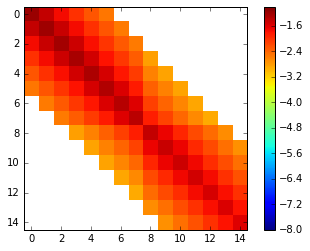

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


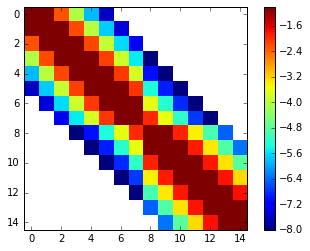

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


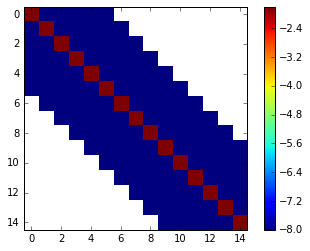

In [48]:
plt.figure()
plt.imshow(np.log(interp_matrix10)[0:15,0:15],vmin=-8,vmax=-1.0,interpolation='none')#,vmin=-20,vmax=1)
plt.imshow(np.log(-interp_matrix10)[0:15,0:15],vmin=-8,vmax=-1.0,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log(interp_matrix100)[0:15,0:15],vmin=-8,vmax=-1.0,interpolation='none')
plt.imshow(np.log(-interp_matrix100)[0:15,0:15],vmin=-8,vmax=-1.,interpolation='none')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.log(interp_matrix1000)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')#,vmin=-20,vmax=1)
plt.imshow(np.log(-interp_matrix1000)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')
plt.colorbar()
plt.show()

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


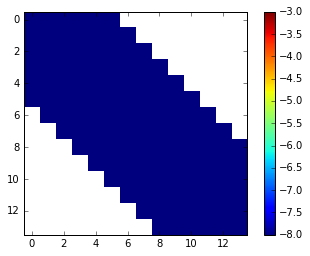

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


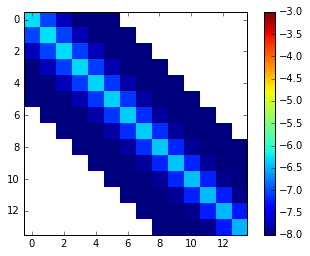

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


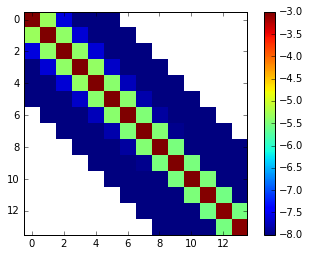

In [49]:
plt.figure()
plt.imshow(np.log(interp_matrix10)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')#,vmin=-20,vmax=1)
plt.imshow(np.log(-interp_matrix10)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log(interp_matrix100)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.imshow(np.log(-interp_matrix100)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.log(interp_matrix1000)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.imshow(np.log(-interp_matrix1000)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.colorbar()
plt.show()

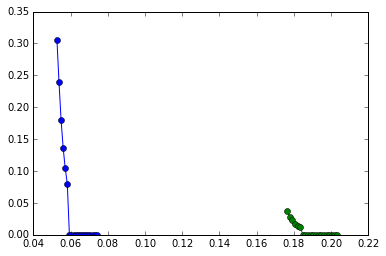

In [50]:
plt.plot(zs[0:20],abs(interp_matrix10[0,0:20]),marker='o')
plt.plot(zs[100:120],abs(interp_matrix10[100,100:120]),marker='o')

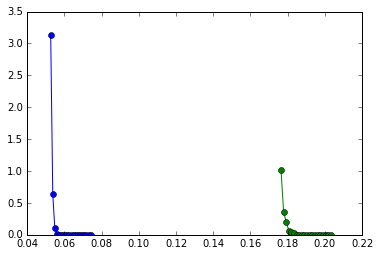

In [51]:
plt.plot(zs[0:20],abs(interp_matrix100[0,0:20]),marker='o')
plt.plot(zs[100:120],abs(interp_matrix100[100,100:120]),marker='o')

#plt.plot(abs(spline[0,0:20]),marker='^')
# plt.plot(spline[1,1:42],marker='^')
# plt.plot(spline[100,100:240],marker='^')

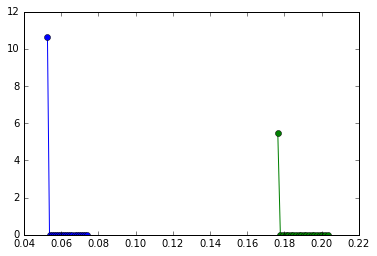

In [52]:
plt.plot(zs[0:20],abs(interp_matrix1000[0,0:20]),marker='o')
plt.plot(zs[100:120],abs(interp_matrix1000[100,100:120]),marker='o')

In [53]:
## Appending the first file with zeros to make all files the same size

# path
# fname = 'class_z000z020_cl.dat'
# cl = np.loadtxt(path + fname)
# fname = 'class_z010z030_cl.dat'
# clall = np.loadtxt(path + fname)
# clnew = np.zeros_like(clall)


# for i in range(cl.shape[1]):
#     clnew[:cl.shape[0], i] = cl[:, i]
    
# path
# fname = 'class_z000z020_cl.dat'
# # np.savetxt(path + fname, clnew)
# clcheck = np.loadtxt(path + fname)
# clcheck.shape

In [54]:
from BispectraMain import dNdz_LSST, simple_bias, gal_clus 

def simple_kernel(x,xmax):
    return (xmax-x)/x/xmax

In [55]:
LSST_bin = 'all'

In [56]:
W_g = gal_clus(b=simple_bias,bin_num=LSST_bin,cosmo=data, dNdz=dNdz_LSST)

using z-bin None norm 65.6723025802


In [57]:
W_l = simple_kernel

In [58]:
def Cl_psidelta(chi,z,L,cls,cosmo=data):
    return -cosmo.lens_prefac*(chi/L)**2*(1.+z)*cls/(L*(L+1.)/2./np.pi)

# lens_prefac is 1.5*self.H_0**2.*self.Omega_m0/(const.LIGHT_SPEED**2)

In [59]:
L_index = np.arange(0,100)
print(L_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


In [60]:
clgg = []
clkk = []
clkg = []

for L_ind in [0,3,5,10,50,100,500,1000]:
    print(L_ind)
    LL = L[L_ind]
    matrix          = get_matrix_at_L(L_ind)
    weighted_matrix1 = W_g(chi1,zs1)*W_g(chi2,zs2)*matrix/(L[L_ind]*(L[L_ind]+1.)/2./np.pi)#Cl_psidelta(chi1,zs1,L[L_ind],matrix,cosmo=data)
    weighted_matrix2 = data.lens_prefac*chi1**2*(1.+zs1)*W_l(chi1,data.chi_cmb)*W_g(chi2,zs2)*matrix/(L[L_ind]*(L[L_ind]+1.)/2./np.pi)
    weighted_matrix3 = (data.lens_prefac*chi1**2*(1.+zs1))**2*W_l(chi1,data.chi_cmb)*W_l(chi1,data.chi_cmb)*matrix/(L[L_ind]*(L[L_ind]+1.)/2./np.pi)
    
    
    res1=[]
    res2=[]
    res3=[]
    for ii in range(len(chi)):
        res1+=[np.trapz(weighted_matrix1[ii],chi)]
        res2+=[np.trapz(weighted_matrix2[ii],chi)]
        res3+=[np.trapz(weighted_matrix3[ii],chi)]
    
    clgg+=[np.trapz(res1,chi)]
    clkk+=[np.trapz(res3,chi)]
    clkg+=[np.trapz(res2,chi)]
    
clgg = np.asarray(clgg)
clkk = np.asarray(clkk)
clkg = np.asarray(clkg)

0
0.950, 0.950, 0.950, 0.940
(0.94999999999999996, 0.9504999999999999)
0
(0, 0, (array([0]),))
0
0.950, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(0, 1, (array([1]),))
0
0.950, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(0, 2, (array([2]),))
0
0.950, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(0, 3, (array([3]),))
0
0.950, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(0, 4, (array([4]),))
0
0.950, 0.945, 0.950, 0.940
(0.94499999999999995, 0.9504999999999999)
0
(0, 5, (array([5]),))
0
0.949, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(1, 1, (array([11]),))
0
0.949, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(1, 2, (array([12]),))
0
0.949, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(1, 3, (array([13]),))
0
0.949, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(1, 4, (array([14]),))
0
0.949, 0.945, 0.950, 0.940
(0.94499999999999

0
(1, 6, (array([16]),))
0.933, 0.933, 0.935, 0.925
(0.93299999999999994, 0.9355)
3
(2, 2, (array([21]),))
0
0.933, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(2, 3, (array([22]),))
0
0.933, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(2, 4, (array([23]),))
0
0.933, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(2, 5, (array([24]),))
0
0.933, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(2, 6, (array([25]),))
0
0.933, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(2, 7, (array([26]),))
0
0.932, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(3, 3, (array([30]),))
0
0.932, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(3, 4, (array([31]),))
0
0.932, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(3, 5, (array([32]),))
0
0.932, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(3, 6, (array([33]),))
0
0.932, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(3, 7, (array([34]),))
0
0.932, 0.927, 0.935, 0.925
(0.92699999999999994, 0.

0
(1, 6, (array([16]),))
0.913, 0.913, 0.915, 0.905
(0.91299999999999992, 0.91549999999999998)
7
(2, 2, (array([21]),))
0
0.913, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(2, 3, (array([22]),))
0
0.913, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(2, 4, (array([23]),))
0
0.913, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(2, 5, (array([24]),))
0
0.913, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(2, 6, (array([25]),))
0
0.913, 0.908, 0.915, 0.905
(0.90799999999999992, 0.91549999999999998)
7
(2, 7, (array([26]),))
0
0.912, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(3, 3, (array([30]),))
0
0.912, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(3, 4, (array([31]),))
0
0.912, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(3, 5, (array([32]),))
0
0.912, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(3, 6, (array([33]),))
0
0.912

0
(1, 6, (array([16]),))
0.893, 0.893, 0.895, 0.885
(0.8929999999999999, 0.89549999999999996)
11
(2, 2, (array([21]),))
0
0.893, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(2, 3, (array([22]),))
0
0.893, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(2, 4, (array([23]),))
0
0.893, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(2, 5, (array([24]),))
0
0.893, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(2, 6, (array([25]),))
0
0.893, 0.888, 0.895, 0.885
(0.8879999999999999, 0.89549999999999996)
11
(2, 7, (array([26]),))
0
0.892, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(3, 3, (array([30]),))
0
0.892, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(3, 4, (array([31]),))
0
0.892, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(3, 5, (array([32]),))
0
0.892, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(3, 6, (array([33]),))
0
0.892

0
(1, 6, (array([16]),))
0.873, 0.873, 0.875, 0.865
(0.87299999999999989, 0.87549999999999994)
15
(2, 2, (array([21]),))
0
0.873, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(2, 3, (array([22]),))
0
0.873, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(2, 4, (array([23]),))
0
0.873, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(2, 5, (array([24]),))
0
0.873, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(2, 6, (array([25]),))
0
0.873, 0.868, 0.875, 0.865
(0.86799999999999988, 0.87549999999999994)
15
(2, 7, (array([26]),))
0
0.872, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(3, 3, (array([30]),))
0
0.872, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(3, 4, (array([31]),))
0
0.872, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(3, 5, (array([32]),))
0
0.872, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.853, 0.853, 0.855, 0.845
(0.85299999999999987, 0.85549999999999993)
19
(2, 2, (array([21]),))
0
0.853, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(2, 3, (array([22]),))
0
0.853, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(2, 4, (array([23]),))
0
0.853, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(2, 5, (array([24]),))
0
0.853, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(2, 6, (array([25]),))
0
0.853, 0.848, 0.855, 0.845
(0.84799999999999986, 0.85549999999999993)
19
(2, 7, (array([26]),))
0
0.852, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(3, 3, (array([30]),))
0
0.852, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(3, 4, (array([31]),))
0
0.852, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(3, 5, (array([32]),))
0
0.852, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.833, 0.833, 0.835, 0.825
(0.83299999999999985, 0.83549999999999991)
23
(2, 2, (array([21]),))
0
0.833, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(2, 3, (array([22]),))
0
0.833, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(2, 4, (array([23]),))
0
0.833, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(2, 5, (array([24]),))
0
0.833, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(2, 6, (array([25]),))
0
0.833, 0.828, 0.835, 0.825
(0.82799999999999985, 0.83549999999999991)
23
(2, 7, (array([26]),))
0
0.832, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(3, 3, (array([30]),))
0
0.832, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(3, 4, (array([31]),))
0
0.832, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(3, 5, (array([32]),))
0
0.832, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.813, 0.813, 0.815, 0.805
(0.81299999999999983, 0.81549999999999989)
27
(2, 2, (array([21]),))
0
0.813, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(2, 3, (array([22]),))
0
0.813, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(2, 4, (array([23]),))
0
0.813, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(2, 5, (array([24]),))
0
0.813, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(2, 6, (array([25]),))
0
0.813, 0.808, 0.815, 0.805
(0.80799999999999983, 0.81549999999999989)
27
(2, 7, (array([26]),))
0
0.812, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(3, 3, (array([30]),))
0
0.812, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(3, 4, (array([31]),))
0
0.812, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(3, 5, (array([32]),))
0
0.812, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.793, 0.793, 0.795, 0.785
(0.79299999999999982, 0.79549999999999998)
31
(2, 2, (array([21]),))
0
0.793, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(2, 3, (array([22]),))
0
0.793, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(2, 4, (array([23]),))
0
0.793, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(2, 5, (array([24]),))
0
0.793, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(2, 6, (array([25]),))
0
0.793, 0.788, 0.795, 0.785
(0.78799999999999981, 0.79549999999999998)
31
(2, 7, (array([26]),))
0
0.792, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(3, 3, (array([30]),))
0
0.792, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(3, 4, (array([31]),))
0
0.792, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(3, 5, (array([32]),))
0
0.792, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.773, 0.773, 0.775, 0.765
(0.7729999999999998, 0.77549999999999997)
35
(2, 2, (array([21]),))
0
0.773, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(2, 3, (array([22]),))
0
0.773, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(2, 4, (array([23]),))
0
0.773, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(2, 5, (array([24]),))
0
0.773, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(2, 6, (array([25]),))
0
0.773, 0.768, 0.775, 0.765
(0.76799999999999979, 0.77549999999999997)
35
(2, 7, (array([26]),))
0
0.772, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(3, 3, (array([30]),))
0
0.772, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(3, 4, (array([31]),))
0
0.772, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(3, 5, (array([32]),))
0
0.772, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(3, 6, (array([33]),))
0
0.

0
(1, 6, (array([16]),))
0.753, 0.753, 0.755, 0.745
(0.75299999999999978, 0.75549999999999995)
39
(2, 2, (array([21]),))
0
0.753, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(2, 3, (array([22]),))
0
0.753, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(2, 4, (array([23]),))
0
0.753, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(2, 5, (array([24]),))
0
0.753, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(2, 6, (array([25]),))
0
0.753, 0.748, 0.755, 0.745
(0.74799999999999978, 0.75549999999999995)
39
(2, 7, (array([26]),))
0
0.752, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(3, 3, (array([30]),))
0
0.752, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(3, 4, (array([31]),))
0
0.752, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(3, 5, (array([32]),))
0
0.752, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.733, 0.733, 0.735, 0.725
(0.73299999999999976, 0.73549999999999993)
43
(2, 2, (array([21]),))
0
0.733, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(2, 3, (array([22]),))
0
0.733, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(2, 4, (array([23]),))
0
0.733, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(2, 5, (array([24]),))
0
0.733, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(2, 6, (array([25]),))
0
0.733, 0.728, 0.735, 0.725
(0.72799999999999976, 0.73549999999999993)
43
(2, 7, (array([26]),))
0
0.732, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(3, 3, (array([30]),))
0
0.732, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(3, 4, (array([31]),))
0
0.732, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(3, 5, (array([32]),))
0
0.732, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.713, 0.713, 0.715, 0.705
(0.71299999999999975, 0.71549999999999991)
47
(2, 2, (array([21]),))
0
0.713, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(2, 3, (array([22]),))
0
0.713, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(2, 4, (array([23]),))
0
0.713, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(2, 5, (array([24]),))
0
0.713, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(2, 6, (array([25]),))
0
0.713, 0.708, 0.715, 0.705
(0.70799999999999974, 0.71549999999999991)
47
(2, 7, (array([26]),))
0
0.712, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(3, 3, (array([30]),))
0
0.712, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(3, 4, (array([31]),))
0
0.712, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(3, 5, (array([32]),))
0
0.712, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.693, 0.693, 0.695, 0.685
(0.69299999999999973, 0.6954999999999999)
51
(2, 2, (array([21]),))
0
0.693, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(2, 3, (array([22]),))
0
0.693, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(2, 4, (array([23]),))
0
0.693, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(2, 5, (array([24]),))
0
0.693, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(2, 6, (array([25]),))
0
0.693, 0.688, 0.695, 0.685
(0.68799999999999972, 0.6954999999999999)
51
(2, 7, (array([26]),))
0
0.692, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(3, 3, (array([30]),))
0
0.692, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(3, 4, (array([31]),))
0
0.692, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(3, 5, (array([32]),))
0
0.692, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(3, 6, (array([33]),))
0
0.692

0
(1, 6, (array([16]),))
0.673, 0.673, 0.675, 0.665
(0.67299999999999971, 0.67549999999999999)
55
(2, 2, (array([21]),))
0
0.673, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(2, 3, (array([22]),))
0
0.673, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(2, 4, (array([23]),))
0
0.673, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(2, 5, (array([24]),))
0
0.673, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(2, 6, (array([25]),))
0
0.673, 0.668, 0.675, 0.665
(0.66799999999999971, 0.67549999999999999)
55
(2, 7, (array([26]),))
0
0.672, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(3, 3, (array([30]),))
0
0.672, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(3, 4, (array([31]),))
0
0.672, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(3, 5, (array([32]),))
0
0.672, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.653, 0.653, 0.655, 0.645
(0.65299999999999969, 0.65549999999999997)
59
(2, 2, (array([21]),))
0
0.653, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(2, 3, (array([22]),))
0
0.653, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(2, 4, (array([23]),))
0
0.653, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(2, 5, (array([24]),))
0
0.653, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(2, 6, (array([25]),))
0
0.653, 0.648, 0.655, 0.645
(0.64799999999999969, 0.65549999999999997)
59
(2, 7, (array([26]),))
0
0.652, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(3, 3, (array([30]),))
0
0.652, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(3, 4, (array([31]),))
0
0.652, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(3, 5, (array([32]),))
0
0.652, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.633, 0.633, 0.635, 0.625
(0.63299999999999967, 0.63549999999999995)
63
(2, 2, (array([21]),))
0
0.633, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(2, 3, (array([22]),))
0
0.633, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(2, 4, (array([23]),))
0
0.633, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(2, 5, (array([24]),))
0
0.633, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(2, 6, (array([25]),))
0
0.633, 0.628, 0.635, 0.625
(0.62799999999999967, 0.63549999999999995)
63
(2, 7, (array([26]),))
0
0.632, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(3, 3, (array([30]),))
0
0.632, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(3, 4, (array([31]),))
0
0.632, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(3, 5, (array([32]),))
0
0.632, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.613, 0.613, 0.615, 0.605
(0.61299999999999966, 0.61549999999999994)
67
(2, 2, (array([21]),))
0
0.613, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(2, 3, (array([22]),))
0
0.613, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(2, 4, (array([23]),))
0
0.613, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(2, 5, (array([24]),))
0
0.613, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(2, 6, (array([25]),))
0
0.613, 0.608, 0.615, 0.605
(0.60799999999999965, 0.61549999999999994)
67
(2, 7, (array([26]),))
0
0.612, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(3, 3, (array([30]),))
0
0.612, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(3, 4, (array([31]),))
0
0.612, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(3, 5, (array([32]),))
0
0.612, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.593, 0.593, 0.595, 0.585
(0.59299999999999964, 0.59549999999999992)
71
(2, 2, (array([21]),))
0
0.593, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(2, 3, (array([22]),))
0
0.593, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(2, 4, (array([23]),))
0
0.593, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(2, 5, (array([24]),))
0
0.593, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(2, 6, (array([25]),))
0
0.593, 0.588, 0.595, 0.585
(0.58799999999999963, 0.59549999999999992)
71
(2, 7, (array([26]),))
0
0.592, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(3, 3, (array([30]),))
0
0.592, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(3, 4, (array([31]),))
0
0.592, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(3, 5, (array([32]),))
0
0.592, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.573, 0.573, 0.575, 0.565
(0.57299999999999962, 0.5754999999999999)
75
(2, 2, (array([21]),))
0
0.573, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(2, 3, (array([22]),))
0
0.573, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(2, 4, (array([23]),))
0
0.573, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(2, 5, (array([24]),))
0
0.573, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(2, 6, (array([25]),))
0
0.573, 0.568, 0.575, 0.565
(0.56799999999999962, 0.5754999999999999)
75
(2, 7, (array([26]),))
0
0.572, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(3, 3, (array([30]),))
0
0.572, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(3, 4, (array([31]),))
0
0.572, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(3, 5, (array([32]),))
0
0.572, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(3, 6, (array([33]),))
0
0.572

0
(1, 6, (array([16]),))
0.553, 0.553, 0.555, 0.545
(0.5529999999999996, 0.55549999999999999)
79
(2, 2, (array([21]),))
0
0.553, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(2, 3, (array([22]),))
0
0.553, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(2, 4, (array([23]),))
0
0.553, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(2, 5, (array([24]),))
0
0.553, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(2, 6, (array([25]),))
0
0.553, 0.548, 0.555, 0.545
(0.5479999999999996, 0.55549999999999999)
79
(2, 7, (array([26]),))
0
0.552, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(3, 3, (array([30]),))
0
0.552, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(3, 4, (array([31]),))
0
0.552, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(3, 5, (array([32]),))
0
0.552, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(3, 6, (array([33]),))
0
0.552

0
(1, 6, (array([16]),))
0.533, 0.533, 0.535, 0.525
(0.53299999999999959, 0.53549999999999998)
83
(2, 2, (array([21]),))
0
0.533, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(2, 3, (array([22]),))
0
0.533, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(2, 4, (array([23]),))
0
0.533, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(2, 5, (array([24]),))
0
0.533, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(2, 6, (array([25]),))
0
0.533, 0.528, 0.535, 0.525
(0.52799999999999958, 0.53549999999999998)
83
(2, 7, (array([26]),))
0
0.532, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(3, 3, (array([30]),))
0
0.532, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(3, 4, (array([31]),))
0
0.532, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(3, 5, (array([32]),))
0
0.532, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.513, 0.513, 0.515, 0.505
(0.51299999999999957, 0.51549999999999996)
87
(2, 2, (array([21]),))
0
0.513, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(2, 3, (array([22]),))
0
0.513, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(2, 4, (array([23]),))
0
0.513, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(2, 5, (array([24]),))
0
0.513, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(2, 6, (array([25]),))
0
0.513, 0.508, 0.515, 0.505
(0.50799999999999956, 0.51549999999999996)
87
(2, 7, (array([26]),))
0
0.512, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(3, 3, (array([30]),))
0
0.512, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(3, 4, (array([31]),))
0
0.512, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(3, 5, (array([32]),))
0
0.512, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.493, 0.493, 0.495, 0.485
(0.49299999999999955, 0.4955)
91
(2, 2, (array([21]),))
0
0.493, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(2, 3, (array([22]),))
0
0.493, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(2, 4, (array([23]),))
0
0.493, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(2, 5, (array([24]),))
0
0.493, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(2, 6, (array([25]),))
0
0.493, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(2, 7, (array([26]),))
0
0.492, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(3, 3, (array([30]),))
0
0.492, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(3, 4, (array([31]),))
0
0.492, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(3, 5, (array([32]),))
0
0.492, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(3, 6, (array([33]),))
0
0.492, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(3, 7, (array([34]),))
0
0.492, 0.487, 0.495, 0.485
(0.4869999999

0
(1, 6, (array([16]),))
0.473, 0.473, 0.475, 0.465
(0.47299999999999953, 0.47549999999999998)
95
(2, 2, (array([21]),))
0
0.473, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(2, 3, (array([22]),))
0
0.473, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(2, 4, (array([23]),))
0
0.473, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(2, 5, (array([24]),))
0
0.473, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(2, 6, (array([25]),))
0
0.473, 0.468, 0.475, 0.465
(0.46799999999999953, 0.47549999999999998)
95
(2, 7, (array([26]),))
0
0.472, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(3, 3, (array([30]),))
0
0.472, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(3, 4, (array([31]),))
0
0.472, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(3, 5, (array([32]),))
0
0.472, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.453, 0.453, 0.455, 0.445
(0.45299999999999951, 0.45550000000000002)
99
(2, 2, (array([21]),))
0
0.453, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(2, 3, (array([22]),))
0
0.453, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(2, 4, (array([23]),))
0
0.453, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(2, 5, (array([24]),))
0
0.453, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(2, 6, (array([25]),))
0
0.453, 0.448, 0.455, 0.445
(0.44799999999999951, 0.45550000000000002)
99
(2, 7, (array([26]),))
0
0.452, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(3, 3, (array([30]),))
0
0.452, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(3, 4, (array([31]),))
0
0.452, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(3, 5, (array([32]),))
0
0.452, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.433, 0.433, 0.435, 0.425
(0.4329999999999995, 0.4355)
103
(2, 2, (array([21]),))
0
0.433, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(2, 3, (array([22]),))
0
0.433, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(2, 4, (array([23]),))
0
0.433, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(2, 5, (array([24]),))
0
0.433, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(2, 6, (array([25]),))
0
0.433, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(2, 7, (array([26]),))
0
0.432, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(3, 3, (array([30]),))
0
0.432, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(3, 4, (array([31]),))
0
0.432, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(3, 5, (array([32]),))
0
0.432, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(3, 6, (array([33]),))
0
0.432, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(3, 7, (array([34]),))
0
0.432, 0.427, 0.435, 0.425
(0.42

0
(1, 6, (array([16]),))
0.413, 0.413, 0.415, 0.405
(0.41299999999999948, 0.41549999999999998)
107
(2, 2, (array([21]),))
0
0.413, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(2, 3, (array([22]),))
0
0.413, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(2, 4, (array([23]),))
0
0.413, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(2, 5, (array([24]),))
0
0.413, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(2, 6, (array([25]),))
0
0.413, 0.408, 0.415, 0.405
(0.40799999999999947, 0.41549999999999998)
107
(2, 7, (array([26]),))
0
0.412, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(3, 3, (array([30]),))
0
0.412, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(3, 4, (array([31]),))
0
0.412, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(3, 5, (array([32]),))
0
0.412, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(3, 6, (ar

0
(1, 6, (array([16]),))
0.393, 0.393, 0.395, 0.385
(0.39299999999999946, 0.39550000000000002)
111
(2, 2, (array([21]),))
0
0.393, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(2, 3, (array([22]),))
0
0.393, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(2, 4, (array([23]),))
0
0.393, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(2, 5, (array([24]),))
0
0.393, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(2, 6, (array([25]),))
0
0.393, 0.388, 0.395, 0.385
(0.38799999999999946, 0.39550000000000002)
111
(2, 7, (array([26]),))
0
0.392, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(3, 3, (array([30]),))
0
0.392, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(3, 4, (array([31]),))
0
0.392, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(3, 5, (array([32]),))
0
0.392, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(3, 6, (ar

0
(1, 6, (array([16]),))
0.373, 0.373, 0.375, 0.365
(0.37299999999999944, 0.3755)
115
(2, 2, (array([21]),))
0
0.373, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(2, 3, (array([22]),))
0
0.373, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(2, 4, (array([23]),))
0
0.373, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(2, 5, (array([24]),))
0
0.373, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(2, 6, (array([25]),))
0
0.373, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(2, 7, (array([26]),))
0
0.372, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(3, 3, (array([30]),))
0
0.372, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(3, 4, (array([31]),))
0
0.372, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(3, 5, (array([32]),))
0
0.372, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(3, 6, (array([33]),))
0
0.372, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(3, 7, (array([34]),))
0
0.372, 0.367, 0.375, 0.365
(0

0
(1, 6, (array([16]),))
0.353, 0.353, 0.355, 0.345
(0.35299999999999943, 0.35549999999999998)
119
(2, 2, (array([21]),))
0
0.353, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(2, 3, (array([22]),))
0
0.353, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(2, 4, (array([23]),))
0
0.353, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(2, 5, (array([24]),))
0
0.353, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(2, 6, (array([25]),))
0
0.353, 0.348, 0.355, 0.345
(0.34799999999999942, 0.35549999999999998)
119
(2, 7, (array([26]),))
0
0.352, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(3, 3, (array([30]),))
0
0.352, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(3, 4, (array([31]),))
0
0.352, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(3, 5, (array([32]),))
0
0.352, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(3, 6, (ar

0
(1, 6, (array([16]),))
0.333, 0.333, 0.335, 0.325
(0.33299999999999941, 0.33550000000000002)
123
(2, 2, (array([21]),))
0
0.333, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(2, 3, (array([22]),))
0
0.333, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(2, 4, (array([23]),))
0
0.333, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(2, 5, (array([24]),))
0
0.333, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(2, 6, (array([25]),))
0
0.333, 0.328, 0.335, 0.325
(0.3279999999999994, 0.33550000000000002)
123
(2, 7, (array([26]),))
0
0.332, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(3, 3, (array([30]),))
0
0.332, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(3, 4, (array([31]),))
0
0.332, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(3, 5, (array([32]),))
0
0.332, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(3, 6, (array([

0
(1, 6, (array([16]),))
0.313, 0.313, 0.315, 0.305
(0.31299999999999939, 0.3155)
127
(2, 2, (array([21]),))
0
0.313, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(2, 3, (array([22]),))
0
0.313, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(2, 4, (array([23]),))
0
0.313, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(2, 5, (array([24]),))
0
0.313, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(2, 6, (array([25]),))
0
0.313, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(2, 7, (array([26]),))
0
0.312, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(3, 3, (array([30]),))
0
0.312, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(3, 4, (array([31]),))
0
0.312, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(3, 5, (array([32]),))
0
0.312, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(3, 6, (array([33]),))
0
0.312, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(3, 7, (array([34]),))
0
0.312, 0.307, 0.315, 0.305
(0

0
(1, 6, (array([16]),))
0.293, 0.293, 0.295, 0.285
(0.29299999999999937, 0.29549999999999998)
131
(2, 2, (array([21]),))
0
0.293, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(2, 3, (array([22]),))
0
0.293, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(2, 4, (array([23]),))
0
0.293, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(2, 5, (array([24]),))
0
0.293, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(2, 6, (array([25]),))
0
0.293, 0.288, 0.295, 0.285
(0.28799999999999937, 0.29549999999999998)
131
(2, 7, (array([26]),))
0
0.292, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(3, 3, (array([30]),))
0
0.292, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(3, 4, (array([31]),))
0
0.292, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(3, 5, (array([32]),))
0
0.292, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(3, 6, (ar

0
(1, 6, (array([16]),))
0.273, 0.273, 0.275, 0.265
(0.27299999999999935, 0.27550000000000002)
135
(2, 2, (array([21]),))
0
0.273, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(2, 3, (array([22]),))
0
0.273, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(2, 4, (array([23]),))
0
0.273, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(2, 5, (array([24]),))
0
0.273, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(2, 6, (array([25]),))
0
0.273, 0.268, 0.275, 0.265
(0.26799999999999935, 0.27550000000000002)
135
(2, 7, (array([26]),))
0
0.272, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(3, 3, (array([30]),))
0
0.272, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(3, 4, (array([31]),))
0
0.272, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(3, 5, (array([32]),))
0
0.272, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(3, 6, (ar

0
(1, 6, (array([16]),))
0.253, 0.253, 0.255, 0.245
(0.25299999999999934, 0.2555)
139
(2, 2, (array([21]),))
0
0.253, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(2, 3, (array([22]),))
0
0.253, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(2, 4, (array([23]),))
0
0.253, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(2, 5, (array([24]),))
0
0.253, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(2, 6, (array([25]),))
0
0.253, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(2, 7, (array([26]),))
0
0.252, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(3, 3, (array([30]),))
0
0.252, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(3, 4, (array([31]),))
0
0.252, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(3, 5, (array([32]),))
0
0.252, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(3, 6, (array([33]),))
0
0.252, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(3, 7, (array([34]),))
0
0.252, 0.247, 0.255, 0.245
(0

0
(1, 6, (array([16]),))
0.233, 0.233, 0.235, 0.225
(0.23299999999999932, 0.23549999999999999)
143
(2, 2, (array([21]),))
0
0.233, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(2, 3, (array([22]),))
0
0.233, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(2, 4, (array([23]),))
0
0.233, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(2, 5, (array([24]),))
0
0.233, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(2, 6, (array([25]),))
0
0.233, 0.228, 0.235, 0.225
(0.22799999999999931, 0.23549999999999999)
143
(2, 7, (array([26]),))
0
0.232, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(3, 3, (array([30]),))
0
0.232, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(3, 4, (array([31]),))
0
0.232, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(3, 5, (array([32]),))
0
0.232, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(3, 6, (ar

0
(1, 6, (array([16]),))
0.213, 0.213, 0.215, 0.205
(0.2129999999999993, 0.2155)
147
(2, 2, (array([21]),))
0
0.213, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(2, 3, (array([22]),))
0
0.213, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(2, 4, (array([23]),))
0
0.213, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(2, 5, (array([24]),))
0
0.213, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(2, 6, (array([25]),))
0
0.213, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(2, 7, (array([26]),))
0
0.212, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(3, 3, (array([30]),))
0
0.212, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(3, 4, (array([31]),))
0
0.212, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(3, 5, (array([32]),))
0
0.212, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(3, 6, (array([33]),))
0
0.212, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(3, 7, (array([34]),))
0
0.212, 0.207, 0.215, 0.205
(0.2069999999

0
(1, 6, (array([16]),))
0.193, 0.193, 0.195, 0.185
(0.19299999999999928, 0.19550000000000001)
151
(2, 2, (array([21]),))
0
0.193, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(2, 3, (array([22]),))
0
0.193, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(2, 4, (array([23]),))
0
0.193, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(2, 5, (array([24]),))
0
0.193, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(2, 6, (array([25]),))
0
0.193, 0.188, 0.195, 0.185
(0.18799999999999928, 0.19550000000000001)
151
(2, 7, (array([26]),))
0
0.192, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(3, 3, (array([30]),))
0
0.192, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(3, 4, (array([31]),))
0
0.192, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(3, 5, (array([32]),))
0
0.192, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(3, 6, (ar

0
(1, 6, (array([16]),))
0.173, 0.173, 0.175, 0.165
(0.17299999999999927, 0.17549999999999999)
155
(2, 2, (array([21]),))
0
0.173, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(2, 3, (array([22]),))
0
0.173, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(2, 4, (array([23]),))
0
0.173, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(2, 5, (array([24]),))
0
0.173, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(2, 6, (array([25]),))
0
0.173, 0.168, 0.175, 0.165
(0.16799999999999926, 0.17549999999999999)
155
(2, 7, (array([26]),))
0
0.172, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(3, 3, (array([30]),))
0
0.172, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(3, 4, (array([31]),))
0
0.172, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(3, 5, (array([32]),))
0
0.172, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(3, 6, (ar

3
(1, 6, (array([16]),))
0.943, 0.943, 0.945, 0.935
(0.94299999999999995, 0.9454999999999999)
1
(2, 2, (array([21]),))
3
0.943, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(2, 3, (array([22]),))
3
0.943, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(2, 4, (array([23]),))
3
0.943, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(2, 5, (array([24]),))
3
0.943, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(2, 6, (array([25]),))
3
0.943, 0.938, 0.945, 0.935
(0.93799999999999994, 0.9454999999999999)
1
(2, 7, (array([26]),))
3
0.942, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(3, 3, (array([30]),))
3
0.942, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(3, 4, (array([31]),))
3
0.942, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(3, 5, (array([32]),))
3
0.942, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(3, 6, (array([33]),))
3
0.942, 0.938, 0

3
(1, 6, (array([16]),))
0.923, 0.923, 0.925, 0.915
(0.92299999999999993, 0.92549999999999999)
5
(2, 2, (array([21]),))
3
0.923, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(2, 3, (array([22]),))
3
0.923, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(2, 4, (array([23]),))
3
0.923, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(2, 5, (array([24]),))
3
0.923, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(2, 6, (array([25]),))
3
0.923, 0.918, 0.925, 0.915
(0.91799999999999993, 0.92549999999999999)
5
(2, 7, (array([26]),))
3
0.922, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(3, 3, (array([30]),))
3
0.922, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(3, 4, (array([31]),))
3
0.922, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(3, 5, (array([32]),))
3
0.922, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(3, 6, (array([33]),))
3
0.922

3
(1, 6, (array([16]),))
0.903, 0.903, 0.905, 0.895
(0.90299999999999991, 0.90549999999999997)
9
(2, 2, (array([21]),))
3
0.903, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(2, 3, (array([22]),))
3
0.903, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(2, 4, (array([23]),))
3
0.903, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(2, 5, (array([24]),))
3
0.903, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(2, 6, (array([25]),))
3
0.903, 0.898, 0.905, 0.895
(0.89799999999999991, 0.90549999999999997)
9
(2, 7, (array([26]),))
3
0.902, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(3, 3, (array([30]),))
3
0.902, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(3, 4, (array([31]),))
3
0.902, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(3, 5, (array([32]),))
3
0.902, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(3, 6, (array([33]),))
3
0.902

3
(1, 6, (array([16]),))
0.883, 0.883, 0.885, 0.875
(0.8829999999999999, 0.88549999999999995)
13
(2, 2, (array([21]),))
3
0.883, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(2, 3, (array([22]),))
3
0.883, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(2, 4, (array([23]),))
3
0.883, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(2, 5, (array([24]),))
3
0.883, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(2, 6, (array([25]),))
3
0.883, 0.878, 0.885, 0.875
(0.87799999999999989, 0.88549999999999995)
13
(2, 7, (array([26]),))
3
0.882, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(3, 3, (array([30]),))
3
0.882, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(3, 4, (array([31]),))
3
0.882, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(3, 5, (array([32]),))
3
0.882, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(3, 6, (array([33]),))


3
(1, 6, (array([16]),))
0.863, 0.863, 0.865, 0.855
(0.86299999999999988, 0.86549999999999994)
17
(2, 2, (array([21]),))
3
0.863, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(2, 3, (array([22]),))
3
0.863, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(2, 4, (array([23]),))
3
0.863, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(2, 5, (array([24]),))
3
0.863, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(2, 6, (array([25]),))
3
0.863, 0.858, 0.865, 0.855
(0.85799999999999987, 0.86549999999999994)
17
(2, 7, (array([26]),))
3
0.862, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(3, 3, (array([30]),))
3
0.862, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(3, 4, (array([31]),))
3
0.862, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(3, 5, (array([32]),))
3
0.862, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.843, 0.843, 0.845, 0.835
(0.84299999999999986, 0.84549999999999992)
21
(2, 2, (array([21]),))
3
0.843, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(2, 3, (array([22]),))
3
0.843, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(2, 4, (array([23]),))
3
0.843, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(2, 5, (array([24]),))
3
0.843, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(2, 6, (array([25]),))
3
0.843, 0.838, 0.845, 0.835
(0.83799999999999986, 0.84549999999999992)
21
(2, 7, (array([26]),))
3
0.842, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(3, 3, (array([30]),))
3
0.842, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(3, 4, (array([31]),))
3
0.842, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(3, 5, (array([32]),))
3
0.842, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.823, 0.823, 0.825, 0.815
(0.82299999999999984, 0.8254999999999999)
25
(2, 2, (array([21]),))
3
0.823, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(2, 3, (array([22]),))
3
0.823, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(2, 4, (array([23]),))
3
0.823, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(2, 5, (array([24]),))
3
0.823, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(2, 6, (array([25]),))
3
0.823, 0.818, 0.825, 0.815
(0.81799999999999984, 0.8254999999999999)
25
(2, 7, (array([26]),))
3
0.822, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(3, 3, (array([30]),))
3
0.822, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(3, 4, (array([31]),))
3
0.822, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(3, 5, (array([32]),))
3
0.822, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(3, 6, (array([33]),))
3
0.822

3
(1, 6, (array([16]),))
0.803, 0.803, 0.805, 0.795
(0.80299999999999983, 0.80549999999999999)
29
(2, 2, (array([21]),))
3
0.803, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(2, 3, (array([22]),))
3
0.803, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(2, 4, (array([23]),))
3
0.803, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(2, 5, (array([24]),))
3
0.803, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(2, 6, (array([25]),))
3
0.803, 0.798, 0.805, 0.795
(0.79799999999999982, 0.80549999999999999)
29
(2, 7, (array([26]),))
3
0.802, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(3, 3, (array([30]),))
3
0.802, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(3, 4, (array([31]),))
3
0.802, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(3, 5, (array([32]),))
3
0.802, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.783, 0.783, 0.785, 0.775
(0.78299999999999981, 0.78549999999999998)
33
(2, 2, (array([21]),))
3
0.783, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(2, 3, (array([22]),))
3
0.783, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(2, 4, (array([23]),))
3
0.783, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(2, 5, (array([24]),))
3
0.783, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(2, 6, (array([25]),))
3
0.783, 0.778, 0.785, 0.775
(0.7779999999999998, 0.78549999999999998)
33
(2, 7, (array([26]),))
3
0.782, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(3, 3, (array([30]),))
3
0.782, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(3, 4, (array([31]),))
3
0.782, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(3, 5, (array([32]),))
3
0.782, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(3, 6, (array([33]),))
3


3
(1, 6, (array([16]),))
0.763, 0.763, 0.765, 0.755
(0.76299999999999979, 0.76549999999999996)
37
(2, 2, (array([21]),))
3
0.763, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(2, 3, (array([22]),))
3
0.763, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(2, 4, (array([23]),))
3
0.763, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(2, 5, (array([24]),))
3
0.763, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(2, 6, (array([25]),))
3
0.763, 0.758, 0.765, 0.755
(0.75799999999999979, 0.76549999999999996)
37
(2, 7, (array([26]),))
3
0.762, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(3, 3, (array([30]),))
3
0.762, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(3, 4, (array([31]),))
3
0.762, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(3, 5, (array([32]),))
3
0.762, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.743, 0.743, 0.745, 0.735
(0.74299999999999977, 0.74549999999999994)
41
(2, 2, (array([21]),))
3
0.743, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(2, 3, (array([22]),))
3
0.743, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(2, 4, (array([23]),))
3
0.743, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(2, 5, (array([24]),))
3
0.743, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(2, 6, (array([25]),))
3
0.743, 0.738, 0.745, 0.735
(0.73799999999999977, 0.74549999999999994)
41
(2, 7, (array([26]),))
3
0.742, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(3, 3, (array([30]),))
3
0.742, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(3, 4, (array([31]),))
3
0.742, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(3, 5, (array([32]),))
3
0.742, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.723, 0.723, 0.725, 0.715
(0.72299999999999975, 0.72549999999999992)
45
(2, 2, (array([21]),))
3
0.723, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(2, 3, (array([22]),))
3
0.723, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(2, 4, (array([23]),))
3
0.723, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(2, 5, (array([24]),))
3
0.723, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(2, 6, (array([25]),))
3
0.723, 0.718, 0.725, 0.715
(0.71799999999999975, 0.72549999999999992)
45
(2, 7, (array([26]),))
3
0.722, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(3, 3, (array([30]),))
3
0.722, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(3, 4, (array([31]),))
3
0.722, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(3, 5, (array([32]),))
3
0.722, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.703, 0.703, 0.705, 0.695
(0.70299999999999974, 0.7054999999999999)
49
(2, 2, (array([21]),))
3
0.703, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(2, 3, (array([22]),))
3
0.703, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(2, 4, (array([23]),))
3
0.703, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(2, 5, (array([24]),))
3
0.703, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(2, 6, (array([25]),))
3
0.703, 0.698, 0.705, 0.695
(0.69799999999999973, 0.7054999999999999)
49
(2, 7, (array([26]),))
3
0.702, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(3, 3, (array([30]),))
3
0.702, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(3, 4, (array([31]),))
3
0.702, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(3, 5, (array([32]),))
3
0.702, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(3, 6, (array([33]),))
3
0.702

3
(1, 6, (array([16]),))
0.683, 0.683, 0.685, 0.675
(0.68299999999999972, 0.6855)
53
(2, 2, (array([21]),))
3
0.683, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(2, 3, (array([22]),))
3
0.683, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(2, 4, (array([23]),))
3
0.683, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(2, 5, (array([24]),))
3
0.683, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(2, 6, (array([25]),))
3
0.683, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(2, 7, (array([26]),))
3
0.682, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(3, 3, (array([30]),))
3
0.682, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(3, 4, (array([31]),))
3
0.682, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(3, 5, (array([32]),))
3
0.682, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(3, 6, (array([33]),))
3
0.682, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(3, 7, (array([34]),))
3
0.682, 0.677, 0.685, 0.675
(0.6769999999

3
(1, 6, (array([16]),))
0.663, 0.663, 0.665, 0.655
(0.6629999999999997, 0.66549999999999998)
57
(2, 2, (array([21]),))
3
0.663, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(2, 3, (array([22]),))
3
0.663, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(2, 4, (array([23]),))
3
0.663, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(2, 5, (array([24]),))
3
0.663, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(2, 6, (array([25]),))
3
0.663, 0.658, 0.665, 0.655
(0.6579999999999997, 0.66549999999999998)
57
(2, 7, (array([26]),))
3
0.662, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(3, 3, (array([30]),))
3
0.662, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(3, 4, (array([31]),))
3
0.662, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(3, 5, (array([32]),))
3
0.662, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(3, 6, (array([33]),))
3
0.662

3
(1, 6, (array([16]),))
0.643, 0.643, 0.645, 0.635
(0.64299999999999968, 0.64549999999999996)
61
(2, 2, (array([21]),))
3
0.643, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(2, 3, (array([22]),))
3
0.643, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(2, 4, (array([23]),))
3
0.643, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(2, 5, (array([24]),))
3
0.643, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(2, 6, (array([25]),))
3
0.643, 0.638, 0.645, 0.635
(0.63799999999999968, 0.64549999999999996)
61
(2, 7, (array([26]),))
3
0.642, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(3, 3, (array([30]),))
3
0.642, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(3, 4, (array([31]),))
3
0.642, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(3, 5, (array([32]),))
3
0.642, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.623, 0.623, 0.625, 0.615
(0.62299999999999967, 0.62549999999999994)
65
(2, 2, (array([21]),))
3
0.623, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(2, 3, (array([22]),))
3
0.623, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(2, 4, (array([23]),))
3
0.623, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(2, 5, (array([24]),))
3
0.623, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(2, 6, (array([25]),))
3
0.623, 0.618, 0.625, 0.615
(0.61799999999999966, 0.62549999999999994)
65
(2, 7, (array([26]),))
3
0.622, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(3, 3, (array([30]),))
3
0.622, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(3, 4, (array([31]),))
3
0.622, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(3, 5, (array([32]),))
3
0.622, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.603, 0.603, 0.605, 0.595
(0.60299999999999965, 0.60549999999999993)
69
(2, 2, (array([21]),))
3
0.603, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(2, 3, (array([22]),))
3
0.603, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(2, 4, (array([23]),))
3
0.603, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(2, 5, (array([24]),))
3
0.603, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(2, 6, (array([25]),))
3
0.603, 0.598, 0.605, 0.595
(0.59799999999999964, 0.60549999999999993)
69
(2, 7, (array([26]),))
3
0.602, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(3, 3, (array([30]),))
3
0.602, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(3, 4, (array([31]),))
3
0.602, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(3, 5, (array([32]),))
3
0.602, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.583, 0.583, 0.585, 0.575
(0.58299999999999963, 0.58549999999999991)
73
(2, 2, (array([21]),))
3
0.583, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(2, 3, (array([22]),))
3
0.583, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(2, 4, (array([23]),))
3
0.583, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(2, 5, (array([24]),))
3
0.583, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(2, 6, (array([25]),))
3
0.583, 0.578, 0.585, 0.575
(0.57799999999999963, 0.58549999999999991)
73
(2, 7, (array([26]),))
3
0.582, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(3, 3, (array([30]),))
3
0.582, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(3, 4, (array([31]),))
3
0.582, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(3, 5, (array([32]),))
3
0.582, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.563, 0.563, 0.565, 0.555
(0.56299999999999961, 0.56549999999999989)
77
(2, 2, (array([21]),))
3
0.563, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(2, 3, (array([22]),))
3
0.563, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(2, 4, (array([23]),))
3
0.563, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(2, 5, (array([24]),))
3
0.563, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(2, 6, (array([25]),))
3
0.563, 0.558, 0.565, 0.555
(0.55799999999999961, 0.56549999999999989)
77
(2, 7, (array([26]),))
3
0.562, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(3, 3, (array([30]),))
3
0.562, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(3, 4, (array([31]),))
3
0.562, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(3, 5, (array([32]),))
3
0.562, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.543, 0.543, 0.545, 0.535
(0.54299999999999959, 0.54549999999999998)
81
(2, 2, (array([21]),))
3
0.543, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(2, 3, (array([22]),))
3
0.543, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(2, 4, (array([23]),))
3
0.543, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(2, 5, (array([24]),))
3
0.543, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(2, 6, (array([25]),))
3
0.543, 0.538, 0.545, 0.535
(0.53799999999999959, 0.54549999999999998)
81
(2, 7, (array([26]),))
3
0.542, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(3, 3, (array([30]),))
3
0.542, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(3, 4, (array([31]),))
3
0.542, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(3, 5, (array([32]),))
3
0.542, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.523, 0.523, 0.525, 0.515
(0.52299999999999958, 0.52549999999999997)
85
(2, 2, (array([21]),))
3
0.523, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(2, 3, (array([22]),))
3
0.523, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(2, 4, (array([23]),))
3
0.523, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(2, 5, (array([24]),))
3
0.523, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(2, 6, (array([25]),))
3
0.523, 0.518, 0.525, 0.515
(0.51799999999999957, 0.52549999999999997)
85
(2, 7, (array([26]),))
3
0.522, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(3, 3, (array([30]),))
3
0.522, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(3, 4, (array([31]),))
3
0.522, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(3, 5, (array([32]),))
3
0.522, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.503, 0.503, 0.505, 0.495
(0.50299999999999956, 0.50549999999999995)
89
(2, 2, (array([21]),))
3
0.503, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(2, 3, (array([22]),))
3
0.503, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(2, 4, (array([23]),))
3
0.503, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(2, 5, (array([24]),))
3
0.503, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(2, 6, (array([25]),))
3
0.503, 0.498, 0.505, 0.495
(0.49799999999999955, 0.50549999999999995)
89
(2, 7, (array([26]),))
3
0.502, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(3, 3, (array([30]),))
3
0.502, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(3, 4, (array([31]),))
3
0.502, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(3, 5, (array([32]),))
3
0.502, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.483, 0.483, 0.485, 0.475
(0.48299999999999954, 0.48549999999999999)
93
(2, 2, (array([21]),))
3
0.483, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(2, 3, (array([22]),))
3
0.483, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(2, 4, (array([23]),))
3
0.483, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(2, 5, (array([24]),))
3
0.483, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(2, 6, (array([25]),))
3
0.483, 0.478, 0.485, 0.475
(0.47799999999999954, 0.48549999999999999)
93
(2, 7, (array([26]),))
3
0.482, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(3, 3, (array([30]),))
3
0.482, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(3, 4, (array([31]),))
3
0.482, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(3, 5, (array([32]),))
3
0.482, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.463, 0.463, 0.465, 0.455
(0.46299999999999952, 0.46550000000000002)
97
(2, 2, (array([21]),))
3
0.463, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(2, 3, (array([22]),))
3
0.463, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(2, 4, (array([23]),))
3
0.463, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(2, 5, (array([24]),))
3
0.463, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(2, 6, (array([25]),))
3
0.463, 0.458, 0.465, 0.455
(0.45799999999999952, 0.46550000000000002)
97
(2, 7, (array([26]),))
3
0.462, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(3, 3, (array([30]),))
3
0.462, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(3, 4, (array([31]),))
3
0.462, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(3, 5, (array([32]),))
3
0.462, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.443, 0.443, 0.445, 0.435
(0.44299999999999951, 0.44550000000000001)
101
(2, 2, (array([21]),))
3
0.443, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(2, 3, (array([22]),))
3
0.443, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(2, 4, (array([23]),))
3
0.443, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(2, 5, (array([24]),))
3
0.443, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(2, 6, (array([25]),))
3
0.443, 0.438, 0.445, 0.435
(0.4379999999999995, 0.44550000000000001)
101
(2, 7, (array([26]),))
3
0.442, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(3, 3, (array([30]),))
3
0.442, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(3, 4, (array([31]),))
3
0.442, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(3, 5, (array([32]),))
3
0.442, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(3, 6, (array([33])

3
(1, 6, (array([16]),))
0.423, 0.423, 0.425, 0.415
(0.42299999999999949, 0.42549999999999999)
105
(2, 2, (array([21]),))
3
0.423, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(2, 3, (array([22]),))
3
0.423, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(2, 4, (array([23]),))
3
0.423, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(2, 5, (array([24]),))
3
0.423, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105
(2, 6, (array([25]),))
3
0.423, 0.418, 0.425, 0.415
(0.41799999999999948, 0.42549999999999999)
105
(2, 7, (array([26]),))
3
0.422, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(3, 3, (array([30]),))
3
0.422, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(3, 4, (array([31]),))
3
0.422, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(3, 5, (array([32]),))
3
0.422, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105
(3, 6, (ar

3
(1, 6, (array([16]),))
0.403, 0.403, 0.405, 0.395
(0.40299999999999947, 0.40550000000000003)
109
(2, 2, (array([21]),))
3
0.403, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(2, 3, (array([22]),))
3
0.403, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(2, 4, (array([23]),))
3
0.403, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(2, 5, (array([24]),))
3
0.403, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109
(2, 6, (array([25]),))
3
0.403, 0.398, 0.405, 0.395
(0.39799999999999947, 0.40550000000000003)
109
(2, 7, (array([26]),))
3
0.402, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(3, 3, (array([30]),))
3
0.402, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(3, 4, (array([31]),))
3
0.402, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(3, 5, (array([32]),))
3
0.402, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109
(3, 6, (ar

3
(1, 6, (array([16]),))
0.383, 0.383, 0.385, 0.375
(0.38299999999999945, 0.38550000000000001)
113
(2, 2, (array([21]),))
3
0.383, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(2, 3, (array([22]),))
3
0.383, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(2, 4, (array([23]),))
3
0.383, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(2, 5, (array([24]),))
3
0.383, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113
(2, 6, (array([25]),))
3
0.383, 0.378, 0.385, 0.375
(0.37799999999999945, 0.38550000000000001)
113
(2, 7, (array([26]),))
3
0.382, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(3, 3, (array([30]),))
3
0.382, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(3, 4, (array([31]),))
3
0.382, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(3, 5, (array([32]),))
3
0.382, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113
(3, 6, (ar

3
(1, 6, (array([16]),))
0.363, 0.363, 0.365, 0.355
(0.36299999999999943, 0.36549999999999999)
117
(2, 2, (array([21]),))
3
0.363, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(2, 3, (array([22]),))
3
0.363, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(2, 4, (array([23]),))
3
0.363, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(2, 5, (array([24]),))
3
0.363, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117
(2, 6, (array([25]),))
3
0.363, 0.358, 0.365, 0.355
(0.35799999999999943, 0.36549999999999999)
117
(2, 7, (array([26]),))
3
0.362, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(3, 3, (array([30]),))
3
0.362, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(3, 4, (array([31]),))
3
0.362, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(3, 5, (array([32]),))
3
0.362, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117
(3, 6, (ar

3
(1, 6, (array([16]),))
0.343, 0.343, 0.345, 0.335
(0.34299999999999942, 0.34549999999999997)
121
(2, 2, (array([21]),))
3
0.343, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(2, 3, (array([22]),))
3
0.343, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(2, 4, (array([23]),))
3
0.343, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(2, 5, (array([24]),))
3
0.343, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121
(2, 6, (array([25]),))
3
0.343, 0.338, 0.345, 0.335
(0.33799999999999941, 0.34549999999999997)
121
(2, 7, (array([26]),))
3
0.342, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(3, 3, (array([30]),))
3
0.342, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(3, 4, (array([31]),))
3
0.342, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(3, 5, (array([32]),))
3
0.342, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121
(3, 6, (ar

3
(1, 6, (array([16]),))
0.323, 0.323, 0.325, 0.315
(0.3229999999999994, 0.32550000000000001)
125
(2, 2, (array([21]),))
3
0.323, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(2, 3, (array([22]),))
3
0.323, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(2, 4, (array([23]),))
3
0.323, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(2, 5, (array([24]),))
3
0.323, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(2, 6, (array([25]),))
3
0.323, 0.318, 0.325, 0.315
(0.31799999999999939, 0.32550000000000001)
125
(2, 7, (array([26]),))
3
0.322, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(3, 3, (array([30]),))
3
0.322, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(3, 4, (array([31]),))
3
0.322, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(3, 5, (array([32]),))
3
0.322, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(3, 6, (array([33])

3
(1, 6, (array([16]),))
0.303, 0.303, 0.305, 0.295
(0.30299999999999938, 0.30549999999999999)
129
(2, 2, (array([21]),))
3
0.303, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(2, 3, (array([22]),))
3
0.303, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(2, 4, (array([23]),))
3
0.303, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(2, 5, (array([24]),))
3
0.303, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129
(2, 6, (array([25]),))
3
0.303, 0.298, 0.305, 0.295
(0.29799999999999938, 0.30549999999999999)
129
(2, 7, (array([26]),))
3
0.302, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(3, 3, (array([30]),))
3
0.302, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(3, 4, (array([31]),))
3
0.302, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(3, 5, (array([32]),))
3
0.302, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129
(3, 6, (ar

3
(1, 6, (array([16]),))
0.283, 0.283, 0.285, 0.275
(0.28299999999999936, 0.28549999999999998)
133
(2, 2, (array([21]),))
3
0.283, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(2, 3, (array([22]),))
3
0.283, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(2, 4, (array([23]),))
3
0.283, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(2, 5, (array([24]),))
3
0.283, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133
(2, 6, (array([25]),))
3
0.283, 0.278, 0.285, 0.275
(0.27799999999999936, 0.28549999999999998)
133
(2, 7, (array([26]),))
3
0.282, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(3, 3, (array([30]),))
3
0.282, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(3, 4, (array([31]),))
3
0.282, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(3, 5, (array([32]),))
3
0.282, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133
(3, 6, (ar

3
(1, 6, (array([16]),))
0.263, 0.263, 0.265, 0.255
(0.26299999999999935, 0.26550000000000001)
137
(2, 2, (array([21]),))
3
0.263, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(2, 3, (array([22]),))
3
0.263, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(2, 4, (array([23]),))
3
0.263, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(2, 5, (array([24]),))
3
0.263, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137
(2, 6, (array([25]),))
3
0.263, 0.258, 0.265, 0.255
(0.25799999999999934, 0.26550000000000001)
137
(2, 7, (array([26]),))
3
0.262, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(3, 3, (array([30]),))
3
0.262, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(3, 4, (array([31]),))
3
0.262, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(3, 5, (array([32]),))
3
0.262, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137
(3, 6, (ar

3
(1, 6, (array([16]),))
0.243, 0.243, 0.245, 0.235
(0.24299999999999933, 0.2455)
141
(2, 2, (array([21]),))
3
0.243, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(2, 3, (array([22]),))
3
0.243, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(2, 4, (array([23]),))
3
0.243, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(2, 5, (array([24]),))
3
0.243, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(2, 6, (array([25]),))
3
0.243, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(2, 7, (array([26]),))
3
0.242, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(3, 3, (array([30]),))
3
0.242, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(3, 4, (array([31]),))
3
0.242, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(3, 5, (array([32]),))
3
0.242, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(3, 6, (array([33]),))
3
0.242, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(3, 7, (array([34]),))
3
0.242, 0.237, 0.245, 0.235
(0

3
(1, 6, (array([16]),))
0.223, 0.223, 0.225, 0.215
(0.22299999999999931, 0.22550000000000001)
145
(2, 2, (array([21]),))
3
0.223, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(2, 3, (array([22]),))
3
0.223, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(2, 4, (array([23]),))
3
0.223, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(2, 5, (array([24]),))
3
0.223, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145
(2, 6, (array([25]),))
3
0.223, 0.218, 0.225, 0.215
(0.21799999999999931, 0.22550000000000001)
145
(2, 7, (array([26]),))
3
0.222, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(3, 3, (array([30]),))
3
0.222, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(3, 4, (array([31]),))
3
0.222, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(3, 5, (array([32]),))
3
0.222, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145
(3, 6, (ar

3
(1, 6, (array([16]),))
0.203, 0.203, 0.205, 0.195
(0.20299999999999929, 0.20549999999999999)
149
(2, 2, (array([21]),))
3
0.203, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(2, 3, (array([22]),))
3
0.203, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(2, 4, (array([23]),))
3
0.203, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(2, 5, (array([24]),))
3
0.203, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149
(2, 6, (array([25]),))
3
0.203, 0.198, 0.205, 0.195
(0.19799999999999929, 0.20549999999999999)
149
(2, 7, (array([26]),))
3
0.202, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(3, 3, (array([30]),))
3
0.202, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(3, 4, (array([31]),))
3
0.202, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(3, 5, (array([32]),))
3
0.202, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149
(3, 6, (ar

3
(1, 6, (array([16]),))
0.183, 0.183, 0.185, 0.175
(0.18299999999999927, 0.1855)
153
(2, 2, (array([21]),))
3
0.183, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(2, 3, (array([22]),))
3
0.183, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(2, 4, (array([23]),))
3
0.183, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(2, 5, (array([24]),))
3
0.183, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(2, 6, (array([25]),))
3
0.183, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(2, 7, (array([26]),))
3
0.182, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(3, 3, (array([30]),))
3
0.182, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(3, 4, (array([31]),))
3
0.182, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(3, 5, (array([32]),))
3
0.182, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(3, 6, (array([33]),))
3
0.182, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(3, 7, (array([34]),))
3
0.182, 0.177, 0.185, 0.175
(0

5
0.950, 0.950, 0.950, 0.940
(0.94999999999999996, 0.9504999999999999)
0
(0, 0, (array([0]),))
5
0.950, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(0, 1, (array([1]),))
5
0.950, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(0, 2, (array([2]),))
5
0.950, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(0, 3, (array([3]),))
5
0.950, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(0, 4, (array([4]),))
5
0.950, 0.945, 0.950, 0.940
(0.94499999999999995, 0.9504999999999999)
0
(0, 5, (array([5]),))
5
0.949, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(1, 1, (array([11]),))
5
0.949, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(1, 2, (array([12]),))
5
0.949, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(1, 3, (array([13]),))
5
0.949, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(1, 4, (array([14]),))
5
0.949, 0.945, 0.950, 0.940
(0.94499999999999

5
(1, 6, (array([16]),))
0.933, 0.933, 0.935, 0.925
(0.93299999999999994, 0.9355)
3
(2, 2, (array([21]),))
5
0.933, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(2, 3, (array([22]),))
5
0.933, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(2, 4, (array([23]),))
5
0.933, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(2, 5, (array([24]),))
5
0.933, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(2, 6, (array([25]),))
5
0.933, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(2, 7, (array([26]),))
5
0.932, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(3, 3, (array([30]),))
5
0.932, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(3, 4, (array([31]),))
5
0.932, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(3, 5, (array([32]),))
5
0.932, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(3, 6, (array([33]),))
5
0.932, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(3, 7, (array([34]),))
5
0.932, 0.927, 0.935, 0.925
(0.92699999999999994, 0.

5
(1, 6, (array([16]),))
0.913, 0.913, 0.915, 0.905
(0.91299999999999992, 0.91549999999999998)
7
(2, 2, (array([21]),))
5
0.913, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(2, 3, (array([22]),))
5
0.913, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(2, 4, (array([23]),))
5
0.913, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(2, 5, (array([24]),))
5
0.913, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(2, 6, (array([25]),))
5
0.913, 0.908, 0.915, 0.905
(0.90799999999999992, 0.91549999999999998)
7
(2, 7, (array([26]),))
5
0.912, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(3, 3, (array([30]),))
5
0.912, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(3, 4, (array([31]),))
5
0.912, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(3, 5, (array([32]),))
5
0.912, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(3, 6, (array([33]),))
5
0.912

5
(1, 6, (array([16]),))
0.893, 0.893, 0.895, 0.885
(0.8929999999999999, 0.89549999999999996)
11
(2, 2, (array([21]),))
5
0.893, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(2, 3, (array([22]),))
5
0.893, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(2, 4, (array([23]),))
5
0.893, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(2, 5, (array([24]),))
5
0.893, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(2, 6, (array([25]),))
5
0.893, 0.888, 0.895, 0.885
(0.8879999999999999, 0.89549999999999996)
11
(2, 7, (array([26]),))
5
0.892, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(3, 3, (array([30]),))
5
0.892, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(3, 4, (array([31]),))
5
0.892, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(3, 5, (array([32]),))
5
0.892, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(3, 6, (array([33]),))
5
0.892

5
(1, 6, (array([16]),))
0.873, 0.873, 0.875, 0.865
(0.87299999999999989, 0.87549999999999994)
15
(2, 2, (array([21]),))
5
0.873, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(2, 3, (array([22]),))
5
0.873, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(2, 4, (array([23]),))
5
0.873, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(2, 5, (array([24]),))
5
0.873, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(2, 6, (array([25]),))
5
0.873, 0.868, 0.875, 0.865
(0.86799999999999988, 0.87549999999999994)
15
(2, 7, (array([26]),))
5
0.872, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(3, 3, (array([30]),))
5
0.872, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(3, 4, (array([31]),))
5
0.872, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(3, 5, (array([32]),))
5
0.872, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.853, 0.853, 0.855, 0.845
(0.85299999999999987, 0.85549999999999993)
19
(2, 2, (array([21]),))
5
0.853, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(2, 3, (array([22]),))
5
0.853, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(2, 4, (array([23]),))
5
0.853, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(2, 5, (array([24]),))
5
0.853, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(2, 6, (array([25]),))
5
0.853, 0.848, 0.855, 0.845
(0.84799999999999986, 0.85549999999999993)
19
(2, 7, (array([26]),))
5
0.852, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(3, 3, (array([30]),))
5
0.852, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(3, 4, (array([31]),))
5
0.852, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(3, 5, (array([32]),))
5
0.852, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.833, 0.833, 0.835, 0.825
(0.83299999999999985, 0.83549999999999991)
23
(2, 2, (array([21]),))
5
0.833, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(2, 3, (array([22]),))
5
0.833, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(2, 4, (array([23]),))
5
0.833, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(2, 5, (array([24]),))
5
0.833, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(2, 6, (array([25]),))
5
0.833, 0.828, 0.835, 0.825
(0.82799999999999985, 0.83549999999999991)
23
(2, 7, (array([26]),))
5
0.832, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(3, 3, (array([30]),))
5
0.832, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(3, 4, (array([31]),))
5
0.832, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(3, 5, (array([32]),))
5
0.832, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.813, 0.813, 0.815, 0.805
(0.81299999999999983, 0.81549999999999989)
27
(2, 2, (array([21]),))
5
0.813, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(2, 3, (array([22]),))
5
0.813, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(2, 4, (array([23]),))
5
0.813, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(2, 5, (array([24]),))
5
0.813, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(2, 6, (array([25]),))
5
0.813, 0.808, 0.815, 0.805
(0.80799999999999983, 0.81549999999999989)
27
(2, 7, (array([26]),))
5
0.812, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(3, 3, (array([30]),))
5
0.812, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(3, 4, (array([31]),))
5
0.812, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(3, 5, (array([32]),))
5
0.812, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.793, 0.793, 0.795, 0.785
(0.79299999999999982, 0.79549999999999998)
31
(2, 2, (array([21]),))
5
0.793, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(2, 3, (array([22]),))
5
0.793, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(2, 4, (array([23]),))
5
0.793, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(2, 5, (array([24]),))
5
0.793, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(2, 6, (array([25]),))
5
0.793, 0.788, 0.795, 0.785
(0.78799999999999981, 0.79549999999999998)
31
(2, 7, (array([26]),))
5
0.792, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(3, 3, (array([30]),))
5
0.792, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(3, 4, (array([31]),))
5
0.792, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(3, 5, (array([32]),))
5
0.792, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.773, 0.773, 0.775, 0.765
(0.7729999999999998, 0.77549999999999997)
35
(2, 2, (array([21]),))
5
0.773, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(2, 3, (array([22]),))
5
0.773, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(2, 4, (array([23]),))
5
0.773, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(2, 5, (array([24]),))
5
0.773, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(2, 6, (array([25]),))
5
0.773, 0.768, 0.775, 0.765
(0.76799999999999979, 0.77549999999999997)
35
(2, 7, (array([26]),))
5
0.772, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(3, 3, (array([30]),))
5
0.772, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(3, 4, (array([31]),))
5
0.772, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(3, 5, (array([32]),))
5
0.772, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(3, 6, (array([33]),))
5
0.

5
(1, 6, (array([16]),))
0.753, 0.753, 0.755, 0.745
(0.75299999999999978, 0.75549999999999995)
39
(2, 2, (array([21]),))
5
0.753, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(2, 3, (array([22]),))
5
0.753, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(2, 4, (array([23]),))
5
0.753, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(2, 5, (array([24]),))
5
0.753, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(2, 6, (array([25]),))
5
0.753, 0.748, 0.755, 0.745
(0.74799999999999978, 0.75549999999999995)
39
(2, 7, (array([26]),))
5
0.752, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(3, 3, (array([30]),))
5
0.752, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(3, 4, (array([31]),))
5
0.752, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(3, 5, (array([32]),))
5
0.752, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.733, 0.733, 0.735, 0.725
(0.73299999999999976, 0.73549999999999993)
43
(2, 2, (array([21]),))
5
0.733, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(2, 3, (array([22]),))
5
0.733, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(2, 4, (array([23]),))
5
0.733, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(2, 5, (array([24]),))
5
0.733, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(2, 6, (array([25]),))
5
0.733, 0.728, 0.735, 0.725
(0.72799999999999976, 0.73549999999999993)
43
(2, 7, (array([26]),))
5
0.732, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(3, 3, (array([30]),))
5
0.732, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(3, 4, (array([31]),))
5
0.732, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(3, 5, (array([32]),))
5
0.732, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.713, 0.713, 0.715, 0.705
(0.71299999999999975, 0.71549999999999991)
47
(2, 2, (array([21]),))
5
0.713, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(2, 3, (array([22]),))
5
0.713, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(2, 4, (array([23]),))
5
0.713, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(2, 5, (array([24]),))
5
0.713, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(2, 6, (array([25]),))
5
0.713, 0.708, 0.715, 0.705
(0.70799999999999974, 0.71549999999999991)
47
(2, 7, (array([26]),))
5
0.712, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(3, 3, (array([30]),))
5
0.712, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(3, 4, (array([31]),))
5
0.712, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(3, 5, (array([32]),))
5
0.712, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.693, 0.693, 0.695, 0.685
(0.69299999999999973, 0.6954999999999999)
51
(2, 2, (array([21]),))
5
0.693, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(2, 3, (array([22]),))
5
0.693, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(2, 4, (array([23]),))
5
0.693, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(2, 5, (array([24]),))
5
0.693, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(2, 6, (array([25]),))
5
0.693, 0.688, 0.695, 0.685
(0.68799999999999972, 0.6954999999999999)
51
(2, 7, (array([26]),))
5
0.692, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(3, 3, (array([30]),))
5
0.692, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(3, 4, (array([31]),))
5
0.692, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(3, 5, (array([32]),))
5
0.692, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(3, 6, (array([33]),))
5
0.692

5
(1, 6, (array([16]),))
0.673, 0.673, 0.675, 0.665
(0.67299999999999971, 0.67549999999999999)
55
(2, 2, (array([21]),))
5
0.673, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(2, 3, (array([22]),))
5
0.673, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(2, 4, (array([23]),))
5
0.673, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(2, 5, (array([24]),))
5
0.673, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(2, 6, (array([25]),))
5
0.673, 0.668, 0.675, 0.665
(0.66799999999999971, 0.67549999999999999)
55
(2, 7, (array([26]),))
5
0.672, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(3, 3, (array([30]),))
5
0.672, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(3, 4, (array([31]),))
5
0.672, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(3, 5, (array([32]),))
5
0.672, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.653, 0.653, 0.655, 0.645
(0.65299999999999969, 0.65549999999999997)
59
(2, 2, (array([21]),))
5
0.653, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(2, 3, (array([22]),))
5
0.653, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(2, 4, (array([23]),))
5
0.653, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(2, 5, (array([24]),))
5
0.653, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(2, 6, (array([25]),))
5
0.653, 0.648, 0.655, 0.645
(0.64799999999999969, 0.65549999999999997)
59
(2, 7, (array([26]),))
5
0.652, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(3, 3, (array([30]),))
5
0.652, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(3, 4, (array([31]),))
5
0.652, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(3, 5, (array([32]),))
5
0.652, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.633, 0.633, 0.635, 0.625
(0.63299999999999967, 0.63549999999999995)
63
(2, 2, (array([21]),))
5
0.633, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(2, 3, (array([22]),))
5
0.633, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(2, 4, (array([23]),))
5
0.633, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(2, 5, (array([24]),))
5
0.633, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(2, 6, (array([25]),))
5
0.633, 0.628, 0.635, 0.625
(0.62799999999999967, 0.63549999999999995)
63
(2, 7, (array([26]),))
5
0.632, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(3, 3, (array([30]),))
5
0.632, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(3, 4, (array([31]),))
5
0.632, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(3, 5, (array([32]),))
5
0.632, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.613, 0.613, 0.615, 0.605
(0.61299999999999966, 0.61549999999999994)
67
(2, 2, (array([21]),))
5
0.613, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(2, 3, (array([22]),))
5
0.613, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(2, 4, (array([23]),))
5
0.613, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(2, 5, (array([24]),))
5
0.613, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(2, 6, (array([25]),))
5
0.613, 0.608, 0.615, 0.605
(0.60799999999999965, 0.61549999999999994)
67
(2, 7, (array([26]),))
5
0.612, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(3, 3, (array([30]),))
5
0.612, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(3, 4, (array([31]),))
5
0.612, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(3, 5, (array([32]),))
5
0.612, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.593, 0.593, 0.595, 0.585
(0.59299999999999964, 0.59549999999999992)
71
(2, 2, (array([21]),))
5
0.593, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(2, 3, (array([22]),))
5
0.593, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(2, 4, (array([23]),))
5
0.593, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(2, 5, (array([24]),))
5
0.593, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(2, 6, (array([25]),))
5
0.593, 0.588, 0.595, 0.585
(0.58799999999999963, 0.59549999999999992)
71
(2, 7, (array([26]),))
5
0.592, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(3, 3, (array([30]),))
5
0.592, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(3, 4, (array([31]),))
5
0.592, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(3, 5, (array([32]),))
5
0.592, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.573, 0.573, 0.575, 0.565
(0.57299999999999962, 0.5754999999999999)
75
(2, 2, (array([21]),))
5
0.573, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(2, 3, (array([22]),))
5
0.573, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(2, 4, (array([23]),))
5
0.573, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(2, 5, (array([24]),))
5
0.573, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(2, 6, (array([25]),))
5
0.573, 0.568, 0.575, 0.565
(0.56799999999999962, 0.5754999999999999)
75
(2, 7, (array([26]),))
5
0.572, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(3, 3, (array([30]),))
5
0.572, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(3, 4, (array([31]),))
5
0.572, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(3, 5, (array([32]),))
5
0.572, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(3, 6, (array([33]),))
5
0.572

5
(1, 6, (array([16]),))
0.553, 0.553, 0.555, 0.545
(0.5529999999999996, 0.55549999999999999)
79
(2, 2, (array([21]),))
5
0.553, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(2, 3, (array([22]),))
5
0.553, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(2, 4, (array([23]),))
5
0.553, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(2, 5, (array([24]),))
5
0.553, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(2, 6, (array([25]),))
5
0.553, 0.548, 0.555, 0.545
(0.5479999999999996, 0.55549999999999999)
79
(2, 7, (array([26]),))
5
0.552, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(3, 3, (array([30]),))
5
0.552, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(3, 4, (array([31]),))
5
0.552, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(3, 5, (array([32]),))
5
0.552, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(3, 6, (array([33]),))
5
0.552

5
(1, 6, (array([16]),))
0.533, 0.533, 0.535, 0.525
(0.53299999999999959, 0.53549999999999998)
83
(2, 2, (array([21]),))
5
0.533, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(2, 3, (array([22]),))
5
0.533, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(2, 4, (array([23]),))
5
0.533, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(2, 5, (array([24]),))
5
0.533, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(2, 6, (array([25]),))
5
0.533, 0.528, 0.535, 0.525
(0.52799999999999958, 0.53549999999999998)
83
(2, 7, (array([26]),))
5
0.532, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(3, 3, (array([30]),))
5
0.532, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(3, 4, (array([31]),))
5
0.532, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(3, 5, (array([32]),))
5
0.532, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.513, 0.513, 0.515, 0.505
(0.51299999999999957, 0.51549999999999996)
87
(2, 2, (array([21]),))
5
0.513, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(2, 3, (array([22]),))
5
0.513, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(2, 4, (array([23]),))
5
0.513, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(2, 5, (array([24]),))
5
0.513, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(2, 6, (array([25]),))
5
0.513, 0.508, 0.515, 0.505
(0.50799999999999956, 0.51549999999999996)
87
(2, 7, (array([26]),))
5
0.512, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(3, 3, (array([30]),))
5
0.512, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(3, 4, (array([31]),))
5
0.512, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(3, 5, (array([32]),))
5
0.512, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.493, 0.493, 0.495, 0.485
(0.49299999999999955, 0.4955)
91
(2, 2, (array([21]),))
5
0.493, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(2, 3, (array([22]),))
5
0.493, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(2, 4, (array([23]),))
5
0.493, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(2, 5, (array([24]),))
5
0.493, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(2, 6, (array([25]),))
5
0.493, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(2, 7, (array([26]),))
5
0.492, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(3, 3, (array([30]),))
5
0.492, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(3, 4, (array([31]),))
5
0.492, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(3, 5, (array([32]),))
5
0.492, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(3, 6, (array([33]),))
5
0.492, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(3, 7, (array([34]),))
5
0.492, 0.487, 0.495, 0.485
(0.4869999999

5
(1, 6, (array([16]),))
0.473, 0.473, 0.475, 0.465
(0.47299999999999953, 0.47549999999999998)
95
(2, 2, (array([21]),))
5
0.473, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(2, 3, (array([22]),))
5
0.473, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(2, 4, (array([23]),))
5
0.473, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(2, 5, (array([24]),))
5
0.473, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(2, 6, (array([25]),))
5
0.473, 0.468, 0.475, 0.465
(0.46799999999999953, 0.47549999999999998)
95
(2, 7, (array([26]),))
5
0.472, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(3, 3, (array([30]),))
5
0.472, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(3, 4, (array([31]),))
5
0.472, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(3, 5, (array([32]),))
5
0.472, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.453, 0.453, 0.455, 0.445
(0.45299999999999951, 0.45550000000000002)
99
(2, 2, (array([21]),))
5
0.453, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(2, 3, (array([22]),))
5
0.453, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(2, 4, (array([23]),))
5
0.453, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(2, 5, (array([24]),))
5
0.453, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(2, 6, (array([25]),))
5
0.453, 0.448, 0.455, 0.445
(0.44799999999999951, 0.45550000000000002)
99
(2, 7, (array([26]),))
5
0.452, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(3, 3, (array([30]),))
5
0.452, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(3, 4, (array([31]),))
5
0.452, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(3, 5, (array([32]),))
5
0.452, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.433, 0.433, 0.435, 0.425
(0.4329999999999995, 0.4355)
103
(2, 2, (array([21]),))
5
0.433, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(2, 3, (array([22]),))
5
0.433, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(2, 4, (array([23]),))
5
0.433, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(2, 5, (array([24]),))
5
0.433, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(2, 6, (array([25]),))
5
0.433, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(2, 7, (array([26]),))
5
0.432, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(3, 3, (array([30]),))
5
0.432, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(3, 4, (array([31]),))
5
0.432, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(3, 5, (array([32]),))
5
0.432, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(3, 6, (array([33]),))
5
0.432, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(3, 7, (array([34]),))
5
0.432, 0.427, 0.435, 0.425
(0.42

5
(1, 6, (array([16]),))
0.413, 0.413, 0.415, 0.405
(0.41299999999999948, 0.41549999999999998)
107
(2, 2, (array([21]),))
5
0.413, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(2, 3, (array([22]),))
5
0.413, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(2, 4, (array([23]),))
5
0.413, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(2, 5, (array([24]),))
5
0.413, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(2, 6, (array([25]),))
5
0.413, 0.408, 0.415, 0.405
(0.40799999999999947, 0.41549999999999998)
107
(2, 7, (array([26]),))
5
0.412, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(3, 3, (array([30]),))
5
0.412, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(3, 4, (array([31]),))
5
0.412, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(3, 5, (array([32]),))
5
0.412, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(3, 6, (ar

5
(1, 6, (array([16]),))
0.393, 0.393, 0.395, 0.385
(0.39299999999999946, 0.39550000000000002)
111
(2, 2, (array([21]),))
5
0.393, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(2, 3, (array([22]),))
5
0.393, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(2, 4, (array([23]),))
5
0.393, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(2, 5, (array([24]),))
5
0.393, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(2, 6, (array([25]),))
5
0.393, 0.388, 0.395, 0.385
(0.38799999999999946, 0.39550000000000002)
111
(2, 7, (array([26]),))
5
0.392, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(3, 3, (array([30]),))
5
0.392, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(3, 4, (array([31]),))
5
0.392, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(3, 5, (array([32]),))
5
0.392, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(3, 6, (ar

5
(1, 6, (array([16]),))
0.373, 0.373, 0.375, 0.365
(0.37299999999999944, 0.3755)
115
(2, 2, (array([21]),))
5
0.373, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(2, 3, (array([22]),))
5
0.373, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(2, 4, (array([23]),))
5
0.373, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(2, 5, (array([24]),))
5
0.373, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(2, 6, (array([25]),))
5
0.373, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(2, 7, (array([26]),))
5
0.372, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(3, 3, (array([30]),))
5
0.372, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(3, 4, (array([31]),))
5
0.372, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(3, 5, (array([32]),))
5
0.372, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(3, 6, (array([33]),))
5
0.372, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(3, 7, (array([34]),))
5
0.372, 0.367, 0.375, 0.365
(0

5
(1, 6, (array([16]),))
0.353, 0.353, 0.355, 0.345
(0.35299999999999943, 0.35549999999999998)
119
(2, 2, (array([21]),))
5
0.353, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(2, 3, (array([22]),))
5
0.353, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(2, 4, (array([23]),))
5
0.353, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(2, 5, (array([24]),))
5
0.353, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(2, 6, (array([25]),))
5
0.353, 0.348, 0.355, 0.345
(0.34799999999999942, 0.35549999999999998)
119
(2, 7, (array([26]),))
5
0.352, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(3, 3, (array([30]),))
5
0.352, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(3, 4, (array([31]),))
5
0.352, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(3, 5, (array([32]),))
5
0.352, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(3, 6, (ar

5
(1, 6, (array([16]),))
0.333, 0.333, 0.335, 0.325
(0.33299999999999941, 0.33550000000000002)
123
(2, 2, (array([21]),))
5
0.333, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(2, 3, (array([22]),))
5
0.333, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(2, 4, (array([23]),))
5
0.333, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(2, 5, (array([24]),))
5
0.333, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(2, 6, (array([25]),))
5
0.333, 0.328, 0.335, 0.325
(0.3279999999999994, 0.33550000000000002)
123
(2, 7, (array([26]),))
5
0.332, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(3, 3, (array([30]),))
5
0.332, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(3, 4, (array([31]),))
5
0.332, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(3, 5, (array([32]),))
5
0.332, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(3, 6, (array([

5
(1, 6, (array([16]),))
0.313, 0.313, 0.315, 0.305
(0.31299999999999939, 0.3155)
127
(2, 2, (array([21]),))
5
0.313, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(2, 3, (array([22]),))
5
0.313, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(2, 4, (array([23]),))
5
0.313, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(2, 5, (array([24]),))
5
0.313, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(2, 6, (array([25]),))
5
0.313, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(2, 7, (array([26]),))
5
0.312, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(3, 3, (array([30]),))
5
0.312, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(3, 4, (array([31]),))
5
0.312, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(3, 5, (array([32]),))
5
0.312, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(3, 6, (array([33]),))
5
0.312, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(3, 7, (array([34]),))
5
0.312, 0.307, 0.315, 0.305
(0

5
(1, 6, (array([16]),))
0.293, 0.293, 0.295, 0.285
(0.29299999999999937, 0.29549999999999998)
131
(2, 2, (array([21]),))
5
0.293, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(2, 3, (array([22]),))
5
0.293, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(2, 4, (array([23]),))
5
0.293, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(2, 5, (array([24]),))
5
0.293, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(2, 6, (array([25]),))
5
0.293, 0.288, 0.295, 0.285
(0.28799999999999937, 0.29549999999999998)
131
(2, 7, (array([26]),))
5
0.292, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(3, 3, (array([30]),))
5
0.292, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(3, 4, (array([31]),))
5
0.292, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(3, 5, (array([32]),))
5
0.292, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(3, 6, (ar

5
(1, 6, (array([16]),))
0.273, 0.273, 0.275, 0.265
(0.27299999999999935, 0.27550000000000002)
135
(2, 2, (array([21]),))
5
0.273, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(2, 3, (array([22]),))
5
0.273, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(2, 4, (array([23]),))
5
0.273, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(2, 5, (array([24]),))
5
0.273, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(2, 6, (array([25]),))
5
0.273, 0.268, 0.275, 0.265
(0.26799999999999935, 0.27550000000000002)
135
(2, 7, (array([26]),))
5
0.272, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(3, 3, (array([30]),))
5
0.272, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(3, 4, (array([31]),))
5
0.272, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(3, 5, (array([32]),))
5
0.272, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(3, 6, (ar

5
(1, 6, (array([16]),))
0.253, 0.253, 0.255, 0.245
(0.25299999999999934, 0.2555)
139
(2, 2, (array([21]),))
5
0.253, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(2, 3, (array([22]),))
5
0.253, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(2, 4, (array([23]),))
5
0.253, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(2, 5, (array([24]),))
5
0.253, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(2, 6, (array([25]),))
5
0.253, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(2, 7, (array([26]),))
5
0.252, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(3, 3, (array([30]),))
5
0.252, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(3, 4, (array([31]),))
5
0.252, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(3, 5, (array([32]),))
5
0.252, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(3, 6, (array([33]),))
5
0.252, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(3, 7, (array([34]),))
5
0.252, 0.247, 0.255, 0.245
(0

5
(1, 6, (array([16]),))
0.233, 0.233, 0.235, 0.225
(0.23299999999999932, 0.23549999999999999)
143
(2, 2, (array([21]),))
5
0.233, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(2, 3, (array([22]),))
5
0.233, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(2, 4, (array([23]),))
5
0.233, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(2, 5, (array([24]),))
5
0.233, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(2, 6, (array([25]),))
5
0.233, 0.228, 0.235, 0.225
(0.22799999999999931, 0.23549999999999999)
143
(2, 7, (array([26]),))
5
0.232, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(3, 3, (array([30]),))
5
0.232, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(3, 4, (array([31]),))
5
0.232, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(3, 5, (array([32]),))
5
0.232, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(3, 6, (ar

5
(1, 6, (array([16]),))
0.213, 0.213, 0.215, 0.205
(0.2129999999999993, 0.2155)
147
(2, 2, (array([21]),))
5
0.213, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(2, 3, (array([22]),))
5
0.213, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(2, 4, (array([23]),))
5
0.213, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(2, 5, (array([24]),))
5
0.213, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(2, 6, (array([25]),))
5
0.213, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(2, 7, (array([26]),))
5
0.212, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(3, 3, (array([30]),))
5
0.212, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(3, 4, (array([31]),))
5
0.212, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(3, 5, (array([32]),))
5
0.212, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(3, 6, (array([33]),))
5
0.212, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(3, 7, (array([34]),))
5
0.212, 0.207, 0.215, 0.205
(0.2069999999

5
(1, 6, (array([16]),))
0.193, 0.193, 0.195, 0.185
(0.19299999999999928, 0.19550000000000001)
151
(2, 2, (array([21]),))
5
0.193, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(2, 3, (array([22]),))
5
0.193, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(2, 4, (array([23]),))
5
0.193, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(2, 5, (array([24]),))
5
0.193, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(2, 6, (array([25]),))
5
0.193, 0.188, 0.195, 0.185
(0.18799999999999928, 0.19550000000000001)
151
(2, 7, (array([26]),))
5
0.192, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(3, 3, (array([30]),))
5
0.192, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(3, 4, (array([31]),))
5
0.192, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(3, 5, (array([32]),))
5
0.192, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(3, 6, (ar

5
(1, 6, (array([16]),))
0.173, 0.173, 0.175, 0.165
(0.17299999999999927, 0.17549999999999999)
155
(2, 2, (array([21]),))
5
0.173, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(2, 3, (array([22]),))
5
0.173, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(2, 4, (array([23]),))
5
0.173, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(2, 5, (array([24]),))
5
0.173, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(2, 6, (array([25]),))
5
0.173, 0.168, 0.175, 0.165
(0.16799999999999926, 0.17549999999999999)
155
(2, 7, (array([26]),))
5
0.172, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(3, 3, (array([30]),))
5
0.172, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(3, 4, (array([31]),))
5
0.172, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(3, 5, (array([32]),))
5
0.172, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(3, 6, (ar

10
(1, 6, (array([16]),))
0.943, 0.943, 0.945, 0.935
(0.94299999999999995, 0.9454999999999999)
1
(2, 2, (array([21]),))
10
0.943, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(2, 3, (array([22]),))
10
0.943, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(2, 4, (array([23]),))
10
0.943, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(2, 5, (array([24]),))
10
0.943, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(2, 6, (array([25]),))
10
0.943, 0.938, 0.945, 0.935
(0.93799999999999994, 0.9454999999999999)
1
(2, 7, (array([26]),))
10
0.942, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(3, 3, (array([30]),))
10
0.942, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(3, 4, (array([31]),))
10
0.942, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(3, 5, (array([32]),))
10
0.942, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(3, 6, (array([33]),))
10
0.94

10
(1, 6, (array([16]),))
0.923, 0.923, 0.925, 0.915
(0.92299999999999993, 0.92549999999999999)
5
(2, 2, (array([21]),))
10
0.923, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(2, 3, (array([22]),))
10
0.923, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(2, 4, (array([23]),))
10
0.923, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(2, 5, (array([24]),))
10
0.923, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(2, 6, (array([25]),))
10
0.923, 0.918, 0.925, 0.915
(0.91799999999999993, 0.92549999999999999)
5
(2, 7, (array([26]),))
10
0.922, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(3, 3, (array([30]),))
10
0.922, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(3, 4, (array([31]),))
10
0.922, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(3, 5, (array([32]),))
10
0.922, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.903, 0.903, 0.905, 0.895
(0.90299999999999991, 0.90549999999999997)
9
(2, 2, (array([21]),))
10
0.903, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(2, 3, (array([22]),))
10
0.903, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(2, 4, (array([23]),))
10
0.903, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(2, 5, (array([24]),))
10
0.903, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(2, 6, (array([25]),))
10
0.903, 0.898, 0.905, 0.895
(0.89799999999999991, 0.90549999999999997)
9
(2, 7, (array([26]),))
10
0.902, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(3, 3, (array([30]),))
10
0.902, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(3, 4, (array([31]),))
10
0.902, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(3, 5, (array([32]),))
10
0.902, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.883, 0.883, 0.885, 0.875
(0.8829999999999999, 0.88549999999999995)
13
(2, 2, (array([21]),))
10
0.883, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(2, 3, (array([22]),))
10
0.883, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(2, 4, (array([23]),))
10
0.883, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(2, 5, (array([24]),))
10
0.883, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(2, 6, (array([25]),))
10
0.883, 0.878, 0.885, 0.875
(0.87799999999999989, 0.88549999999999995)
13
(2, 7, (array([26]),))
10
0.882, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(3, 3, (array([30]),))
10
0.882, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(3, 4, (array([31]),))
10
0.882, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(3, 5, (array([32]),))
10
0.882, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(3, 6, (array

10
(1, 6, (array([16]),))
0.863, 0.863, 0.865, 0.855
(0.86299999999999988, 0.86549999999999994)
17
(2, 2, (array([21]),))
10
0.863, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(2, 3, (array([22]),))
10
0.863, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(2, 4, (array([23]),))
10
0.863, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(2, 5, (array([24]),))
10
0.863, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(2, 6, (array([25]),))
10
0.863, 0.858, 0.865, 0.855
(0.85799999999999987, 0.86549999999999994)
17
(2, 7, (array([26]),))
10
0.862, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(3, 3, (array([30]),))
10
0.862, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(3, 4, (array([31]),))
10
0.862, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(3, 5, (array([32]),))
10
0.862, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(3, 6, (ar

10
(1, 6, (array([16]),))
0.843, 0.843, 0.845, 0.835
(0.84299999999999986, 0.84549999999999992)
21
(2, 2, (array([21]),))
10
0.843, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(2, 3, (array([22]),))
10
0.843, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(2, 4, (array([23]),))
10
0.843, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(2, 5, (array([24]),))
10
0.843, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(2, 6, (array([25]),))
10
0.843, 0.838, 0.845, 0.835
(0.83799999999999986, 0.84549999999999992)
21
(2, 7, (array([26]),))
10
0.842, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(3, 3, (array([30]),))
10
0.842, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(3, 4, (array([31]),))
10
0.842, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(3, 5, (array([32]),))
10
0.842, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(3, 6, (ar

10
(1, 6, (array([16]),))
0.823, 0.823, 0.825, 0.815
(0.82299999999999984, 0.8254999999999999)
25
(2, 2, (array([21]),))
10
0.823, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(2, 3, (array([22]),))
10
0.823, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(2, 4, (array([23]),))
10
0.823, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(2, 5, (array([24]),))
10
0.823, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(2, 6, (array([25]),))
10
0.823, 0.818, 0.825, 0.815
(0.81799999999999984, 0.8254999999999999)
25
(2, 7, (array([26]),))
10
0.822, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(3, 3, (array([30]),))
10
0.822, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(3, 4, (array([31]),))
10
0.822, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(3, 5, (array([32]),))
10
0.822, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.803, 0.803, 0.805, 0.795
(0.80299999999999983, 0.80549999999999999)
29
(2, 2, (array([21]),))
10
0.803, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(2, 3, (array([22]),))
10
0.803, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(2, 4, (array([23]),))
10
0.803, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(2, 5, (array([24]),))
10
0.803, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(2, 6, (array([25]),))
10
0.803, 0.798, 0.805, 0.795
(0.79799999999999982, 0.80549999999999999)
29
(2, 7, (array([26]),))
10
0.802, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(3, 3, (array([30]),))
10
0.802, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(3, 4, (array([31]),))
10
0.802, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(3, 5, (array([32]),))
10
0.802, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(3, 6, (ar

10
(1, 6, (array([16]),))
0.783, 0.783, 0.785, 0.775
(0.78299999999999981, 0.78549999999999998)
33
(2, 2, (array([21]),))
10
0.783, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(2, 3, (array([22]),))
10
0.783, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(2, 4, (array([23]),))
10
0.783, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(2, 5, (array([24]),))
10
0.783, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(2, 6, (array([25]),))
10
0.783, 0.778, 0.785, 0.775
(0.7779999999999998, 0.78549999999999998)
33
(2, 7, (array([26]),))
10
0.782, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(3, 3, (array([30]),))
10
0.782, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(3, 4, (array([31]),))
10
0.782, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(3, 5, (array([32]),))
10
0.782, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(3, 6, (array([

10
(1, 6, (array([16]),))
0.763, 0.763, 0.765, 0.755
(0.76299999999999979, 0.76549999999999996)
37
(2, 2, (array([21]),))
10
0.763, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(2, 3, (array([22]),))
10
0.763, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(2, 4, (array([23]),))
10
0.763, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(2, 5, (array([24]),))
10
0.763, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(2, 6, (array([25]),))
10
0.763, 0.758, 0.765, 0.755
(0.75799999999999979, 0.76549999999999996)
37
(2, 7, (array([26]),))
10
0.762, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(3, 3, (array([30]),))
10
0.762, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(3, 4, (array([31]),))
10
0.762, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(3, 5, (array([32]),))
10
0.762, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(3, 6, (ar

10
(1, 6, (array([16]),))
0.743, 0.743, 0.745, 0.735
(0.74299999999999977, 0.74549999999999994)
41
(2, 2, (array([21]),))
10
0.743, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(2, 3, (array([22]),))
10
0.743, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(2, 4, (array([23]),))
10
0.743, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(2, 5, (array([24]),))
10
0.743, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(2, 6, (array([25]),))
10
0.743, 0.738, 0.745, 0.735
(0.73799999999999977, 0.74549999999999994)
41
(2, 7, (array([26]),))
10
0.742, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(3, 3, (array([30]),))
10
0.742, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(3, 4, (array([31]),))
10
0.742, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(3, 5, (array([32]),))
10
0.742, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(3, 6, (ar

10
(1, 6, (array([16]),))
0.723, 0.723, 0.725, 0.715
(0.72299999999999975, 0.72549999999999992)
45
(2, 2, (array([21]),))
10
0.723, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(2, 3, (array([22]),))
10
0.723, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(2, 4, (array([23]),))
10
0.723, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(2, 5, (array([24]),))
10
0.723, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(2, 6, (array([25]),))
10
0.723, 0.718, 0.725, 0.715
(0.71799999999999975, 0.72549999999999992)
45
(2, 7, (array([26]),))
10
0.722, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(3, 3, (array([30]),))
10
0.722, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(3, 4, (array([31]),))
10
0.722, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(3, 5, (array([32]),))
10
0.722, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(3, 6, (ar

10
(1, 6, (array([16]),))
0.703, 0.703, 0.705, 0.695
(0.70299999999999974, 0.7054999999999999)
49
(2, 2, (array([21]),))
10
0.703, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(2, 3, (array([22]),))
10
0.703, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(2, 4, (array([23]),))
10
0.703, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(2, 5, (array([24]),))
10
0.703, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(2, 6, (array([25]),))
10
0.703, 0.698, 0.705, 0.695
(0.69799999999999973, 0.7054999999999999)
49
(2, 7, (array([26]),))
10
0.702, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(3, 3, (array([30]),))
10
0.702, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(3, 4, (array([31]),))
10
0.702, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(3, 5, (array([32]),))
10
0.702, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.683, 0.683, 0.685, 0.675
(0.68299999999999972, 0.6855)
53
(2, 2, (array([21]),))
10
0.683, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(2, 3, (array([22]),))
10
0.683, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(2, 4, (array([23]),))
10
0.683, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(2, 5, (array([24]),))
10
0.683, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(2, 6, (array([25]),))
10
0.683, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(2, 7, (array([26]),))
10
0.682, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(3, 3, (array([30]),))
10
0.682, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(3, 4, (array([31]),))
10
0.682, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(3, 5, (array([32]),))
10
0.682, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(3, 6, (array([33]),))
10
0.682, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(3, 7, (array([34]),))
10
0.682, 0.677, 0.685, 0.675
(

10
(1, 6, (array([16]),))
0.663, 0.663, 0.665, 0.655
(0.6629999999999997, 0.66549999999999998)
57
(2, 2, (array([21]),))
10
0.663, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(2, 3, (array([22]),))
10
0.663, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(2, 4, (array([23]),))
10
0.663, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(2, 5, (array([24]),))
10
0.663, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(2, 6, (array([25]),))
10
0.663, 0.658, 0.665, 0.655
(0.6579999999999997, 0.66549999999999998)
57
(2, 7, (array([26]),))
10
0.662, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(3, 3, (array([30]),))
10
0.662, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(3, 4, (array([31]),))
10
0.662, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(3, 5, (array([32]),))
10
0.662, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.643, 0.643, 0.645, 0.635
(0.64299999999999968, 0.64549999999999996)
61
(2, 2, (array([21]),))
10
0.643, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(2, 3, (array([22]),))
10
0.643, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(2, 4, (array([23]),))
10
0.643, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(2, 5, (array([24]),))
10
0.643, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(2, 6, (array([25]),))
10
0.643, 0.638, 0.645, 0.635
(0.63799999999999968, 0.64549999999999996)
61
(2, 7, (array([26]),))
10
0.642, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(3, 3, (array([30]),))
10
0.642, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(3, 4, (array([31]),))
10
0.642, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(3, 5, (array([32]),))
10
0.642, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(3, 6, (ar

10
(1, 6, (array([16]),))
0.623, 0.623, 0.625, 0.615
(0.62299999999999967, 0.62549999999999994)
65
(2, 2, (array([21]),))
10
0.623, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(2, 3, (array([22]),))
10
0.623, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(2, 4, (array([23]),))
10
0.623, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(2, 5, (array([24]),))
10
0.623, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(2, 6, (array([25]),))
10
0.623, 0.618, 0.625, 0.615
(0.61799999999999966, 0.62549999999999994)
65
(2, 7, (array([26]),))
10
0.622, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(3, 3, (array([30]),))
10
0.622, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(3, 4, (array([31]),))
10
0.622, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(3, 5, (array([32]),))
10
0.622, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(3, 6, (ar

10
(1, 6, (array([16]),))
0.603, 0.603, 0.605, 0.595
(0.60299999999999965, 0.60549999999999993)
69
(2, 2, (array([21]),))
10
0.603, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(2, 3, (array([22]),))
10
0.603, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(2, 4, (array([23]),))
10
0.603, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(2, 5, (array([24]),))
10
0.603, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(2, 6, (array([25]),))
10
0.603, 0.598, 0.605, 0.595
(0.59799999999999964, 0.60549999999999993)
69
(2, 7, (array([26]),))
10
0.602, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(3, 3, (array([30]),))
10
0.602, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(3, 4, (array([31]),))
10
0.602, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(3, 5, (array([32]),))
10
0.602, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(3, 6, (ar

10
(1, 6, (array([16]),))
0.583, 0.583, 0.585, 0.575
(0.58299999999999963, 0.58549999999999991)
73
(2, 2, (array([21]),))
10
0.583, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(2, 3, (array([22]),))
10
0.583, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(2, 4, (array([23]),))
10
0.583, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(2, 5, (array([24]),))
10
0.583, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(2, 6, (array([25]),))
10
0.583, 0.578, 0.585, 0.575
(0.57799999999999963, 0.58549999999999991)
73
(2, 7, (array([26]),))
10
0.582, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(3, 3, (array([30]),))
10
0.582, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(3, 4, (array([31]),))
10
0.582, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(3, 5, (array([32]),))
10
0.582, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(3, 6, (ar

10
(1, 6, (array([16]),))
0.563, 0.563, 0.565, 0.555
(0.56299999999999961, 0.56549999999999989)
77
(2, 2, (array([21]),))
10
0.563, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(2, 3, (array([22]),))
10
0.563, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(2, 4, (array([23]),))
10
0.563, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(2, 5, (array([24]),))
10
0.563, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(2, 6, (array([25]),))
10
0.563, 0.558, 0.565, 0.555
(0.55799999999999961, 0.56549999999999989)
77
(2, 7, (array([26]),))
10
0.562, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(3, 3, (array([30]),))
10
0.562, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(3, 4, (array([31]),))
10
0.562, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(3, 5, (array([32]),))
10
0.562, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(3, 6, (ar

10
(1, 6, (array([16]),))
0.543, 0.543, 0.545, 0.535
(0.54299999999999959, 0.54549999999999998)
81
(2, 2, (array([21]),))
10
0.543, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(2, 3, (array([22]),))
10
0.543, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(2, 4, (array([23]),))
10
0.543, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(2, 5, (array([24]),))
10
0.543, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(2, 6, (array([25]),))
10
0.543, 0.538, 0.545, 0.535
(0.53799999999999959, 0.54549999999999998)
81
(2, 7, (array([26]),))
10
0.542, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(3, 3, (array([30]),))
10
0.542, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(3, 4, (array([31]),))
10
0.542, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(3, 5, (array([32]),))
10
0.542, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(3, 6, (ar

10
(1, 6, (array([16]),))
0.523, 0.523, 0.525, 0.515
(0.52299999999999958, 0.52549999999999997)
85
(2, 2, (array([21]),))
10
0.523, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(2, 3, (array([22]),))
10
0.523, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(2, 4, (array([23]),))
10
0.523, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(2, 5, (array([24]),))
10
0.523, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(2, 6, (array([25]),))
10
0.523, 0.518, 0.525, 0.515
(0.51799999999999957, 0.52549999999999997)
85
(2, 7, (array([26]),))
10
0.522, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(3, 3, (array([30]),))
10
0.522, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(3, 4, (array([31]),))
10
0.522, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(3, 5, (array([32]),))
10
0.522, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(3, 6, (ar

10
(1, 6, (array([16]),))
0.503, 0.503, 0.505, 0.495
(0.50299999999999956, 0.50549999999999995)
89
(2, 2, (array([21]),))
10
0.503, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(2, 3, (array([22]),))
10
0.503, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(2, 4, (array([23]),))
10
0.503, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(2, 5, (array([24]),))
10
0.503, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(2, 6, (array([25]),))
10
0.503, 0.498, 0.505, 0.495
(0.49799999999999955, 0.50549999999999995)
89
(2, 7, (array([26]),))
10
0.502, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(3, 3, (array([30]),))
10
0.502, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(3, 4, (array([31]),))
10
0.502, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(3, 5, (array([32]),))
10
0.502, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(3, 6, (ar

10
(1, 6, (array([16]),))
0.483, 0.483, 0.485, 0.475
(0.48299999999999954, 0.48549999999999999)
93
(2, 2, (array([21]),))
10
0.483, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(2, 3, (array([22]),))
10
0.483, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(2, 4, (array([23]),))
10
0.483, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(2, 5, (array([24]),))
10
0.483, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(2, 6, (array([25]),))
10
0.483, 0.478, 0.485, 0.475
(0.47799999999999954, 0.48549999999999999)
93
(2, 7, (array([26]),))
10
0.482, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(3, 3, (array([30]),))
10
0.482, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(3, 4, (array([31]),))
10
0.482, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(3, 5, (array([32]),))
10
0.482, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(3, 6, (ar

10
(1, 6, (array([16]),))
0.463, 0.463, 0.465, 0.455
(0.46299999999999952, 0.46550000000000002)
97
(2, 2, (array([21]),))
10
0.463, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(2, 3, (array([22]),))
10
0.463, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(2, 4, (array([23]),))
10
0.463, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(2, 5, (array([24]),))
10
0.463, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(2, 6, (array([25]),))
10
0.463, 0.458, 0.465, 0.455
(0.45799999999999952, 0.46550000000000002)
97
(2, 7, (array([26]),))
10
0.462, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(3, 3, (array([30]),))
10
0.462, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(3, 4, (array([31]),))
10
0.462, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(3, 5, (array([32]),))
10
0.462, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(3, 6, (ar

10
(1, 6, (array([16]),))
0.443, 0.443, 0.445, 0.435
(0.44299999999999951, 0.44550000000000001)
101
(2, 2, (array([21]),))
10
0.443, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(2, 3, (array([22]),))
10
0.443, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(2, 4, (array([23]),))
10
0.443, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(2, 5, (array([24]),))
10
0.443, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(2, 6, (array([25]),))
10
0.443, 0.438, 0.445, 0.435
(0.4379999999999995, 0.44550000000000001)
101
(2, 7, (array([26]),))
10
0.442, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(3, 3, (array([30]),))
10
0.442, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(3, 4, (array([31]),))
10
0.442, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(3, 5, (array([32]),))
10
0.442, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(3, 6, (a

10
(1, 6, (array([16]),))
0.423, 0.423, 0.425, 0.415
(0.42299999999999949, 0.42549999999999999)
105
(2, 2, (array([21]),))
10
0.423, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(2, 3, (array([22]),))
10
0.423, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(2, 4, (array([23]),))
10
0.423, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(2, 5, (array([24]),))
10
0.423, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105
(2, 6, (array([25]),))
10
0.423, 0.418, 0.425, 0.415
(0.41799999999999948, 0.42549999999999999)
105
(2, 7, (array([26]),))
10
0.422, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(3, 3, (array([30]),))
10
0.422, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(3, 4, (array([31]),))
10
0.422, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(3, 5, (array([32]),))
10
0.422, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105


10
(1, 6, (array([16]),))
0.403, 0.403, 0.405, 0.395
(0.40299999999999947, 0.40550000000000003)
109
(2, 2, (array([21]),))
10
0.403, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(2, 3, (array([22]),))
10
0.403, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(2, 4, (array([23]),))
10
0.403, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(2, 5, (array([24]),))
10
0.403, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109
(2, 6, (array([25]),))
10
0.403, 0.398, 0.405, 0.395
(0.39799999999999947, 0.40550000000000003)
109
(2, 7, (array([26]),))
10
0.402, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(3, 3, (array([30]),))
10
0.402, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(3, 4, (array([31]),))
10
0.402, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(3, 5, (array([32]),))
10
0.402, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109


10
(1, 6, (array([16]),))
0.383, 0.383, 0.385, 0.375
(0.38299999999999945, 0.38550000000000001)
113
(2, 2, (array([21]),))
10
0.383, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(2, 3, (array([22]),))
10
0.383, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(2, 4, (array([23]),))
10
0.383, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(2, 5, (array([24]),))
10
0.383, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113
(2, 6, (array([25]),))
10
0.383, 0.378, 0.385, 0.375
(0.37799999999999945, 0.38550000000000001)
113
(2, 7, (array([26]),))
10
0.382, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(3, 3, (array([30]),))
10
0.382, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(3, 4, (array([31]),))
10
0.382, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(3, 5, (array([32]),))
10
0.382, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113


10
(1, 6, (array([16]),))
0.363, 0.363, 0.365, 0.355
(0.36299999999999943, 0.36549999999999999)
117
(2, 2, (array([21]),))
10
0.363, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(2, 3, (array([22]),))
10
0.363, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(2, 4, (array([23]),))
10
0.363, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(2, 5, (array([24]),))
10
0.363, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117
(2, 6, (array([25]),))
10
0.363, 0.358, 0.365, 0.355
(0.35799999999999943, 0.36549999999999999)
117
(2, 7, (array([26]),))
10
0.362, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(3, 3, (array([30]),))
10
0.362, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(3, 4, (array([31]),))
10
0.362, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(3, 5, (array([32]),))
10
0.362, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117


10
(1, 6, (array([16]),))
0.343, 0.343, 0.345, 0.335
(0.34299999999999942, 0.34549999999999997)
121
(2, 2, (array([21]),))
10
0.343, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(2, 3, (array([22]),))
10
0.343, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(2, 4, (array([23]),))
10
0.343, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(2, 5, (array([24]),))
10
0.343, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121
(2, 6, (array([25]),))
10
0.343, 0.338, 0.345, 0.335
(0.33799999999999941, 0.34549999999999997)
121
(2, 7, (array([26]),))
10
0.342, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(3, 3, (array([30]),))
10
0.342, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(3, 4, (array([31]),))
10
0.342, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(3, 5, (array([32]),))
10
0.342, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121


10
(1, 6, (array([16]),))
0.323, 0.323, 0.325, 0.315
(0.3229999999999994, 0.32550000000000001)
125
(2, 2, (array([21]),))
10
0.323, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(2, 3, (array([22]),))
10
0.323, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(2, 4, (array([23]),))
10
0.323, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(2, 5, (array([24]),))
10
0.323, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(2, 6, (array([25]),))
10
0.323, 0.318, 0.325, 0.315
(0.31799999999999939, 0.32550000000000001)
125
(2, 7, (array([26]),))
10
0.322, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(3, 3, (array([30]),))
10
0.322, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(3, 4, (array([31]),))
10
0.322, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(3, 5, (array([32]),))
10
0.322, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(3, 6, (a

10
(1, 6, (array([16]),))
0.303, 0.303, 0.305, 0.295
(0.30299999999999938, 0.30549999999999999)
129
(2, 2, (array([21]),))
10
0.303, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(2, 3, (array([22]),))
10
0.303, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(2, 4, (array([23]),))
10
0.303, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(2, 5, (array([24]),))
10
0.303, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129
(2, 6, (array([25]),))
10
0.303, 0.298, 0.305, 0.295
(0.29799999999999938, 0.30549999999999999)
129
(2, 7, (array([26]),))
10
0.302, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(3, 3, (array([30]),))
10
0.302, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(3, 4, (array([31]),))
10
0.302, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(3, 5, (array([32]),))
10
0.302, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129


10
(1, 6, (array([16]),))
0.283, 0.283, 0.285, 0.275
(0.28299999999999936, 0.28549999999999998)
133
(2, 2, (array([21]),))
10
0.283, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(2, 3, (array([22]),))
10
0.283, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(2, 4, (array([23]),))
10
0.283, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(2, 5, (array([24]),))
10
0.283, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133
(2, 6, (array([25]),))
10
0.283, 0.278, 0.285, 0.275
(0.27799999999999936, 0.28549999999999998)
133
(2, 7, (array([26]),))
10
0.282, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(3, 3, (array([30]),))
10
0.282, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(3, 4, (array([31]),))
10
0.282, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(3, 5, (array([32]),))
10
0.282, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133


10
(1, 6, (array([16]),))
0.263, 0.263, 0.265, 0.255
(0.26299999999999935, 0.26550000000000001)
137
(2, 2, (array([21]),))
10
0.263, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(2, 3, (array([22]),))
10
0.263, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(2, 4, (array([23]),))
10
0.263, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(2, 5, (array([24]),))
10
0.263, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137
(2, 6, (array([25]),))
10
0.263, 0.258, 0.265, 0.255
(0.25799999999999934, 0.26550000000000001)
137
(2, 7, (array([26]),))
10
0.262, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(3, 3, (array([30]),))
10
0.262, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(3, 4, (array([31]),))
10
0.262, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(3, 5, (array([32]),))
10
0.262, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137


10
(1, 6, (array([16]),))
0.243, 0.243, 0.245, 0.235
(0.24299999999999933, 0.2455)
141
(2, 2, (array([21]),))
10
0.243, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(2, 3, (array([22]),))
10
0.243, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(2, 4, (array([23]),))
10
0.243, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(2, 5, (array([24]),))
10
0.243, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(2, 6, (array([25]),))
10
0.243, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(2, 7, (array([26]),))
10
0.242, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(3, 3, (array([30]),))
10
0.242, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(3, 4, (array([31]),))
10
0.242, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(3, 5, (array([32]),))
10
0.242, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(3, 6, (array([33]),))
10
0.242, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(3, 7, (array([34]),))
10
0.242, 0.237, 0.2

10
(1, 6, (array([16]),))
0.223, 0.223, 0.225, 0.215
(0.22299999999999931, 0.22550000000000001)
145
(2, 2, (array([21]),))
10
0.223, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(2, 3, (array([22]),))
10
0.223, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(2, 4, (array([23]),))
10
0.223, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(2, 5, (array([24]),))
10
0.223, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145
(2, 6, (array([25]),))
10
0.223, 0.218, 0.225, 0.215
(0.21799999999999931, 0.22550000000000001)
145
(2, 7, (array([26]),))
10
0.222, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(3, 3, (array([30]),))
10
0.222, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(3, 4, (array([31]),))
10
0.222, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(3, 5, (array([32]),))
10
0.222, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145


10
(1, 6, (array([16]),))
0.203, 0.203, 0.205, 0.195
(0.20299999999999929, 0.20549999999999999)
149
(2, 2, (array([21]),))
10
0.203, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(2, 3, (array([22]),))
10
0.203, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(2, 4, (array([23]),))
10
0.203, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(2, 5, (array([24]),))
10
0.203, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149
(2, 6, (array([25]),))
10
0.203, 0.198, 0.205, 0.195
(0.19799999999999929, 0.20549999999999999)
149
(2, 7, (array([26]),))
10
0.202, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(3, 3, (array([30]),))
10
0.202, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(3, 4, (array([31]),))
10
0.202, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(3, 5, (array([32]),))
10
0.202, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149


10
(1, 6, (array([16]),))
0.183, 0.183, 0.185, 0.175
(0.18299999999999927, 0.1855)
153
(2, 2, (array([21]),))
10
0.183, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(2, 3, (array([22]),))
10
0.183, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(2, 4, (array([23]),))
10
0.183, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(2, 5, (array([24]),))
10
0.183, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(2, 6, (array([25]),))
10
0.183, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(2, 7, (array([26]),))
10
0.182, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(3, 3, (array([30]),))
10
0.182, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(3, 4, (array([31]),))
10
0.182, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(3, 5, (array([32]),))
10
0.182, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(3, 6, (array([33]),))
10
0.182, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(3, 7, (array([34]),))
10
0.182, 0.177, 0.1

50
0.950, 0.950, 0.950, 0.940
(0.94999999999999996, 0.9504999999999999)
0
(0, 0, (array([0]),))
50
0.950, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(0, 1, (array([1]),))
50
0.950, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(0, 2, (array([2]),))
50
0.950, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(0, 3, (array([3]),))
50
0.950, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(0, 4, (array([4]),))
50
0.950, 0.945, 0.950, 0.940
(0.94499999999999995, 0.9504999999999999)
0
(0, 5, (array([5]),))
50
0.949, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(1, 1, (array([11]),))
50
0.949, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(1, 2, (array([12]),))
50
0.949, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(1, 3, (array([13]),))
50
0.949, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(1, 4, (array([14]),))
50
0.949, 0.945, 0.950, 0.940
(0.944

50
(1, 6, (array([16]),))
0.933, 0.933, 0.935, 0.925
(0.93299999999999994, 0.9355)
3
(2, 2, (array([21]),))
50
0.933, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(2, 3, (array([22]),))
50
0.933, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(2, 4, (array([23]),))
50
0.933, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(2, 5, (array([24]),))
50
0.933, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(2, 6, (array([25]),))
50
0.933, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(2, 7, (array([26]),))
50
0.932, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(3, 3, (array([30]),))
50
0.932, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(3, 4, (array([31]),))
50
0.932, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(3, 5, (array([32]),))
50
0.932, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(3, 6, (array([33]),))
50
0.932, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(3, 7, (array([34]),))
50
0.932, 0.927, 0.935, 0.925
(0.926999999

50
(1, 6, (array([16]),))
0.913, 0.913, 0.915, 0.905
(0.91299999999999992, 0.91549999999999998)
7
(2, 2, (array([21]),))
50
0.913, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(2, 3, (array([22]),))
50
0.913, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(2, 4, (array([23]),))
50
0.913, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(2, 5, (array([24]),))
50
0.913, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(2, 6, (array([25]),))
50
0.913, 0.908, 0.915, 0.905
(0.90799999999999992, 0.91549999999999998)
7
(2, 7, (array([26]),))
50
0.912, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(3, 3, (array([30]),))
50
0.912, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(3, 4, (array([31]),))
50
0.912, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(3, 5, (array([32]),))
50
0.912, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(3, 6, (array([33]),

50
(1, 6, (array([16]),))
0.893, 0.893, 0.895, 0.885
(0.8929999999999999, 0.89549999999999996)
11
(2, 2, (array([21]),))
50
0.893, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(2, 3, (array([22]),))
50
0.893, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(2, 4, (array([23]),))
50
0.893, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(2, 5, (array([24]),))
50
0.893, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(2, 6, (array([25]),))
50
0.893, 0.888, 0.895, 0.885
(0.8879999999999999, 0.89549999999999996)
11
(2, 7, (array([26]),))
50
0.892, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(3, 3, (array([30]),))
50
0.892, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(3, 4, (array([31]),))
50
0.892, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(3, 5, (array([32]),))
50
0.892, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(3, 6, (array([33]),

50
(1, 6, (array([16]),))
0.873, 0.873, 0.875, 0.865
(0.87299999999999989, 0.87549999999999994)
15
(2, 2, (array([21]),))
50
0.873, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(2, 3, (array([22]),))
50
0.873, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(2, 4, (array([23]),))
50
0.873, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(2, 5, (array([24]),))
50
0.873, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(2, 6, (array([25]),))
50
0.873, 0.868, 0.875, 0.865
(0.86799999999999988, 0.87549999999999994)
15
(2, 7, (array([26]),))
50
0.872, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(3, 3, (array([30]),))
50
0.872, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(3, 4, (array([31]),))
50
0.872, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(3, 5, (array([32]),))
50
0.872, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(3, 6, (ar

50
(1, 6, (array([16]),))
0.853, 0.853, 0.855, 0.845
(0.85299999999999987, 0.85549999999999993)
19
(2, 2, (array([21]),))
50
0.853, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(2, 3, (array([22]),))
50
0.853, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(2, 4, (array([23]),))
50
0.853, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(2, 5, (array([24]),))
50
0.853, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(2, 6, (array([25]),))
50
0.853, 0.848, 0.855, 0.845
(0.84799999999999986, 0.85549999999999993)
19
(2, 7, (array([26]),))
50
0.852, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(3, 3, (array([30]),))
50
0.852, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(3, 4, (array([31]),))
50
0.852, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(3, 5, (array([32]),))
50
0.852, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(3, 6, (ar

50
(1, 6, (array([16]),))
0.833, 0.833, 0.835, 0.825
(0.83299999999999985, 0.83549999999999991)
23
(2, 2, (array([21]),))
50
0.833, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(2, 3, (array([22]),))
50
0.833, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(2, 4, (array([23]),))
50
0.833, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(2, 5, (array([24]),))
50
0.833, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(2, 6, (array([25]),))
50
0.833, 0.828, 0.835, 0.825
(0.82799999999999985, 0.83549999999999991)
23
(2, 7, (array([26]),))
50
0.832, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(3, 3, (array([30]),))
50
0.832, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(3, 4, (array([31]),))
50
0.832, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(3, 5, (array([32]),))
50
0.832, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(3, 6, (ar

50
(1, 6, (array([16]),))
0.813, 0.813, 0.815, 0.805
(0.81299999999999983, 0.81549999999999989)
27
(2, 2, (array([21]),))
50
0.813, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(2, 3, (array([22]),))
50
0.813, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(2, 4, (array([23]),))
50
0.813, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(2, 5, (array([24]),))
50
0.813, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(2, 6, (array([25]),))
50
0.813, 0.808, 0.815, 0.805
(0.80799999999999983, 0.81549999999999989)
27
(2, 7, (array([26]),))
50
0.812, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(3, 3, (array([30]),))
50
0.812, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(3, 4, (array([31]),))
50
0.812, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(3, 5, (array([32]),))
50
0.812, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(3, 6, (ar

50
(1, 6, (array([16]),))
0.793, 0.793, 0.795, 0.785
(0.79299999999999982, 0.79549999999999998)
31
(2, 2, (array([21]),))
50
0.793, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(2, 3, (array([22]),))
50
0.793, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(2, 4, (array([23]),))
50
0.793, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(2, 5, (array([24]),))
50
0.793, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(2, 6, (array([25]),))
50
0.793, 0.788, 0.795, 0.785
(0.78799999999999981, 0.79549999999999998)
31
(2, 7, (array([26]),))
50
0.792, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(3, 3, (array([30]),))
50
0.792, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(3, 4, (array([31]),))
50
0.792, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(3, 5, (array([32]),))
50
0.792, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(3, 6, (ar

50
(1, 6, (array([16]),))
0.773, 0.773, 0.775, 0.765
(0.7729999999999998, 0.77549999999999997)
35
(2, 2, (array([21]),))
50
0.773, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(2, 3, (array([22]),))
50
0.773, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(2, 4, (array([23]),))
50
0.773, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(2, 5, (array([24]),))
50
0.773, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(2, 6, (array([25]),))
50
0.773, 0.768, 0.775, 0.765
(0.76799999999999979, 0.77549999999999997)
35
(2, 7, (array([26]),))
50
0.772, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(3, 3, (array([30]),))
50
0.772, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(3, 4, (array([31]),))
50
0.772, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(3, 5, (array([32]),))
50
0.772, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(3, 6, (array([33

50
(1, 6, (array([16]),))
0.753, 0.753, 0.755, 0.745
(0.75299999999999978, 0.75549999999999995)
39
(2, 2, (array([21]),))
50
0.753, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(2, 3, (array([22]),))
50
0.753, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(2, 4, (array([23]),))
50
0.753, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(2, 5, (array([24]),))
50
0.753, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(2, 6, (array([25]),))
50
0.753, 0.748, 0.755, 0.745
(0.74799999999999978, 0.75549999999999995)
39
(2, 7, (array([26]),))
50
0.752, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(3, 3, (array([30]),))
50
0.752, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(3, 4, (array([31]),))
50
0.752, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(3, 5, (array([32]),))
50
0.752, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(3, 6, (ar

50
(1, 6, (array([16]),))
0.733, 0.733, 0.735, 0.725
(0.73299999999999976, 0.73549999999999993)
43
(2, 2, (array([21]),))
50
0.733, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(2, 3, (array([22]),))
50
0.733, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(2, 4, (array([23]),))
50
0.733, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(2, 5, (array([24]),))
50
0.733, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(2, 6, (array([25]),))
50
0.733, 0.728, 0.735, 0.725
(0.72799999999999976, 0.73549999999999993)
43
(2, 7, (array([26]),))
50
0.732, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(3, 3, (array([30]),))
50
0.732, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(3, 4, (array([31]),))
50
0.732, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(3, 5, (array([32]),))
50
0.732, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(3, 6, (ar

50
(1, 6, (array([16]),))
0.713, 0.713, 0.715, 0.705
(0.71299999999999975, 0.71549999999999991)
47
(2, 2, (array([21]),))
50
0.713, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(2, 3, (array([22]),))
50
0.713, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(2, 4, (array([23]),))
50
0.713, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(2, 5, (array([24]),))
50
0.713, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(2, 6, (array([25]),))
50
0.713, 0.708, 0.715, 0.705
(0.70799999999999974, 0.71549999999999991)
47
(2, 7, (array([26]),))
50
0.712, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(3, 3, (array([30]),))
50
0.712, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(3, 4, (array([31]),))
50
0.712, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(3, 5, (array([32]),))
50
0.712, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(3, 6, (ar

50
(1, 6, (array([16]),))
0.693, 0.693, 0.695, 0.685
(0.69299999999999973, 0.6954999999999999)
51
(2, 2, (array([21]),))
50
0.693, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(2, 3, (array([22]),))
50
0.693, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(2, 4, (array([23]),))
50
0.693, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(2, 5, (array([24]),))
50
0.693, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(2, 6, (array([25]),))
50
0.693, 0.688, 0.695, 0.685
(0.68799999999999972, 0.6954999999999999)
51
(2, 7, (array([26]),))
50
0.692, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(3, 3, (array([30]),))
50
0.692, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(3, 4, (array([31]),))
50
0.692, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(3, 5, (array([32]),))
50
0.692, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(3, 6, (array([33]),

50
(1, 6, (array([16]),))
0.673, 0.673, 0.675, 0.665
(0.67299999999999971, 0.67549999999999999)
55
(2, 2, (array([21]),))
50
0.673, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(2, 3, (array([22]),))
50
0.673, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(2, 4, (array([23]),))
50
0.673, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(2, 5, (array([24]),))
50
0.673, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(2, 6, (array([25]),))
50
0.673, 0.668, 0.675, 0.665
(0.66799999999999971, 0.67549999999999999)
55
(2, 7, (array([26]),))
50
0.672, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(3, 3, (array([30]),))
50
0.672, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(3, 4, (array([31]),))
50
0.672, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(3, 5, (array([32]),))
50
0.672, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(3, 6, (ar

50
(1, 6, (array([16]),))
0.653, 0.653, 0.655, 0.645
(0.65299999999999969, 0.65549999999999997)
59
(2, 2, (array([21]),))
50
0.653, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(2, 3, (array([22]),))
50
0.653, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(2, 4, (array([23]),))
50
0.653, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(2, 5, (array([24]),))
50
0.653, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(2, 6, (array([25]),))
50
0.653, 0.648, 0.655, 0.645
(0.64799999999999969, 0.65549999999999997)
59
(2, 7, (array([26]),))
50
0.652, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(3, 3, (array([30]),))
50
0.652, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(3, 4, (array([31]),))
50
0.652, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(3, 5, (array([32]),))
50
0.652, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(3, 6, (ar

50
(1, 6, (array([16]),))
0.633, 0.633, 0.635, 0.625
(0.63299999999999967, 0.63549999999999995)
63
(2, 2, (array([21]),))
50
0.633, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(2, 3, (array([22]),))
50
0.633, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(2, 4, (array([23]),))
50
0.633, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(2, 5, (array([24]),))
50
0.633, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(2, 6, (array([25]),))
50
0.633, 0.628, 0.635, 0.625
(0.62799999999999967, 0.63549999999999995)
63
(2, 7, (array([26]),))
50
0.632, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(3, 3, (array([30]),))
50
0.632, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(3, 4, (array([31]),))
50
0.632, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(3, 5, (array([32]),))
50
0.632, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(3, 6, (ar

50
(1, 6, (array([16]),))
0.613, 0.613, 0.615, 0.605
(0.61299999999999966, 0.61549999999999994)
67
(2, 2, (array([21]),))
50
0.613, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(2, 3, (array([22]),))
50
0.613, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(2, 4, (array([23]),))
50
0.613, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(2, 5, (array([24]),))
50
0.613, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(2, 6, (array([25]),))
50
0.613, 0.608, 0.615, 0.605
(0.60799999999999965, 0.61549999999999994)
67
(2, 7, (array([26]),))
50
0.612, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(3, 3, (array([30]),))
50
0.612, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(3, 4, (array([31]),))
50
0.612, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(3, 5, (array([32]),))
50
0.612, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(3, 6, (ar

50
(1, 6, (array([16]),))
0.593, 0.593, 0.595, 0.585
(0.59299999999999964, 0.59549999999999992)
71
(2, 2, (array([21]),))
50
0.593, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(2, 3, (array([22]),))
50
0.593, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(2, 4, (array([23]),))
50
0.593, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(2, 5, (array([24]),))
50
0.593, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(2, 6, (array([25]),))
50
0.593, 0.588, 0.595, 0.585
(0.58799999999999963, 0.59549999999999992)
71
(2, 7, (array([26]),))
50
0.592, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(3, 3, (array([30]),))
50
0.592, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(3, 4, (array([31]),))
50
0.592, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(3, 5, (array([32]),))
50
0.592, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(3, 6, (ar

50
(1, 6, (array([16]),))
0.573, 0.573, 0.575, 0.565
(0.57299999999999962, 0.5754999999999999)
75
(2, 2, (array([21]),))
50
0.573, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(2, 3, (array([22]),))
50
0.573, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(2, 4, (array([23]),))
50
0.573, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(2, 5, (array([24]),))
50
0.573, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(2, 6, (array([25]),))
50
0.573, 0.568, 0.575, 0.565
(0.56799999999999962, 0.5754999999999999)
75
(2, 7, (array([26]),))
50
0.572, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(3, 3, (array([30]),))
50
0.572, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(3, 4, (array([31]),))
50
0.572, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(3, 5, (array([32]),))
50
0.572, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(3, 6, (array([33]),

50
(1, 6, (array([16]),))
0.553, 0.553, 0.555, 0.545
(0.5529999999999996, 0.55549999999999999)
79
(2, 2, (array([21]),))
50
0.553, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(2, 3, (array([22]),))
50
0.553, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(2, 4, (array([23]),))
50
0.553, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(2, 5, (array([24]),))
50
0.553, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(2, 6, (array([25]),))
50
0.553, 0.548, 0.555, 0.545
(0.5479999999999996, 0.55549999999999999)
79
(2, 7, (array([26]),))
50
0.552, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(3, 3, (array([30]),))
50
0.552, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(3, 4, (array([31]),))
50
0.552, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(3, 5, (array([32]),))
50
0.552, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(3, 6, (array([33]),

50
(1, 6, (array([16]),))
0.533, 0.533, 0.535, 0.525
(0.53299999999999959, 0.53549999999999998)
83
(2, 2, (array([21]),))
50
0.533, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(2, 3, (array([22]),))
50
0.533, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(2, 4, (array([23]),))
50
0.533, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(2, 5, (array([24]),))
50
0.533, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(2, 6, (array([25]),))
50
0.533, 0.528, 0.535, 0.525
(0.52799999999999958, 0.53549999999999998)
83
(2, 7, (array([26]),))
50
0.532, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(3, 3, (array([30]),))
50
0.532, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(3, 4, (array([31]),))
50
0.532, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(3, 5, (array([32]),))
50
0.532, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(3, 6, (ar

50
(1, 6, (array([16]),))
0.513, 0.513, 0.515, 0.505
(0.51299999999999957, 0.51549999999999996)
87
(2, 2, (array([21]),))
50
0.513, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(2, 3, (array([22]),))
50
0.513, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(2, 4, (array([23]),))
50
0.513, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(2, 5, (array([24]),))
50
0.513, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(2, 6, (array([25]),))
50
0.513, 0.508, 0.515, 0.505
(0.50799999999999956, 0.51549999999999996)
87
(2, 7, (array([26]),))
50
0.512, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(3, 3, (array([30]),))
50
0.512, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(3, 4, (array([31]),))
50
0.512, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(3, 5, (array([32]),))
50
0.512, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(3, 6, (ar

50
(1, 6, (array([16]),))
0.493, 0.493, 0.495, 0.485
(0.49299999999999955, 0.4955)
91
(2, 2, (array([21]),))
50
0.493, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(2, 3, (array([22]),))
50
0.493, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(2, 4, (array([23]),))
50
0.493, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(2, 5, (array([24]),))
50
0.493, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(2, 6, (array([25]),))
50
0.493, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(2, 7, (array([26]),))
50
0.492, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(3, 3, (array([30]),))
50
0.492, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(3, 4, (array([31]),))
50
0.492, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(3, 5, (array([32]),))
50
0.492, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(3, 6, (array([33]),))
50
0.492, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(3, 7, (array([34]),))
50
0.492, 0.487, 0.495, 0.485
(

50
(1, 6, (array([16]),))
0.473, 0.473, 0.475, 0.465
(0.47299999999999953, 0.47549999999999998)
95
(2, 2, (array([21]),))
50
0.473, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(2, 3, (array([22]),))
50
0.473, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(2, 4, (array([23]),))
50
0.473, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(2, 5, (array([24]),))
50
0.473, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(2, 6, (array([25]),))
50
0.473, 0.468, 0.475, 0.465
(0.46799999999999953, 0.47549999999999998)
95
(2, 7, (array([26]),))
50
0.472, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(3, 3, (array([30]),))
50
0.472, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(3, 4, (array([31]),))
50
0.472, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(3, 5, (array([32]),))
50
0.472, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(3, 6, (ar

50
(1, 6, (array([16]),))
0.453, 0.453, 0.455, 0.445
(0.45299999999999951, 0.45550000000000002)
99
(2, 2, (array([21]),))
50
0.453, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(2, 3, (array([22]),))
50
0.453, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(2, 4, (array([23]),))
50
0.453, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(2, 5, (array([24]),))
50
0.453, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(2, 6, (array([25]),))
50
0.453, 0.448, 0.455, 0.445
(0.44799999999999951, 0.45550000000000002)
99
(2, 7, (array([26]),))
50
0.452, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(3, 3, (array([30]),))
50
0.452, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(3, 4, (array([31]),))
50
0.452, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(3, 5, (array([32]),))
50
0.452, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(3, 6, (ar

50
(1, 6, (array([16]),))
0.433, 0.433, 0.435, 0.425
(0.4329999999999995, 0.4355)
103
(2, 2, (array([21]),))
50
0.433, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(2, 3, (array([22]),))
50
0.433, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(2, 4, (array([23]),))
50
0.433, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(2, 5, (array([24]),))
50
0.433, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(2, 6, (array([25]),))
50
0.433, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(2, 7, (array([26]),))
50
0.432, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(3, 3, (array([30]),))
50
0.432, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(3, 4, (array([31]),))
50
0.432, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(3, 5, (array([32]),))
50
0.432, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(3, 6, (array([33]),))
50
0.432, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(3, 7, (array([34]),))
50
0.432, 0.427, 0.435,

50
(1, 6, (array([16]),))
0.413, 0.413, 0.415, 0.405
(0.41299999999999948, 0.41549999999999998)
107
(2, 2, (array([21]),))
50
0.413, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(2, 3, (array([22]),))
50
0.413, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(2, 4, (array([23]),))
50
0.413, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(2, 5, (array([24]),))
50
0.413, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(2, 6, (array([25]),))
50
0.413, 0.408, 0.415, 0.405
(0.40799999999999947, 0.41549999999999998)
107
(2, 7, (array([26]),))
50
0.412, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(3, 3, (array([30]),))
50
0.412, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(3, 4, (array([31]),))
50
0.412, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(3, 5, (array([32]),))
50
0.412, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107


50
(1, 6, (array([16]),))
0.393, 0.393, 0.395, 0.385
(0.39299999999999946, 0.39550000000000002)
111
(2, 2, (array([21]),))
50
0.393, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(2, 3, (array([22]),))
50
0.393, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(2, 4, (array([23]),))
50
0.393, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(2, 5, (array([24]),))
50
0.393, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(2, 6, (array([25]),))
50
0.393, 0.388, 0.395, 0.385
(0.38799999999999946, 0.39550000000000002)
111
(2, 7, (array([26]),))
50
0.392, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(3, 3, (array([30]),))
50
0.392, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(3, 4, (array([31]),))
50
0.392, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(3, 5, (array([32]),))
50
0.392, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111


50
(1, 6, (array([16]),))
0.373, 0.373, 0.375, 0.365
(0.37299999999999944, 0.3755)
115
(2, 2, (array([21]),))
50
0.373, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(2, 3, (array([22]),))
50
0.373, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(2, 4, (array([23]),))
50
0.373, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(2, 5, (array([24]),))
50
0.373, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(2, 6, (array([25]),))
50
0.373, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(2, 7, (array([26]),))
50
0.372, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(3, 3, (array([30]),))
50
0.372, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(3, 4, (array([31]),))
50
0.372, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(3, 5, (array([32]),))
50
0.372, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(3, 6, (array([33]),))
50
0.372, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(3, 7, (array([34]),))
50
0.372, 0.367, 0.3

50
(1, 6, (array([16]),))
0.353, 0.353, 0.355, 0.345
(0.35299999999999943, 0.35549999999999998)
119
(2, 2, (array([21]),))
50
0.353, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(2, 3, (array([22]),))
50
0.353, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(2, 4, (array([23]),))
50
0.353, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(2, 5, (array([24]),))
50
0.353, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(2, 6, (array([25]),))
50
0.353, 0.348, 0.355, 0.345
(0.34799999999999942, 0.35549999999999998)
119
(2, 7, (array([26]),))
50
0.352, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(3, 3, (array([30]),))
50
0.352, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(3, 4, (array([31]),))
50
0.352, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(3, 5, (array([32]),))
50
0.352, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119


50
(1, 6, (array([16]),))
0.333, 0.333, 0.335, 0.325
(0.33299999999999941, 0.33550000000000002)
123
(2, 2, (array([21]),))
50
0.333, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(2, 3, (array([22]),))
50
0.333, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(2, 4, (array([23]),))
50
0.333, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(2, 5, (array([24]),))
50
0.333, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(2, 6, (array([25]),))
50
0.333, 0.328, 0.335, 0.325
(0.3279999999999994, 0.33550000000000002)
123
(2, 7, (array([26]),))
50
0.332, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(3, 3, (array([30]),))
50
0.332, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(3, 4, (array([31]),))
50
0.332, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(3, 5, (array([32]),))
50
0.332, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(3, 6

50
(1, 6, (array([16]),))
0.313, 0.313, 0.315, 0.305
(0.31299999999999939, 0.3155)
127
(2, 2, (array([21]),))
50
0.313, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(2, 3, (array([22]),))
50
0.313, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(2, 4, (array([23]),))
50
0.313, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(2, 5, (array([24]),))
50
0.313, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(2, 6, (array([25]),))
50
0.313, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(2, 7, (array([26]),))
50
0.312, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(3, 3, (array([30]),))
50
0.312, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(3, 4, (array([31]),))
50
0.312, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(3, 5, (array([32]),))
50
0.312, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(3, 6, (array([33]),))
50
0.312, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(3, 7, (array([34]),))
50
0.312, 0.307, 0.3

50
(1, 6, (array([16]),))
0.293, 0.293, 0.295, 0.285
(0.29299999999999937, 0.29549999999999998)
131
(2, 2, (array([21]),))
50
0.293, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(2, 3, (array([22]),))
50
0.293, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(2, 4, (array([23]),))
50
0.293, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(2, 5, (array([24]),))
50
0.293, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(2, 6, (array([25]),))
50
0.293, 0.288, 0.295, 0.285
(0.28799999999999937, 0.29549999999999998)
131
(2, 7, (array([26]),))
50
0.292, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(3, 3, (array([30]),))
50
0.292, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(3, 4, (array([31]),))
50
0.292, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(3, 5, (array([32]),))
50
0.292, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131


50
(1, 6, (array([16]),))
0.273, 0.273, 0.275, 0.265
(0.27299999999999935, 0.27550000000000002)
135
(2, 2, (array([21]),))
50
0.273, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(2, 3, (array([22]),))
50
0.273, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(2, 4, (array([23]),))
50
0.273, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(2, 5, (array([24]),))
50
0.273, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(2, 6, (array([25]),))
50
0.273, 0.268, 0.275, 0.265
(0.26799999999999935, 0.27550000000000002)
135
(2, 7, (array([26]),))
50
0.272, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(3, 3, (array([30]),))
50
0.272, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(3, 4, (array([31]),))
50
0.272, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(3, 5, (array([32]),))
50
0.272, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135


50
(1, 6, (array([16]),))
0.253, 0.253, 0.255, 0.245
(0.25299999999999934, 0.2555)
139
(2, 2, (array([21]),))
50
0.253, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(2, 3, (array([22]),))
50
0.253, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(2, 4, (array([23]),))
50
0.253, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(2, 5, (array([24]),))
50
0.253, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(2, 6, (array([25]),))
50
0.253, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(2, 7, (array([26]),))
50
0.252, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(3, 3, (array([30]),))
50
0.252, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(3, 4, (array([31]),))
50
0.252, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(3, 5, (array([32]),))
50
0.252, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(3, 6, (array([33]),))
50
0.252, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(3, 7, (array([34]),))
50
0.252, 0.247, 0.2

50
(1, 6, (array([16]),))
0.233, 0.233, 0.235, 0.225
(0.23299999999999932, 0.23549999999999999)
143
(2, 2, (array([21]),))
50
0.233, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(2, 3, (array([22]),))
50
0.233, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(2, 4, (array([23]),))
50
0.233, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(2, 5, (array([24]),))
50
0.233, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(2, 6, (array([25]),))
50
0.233, 0.228, 0.235, 0.225
(0.22799999999999931, 0.23549999999999999)
143
(2, 7, (array([26]),))
50
0.232, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(3, 3, (array([30]),))
50
0.232, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(3, 4, (array([31]),))
50
0.232, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(3, 5, (array([32]),))
50
0.232, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143


50
(1, 6, (array([16]),))
0.213, 0.213, 0.215, 0.205
(0.2129999999999993, 0.2155)
147
(2, 2, (array([21]),))
50
0.213, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(2, 3, (array([22]),))
50
0.213, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(2, 4, (array([23]),))
50
0.213, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(2, 5, (array([24]),))
50
0.213, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(2, 6, (array([25]),))
50
0.213, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(2, 7, (array([26]),))
50
0.212, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(3, 3, (array([30]),))
50
0.212, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(3, 4, (array([31]),))
50
0.212, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(3, 5, (array([32]),))
50
0.212, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(3, 6, (array([33]),))
50
0.212, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(3, 7, (array([34]),))
50
0.212, 0.207, 0.215, 0.205
(

50
(1, 6, (array([16]),))
0.193, 0.193, 0.195, 0.185
(0.19299999999999928, 0.19550000000000001)
151
(2, 2, (array([21]),))
50
0.193, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(2, 3, (array([22]),))
50
0.193, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(2, 4, (array([23]),))
50
0.193, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(2, 5, (array([24]),))
50
0.193, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(2, 6, (array([25]),))
50
0.193, 0.188, 0.195, 0.185
(0.18799999999999928, 0.19550000000000001)
151
(2, 7, (array([26]),))
50
0.192, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(3, 3, (array([30]),))
50
0.192, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(3, 4, (array([31]),))
50
0.192, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(3, 5, (array([32]),))
50
0.192, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151


50
(1, 6, (array([16]),))
0.173, 0.173, 0.175, 0.165
(0.17299999999999927, 0.17549999999999999)
155
(2, 2, (array([21]),))
50
0.173, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(2, 3, (array([22]),))
50
0.173, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(2, 4, (array([23]),))
50
0.173, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(2, 5, (array([24]),))
50
0.173, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(2, 6, (array([25]),))
50
0.173, 0.168, 0.175, 0.165
(0.16799999999999926, 0.17549999999999999)
155
(2, 7, (array([26]),))
50
0.172, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(3, 3, (array([30]),))
50
0.172, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(3, 4, (array([31]),))
50
0.172, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(3, 5, (array([32]),))
50
0.172, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155


100
(1, 6, (array([16]),))
0.943, 0.943, 0.945, 0.935
(0.94299999999999995, 0.9454999999999999)
1
(2, 2, (array([21]),))
100
0.943, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(2, 3, (array([22]),))
100
0.943, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(2, 4, (array([23]),))
100
0.943, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(2, 5, (array([24]),))
100
0.943, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(2, 6, (array([25]),))
100
0.943, 0.938, 0.945, 0.935
(0.93799999999999994, 0.9454999999999999)
1
(2, 7, (array([26]),))
100
0.942, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(3, 3, (array([30]),))
100
0.942, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(3, 4, (array([31]),))
100
0.942, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(3, 5, (array([32]),))
100
0.942, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(3, 6, (array([33]),

100
(1, 6, (array([16]),))
0.923, 0.923, 0.925, 0.915
(0.92299999999999993, 0.92549999999999999)
5
(2, 2, (array([21]),))
100
0.923, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(2, 3, (array([22]),))
100
0.923, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(2, 4, (array([23]),))
100
0.923, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(2, 5, (array([24]),))
100
0.923, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(2, 6, (array([25]),))
100
0.923, 0.918, 0.925, 0.915
(0.91799999999999993, 0.92549999999999999)
5
(2, 7, (array([26]),))
100
0.922, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(3, 3, (array([30]),))
100
0.922, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(3, 4, (array([31]),))
100
0.922, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(3, 5, (array([32]),))
100
0.922, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(3, 6, (ar

100
(1, 6, (array([16]),))
0.903, 0.903, 0.905, 0.895
(0.90299999999999991, 0.90549999999999997)
9
(2, 2, (array([21]),))
100
0.903, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(2, 3, (array([22]),))
100
0.903, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(2, 4, (array([23]),))
100
0.903, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(2, 5, (array([24]),))
100
0.903, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(2, 6, (array([25]),))
100
0.903, 0.898, 0.905, 0.895
(0.89799999999999991, 0.90549999999999997)
9
(2, 7, (array([26]),))
100
0.902, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(3, 3, (array([30]),))
100
0.902, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(3, 4, (array([31]),))
100
0.902, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(3, 5, (array([32]),))
100
0.902, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(3, 6, (ar

100
(1, 6, (array([16]),))
0.883, 0.883, 0.885, 0.875
(0.8829999999999999, 0.88549999999999995)
13
(2, 2, (array([21]),))
100
0.883, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(2, 3, (array([22]),))
100
0.883, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(2, 4, (array([23]),))
100
0.883, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(2, 5, (array([24]),))
100
0.883, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(2, 6, (array([25]),))
100
0.883, 0.878, 0.885, 0.875
(0.87799999999999989, 0.88549999999999995)
13
(2, 7, (array([26]),))
100
0.882, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(3, 3, (array([30]),))
100
0.882, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(3, 4, (array([31]),))
100
0.882, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(3, 5, (array([32]),))
100
0.882, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(3,

100
(1, 6, (array([16]),))
0.863, 0.863, 0.865, 0.855
(0.86299999999999988, 0.86549999999999994)
17
(2, 2, (array([21]),))
100
0.863, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(2, 3, (array([22]),))
100
0.863, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(2, 4, (array([23]),))
100
0.863, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(2, 5, (array([24]),))
100
0.863, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(2, 6, (array([25]),))
100
0.863, 0.858, 0.865, 0.855
(0.85799999999999987, 0.86549999999999994)
17
(2, 7, (array([26]),))
100
0.862, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(3, 3, (array([30]),))
100
0.862, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(3, 4, (array([31]),))
100
0.862, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(3, 5, (array([32]),))
100
0.862, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17


100
(1, 6, (array([16]),))
0.843, 0.843, 0.845, 0.835
(0.84299999999999986, 0.84549999999999992)
21
(2, 2, (array([21]),))
100
0.843, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(2, 3, (array([22]),))
100
0.843, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(2, 4, (array([23]),))
100
0.843, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(2, 5, (array([24]),))
100
0.843, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(2, 6, (array([25]),))
100
0.843, 0.838, 0.845, 0.835
(0.83799999999999986, 0.84549999999999992)
21
(2, 7, (array([26]),))
100
0.842, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(3, 3, (array([30]),))
100
0.842, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(3, 4, (array([31]),))
100
0.842, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(3, 5, (array([32]),))
100
0.842, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21


100
(1, 6, (array([16]),))
0.823, 0.823, 0.825, 0.815
(0.82299999999999984, 0.8254999999999999)
25
(2, 2, (array([21]),))
100
0.823, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(2, 3, (array([22]),))
100
0.823, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(2, 4, (array([23]),))
100
0.823, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(2, 5, (array([24]),))
100
0.823, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(2, 6, (array([25]),))
100
0.823, 0.818, 0.825, 0.815
(0.81799999999999984, 0.8254999999999999)
25
(2, 7, (array([26]),))
100
0.822, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(3, 3, (array([30]),))
100
0.822, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(3, 4, (array([31]),))
100
0.822, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(3, 5, (array([32]),))
100
0.822, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(3, 6, (ar

100
(1, 6, (array([16]),))
0.803, 0.803, 0.805, 0.795
(0.80299999999999983, 0.80549999999999999)
29
(2, 2, (array([21]),))
100
0.803, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(2, 3, (array([22]),))
100
0.803, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(2, 4, (array([23]),))
100
0.803, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(2, 5, (array([24]),))
100
0.803, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(2, 6, (array([25]),))
100
0.803, 0.798, 0.805, 0.795
(0.79799999999999982, 0.80549999999999999)
29
(2, 7, (array([26]),))
100
0.802, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(3, 3, (array([30]),))
100
0.802, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(3, 4, (array([31]),))
100
0.802, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(3, 5, (array([32]),))
100
0.802, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29


100
(1, 6, (array([16]),))
0.783, 0.783, 0.785, 0.775
(0.78299999999999981, 0.78549999999999998)
33
(2, 2, (array([21]),))
100
0.783, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(2, 3, (array([22]),))
100
0.783, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(2, 4, (array([23]),))
100
0.783, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(2, 5, (array([24]),))
100
0.783, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(2, 6, (array([25]),))
100
0.783, 0.778, 0.785, 0.775
(0.7779999999999998, 0.78549999999999998)
33
(2, 7, (array([26]),))
100
0.782, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(3, 3, (array([30]),))
100
0.782, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(3, 4, (array([31]),))
100
0.782, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(3, 5, (array([32]),))
100
0.782, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(3, 6

100
(1, 6, (array([16]),))
0.763, 0.763, 0.765, 0.755
(0.76299999999999979, 0.76549999999999996)
37
(2, 2, (array([21]),))
100
0.763, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(2, 3, (array([22]),))
100
0.763, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(2, 4, (array([23]),))
100
0.763, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(2, 5, (array([24]),))
100
0.763, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(2, 6, (array([25]),))
100
0.763, 0.758, 0.765, 0.755
(0.75799999999999979, 0.76549999999999996)
37
(2, 7, (array([26]),))
100
0.762, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(3, 3, (array([30]),))
100
0.762, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(3, 4, (array([31]),))
100
0.762, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(3, 5, (array([32]),))
100
0.762, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37


100
(1, 6, (array([16]),))
0.743, 0.743, 0.745, 0.735
(0.74299999999999977, 0.74549999999999994)
41
(2, 2, (array([21]),))
100
0.743, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(2, 3, (array([22]),))
100
0.743, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(2, 4, (array([23]),))
100
0.743, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(2, 5, (array([24]),))
100
0.743, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(2, 6, (array([25]),))
100
0.743, 0.738, 0.745, 0.735
(0.73799999999999977, 0.74549999999999994)
41
(2, 7, (array([26]),))
100
0.742, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(3, 3, (array([30]),))
100
0.742, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(3, 4, (array([31]),))
100
0.742, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(3, 5, (array([32]),))
100
0.742, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41


100
(1, 6, (array([16]),))
0.723, 0.723, 0.725, 0.715
(0.72299999999999975, 0.72549999999999992)
45
(2, 2, (array([21]),))
100
0.723, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(2, 3, (array([22]),))
100
0.723, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(2, 4, (array([23]),))
100
0.723, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(2, 5, (array([24]),))
100
0.723, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(2, 6, (array([25]),))
100
0.723, 0.718, 0.725, 0.715
(0.71799999999999975, 0.72549999999999992)
45
(2, 7, (array([26]),))
100
0.722, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(3, 3, (array([30]),))
100
0.722, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(3, 4, (array([31]),))
100
0.722, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(3, 5, (array([32]),))
100
0.722, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45


100
(1, 6, (array([16]),))
0.703, 0.703, 0.705, 0.695
(0.70299999999999974, 0.7054999999999999)
49
(2, 2, (array([21]),))
100
0.703, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(2, 3, (array([22]),))
100
0.703, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(2, 4, (array([23]),))
100
0.703, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(2, 5, (array([24]),))
100
0.703, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(2, 6, (array([25]),))
100
0.703, 0.698, 0.705, 0.695
(0.69799999999999973, 0.7054999999999999)
49
(2, 7, (array([26]),))
100
0.702, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(3, 3, (array([30]),))
100
0.702, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(3, 4, (array([31]),))
100
0.702, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(3, 5, (array([32]),))
100
0.702, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(3, 6, (ar

100
(1, 6, (array([16]),))
0.683, 0.683, 0.685, 0.675
(0.68299999999999972, 0.6855)
53
(2, 2, (array([21]),))
100
0.683, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(2, 3, (array([22]),))
100
0.683, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(2, 4, (array([23]),))
100
0.683, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(2, 5, (array([24]),))
100
0.683, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(2, 6, (array([25]),))
100
0.683, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(2, 7, (array([26]),))
100
0.682, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(3, 3, (array([30]),))
100
0.682, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(3, 4, (array([31]),))
100
0.682, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(3, 5, (array([32]),))
100
0.682, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(3, 6, (array([33]),))
100
0.682, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(3, 7, (array([34]),))
100
0.682, 0.677, 0.

100
(1, 6, (array([16]),))
0.663, 0.663, 0.665, 0.655
(0.6629999999999997, 0.66549999999999998)
57
(2, 2, (array([21]),))
100
0.663, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(2, 3, (array([22]),))
100
0.663, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(2, 4, (array([23]),))
100
0.663, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(2, 5, (array([24]),))
100
0.663, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(2, 6, (array([25]),))
100
0.663, 0.658, 0.665, 0.655
(0.6579999999999997, 0.66549999999999998)
57
(2, 7, (array([26]),))
100
0.662, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(3, 3, (array([30]),))
100
0.662, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(3, 4, (array([31]),))
100
0.662, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(3, 5, (array([32]),))
100
0.662, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(3, 6, (ar

100
(1, 6, (array([16]),))
0.643, 0.643, 0.645, 0.635
(0.64299999999999968, 0.64549999999999996)
61
(2, 2, (array([21]),))
100
0.643, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(2, 3, (array([22]),))
100
0.643, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(2, 4, (array([23]),))
100
0.643, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(2, 5, (array([24]),))
100
0.643, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(2, 6, (array([25]),))
100
0.643, 0.638, 0.645, 0.635
(0.63799999999999968, 0.64549999999999996)
61
(2, 7, (array([26]),))
100
0.642, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(3, 3, (array([30]),))
100
0.642, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(3, 4, (array([31]),))
100
0.642, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(3, 5, (array([32]),))
100
0.642, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61


100
(1, 6, (array([16]),))
0.623, 0.623, 0.625, 0.615
(0.62299999999999967, 0.62549999999999994)
65
(2, 2, (array([21]),))
100
0.623, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(2, 3, (array([22]),))
100
0.623, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(2, 4, (array([23]),))
100
0.623, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(2, 5, (array([24]),))
100
0.623, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(2, 6, (array([25]),))
100
0.623, 0.618, 0.625, 0.615
(0.61799999999999966, 0.62549999999999994)
65
(2, 7, (array([26]),))
100
0.622, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(3, 3, (array([30]),))
100
0.622, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(3, 4, (array([31]),))
100
0.622, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(3, 5, (array([32]),))
100
0.622, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65


100
(1, 6, (array([16]),))
0.603, 0.603, 0.605, 0.595
(0.60299999999999965, 0.60549999999999993)
69
(2, 2, (array([21]),))
100
0.603, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(2, 3, (array([22]),))
100
0.603, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(2, 4, (array([23]),))
100
0.603, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(2, 5, (array([24]),))
100
0.603, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(2, 6, (array([25]),))
100
0.603, 0.598, 0.605, 0.595
(0.59799999999999964, 0.60549999999999993)
69
(2, 7, (array([26]),))
100
0.602, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(3, 3, (array([30]),))
100
0.602, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(3, 4, (array([31]),))
100
0.602, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(3, 5, (array([32]),))
100
0.602, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69


100
(1, 6, (array([16]),))
0.583, 0.583, 0.585, 0.575
(0.58299999999999963, 0.58549999999999991)
73
(2, 2, (array([21]),))
100
0.583, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(2, 3, (array([22]),))
100
0.583, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(2, 4, (array([23]),))
100
0.583, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(2, 5, (array([24]),))
100
0.583, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(2, 6, (array([25]),))
100
0.583, 0.578, 0.585, 0.575
(0.57799999999999963, 0.58549999999999991)
73
(2, 7, (array([26]),))
100
0.582, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(3, 3, (array([30]),))
100
0.582, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(3, 4, (array([31]),))
100
0.582, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(3, 5, (array([32]),))
100
0.582, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73


100
(1, 6, (array([16]),))
0.563, 0.563, 0.565, 0.555
(0.56299999999999961, 0.56549999999999989)
77
(2, 2, (array([21]),))
100
0.563, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(2, 3, (array([22]),))
100
0.563, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(2, 4, (array([23]),))
100
0.563, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(2, 5, (array([24]),))
100
0.563, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(2, 6, (array([25]),))
100
0.563, 0.558, 0.565, 0.555
(0.55799999999999961, 0.56549999999999989)
77
(2, 7, (array([26]),))
100
0.562, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(3, 3, (array([30]),))
100
0.562, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(3, 4, (array([31]),))
100
0.562, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(3, 5, (array([32]),))
100
0.562, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77


100
(1, 6, (array([16]),))
0.543, 0.543, 0.545, 0.535
(0.54299999999999959, 0.54549999999999998)
81
(2, 2, (array([21]),))
100
0.543, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(2, 3, (array([22]),))
100
0.543, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(2, 4, (array([23]),))
100
0.543, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(2, 5, (array([24]),))
100
0.543, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(2, 6, (array([25]),))
100
0.543, 0.538, 0.545, 0.535
(0.53799999999999959, 0.54549999999999998)
81
(2, 7, (array([26]),))
100
0.542, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(3, 3, (array([30]),))
100
0.542, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(3, 4, (array([31]),))
100
0.542, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(3, 5, (array([32]),))
100
0.542, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81


100
(1, 6, (array([16]),))
0.523, 0.523, 0.525, 0.515
(0.52299999999999958, 0.52549999999999997)
85
(2, 2, (array([21]),))
100
0.523, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(2, 3, (array([22]),))
100
0.523, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(2, 4, (array([23]),))
100
0.523, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(2, 5, (array([24]),))
100
0.523, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(2, 6, (array([25]),))
100
0.523, 0.518, 0.525, 0.515
(0.51799999999999957, 0.52549999999999997)
85
(2, 7, (array([26]),))
100
0.522, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(3, 3, (array([30]),))
100
0.522, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(3, 4, (array([31]),))
100
0.522, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(3, 5, (array([32]),))
100
0.522, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85


100
(1, 6, (array([16]),))
0.503, 0.503, 0.505, 0.495
(0.50299999999999956, 0.50549999999999995)
89
(2, 2, (array([21]),))
100
0.503, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(2, 3, (array([22]),))
100
0.503, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(2, 4, (array([23]),))
100
0.503, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(2, 5, (array([24]),))
100
0.503, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(2, 6, (array([25]),))
100
0.503, 0.498, 0.505, 0.495
(0.49799999999999955, 0.50549999999999995)
89
(2, 7, (array([26]),))
100
0.502, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(3, 3, (array([30]),))
100
0.502, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(3, 4, (array([31]),))
100
0.502, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(3, 5, (array([32]),))
100
0.502, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89


100
(1, 6, (array([16]),))
0.483, 0.483, 0.485, 0.475
(0.48299999999999954, 0.48549999999999999)
93
(2, 2, (array([21]),))
100
0.483, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(2, 3, (array([22]),))
100
0.483, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(2, 4, (array([23]),))
100
0.483, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(2, 5, (array([24]),))
100
0.483, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(2, 6, (array([25]),))
100
0.483, 0.478, 0.485, 0.475
(0.47799999999999954, 0.48549999999999999)
93
(2, 7, (array([26]),))
100
0.482, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(3, 3, (array([30]),))
100
0.482, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(3, 4, (array([31]),))
100
0.482, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(3, 5, (array([32]),))
100
0.482, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93


100
(1, 6, (array([16]),))
0.463, 0.463, 0.465, 0.455
(0.46299999999999952, 0.46550000000000002)
97
(2, 2, (array([21]),))
100
0.463, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(2, 3, (array([22]),))
100
0.463, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(2, 4, (array([23]),))
100
0.463, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(2, 5, (array([24]),))
100
0.463, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(2, 6, (array([25]),))
100
0.463, 0.458, 0.465, 0.455
(0.45799999999999952, 0.46550000000000002)
97
(2, 7, (array([26]),))
100
0.462, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(3, 3, (array([30]),))
100
0.462, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(3, 4, (array([31]),))
100
0.462, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(3, 5, (array([32]),))
100
0.462, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97


100
(1, 6, (array([16]),))
0.443, 0.443, 0.445, 0.435
(0.44299999999999951, 0.44550000000000001)
101
(2, 2, (array([21]),))
100
0.443, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(2, 3, (array([22]),))
100
0.443, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(2, 4, (array([23]),))
100
0.443, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(2, 5, (array([24]),))
100
0.443, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(2, 6, (array([25]),))
100
0.443, 0.438, 0.445, 0.435
(0.4379999999999995, 0.44550000000000001)
101
(2, 7, (array([26]),))
100
0.442, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(3, 3, (array([30]),))
100
0.442, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(3, 4, (array([31]),))
100
0.442, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(3, 5, (array([32]),))
100
0.442, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101

100
(1, 6, (array([16]),))
0.423, 0.423, 0.425, 0.415
(0.42299999999999949, 0.42549999999999999)
105
(2, 2, (array([21]),))
100
0.423, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(2, 3, (array([22]),))
100
0.423, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(2, 4, (array([23]),))
100
0.423, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(2, 5, (array([24]),))
100
0.423, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105
(2, 6, (array([25]),))
100
0.423, 0.418, 0.425, 0.415
(0.41799999999999948, 0.42549999999999999)
105
(2, 7, (array([26]),))
100
0.422, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(3, 3, (array([30]),))
100
0.422, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(3, 4, (array([31]),))
100
0.422, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(3, 5, (array([32]),))
100
0.422, 0.419, 0.425, 0.415
(0.41899999999999948, 0.4254999999999

100
(1, 6, (array([16]),))
0.403, 0.403, 0.405, 0.395
(0.40299999999999947, 0.40550000000000003)
109
(2, 2, (array([21]),))
100
0.403, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(2, 3, (array([22]),))
100
0.403, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(2, 4, (array([23]),))
100
0.403, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(2, 5, (array([24]),))
100
0.403, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109
(2, 6, (array([25]),))
100
0.403, 0.398, 0.405, 0.395
(0.39799999999999947, 0.40550000000000003)
109
(2, 7, (array([26]),))
100
0.402, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(3, 3, (array([30]),))
100
0.402, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(3, 4, (array([31]),))
100
0.402, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(3, 5, (array([32]),))
100
0.402, 0.399, 0.405, 0.395
(0.39899999999999947, 0.4055000000000

100
(1, 6, (array([16]),))
0.383, 0.383, 0.385, 0.375
(0.38299999999999945, 0.38550000000000001)
113
(2, 2, (array([21]),))
100
0.383, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(2, 3, (array([22]),))
100
0.383, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(2, 4, (array([23]),))
100
0.383, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(2, 5, (array([24]),))
100
0.383, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113
(2, 6, (array([25]),))
100
0.383, 0.378, 0.385, 0.375
(0.37799999999999945, 0.38550000000000001)
113
(2, 7, (array([26]),))
100
0.382, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(3, 3, (array([30]),))
100
0.382, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(3, 4, (array([31]),))
100
0.382, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(3, 5, (array([32]),))
100
0.382, 0.379, 0.385, 0.375
(0.37899999999999945, 0.3855000000000

100
(1, 6, (array([16]),))
0.363, 0.363, 0.365, 0.355
(0.36299999999999943, 0.36549999999999999)
117
(2, 2, (array([21]),))
100
0.363, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(2, 3, (array([22]),))
100
0.363, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(2, 4, (array([23]),))
100
0.363, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(2, 5, (array([24]),))
100
0.363, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117
(2, 6, (array([25]),))
100
0.363, 0.358, 0.365, 0.355
(0.35799999999999943, 0.36549999999999999)
117
(2, 7, (array([26]),))
100
0.362, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(3, 3, (array([30]),))
100
0.362, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(3, 4, (array([31]),))
100
0.362, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(3, 5, (array([32]),))
100
0.362, 0.359, 0.365, 0.355
(0.35899999999999943, 0.3654999999999

100
(1, 6, (array([16]),))
0.343, 0.343, 0.345, 0.335
(0.34299999999999942, 0.34549999999999997)
121
(2, 2, (array([21]),))
100
0.343, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(2, 3, (array([22]),))
100
0.343, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(2, 4, (array([23]),))
100
0.343, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(2, 5, (array([24]),))
100
0.343, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121
(2, 6, (array([25]),))
100
0.343, 0.338, 0.345, 0.335
(0.33799999999999941, 0.34549999999999997)
121
(2, 7, (array([26]),))
100
0.342, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(3, 3, (array([30]),))
100
0.342, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(3, 4, (array([31]),))
100
0.342, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(3, 5, (array([32]),))
100
0.342, 0.339, 0.345, 0.335
(0.33899999999999941, 0.3454999999999

100
(1, 6, (array([16]),))
0.323, 0.323, 0.325, 0.315
(0.3229999999999994, 0.32550000000000001)
125
(2, 2, (array([21]),))
100
0.323, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(2, 3, (array([22]),))
100
0.323, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(2, 4, (array([23]),))
100
0.323, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(2, 5, (array([24]),))
100
0.323, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(2, 6, (array([25]),))
100
0.323, 0.318, 0.325, 0.315
(0.31799999999999939, 0.32550000000000001)
125
(2, 7, (array([26]),))
100
0.322, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(3, 3, (array([30]),))
100
0.322, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(3, 4, (array([31]),))
100
0.322, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(3, 5, (array([32]),))
100
0.322, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125

100
(1, 6, (array([16]),))
0.303, 0.303, 0.305, 0.295
(0.30299999999999938, 0.30549999999999999)
129
(2, 2, (array([21]),))
100
0.303, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(2, 3, (array([22]),))
100
0.303, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(2, 4, (array([23]),))
100
0.303, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(2, 5, (array([24]),))
100
0.303, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129
(2, 6, (array([25]),))
100
0.303, 0.298, 0.305, 0.295
(0.29799999999999938, 0.30549999999999999)
129
(2, 7, (array([26]),))
100
0.302, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(3, 3, (array([30]),))
100
0.302, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(3, 4, (array([31]),))
100
0.302, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(3, 5, (array([32]),))
100
0.302, 0.299, 0.305, 0.295
(0.29899999999999938, 0.3054999999999

100
(1, 6, (array([16]),))
0.283, 0.283, 0.285, 0.275
(0.28299999999999936, 0.28549999999999998)
133
(2, 2, (array([21]),))
100
0.283, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(2, 3, (array([22]),))
100
0.283, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(2, 4, (array([23]),))
100
0.283, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(2, 5, (array([24]),))
100
0.283, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133
(2, 6, (array([25]),))
100
0.283, 0.278, 0.285, 0.275
(0.27799999999999936, 0.28549999999999998)
133
(2, 7, (array([26]),))
100
0.282, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(3, 3, (array([30]),))
100
0.282, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(3, 4, (array([31]),))
100
0.282, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(3, 5, (array([32]),))
100
0.282, 0.279, 0.285, 0.275
(0.27899999999999936, 0.2854999999999

100
(1, 6, (array([16]),))
0.263, 0.263, 0.265, 0.255
(0.26299999999999935, 0.26550000000000001)
137
(2, 2, (array([21]),))
100
0.263, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(2, 3, (array([22]),))
100
0.263, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(2, 4, (array([23]),))
100
0.263, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(2, 5, (array([24]),))
100
0.263, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137
(2, 6, (array([25]),))
100
0.263, 0.258, 0.265, 0.255
(0.25799999999999934, 0.26550000000000001)
137
(2, 7, (array([26]),))
100
0.262, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(3, 3, (array([30]),))
100
0.262, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(3, 4, (array([31]),))
100
0.262, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(3, 5, (array([32]),))
100
0.262, 0.259, 0.265, 0.255
(0.25899999999999934, 0.2655000000000

100
(1, 6, (array([16]),))
0.243, 0.243, 0.245, 0.235
(0.24299999999999933, 0.2455)
141
(2, 2, (array([21]),))
100
0.243, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(2, 3, (array([22]),))
100
0.243, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(2, 4, (array([23]),))
100
0.243, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(2, 5, (array([24]),))
100
0.243, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(2, 6, (array([25]),))
100
0.243, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(2, 7, (array([26]),))
100
0.242, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(3, 3, (array([30]),))
100
0.242, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(3, 4, (array([31]),))
100
0.242, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(3, 5, (array([32]),))
100
0.242, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(3, 6, (array([33]),))
100
0.242, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(3, 7, (array([34]),))
100
0.242

100
(1, 6, (array([16]),))
0.223, 0.223, 0.225, 0.215
(0.22299999999999931, 0.22550000000000001)
145
(2, 2, (array([21]),))
100
0.223, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(2, 3, (array([22]),))
100
0.223, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(2, 4, (array([23]),))
100
0.223, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(2, 5, (array([24]),))
100
0.223, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145
(2, 6, (array([25]),))
100
0.223, 0.218, 0.225, 0.215
(0.21799999999999931, 0.22550000000000001)
145
(2, 7, (array([26]),))
100
0.222, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(3, 3, (array([30]),))
100
0.222, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(3, 4, (array([31]),))
100
0.222, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(3, 5, (array([32]),))
100
0.222, 0.219, 0.225, 0.215
(0.21899999999999931, 0.2255000000000

100
(1, 6, (array([16]),))
0.203, 0.203, 0.205, 0.195
(0.20299999999999929, 0.20549999999999999)
149
(2, 2, (array([21]),))
100
0.203, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(2, 3, (array([22]),))
100
0.203, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(2, 4, (array([23]),))
100
0.203, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(2, 5, (array([24]),))
100
0.203, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149
(2, 6, (array([25]),))
100
0.203, 0.198, 0.205, 0.195
(0.19799999999999929, 0.20549999999999999)
149
(2, 7, (array([26]),))
100
0.202, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(3, 3, (array([30]),))
100
0.202, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(3, 4, (array([31]),))
100
0.202, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(3, 5, (array([32]),))
100
0.202, 0.199, 0.205, 0.195
(0.19899999999999929, 0.2054999999999

100
(1, 6, (array([16]),))
0.183, 0.183, 0.185, 0.175
(0.18299999999999927, 0.1855)
153
(2, 2, (array([21]),))
100
0.183, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(2, 3, (array([22]),))
100
0.183, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(2, 4, (array([23]),))
100
0.183, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(2, 5, (array([24]),))
100
0.183, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(2, 6, (array([25]),))
100
0.183, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(2, 7, (array([26]),))
100
0.182, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(3, 3, (array([30]),))
100
0.182, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(3, 4, (array([31]),))
100
0.182, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(3, 5, (array([32]),))
100
0.182, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(3, 6, (array([33]),))
100
0.182, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(3, 7, (array([34]),))
100
0.182

500
0.950, 0.950, 0.950, 0.940
(0.94999999999999996, 0.9504999999999999)
0
(0, 0, (array([0]),))
500
0.950, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(0, 1, (array([1]),))
500
0.950, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(0, 2, (array([2]),))
500
0.950, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(0, 3, (array([3]),))
500
0.950, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(0, 4, (array([4]),))
500
0.950, 0.945, 0.950, 0.940
(0.94499999999999995, 0.9504999999999999)
0
(0, 5, (array([5]),))
500
0.949, 0.949, 0.950, 0.940
(0.94899999999999995, 0.9504999999999999)
0
(1, 1, (array([11]),))
500
0.949, 0.948, 0.950, 0.940
(0.94799999999999995, 0.9504999999999999)
0
(1, 2, (array([12]),))
500
0.949, 0.947, 0.950, 0.940
(0.94699999999999995, 0.9504999999999999)
0
(1, 3, (array([13]),))
500
0.949, 0.946, 0.950, 0.940
(0.94599999999999995, 0.9504999999999999)
0
(1, 4, (array([14]),))
500
0.949, 0.945, 0.950, 0

500
(1, 6, (array([16]),))
0.933, 0.933, 0.935, 0.925
(0.93299999999999994, 0.9355)
3
(2, 2, (array([21]),))
500
0.933, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(2, 3, (array([22]),))
500
0.933, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(2, 4, (array([23]),))
500
0.933, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(2, 5, (array([24]),))
500
0.933, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(2, 6, (array([25]),))
500
0.933, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(2, 7, (array([26]),))
500
0.932, 0.932, 0.935, 0.925
(0.93199999999999994, 0.9355)
3
(3, 3, (array([30]),))
500
0.932, 0.931, 0.935, 0.925
(0.93099999999999994, 0.9355)
3
(3, 4, (array([31]),))
500
0.932, 0.930, 0.935, 0.925
(0.92999999999999994, 0.9355)
3
(3, 5, (array([32]),))
500
0.932, 0.929, 0.935, 0.925
(0.92899999999999994, 0.9355)
3
(3, 6, (array([33]),))
500
0.932, 0.928, 0.935, 0.925
(0.92799999999999994, 0.9355)
3
(3, 7, (array([34]),))
500
0.932, 0.927, 0.935, 0.925


500
(1, 6, (array([16]),))
0.913, 0.913, 0.915, 0.905
(0.91299999999999992, 0.91549999999999998)
7
(2, 2, (array([21]),))
500
0.913, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(2, 3, (array([22]),))
500
0.913, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(2, 4, (array([23]),))
500
0.913, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(2, 5, (array([24]),))
500
0.913, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(2, 6, (array([25]),))
500
0.913, 0.908, 0.915, 0.905
(0.90799999999999992, 0.91549999999999998)
7
(2, 7, (array([26]),))
500
0.912, 0.912, 0.915, 0.905
(0.91199999999999992, 0.91549999999999998)
7
(3, 3, (array([30]),))
500
0.912, 0.911, 0.915, 0.905
(0.91099999999999992, 0.91549999999999998)
7
(3, 4, (array([31]),))
500
0.912, 0.910, 0.915, 0.905
(0.90999999999999992, 0.91549999999999998)
7
(3, 5, (array([32]),))
500
0.912, 0.909, 0.915, 0.905
(0.90899999999999992, 0.91549999999999998)
7
(3, 6, (ar

500
(1, 6, (array([16]),))
0.893, 0.893, 0.895, 0.885
(0.8929999999999999, 0.89549999999999996)
11
(2, 2, (array([21]),))
500
0.893, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(2, 3, (array([22]),))
500
0.893, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(2, 4, (array([23]),))
500
0.893, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(2, 5, (array([24]),))
500
0.893, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(2, 6, (array([25]),))
500
0.893, 0.888, 0.895, 0.885
(0.8879999999999999, 0.89549999999999996)
11
(2, 7, (array([26]),))
500
0.892, 0.892, 0.895, 0.885
(0.8919999999999999, 0.89549999999999996)
11
(3, 3, (array([30]),))
500
0.892, 0.891, 0.895, 0.885
(0.8909999999999999, 0.89549999999999996)
11
(3, 4, (array([31]),))
500
0.892, 0.890, 0.895, 0.885
(0.8899999999999999, 0.89549999999999996)
11
(3, 5, (array([32]),))
500
0.892, 0.889, 0.895, 0.885
(0.8889999999999999, 0.89549999999999996)
11
(3, 6, (ar

500
(1, 6, (array([16]),))
0.873, 0.873, 0.875, 0.865
(0.87299999999999989, 0.87549999999999994)
15
(2, 2, (array([21]),))
500
0.873, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(2, 3, (array([22]),))
500
0.873, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(2, 4, (array([23]),))
500
0.873, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(2, 5, (array([24]),))
500
0.873, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15
(2, 6, (array([25]),))
500
0.873, 0.868, 0.875, 0.865
(0.86799999999999988, 0.87549999999999994)
15
(2, 7, (array([26]),))
500
0.872, 0.872, 0.875, 0.865
(0.87199999999999989, 0.87549999999999994)
15
(3, 3, (array([30]),))
500
0.872, 0.871, 0.875, 0.865
(0.87099999999999989, 0.87549999999999994)
15
(3, 4, (array([31]),))
500
0.872, 0.870, 0.875, 0.865
(0.86999999999999988, 0.87549999999999994)
15
(3, 5, (array([32]),))
500
0.872, 0.869, 0.875, 0.865
(0.86899999999999988, 0.87549999999999994)
15


500
(1, 6, (array([16]),))
0.853, 0.853, 0.855, 0.845
(0.85299999999999987, 0.85549999999999993)
19
(2, 2, (array([21]),))
500
0.853, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(2, 3, (array([22]),))
500
0.853, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(2, 4, (array([23]),))
500
0.853, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(2, 5, (array([24]),))
500
0.853, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19
(2, 6, (array([25]),))
500
0.853, 0.848, 0.855, 0.845
(0.84799999999999986, 0.85549999999999993)
19
(2, 7, (array([26]),))
500
0.852, 0.852, 0.855, 0.845
(0.85199999999999987, 0.85549999999999993)
19
(3, 3, (array([30]),))
500
0.852, 0.851, 0.855, 0.845
(0.85099999999999987, 0.85549999999999993)
19
(3, 4, (array([31]),))
500
0.852, 0.850, 0.855, 0.845
(0.84999999999999987, 0.85549999999999993)
19
(3, 5, (array([32]),))
500
0.852, 0.849, 0.855, 0.845
(0.84899999999999987, 0.85549999999999993)
19


500
(1, 6, (array([16]),))
0.833, 0.833, 0.835, 0.825
(0.83299999999999985, 0.83549999999999991)
23
(2, 2, (array([21]),))
500
0.833, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(2, 3, (array([22]),))
500
0.833, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(2, 4, (array([23]),))
500
0.833, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(2, 5, (array([24]),))
500
0.833, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23
(2, 6, (array([25]),))
500
0.833, 0.828, 0.835, 0.825
(0.82799999999999985, 0.83549999999999991)
23
(2, 7, (array([26]),))
500
0.832, 0.832, 0.835, 0.825
(0.83199999999999985, 0.83549999999999991)
23
(3, 3, (array([30]),))
500
0.832, 0.831, 0.835, 0.825
(0.83099999999999985, 0.83549999999999991)
23
(3, 4, (array([31]),))
500
0.832, 0.830, 0.835, 0.825
(0.82999999999999985, 0.83549999999999991)
23
(3, 5, (array([32]),))
500
0.832, 0.829, 0.835, 0.825
(0.82899999999999985, 0.83549999999999991)
23


500
(1, 6, (array([16]),))
0.813, 0.813, 0.815, 0.805
(0.81299999999999983, 0.81549999999999989)
27
(2, 2, (array([21]),))
500
0.813, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(2, 3, (array([22]),))
500
0.813, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(2, 4, (array([23]),))
500
0.813, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(2, 5, (array([24]),))
500
0.813, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27
(2, 6, (array([25]),))
500
0.813, 0.808, 0.815, 0.805
(0.80799999999999983, 0.81549999999999989)
27
(2, 7, (array([26]),))
500
0.812, 0.812, 0.815, 0.805
(0.81199999999999983, 0.81549999999999989)
27
(3, 3, (array([30]),))
500
0.812, 0.811, 0.815, 0.805
(0.81099999999999983, 0.81549999999999989)
27
(3, 4, (array([31]),))
500
0.812, 0.810, 0.815, 0.805
(0.80999999999999983, 0.81549999999999989)
27
(3, 5, (array([32]),))
500
0.812, 0.809, 0.815, 0.805
(0.80899999999999983, 0.81549999999999989)
27


500
(1, 6, (array([16]),))
0.793, 0.793, 0.795, 0.785
(0.79299999999999982, 0.79549999999999998)
31
(2, 2, (array([21]),))
500
0.793, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(2, 3, (array([22]),))
500
0.793, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(2, 4, (array([23]),))
500
0.793, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(2, 5, (array([24]),))
500
0.793, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31
(2, 6, (array([25]),))
500
0.793, 0.788, 0.795, 0.785
(0.78799999999999981, 0.79549999999999998)
31
(2, 7, (array([26]),))
500
0.792, 0.792, 0.795, 0.785
(0.79199999999999982, 0.79549999999999998)
31
(3, 3, (array([30]),))
500
0.792, 0.791, 0.795, 0.785
(0.79099999999999981, 0.79549999999999998)
31
(3, 4, (array([31]),))
500
0.792, 0.790, 0.795, 0.785
(0.78999999999999981, 0.79549999999999998)
31
(3, 5, (array([32]),))
500
0.792, 0.789, 0.795, 0.785
(0.78899999999999981, 0.79549999999999998)
31


500
(1, 6, (array([16]),))
0.773, 0.773, 0.775, 0.765
(0.7729999999999998, 0.77549999999999997)
35
(2, 2, (array([21]),))
500
0.773, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(2, 3, (array([22]),))
500
0.773, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(2, 4, (array([23]),))
500
0.773, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(2, 5, (array([24]),))
500
0.773, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(2, 6, (array([25]),))
500
0.773, 0.768, 0.775, 0.765
(0.76799999999999979, 0.77549999999999997)
35
(2, 7, (array([26]),))
500
0.772, 0.772, 0.775, 0.765
(0.7719999999999998, 0.77549999999999997)
35
(3, 3, (array([30]),))
500
0.772, 0.771, 0.775, 0.765
(0.7709999999999998, 0.77549999999999997)
35
(3, 4, (array([31]),))
500
0.772, 0.770, 0.775, 0.765
(0.7699999999999998, 0.77549999999999997)
35
(3, 5, (array([32]),))
500
0.772, 0.769, 0.775, 0.765
(0.76899999999999979, 0.77549999999999997)
35
(3, 6, 

500
(1, 6, (array([16]),))
0.753, 0.753, 0.755, 0.745
(0.75299999999999978, 0.75549999999999995)
39
(2, 2, (array([21]),))
500
0.753, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(2, 3, (array([22]),))
500
0.753, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(2, 4, (array([23]),))
500
0.753, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(2, 5, (array([24]),))
500
0.753, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39
(2, 6, (array([25]),))
500
0.753, 0.748, 0.755, 0.745
(0.74799999999999978, 0.75549999999999995)
39
(2, 7, (array([26]),))
500
0.752, 0.752, 0.755, 0.745
(0.75199999999999978, 0.75549999999999995)
39
(3, 3, (array([30]),))
500
0.752, 0.751, 0.755, 0.745
(0.75099999999999978, 0.75549999999999995)
39
(3, 4, (array([31]),))
500
0.752, 0.750, 0.755, 0.745
(0.74999999999999978, 0.75549999999999995)
39
(3, 5, (array([32]),))
500
0.752, 0.749, 0.755, 0.745
(0.74899999999999978, 0.75549999999999995)
39


500
(1, 6, (array([16]),))
0.733, 0.733, 0.735, 0.725
(0.73299999999999976, 0.73549999999999993)
43
(2, 2, (array([21]),))
500
0.733, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(2, 3, (array([22]),))
500
0.733, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(2, 4, (array([23]),))
500
0.733, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(2, 5, (array([24]),))
500
0.733, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43
(2, 6, (array([25]),))
500
0.733, 0.728, 0.735, 0.725
(0.72799999999999976, 0.73549999999999993)
43
(2, 7, (array([26]),))
500
0.732, 0.732, 0.735, 0.725
(0.73199999999999976, 0.73549999999999993)
43
(3, 3, (array([30]),))
500
0.732, 0.731, 0.735, 0.725
(0.73099999999999976, 0.73549999999999993)
43
(3, 4, (array([31]),))
500
0.732, 0.730, 0.735, 0.725
(0.72999999999999976, 0.73549999999999993)
43
(3, 5, (array([32]),))
500
0.732, 0.729, 0.735, 0.725
(0.72899999999999976, 0.73549999999999993)
43


500
(1, 6, (array([16]),))
0.713, 0.713, 0.715, 0.705
(0.71299999999999975, 0.71549999999999991)
47
(2, 2, (array([21]),))
500
0.713, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(2, 3, (array([22]),))
500
0.713, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(2, 4, (array([23]),))
500
0.713, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(2, 5, (array([24]),))
500
0.713, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47
(2, 6, (array([25]),))
500
0.713, 0.708, 0.715, 0.705
(0.70799999999999974, 0.71549999999999991)
47
(2, 7, (array([26]),))
500
0.712, 0.712, 0.715, 0.705
(0.71199999999999974, 0.71549999999999991)
47
(3, 3, (array([30]),))
500
0.712, 0.711, 0.715, 0.705
(0.71099999999999974, 0.71549999999999991)
47
(3, 4, (array([31]),))
500
0.712, 0.710, 0.715, 0.705
(0.70999999999999974, 0.71549999999999991)
47
(3, 5, (array([32]),))
500
0.712, 0.709, 0.715, 0.705
(0.70899999999999974, 0.71549999999999991)
47


500
(1, 6, (array([16]),))
0.693, 0.693, 0.695, 0.685
(0.69299999999999973, 0.6954999999999999)
51
(2, 2, (array([21]),))
500
0.693, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(2, 3, (array([22]),))
500
0.693, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(2, 4, (array([23]),))
500
0.693, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(2, 5, (array([24]),))
500
0.693, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(2, 6, (array([25]),))
500
0.693, 0.688, 0.695, 0.685
(0.68799999999999972, 0.6954999999999999)
51
(2, 7, (array([26]),))
500
0.692, 0.692, 0.695, 0.685
(0.69199999999999973, 0.6954999999999999)
51
(3, 3, (array([30]),))
500
0.692, 0.691, 0.695, 0.685
(0.69099999999999973, 0.6954999999999999)
51
(3, 4, (array([31]),))
500
0.692, 0.690, 0.695, 0.685
(0.68999999999999972, 0.6954999999999999)
51
(3, 5, (array([32]),))
500
0.692, 0.689, 0.695, 0.685
(0.68899999999999972, 0.6954999999999999)
51
(3, 6, (ar

500
(1, 6, (array([16]),))
0.673, 0.673, 0.675, 0.665
(0.67299999999999971, 0.67549999999999999)
55
(2, 2, (array([21]),))
500
0.673, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(2, 3, (array([22]),))
500
0.673, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(2, 4, (array([23]),))
500
0.673, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(2, 5, (array([24]),))
500
0.673, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55
(2, 6, (array([25]),))
500
0.673, 0.668, 0.675, 0.665
(0.66799999999999971, 0.67549999999999999)
55
(2, 7, (array([26]),))
500
0.672, 0.672, 0.675, 0.665
(0.67199999999999971, 0.67549999999999999)
55
(3, 3, (array([30]),))
500
0.672, 0.671, 0.675, 0.665
(0.67099999999999971, 0.67549999999999999)
55
(3, 4, (array([31]),))
500
0.672, 0.670, 0.675, 0.665
(0.66999999999999971, 0.67549999999999999)
55
(3, 5, (array([32]),))
500
0.672, 0.669, 0.675, 0.665
(0.66899999999999971, 0.67549999999999999)
55


500
(1, 6, (array([16]),))
0.653, 0.653, 0.655, 0.645
(0.65299999999999969, 0.65549999999999997)
59
(2, 2, (array([21]),))
500
0.653, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(2, 3, (array([22]),))
500
0.653, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(2, 4, (array([23]),))
500
0.653, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(2, 5, (array([24]),))
500
0.653, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59
(2, 6, (array([25]),))
500
0.653, 0.648, 0.655, 0.645
(0.64799999999999969, 0.65549999999999997)
59
(2, 7, (array([26]),))
500
0.652, 0.652, 0.655, 0.645
(0.65199999999999969, 0.65549999999999997)
59
(3, 3, (array([30]),))
500
0.652, 0.651, 0.655, 0.645
(0.65099999999999969, 0.65549999999999997)
59
(3, 4, (array([31]),))
500
0.652, 0.650, 0.655, 0.645
(0.64999999999999969, 0.65549999999999997)
59
(3, 5, (array([32]),))
500
0.652, 0.649, 0.655, 0.645
(0.64899999999999969, 0.65549999999999997)
59


500
(1, 6, (array([16]),))
0.633, 0.633, 0.635, 0.625
(0.63299999999999967, 0.63549999999999995)
63
(2, 2, (array([21]),))
500
0.633, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(2, 3, (array([22]),))
500
0.633, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(2, 4, (array([23]),))
500
0.633, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(2, 5, (array([24]),))
500
0.633, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63
(2, 6, (array([25]),))
500
0.633, 0.628, 0.635, 0.625
(0.62799999999999967, 0.63549999999999995)
63
(2, 7, (array([26]),))
500
0.632, 0.632, 0.635, 0.625
(0.63199999999999967, 0.63549999999999995)
63
(3, 3, (array([30]),))
500
0.632, 0.631, 0.635, 0.625
(0.63099999999999967, 0.63549999999999995)
63
(3, 4, (array([31]),))
500
0.632, 0.630, 0.635, 0.625
(0.62999999999999967, 0.63549999999999995)
63
(3, 5, (array([32]),))
500
0.632, 0.629, 0.635, 0.625
(0.62899999999999967, 0.63549999999999995)
63


500
(1, 6, (array([16]),))
0.613, 0.613, 0.615, 0.605
(0.61299999999999966, 0.61549999999999994)
67
(2, 2, (array([21]),))
500
0.613, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(2, 3, (array([22]),))
500
0.613, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(2, 4, (array([23]),))
500
0.613, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(2, 5, (array([24]),))
500
0.613, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67
(2, 6, (array([25]),))
500
0.613, 0.608, 0.615, 0.605
(0.60799999999999965, 0.61549999999999994)
67
(2, 7, (array([26]),))
500
0.612, 0.612, 0.615, 0.605
(0.61199999999999966, 0.61549999999999994)
67
(3, 3, (array([30]),))
500
0.612, 0.611, 0.615, 0.605
(0.61099999999999965, 0.61549999999999994)
67
(3, 4, (array([31]),))
500
0.612, 0.610, 0.615, 0.605
(0.60999999999999965, 0.61549999999999994)
67
(3, 5, (array([32]),))
500
0.612, 0.609, 0.615, 0.605
(0.60899999999999965, 0.61549999999999994)
67


500
(1, 6, (array([16]),))
0.593, 0.593, 0.595, 0.585
(0.59299999999999964, 0.59549999999999992)
71
(2, 2, (array([21]),))
500
0.593, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(2, 3, (array([22]),))
500
0.593, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(2, 4, (array([23]),))
500
0.593, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(2, 5, (array([24]),))
500
0.593, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71
(2, 6, (array([25]),))
500
0.593, 0.588, 0.595, 0.585
(0.58799999999999963, 0.59549999999999992)
71
(2, 7, (array([26]),))
500
0.592, 0.592, 0.595, 0.585
(0.59199999999999964, 0.59549999999999992)
71
(3, 3, (array([30]),))
500
0.592, 0.591, 0.595, 0.585
(0.59099999999999964, 0.59549999999999992)
71
(3, 4, (array([31]),))
500
0.592, 0.590, 0.595, 0.585
(0.58999999999999964, 0.59549999999999992)
71
(3, 5, (array([32]),))
500
0.592, 0.589, 0.595, 0.585
(0.58899999999999963, 0.59549999999999992)
71


500
(1, 6, (array([16]),))
0.573, 0.573, 0.575, 0.565
(0.57299999999999962, 0.5754999999999999)
75
(2, 2, (array([21]),))
500
0.573, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(2, 3, (array([22]),))
500
0.573, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(2, 4, (array([23]),))
500
0.573, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(2, 5, (array([24]),))
500
0.573, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(2, 6, (array([25]),))
500
0.573, 0.568, 0.575, 0.565
(0.56799999999999962, 0.5754999999999999)
75
(2, 7, (array([26]),))
500
0.572, 0.572, 0.575, 0.565
(0.57199999999999962, 0.5754999999999999)
75
(3, 3, (array([30]),))
500
0.572, 0.571, 0.575, 0.565
(0.57099999999999962, 0.5754999999999999)
75
(3, 4, (array([31]),))
500
0.572, 0.570, 0.575, 0.565
(0.56999999999999962, 0.5754999999999999)
75
(3, 5, (array([32]),))
500
0.572, 0.569, 0.575, 0.565
(0.56899999999999962, 0.5754999999999999)
75
(3, 6, (ar

500
(1, 6, (array([16]),))
0.553, 0.553, 0.555, 0.545
(0.5529999999999996, 0.55549999999999999)
79
(2, 2, (array([21]),))
500
0.553, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(2, 3, (array([22]),))
500
0.553, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(2, 4, (array([23]),))
500
0.553, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(2, 5, (array([24]),))
500
0.553, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(2, 6, (array([25]),))
500
0.553, 0.548, 0.555, 0.545
(0.5479999999999996, 0.55549999999999999)
79
(2, 7, (array([26]),))
500
0.552, 0.552, 0.555, 0.545
(0.5519999999999996, 0.55549999999999999)
79
(3, 3, (array([30]),))
500
0.552, 0.551, 0.555, 0.545
(0.5509999999999996, 0.55549999999999999)
79
(3, 4, (array([31]),))
500
0.552, 0.550, 0.555, 0.545
(0.5499999999999996, 0.55549999999999999)
79
(3, 5, (array([32]),))
500
0.552, 0.549, 0.555, 0.545
(0.5489999999999996, 0.55549999999999999)
79
(3, 6, (ar

500
(1, 6, (array([16]),))
0.533, 0.533, 0.535, 0.525
(0.53299999999999959, 0.53549999999999998)
83
(2, 2, (array([21]),))
500
0.533, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(2, 3, (array([22]),))
500
0.533, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(2, 4, (array([23]),))
500
0.533, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(2, 5, (array([24]),))
500
0.533, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83
(2, 6, (array([25]),))
500
0.533, 0.528, 0.535, 0.525
(0.52799999999999958, 0.53549999999999998)
83
(2, 7, (array([26]),))
500
0.532, 0.532, 0.535, 0.525
(0.53199999999999958, 0.53549999999999998)
83
(3, 3, (array([30]),))
500
0.532, 0.531, 0.535, 0.525
(0.53099999999999958, 0.53549999999999998)
83
(3, 4, (array([31]),))
500
0.532, 0.530, 0.535, 0.525
(0.52999999999999958, 0.53549999999999998)
83
(3, 5, (array([32]),))
500
0.532, 0.529, 0.535, 0.525
(0.52899999999999958, 0.53549999999999998)
83


500
(1, 6, (array([16]),))
0.513, 0.513, 0.515, 0.505
(0.51299999999999957, 0.51549999999999996)
87
(2, 2, (array([21]),))
500
0.513, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(2, 3, (array([22]),))
500
0.513, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(2, 4, (array([23]),))
500
0.513, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(2, 5, (array([24]),))
500
0.513, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87
(2, 6, (array([25]),))
500
0.513, 0.508, 0.515, 0.505
(0.50799999999999956, 0.51549999999999996)
87
(2, 7, (array([26]),))
500
0.512, 0.512, 0.515, 0.505
(0.51199999999999957, 0.51549999999999996)
87
(3, 3, (array([30]),))
500
0.512, 0.511, 0.515, 0.505
(0.51099999999999957, 0.51549999999999996)
87
(3, 4, (array([31]),))
500
0.512, 0.510, 0.515, 0.505
(0.50999999999999956, 0.51549999999999996)
87
(3, 5, (array([32]),))
500
0.512, 0.509, 0.515, 0.505
(0.50899999999999956, 0.51549999999999996)
87


500
(1, 6, (array([16]),))
0.493, 0.493, 0.495, 0.485
(0.49299999999999955, 0.4955)
91
(2, 2, (array([21]),))
500
0.493, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(2, 3, (array([22]),))
500
0.493, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(2, 4, (array([23]),))
500
0.493, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(2, 5, (array([24]),))
500
0.493, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(2, 6, (array([25]),))
500
0.493, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(2, 7, (array([26]),))
500
0.492, 0.492, 0.495, 0.485
(0.49199999999999955, 0.4955)
91
(3, 3, (array([30]),))
500
0.492, 0.491, 0.495, 0.485
(0.49099999999999955, 0.4955)
91
(3, 4, (array([31]),))
500
0.492, 0.490, 0.495, 0.485
(0.48999999999999955, 0.4955)
91
(3, 5, (array([32]),))
500
0.492, 0.489, 0.495, 0.485
(0.48899999999999955, 0.4955)
91
(3, 6, (array([33]),))
500
0.492, 0.488, 0.495, 0.485
(0.48799999999999955, 0.4955)
91
(3, 7, (array([34]),))
500
0.492, 0.487, 0.

500
(1, 6, (array([16]),))
0.473, 0.473, 0.475, 0.465
(0.47299999999999953, 0.47549999999999998)
95
(2, 2, (array([21]),))
500
0.473, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(2, 3, (array([22]),))
500
0.473, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(2, 4, (array([23]),))
500
0.473, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(2, 5, (array([24]),))
500
0.473, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95
(2, 6, (array([25]),))
500
0.473, 0.468, 0.475, 0.465
(0.46799999999999953, 0.47549999999999998)
95
(2, 7, (array([26]),))
500
0.472, 0.472, 0.475, 0.465
(0.47199999999999953, 0.47549999999999998)
95
(3, 3, (array([30]),))
500
0.472, 0.471, 0.475, 0.465
(0.47099999999999953, 0.47549999999999998)
95
(3, 4, (array([31]),))
500
0.472, 0.470, 0.475, 0.465
(0.46999999999999953, 0.47549999999999998)
95
(3, 5, (array([32]),))
500
0.472, 0.469, 0.475, 0.465
(0.46899999999999953, 0.47549999999999998)
95


500
(1, 6, (array([16]),))
0.453, 0.453, 0.455, 0.445
(0.45299999999999951, 0.45550000000000002)
99
(2, 2, (array([21]),))
500
0.453, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(2, 3, (array([22]),))
500
0.453, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(2, 4, (array([23]),))
500
0.453, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(2, 5, (array([24]),))
500
0.453, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99
(2, 6, (array([25]),))
500
0.453, 0.448, 0.455, 0.445
(0.44799999999999951, 0.45550000000000002)
99
(2, 7, (array([26]),))
500
0.452, 0.452, 0.455, 0.445
(0.45199999999999951, 0.45550000000000002)
99
(3, 3, (array([30]),))
500
0.452, 0.451, 0.455, 0.445
(0.45099999999999951, 0.45550000000000002)
99
(3, 4, (array([31]),))
500
0.452, 0.450, 0.455, 0.445
(0.44999999999999951, 0.45550000000000002)
99
(3, 5, (array([32]),))
500
0.452, 0.449, 0.455, 0.445
(0.44899999999999951, 0.45550000000000002)
99


500
(1, 6, (array([16]),))
0.433, 0.433, 0.435, 0.425
(0.4329999999999995, 0.4355)
103
(2, 2, (array([21]),))
500
0.433, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(2, 3, (array([22]),))
500
0.433, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(2, 4, (array([23]),))
500
0.433, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(2, 5, (array([24]),))
500
0.433, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(2, 6, (array([25]),))
500
0.433, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(2, 7, (array([26]),))
500
0.432, 0.432, 0.435, 0.425
(0.4319999999999995, 0.4355)
103
(3, 3, (array([30]),))
500
0.432, 0.431, 0.435, 0.425
(0.43099999999999949, 0.4355)
103
(3, 4, (array([31]),))
500
0.432, 0.430, 0.435, 0.425
(0.42999999999999949, 0.4355)
103
(3, 5, (array([32]),))
500
0.432, 0.429, 0.435, 0.425
(0.42899999999999949, 0.4355)
103
(3, 6, (array([33]),))
500
0.432, 0.428, 0.435, 0.425
(0.42799999999999949, 0.4355)
103
(3, 7, (array([34]),))
500
0.432, 0

500
(1, 6, (array([16]),))
0.413, 0.413, 0.415, 0.405
(0.41299999999999948, 0.41549999999999998)
107
(2, 2, (array([21]),))
500
0.413, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(2, 3, (array([22]),))
500
0.413, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(2, 4, (array([23]),))
500
0.413, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(2, 5, (array([24]),))
500
0.413, 0.409, 0.415, 0.405
(0.40899999999999948, 0.41549999999999998)
107
(2, 6, (array([25]),))
500
0.413, 0.408, 0.415, 0.405
(0.40799999999999947, 0.41549999999999998)
107
(2, 7, (array([26]),))
500
0.412, 0.412, 0.415, 0.405
(0.41199999999999948, 0.41549999999999998)
107
(3, 3, (array([30]),))
500
0.412, 0.411, 0.415, 0.405
(0.41099999999999948, 0.41549999999999998)
107
(3, 4, (array([31]),))
500
0.412, 0.410, 0.415, 0.405
(0.40999999999999948, 0.41549999999999998)
107
(3, 5, (array([32]),))
500
0.412, 0.409, 0.415, 0.405
(0.40899999999999948, 0.4154999999999

500
(1, 6, (array([16]),))
0.393, 0.393, 0.395, 0.385
(0.39299999999999946, 0.39550000000000002)
111
(2, 2, (array([21]),))
500
0.393, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(2, 3, (array([22]),))
500
0.393, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(2, 4, (array([23]),))
500
0.393, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(2, 5, (array([24]),))
500
0.393, 0.389, 0.395, 0.385
(0.38899999999999946, 0.39550000000000002)
111
(2, 6, (array([25]),))
500
0.393, 0.388, 0.395, 0.385
(0.38799999999999946, 0.39550000000000002)
111
(2, 7, (array([26]),))
500
0.392, 0.392, 0.395, 0.385
(0.39199999999999946, 0.39550000000000002)
111
(3, 3, (array([30]),))
500
0.392, 0.391, 0.395, 0.385
(0.39099999999999946, 0.39550000000000002)
111
(3, 4, (array([31]),))
500
0.392, 0.390, 0.395, 0.385
(0.38999999999999946, 0.39550000000000002)
111
(3, 5, (array([32]),))
500
0.392, 0.389, 0.395, 0.385
(0.38899999999999946, 0.3955000000000

500
(1, 6, (array([16]),))
0.373, 0.373, 0.375, 0.365
(0.37299999999999944, 0.3755)
115
(2, 2, (array([21]),))
500
0.373, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(2, 3, (array([22]),))
500
0.373, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(2, 4, (array([23]),))
500
0.373, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(2, 5, (array([24]),))
500
0.373, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(2, 6, (array([25]),))
500
0.373, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(2, 7, (array([26]),))
500
0.372, 0.372, 0.375, 0.365
(0.37199999999999944, 0.3755)
115
(3, 3, (array([30]),))
500
0.372, 0.371, 0.375, 0.365
(0.37099999999999944, 0.3755)
115
(3, 4, (array([31]),))
500
0.372, 0.370, 0.375, 0.365
(0.36999999999999944, 0.3755)
115
(3, 5, (array([32]),))
500
0.372, 0.369, 0.375, 0.365
(0.36899999999999944, 0.3755)
115
(3, 6, (array([33]),))
500
0.372, 0.368, 0.375, 0.365
(0.36799999999999944, 0.3755)
115
(3, 7, (array([34]),))
500
0.372

500
(1, 6, (array([16]),))
0.353, 0.353, 0.355, 0.345
(0.35299999999999943, 0.35549999999999998)
119
(2, 2, (array([21]),))
500
0.353, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(2, 3, (array([22]),))
500
0.353, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(2, 4, (array([23]),))
500
0.353, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(2, 5, (array([24]),))
500
0.353, 0.349, 0.355, 0.345
(0.34899999999999942, 0.35549999999999998)
119
(2, 6, (array([25]),))
500
0.353, 0.348, 0.355, 0.345
(0.34799999999999942, 0.35549999999999998)
119
(2, 7, (array([26]),))
500
0.352, 0.352, 0.355, 0.345
(0.35199999999999942, 0.35549999999999998)
119
(3, 3, (array([30]),))
500
0.352, 0.351, 0.355, 0.345
(0.35099999999999942, 0.35549999999999998)
119
(3, 4, (array([31]),))
500
0.352, 0.350, 0.355, 0.345
(0.34999999999999942, 0.35549999999999998)
119
(3, 5, (array([32]),))
500
0.352, 0.349, 0.355, 0.345
(0.34899999999999942, 0.3554999999999

500
(1, 6, (array([16]),))
0.333, 0.333, 0.335, 0.325
(0.33299999999999941, 0.33550000000000002)
123
(2, 2, (array([21]),))
500
0.333, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(2, 3, (array([22]),))
500
0.333, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(2, 4, (array([23]),))
500
0.333, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(2, 5, (array([24]),))
500
0.333, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)
123
(2, 6, (array([25]),))
500
0.333, 0.328, 0.335, 0.325
(0.3279999999999994, 0.33550000000000002)
123
(2, 7, (array([26]),))
500
0.332, 0.332, 0.335, 0.325
(0.33199999999999941, 0.33550000000000002)
123
(3, 3, (array([30]),))
500
0.332, 0.331, 0.335, 0.325
(0.33099999999999941, 0.33550000000000002)
123
(3, 4, (array([31]),))
500
0.332, 0.330, 0.335, 0.325
(0.3299999999999994, 0.33550000000000002)
123
(3, 5, (array([32]),))
500
0.332, 0.329, 0.335, 0.325
(0.3289999999999994, 0.33550000000000002)

500
(1, 6, (array([16]),))
0.313, 0.313, 0.315, 0.305
(0.31299999999999939, 0.3155)
127
(2, 2, (array([21]),))
500
0.313, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(2, 3, (array([22]),))
500
0.313, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(2, 4, (array([23]),))
500
0.313, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(2, 5, (array([24]),))
500
0.313, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(2, 6, (array([25]),))
500
0.313, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(2, 7, (array([26]),))
500
0.312, 0.312, 0.315, 0.305
(0.31199999999999939, 0.3155)
127
(3, 3, (array([30]),))
500
0.312, 0.311, 0.315, 0.305
(0.31099999999999939, 0.3155)
127
(3, 4, (array([31]),))
500
0.312, 0.310, 0.315, 0.305
(0.30999999999999939, 0.3155)
127
(3, 5, (array([32]),))
500
0.312, 0.309, 0.315, 0.305
(0.30899999999999939, 0.3155)
127
(3, 6, (array([33]),))
500
0.312, 0.308, 0.315, 0.305
(0.30799999999999939, 0.3155)
127
(3, 7, (array([34]),))
500
0.312

500
(1, 6, (array([16]),))
0.293, 0.293, 0.295, 0.285
(0.29299999999999937, 0.29549999999999998)
131
(2, 2, (array([21]),))
500
0.293, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(2, 3, (array([22]),))
500
0.293, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(2, 4, (array([23]),))
500
0.293, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(2, 5, (array([24]),))
500
0.293, 0.289, 0.295, 0.285
(0.28899999999999937, 0.29549999999999998)
131
(2, 6, (array([25]),))
500
0.293, 0.288, 0.295, 0.285
(0.28799999999999937, 0.29549999999999998)
131
(2, 7, (array([26]),))
500
0.292, 0.292, 0.295, 0.285
(0.29199999999999937, 0.29549999999999998)
131
(3, 3, (array([30]),))
500
0.292, 0.291, 0.295, 0.285
(0.29099999999999937, 0.29549999999999998)
131
(3, 4, (array([31]),))
500
0.292, 0.290, 0.295, 0.285
(0.28999999999999937, 0.29549999999999998)
131
(3, 5, (array([32]),))
500
0.292, 0.289, 0.295, 0.285
(0.28899999999999937, 0.2954999999999

500
(1, 6, (array([16]),))
0.273, 0.273, 0.275, 0.265
(0.27299999999999935, 0.27550000000000002)
135
(2, 2, (array([21]),))
500
0.273, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(2, 3, (array([22]),))
500
0.273, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(2, 4, (array([23]),))
500
0.273, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(2, 5, (array([24]),))
500
0.273, 0.269, 0.275, 0.265
(0.26899999999999935, 0.27550000000000002)
135
(2, 6, (array([25]),))
500
0.273, 0.268, 0.275, 0.265
(0.26799999999999935, 0.27550000000000002)
135
(2, 7, (array([26]),))
500
0.272, 0.272, 0.275, 0.265
(0.27199999999999935, 0.27550000000000002)
135
(3, 3, (array([30]),))
500
0.272, 0.271, 0.275, 0.265
(0.27099999999999935, 0.27550000000000002)
135
(3, 4, (array([31]),))
500
0.272, 0.270, 0.275, 0.265
(0.26999999999999935, 0.27550000000000002)
135
(3, 5, (array([32]),))
500
0.272, 0.269, 0.275, 0.265
(0.26899999999999935, 0.2755000000000

500
(1, 6, (array([16]),))
0.253, 0.253, 0.255, 0.245
(0.25299999999999934, 0.2555)
139
(2, 2, (array([21]),))
500
0.253, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(2, 3, (array([22]),))
500
0.253, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(2, 4, (array([23]),))
500
0.253, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(2, 5, (array([24]),))
500
0.253, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(2, 6, (array([25]),))
500
0.253, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(2, 7, (array([26]),))
500
0.252, 0.252, 0.255, 0.245
(0.25199999999999934, 0.2555)
139
(3, 3, (array([30]),))
500
0.252, 0.251, 0.255, 0.245
(0.25099999999999933, 0.2555)
139
(3, 4, (array([31]),))
500
0.252, 0.250, 0.255, 0.245
(0.24999999999999933, 0.2555)
139
(3, 5, (array([32]),))
500
0.252, 0.249, 0.255, 0.245
(0.24899999999999933, 0.2555)
139
(3, 6, (array([33]),))
500
0.252, 0.248, 0.255, 0.245
(0.24799999999999933, 0.2555)
139
(3, 7, (array([34]),))
500
0.252

500
(1, 6, (array([16]),))
0.233, 0.233, 0.235, 0.225
(0.23299999999999932, 0.23549999999999999)
143
(2, 2, (array([21]),))
500
0.233, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(2, 3, (array([22]),))
500
0.233, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(2, 4, (array([23]),))
500
0.233, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(2, 5, (array([24]),))
500
0.233, 0.229, 0.235, 0.225
(0.22899999999999932, 0.23549999999999999)
143
(2, 6, (array([25]),))
500
0.233, 0.228, 0.235, 0.225
(0.22799999999999931, 0.23549999999999999)
143
(2, 7, (array([26]),))
500
0.232, 0.232, 0.235, 0.225
(0.23199999999999932, 0.23549999999999999)
143
(3, 3, (array([30]),))
500
0.232, 0.231, 0.235, 0.225
(0.23099999999999932, 0.23549999999999999)
143
(3, 4, (array([31]),))
500
0.232, 0.230, 0.235, 0.225
(0.22999999999999932, 0.23549999999999999)
143
(3, 5, (array([32]),))
500
0.232, 0.229, 0.235, 0.225
(0.22899999999999932, 0.2354999999999

500
(1, 6, (array([16]),))
0.213, 0.213, 0.215, 0.205
(0.2129999999999993, 0.2155)
147
(2, 2, (array([21]),))
500
0.213, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(2, 3, (array([22]),))
500
0.213, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(2, 4, (array([23]),))
500
0.213, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(2, 5, (array([24]),))
500
0.213, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(2, 6, (array([25]),))
500
0.213, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(2, 7, (array([26]),))
500
0.212, 0.212, 0.215, 0.205
(0.2119999999999993, 0.2155)
147
(3, 3, (array([30]),))
500
0.212, 0.211, 0.215, 0.205
(0.2109999999999993, 0.2155)
147
(3, 4, (array([31]),))
500
0.212, 0.210, 0.215, 0.205
(0.2099999999999993, 0.2155)
147
(3, 5, (array([32]),))
500
0.212, 0.209, 0.215, 0.205
(0.2089999999999993, 0.2155)
147
(3, 6, (array([33]),))
500
0.212, 0.208, 0.215, 0.205
(0.2079999999999993, 0.2155)
147
(3, 7, (array([34]),))
500
0.212, 0.207, 0.

500
(1, 6, (array([16]),))
0.193, 0.193, 0.195, 0.185
(0.19299999999999928, 0.19550000000000001)
151
(2, 2, (array([21]),))
500
0.193, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(2, 3, (array([22]),))
500
0.193, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(2, 4, (array([23]),))
500
0.193, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(2, 5, (array([24]),))
500
0.193, 0.189, 0.195, 0.185
(0.18899999999999928, 0.19550000000000001)
151
(2, 6, (array([25]),))
500
0.193, 0.188, 0.195, 0.185
(0.18799999999999928, 0.19550000000000001)
151
(2, 7, (array([26]),))
500
0.192, 0.192, 0.195, 0.185
(0.19199999999999928, 0.19550000000000001)
151
(3, 3, (array([30]),))
500
0.192, 0.191, 0.195, 0.185
(0.19099999999999928, 0.19550000000000001)
151
(3, 4, (array([31]),))
500
0.192, 0.190, 0.195, 0.185
(0.18999999999999928, 0.19550000000000001)
151
(3, 5, (array([32]),))
500
0.192, 0.189, 0.195, 0.185
(0.18899999999999928, 0.1955000000000

500
(1, 6, (array([16]),))
0.173, 0.173, 0.175, 0.165
(0.17299999999999927, 0.17549999999999999)
155
(2, 2, (array([21]),))
500
0.173, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(2, 3, (array([22]),))
500
0.173, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(2, 4, (array([23]),))
500
0.173, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(2, 5, (array([24]),))
500
0.173, 0.169, 0.175, 0.165
(0.16899999999999926, 0.17549999999999999)
155
(2, 6, (array([25]),))
500
0.173, 0.168, 0.175, 0.165
(0.16799999999999926, 0.17549999999999999)
155
(2, 7, (array([26]),))
500
0.172, 0.172, 0.175, 0.165
(0.17199999999999926, 0.17549999999999999)
155
(3, 3, (array([30]),))
500
0.172, 0.171, 0.175, 0.165
(0.17099999999999926, 0.17549999999999999)
155
(3, 4, (array([31]),))
500
0.172, 0.170, 0.175, 0.165
(0.16999999999999926, 0.17549999999999999)
155
(3, 5, (array([32]),))
500
0.172, 0.169, 0.175, 0.165
(0.16899999999999926, 0.1754999999999

1000
(1, 6, (array([16]),))
0.943, 0.943, 0.945, 0.935
(0.94299999999999995, 0.9454999999999999)
1
(2, 2, (array([21]),))
1000
0.943, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(2, 3, (array([22]),))
1000
0.943, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(2, 4, (array([23]),))
1000
0.943, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(2, 5, (array([24]),))
1000
0.943, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(2, 6, (array([25]),))
1000
0.943, 0.938, 0.945, 0.935
(0.93799999999999994, 0.9454999999999999)
1
(2, 7, (array([26]),))
1000
0.942, 0.942, 0.945, 0.935
(0.94199999999999995, 0.9454999999999999)
1
(3, 3, (array([30]),))
1000
0.942, 0.941, 0.945, 0.935
(0.94099999999999995, 0.9454999999999999)
1
(3, 4, (array([31]),))
1000
0.942, 0.940, 0.945, 0.935
(0.93999999999999995, 0.9454999999999999)
1
(3, 5, (array([32]),))
1000
0.942, 0.939, 0.945, 0.935
(0.93899999999999995, 0.9454999999999999)
1
(3, 6, (ar

1000
(1, 6, (array([16]),))
0.923, 0.923, 0.925, 0.915
(0.92299999999999993, 0.92549999999999999)
5
(2, 2, (array([21]),))
1000
0.923, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(2, 3, (array([22]),))
1000
0.923, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(2, 4, (array([23]),))
1000
0.923, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(2, 5, (array([24]),))
1000
0.923, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5
(2, 6, (array([25]),))
1000
0.923, 0.918, 0.925, 0.915
(0.91799999999999993, 0.92549999999999999)
5
(2, 7, (array([26]),))
1000
0.922, 0.922, 0.925, 0.915
(0.92199999999999993, 0.92549999999999999)
5
(3, 3, (array([30]),))
1000
0.922, 0.921, 0.925, 0.915
(0.92099999999999993, 0.92549999999999999)
5
(3, 4, (array([31]),))
1000
0.922, 0.920, 0.925, 0.915
(0.91999999999999993, 0.92549999999999999)
5
(3, 5, (array([32]),))
1000
0.922, 0.919, 0.925, 0.915
(0.91899999999999993, 0.92549999999999999)
5


1000
(1, 6, (array([16]),))
0.903, 0.903, 0.905, 0.895
(0.90299999999999991, 0.90549999999999997)
9
(2, 2, (array([21]),))
1000
0.903, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(2, 3, (array([22]),))
1000
0.903, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(2, 4, (array([23]),))
1000
0.903, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(2, 5, (array([24]),))
1000
0.903, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9
(2, 6, (array([25]),))
1000
0.903, 0.898, 0.905, 0.895
(0.89799999999999991, 0.90549999999999997)
9
(2, 7, (array([26]),))
1000
0.902, 0.902, 0.905, 0.895
(0.90199999999999991, 0.90549999999999997)
9
(3, 3, (array([30]),))
1000
0.902, 0.901, 0.905, 0.895
(0.90099999999999991, 0.90549999999999997)
9
(3, 4, (array([31]),))
1000
0.902, 0.900, 0.905, 0.895
(0.89999999999999991, 0.90549999999999997)
9
(3, 5, (array([32]),))
1000
0.902, 0.899, 0.905, 0.895
(0.89899999999999991, 0.90549999999999997)
9


1000
(1, 6, (array([16]),))
0.883, 0.883, 0.885, 0.875
(0.8829999999999999, 0.88549999999999995)
13
(2, 2, (array([21]),))
1000
0.883, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(2, 3, (array([22]),))
1000
0.883, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(2, 4, (array([23]),))
1000
0.883, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(2, 5, (array([24]),))
1000
0.883, 0.879, 0.885, 0.875
(0.87899999999999989, 0.88549999999999995)
13
(2, 6, (array([25]),))
1000
0.883, 0.878, 0.885, 0.875
(0.87799999999999989, 0.88549999999999995)
13
(2, 7, (array([26]),))
1000
0.882, 0.882, 0.885, 0.875
(0.8819999999999999, 0.88549999999999995)
13
(3, 3, (array([30]),))
1000
0.882, 0.881, 0.885, 0.875
(0.88099999999999989, 0.88549999999999995)
13
(3, 4, (array([31]),))
1000
0.882, 0.880, 0.885, 0.875
(0.87999999999999989, 0.88549999999999995)
13
(3, 5, (array([32]),))
1000
0.882, 0.879, 0.885, 0.875
(0.87899999999999989, 0.885499999999999

1000
(1, 6, (array([16]),))
0.863, 0.863, 0.865, 0.855
(0.86299999999999988, 0.86549999999999994)
17
(2, 2, (array([21]),))
1000
0.863, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(2, 3, (array([22]),))
1000
0.863, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(2, 4, (array([23]),))
1000
0.863, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(2, 5, (array([24]),))
1000
0.863, 0.859, 0.865, 0.855
(0.85899999999999987, 0.86549999999999994)
17
(2, 6, (array([25]),))
1000
0.863, 0.858, 0.865, 0.855
(0.85799999999999987, 0.86549999999999994)
17
(2, 7, (array([26]),))
1000
0.862, 0.862, 0.865, 0.855
(0.86199999999999988, 0.86549999999999994)
17
(3, 3, (array([30]),))
1000
0.862, 0.861, 0.865, 0.855
(0.86099999999999988, 0.86549999999999994)
17
(3, 4, (array([31]),))
1000
0.862, 0.860, 0.865, 0.855
(0.85999999999999988, 0.86549999999999994)
17
(3, 5, (array([32]),))
1000
0.862, 0.859, 0.865, 0.855
(0.85899999999999987, 0.865499999999

1000
(1, 6, (array([16]),))
0.843, 0.843, 0.845, 0.835
(0.84299999999999986, 0.84549999999999992)
21
(2, 2, (array([21]),))
1000
0.843, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(2, 3, (array([22]),))
1000
0.843, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(2, 4, (array([23]),))
1000
0.843, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(2, 5, (array([24]),))
1000
0.843, 0.839, 0.845, 0.835
(0.83899999999999986, 0.84549999999999992)
21
(2, 6, (array([25]),))
1000
0.843, 0.838, 0.845, 0.835
(0.83799999999999986, 0.84549999999999992)
21
(2, 7, (array([26]),))
1000
0.842, 0.842, 0.845, 0.835
(0.84199999999999986, 0.84549999999999992)
21
(3, 3, (array([30]),))
1000
0.842, 0.841, 0.845, 0.835
(0.84099999999999986, 0.84549999999999992)
21
(3, 4, (array([31]),))
1000
0.842, 0.840, 0.845, 0.835
(0.83999999999999986, 0.84549999999999992)
21
(3, 5, (array([32]),))
1000
0.842, 0.839, 0.845, 0.835
(0.83899999999999986, 0.845499999999

1000
(1, 6, (array([16]),))
0.823, 0.823, 0.825, 0.815
(0.82299999999999984, 0.8254999999999999)
25
(2, 2, (array([21]),))
1000
0.823, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(2, 3, (array([22]),))
1000
0.823, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(2, 4, (array([23]),))
1000
0.823, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(2, 5, (array([24]),))
1000
0.823, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25
(2, 6, (array([25]),))
1000
0.823, 0.818, 0.825, 0.815
(0.81799999999999984, 0.8254999999999999)
25
(2, 7, (array([26]),))
1000
0.822, 0.822, 0.825, 0.815
(0.82199999999999984, 0.8254999999999999)
25
(3, 3, (array([30]),))
1000
0.822, 0.821, 0.825, 0.815
(0.82099999999999984, 0.8254999999999999)
25
(3, 4, (array([31]),))
1000
0.822, 0.820, 0.825, 0.815
(0.81999999999999984, 0.8254999999999999)
25
(3, 5, (array([32]),))
1000
0.822, 0.819, 0.825, 0.815
(0.81899999999999984, 0.8254999999999999)
25


1000
(1, 6, (array([16]),))
0.803, 0.803, 0.805, 0.795
(0.80299999999999983, 0.80549999999999999)
29
(2, 2, (array([21]),))
1000
0.803, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(2, 3, (array([22]),))
1000
0.803, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(2, 4, (array([23]),))
1000
0.803, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(2, 5, (array([24]),))
1000
0.803, 0.799, 0.805, 0.795
(0.79899999999999982, 0.80549999999999999)
29
(2, 6, (array([25]),))
1000
0.803, 0.798, 0.805, 0.795
(0.79799999999999982, 0.80549999999999999)
29
(2, 7, (array([26]),))
1000
0.802, 0.802, 0.805, 0.795
(0.80199999999999982, 0.80549999999999999)
29
(3, 3, (array([30]),))
1000
0.802, 0.801, 0.805, 0.795
(0.80099999999999982, 0.80549999999999999)
29
(3, 4, (array([31]),))
1000
0.802, 0.800, 0.805, 0.795
(0.79999999999999982, 0.80549999999999999)
29
(3, 5, (array([32]),))
1000
0.802, 0.799, 0.805, 0.795
(0.79899999999999982, 0.805499999999

1000
(1, 6, (array([16]),))
0.783, 0.783, 0.785, 0.775
(0.78299999999999981, 0.78549999999999998)
33
(2, 2, (array([21]),))
1000
0.783, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(2, 3, (array([22]),))
1000
0.783, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(2, 4, (array([23]),))
1000
0.783, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(2, 5, (array([24]),))
1000
0.783, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998)
33
(2, 6, (array([25]),))
1000
0.783, 0.778, 0.785, 0.775
(0.7779999999999998, 0.78549999999999998)
33
(2, 7, (array([26]),))
1000
0.782, 0.782, 0.785, 0.775
(0.78199999999999981, 0.78549999999999998)
33
(3, 3, (array([30]),))
1000
0.782, 0.781, 0.785, 0.775
(0.78099999999999981, 0.78549999999999998)
33
(3, 4, (array([31]),))
1000
0.782, 0.780, 0.785, 0.775
(0.7799999999999998, 0.78549999999999998)
33
(3, 5, (array([32]),))
1000
0.782, 0.779, 0.785, 0.775
(0.7789999999999998, 0.78549999999999998

1000
(1, 6, (array([16]),))
0.763, 0.763, 0.765, 0.755
(0.76299999999999979, 0.76549999999999996)
37
(2, 2, (array([21]),))
1000
0.763, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(2, 3, (array([22]),))
1000
0.763, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(2, 4, (array([23]),))
1000
0.763, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(2, 5, (array([24]),))
1000
0.763, 0.759, 0.765, 0.755
(0.75899999999999979, 0.76549999999999996)
37
(2, 6, (array([25]),))
1000
0.763, 0.758, 0.765, 0.755
(0.75799999999999979, 0.76549999999999996)
37
(2, 7, (array([26]),))
1000
0.762, 0.762, 0.765, 0.755
(0.76199999999999979, 0.76549999999999996)
37
(3, 3, (array([30]),))
1000
0.762, 0.761, 0.765, 0.755
(0.76099999999999979, 0.76549999999999996)
37
(3, 4, (array([31]),))
1000
0.762, 0.760, 0.765, 0.755
(0.75999999999999979, 0.76549999999999996)
37
(3, 5, (array([32]),))
1000
0.762, 0.759, 0.765, 0.755
(0.75899999999999979, 0.765499999999

1000
(1, 6, (array([16]),))
0.743, 0.743, 0.745, 0.735
(0.74299999999999977, 0.74549999999999994)
41
(2, 2, (array([21]),))
1000
0.743, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(2, 3, (array([22]),))
1000
0.743, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(2, 4, (array([23]),))
1000
0.743, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(2, 5, (array([24]),))
1000
0.743, 0.739, 0.745, 0.735
(0.73899999999999977, 0.74549999999999994)
41
(2, 6, (array([25]),))
1000
0.743, 0.738, 0.745, 0.735
(0.73799999999999977, 0.74549999999999994)
41
(2, 7, (array([26]),))
1000
0.742, 0.742, 0.745, 0.735
(0.74199999999999977, 0.74549999999999994)
41
(3, 3, (array([30]),))
1000
0.742, 0.741, 0.745, 0.735
(0.74099999999999977, 0.74549999999999994)
41
(3, 4, (array([31]),))
1000
0.742, 0.740, 0.745, 0.735
(0.73999999999999977, 0.74549999999999994)
41
(3, 5, (array([32]),))
1000
0.742, 0.739, 0.745, 0.735
(0.73899999999999977, 0.745499999999

1000
(1, 6, (array([16]),))
0.723, 0.723, 0.725, 0.715
(0.72299999999999975, 0.72549999999999992)
45
(2, 2, (array([21]),))
1000
0.723, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(2, 3, (array([22]),))
1000
0.723, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(2, 4, (array([23]),))
1000
0.723, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(2, 5, (array([24]),))
1000
0.723, 0.719, 0.725, 0.715
(0.71899999999999975, 0.72549999999999992)
45
(2, 6, (array([25]),))
1000
0.723, 0.718, 0.725, 0.715
(0.71799999999999975, 0.72549999999999992)
45
(2, 7, (array([26]),))
1000
0.722, 0.722, 0.725, 0.715
(0.72199999999999975, 0.72549999999999992)
45
(3, 3, (array([30]),))
1000
0.722, 0.721, 0.725, 0.715
(0.72099999999999975, 0.72549999999999992)
45
(3, 4, (array([31]),))
1000
0.722, 0.720, 0.725, 0.715
(0.71999999999999975, 0.72549999999999992)
45
(3, 5, (array([32]),))
1000
0.722, 0.719, 0.725, 0.715
(0.71899999999999975, 0.725499999999

1000
(1, 6, (array([16]),))
0.703, 0.703, 0.705, 0.695
(0.70299999999999974, 0.7054999999999999)
49
(2, 2, (array([21]),))
1000
0.703, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(2, 3, (array([22]),))
1000
0.703, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(2, 4, (array([23]),))
1000
0.703, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(2, 5, (array([24]),))
1000
0.703, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49
(2, 6, (array([25]),))
1000
0.703, 0.698, 0.705, 0.695
(0.69799999999999973, 0.7054999999999999)
49
(2, 7, (array([26]),))
1000
0.702, 0.702, 0.705, 0.695
(0.70199999999999974, 0.7054999999999999)
49
(3, 3, (array([30]),))
1000
0.702, 0.701, 0.705, 0.695
(0.70099999999999973, 0.7054999999999999)
49
(3, 4, (array([31]),))
1000
0.702, 0.700, 0.705, 0.695
(0.69999999999999973, 0.7054999999999999)
49
(3, 5, (array([32]),))
1000
0.702, 0.699, 0.705, 0.695
(0.69899999999999973, 0.7054999999999999)
49


1000
(1, 6, (array([16]),))
0.683, 0.683, 0.685, 0.675
(0.68299999999999972, 0.6855)
53
(2, 2, (array([21]),))
1000
0.683, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(2, 3, (array([22]),))
1000
0.683, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(2, 4, (array([23]),))
1000
0.683, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(2, 5, (array([24]),))
1000
0.683, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(2, 6, (array([25]),))
1000
0.683, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(2, 7, (array([26]),))
1000
0.682, 0.682, 0.685, 0.675
(0.68199999999999972, 0.6855)
53
(3, 3, (array([30]),))
1000
0.682, 0.681, 0.685, 0.675
(0.68099999999999972, 0.6855)
53
(3, 4, (array([31]),))
1000
0.682, 0.680, 0.685, 0.675
(0.67999999999999972, 0.6855)
53
(3, 5, (array([32]),))
1000
0.682, 0.679, 0.685, 0.675
(0.67899999999999971, 0.6855)
53
(3, 6, (array([33]),))
1000
0.682, 0.678, 0.685, 0.675
(0.67799999999999971, 0.6855)
53
(3, 7, (array([34]),))
1000
0.68

1000
(1, 6, (array([16]),))
0.663, 0.663, 0.665, 0.655
(0.6629999999999997, 0.66549999999999998)
57
(2, 2, (array([21]),))
1000
0.663, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(2, 3, (array([22]),))
1000
0.663, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(2, 4, (array([23]),))
1000
0.663, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(2, 5, (array([24]),))
1000
0.663, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57
(2, 6, (array([25]),))
1000
0.663, 0.658, 0.665, 0.655
(0.6579999999999997, 0.66549999999999998)
57
(2, 7, (array([26]),))
1000
0.662, 0.662, 0.665, 0.655
(0.6619999999999997, 0.66549999999999998)
57
(3, 3, (array([30]),))
1000
0.662, 0.661, 0.665, 0.655
(0.6609999999999997, 0.66549999999999998)
57
(3, 4, (array([31]),))
1000
0.662, 0.660, 0.665, 0.655
(0.6599999999999997, 0.66549999999999998)
57
(3, 5, (array([32]),))
1000
0.662, 0.659, 0.665, 0.655
(0.6589999999999997, 0.66549999999999998)
57


1000
(1, 6, (array([16]),))
0.643, 0.643, 0.645, 0.635
(0.64299999999999968, 0.64549999999999996)
61
(2, 2, (array([21]),))
1000
0.643, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(2, 3, (array([22]),))
1000
0.643, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(2, 4, (array([23]),))
1000
0.643, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(2, 5, (array([24]),))
1000
0.643, 0.639, 0.645, 0.635
(0.63899999999999968, 0.64549999999999996)
61
(2, 6, (array([25]),))
1000
0.643, 0.638, 0.645, 0.635
(0.63799999999999968, 0.64549999999999996)
61
(2, 7, (array([26]),))
1000
0.642, 0.642, 0.645, 0.635
(0.64199999999999968, 0.64549999999999996)
61
(3, 3, (array([30]),))
1000
0.642, 0.641, 0.645, 0.635
(0.64099999999999968, 0.64549999999999996)
61
(3, 4, (array([31]),))
1000
0.642, 0.640, 0.645, 0.635
(0.63999999999999968, 0.64549999999999996)
61
(3, 5, (array([32]),))
1000
0.642, 0.639, 0.645, 0.635
(0.63899999999999968, 0.645499999999

1000
(1, 6, (array([16]),))
0.623, 0.623, 0.625, 0.615
(0.62299999999999967, 0.62549999999999994)
65
(2, 2, (array([21]),))
1000
0.623, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(2, 3, (array([22]),))
1000
0.623, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(2, 4, (array([23]),))
1000
0.623, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(2, 5, (array([24]),))
1000
0.623, 0.619, 0.625, 0.615
(0.61899999999999966, 0.62549999999999994)
65
(2, 6, (array([25]),))
1000
0.623, 0.618, 0.625, 0.615
(0.61799999999999966, 0.62549999999999994)
65
(2, 7, (array([26]),))
1000
0.622, 0.622, 0.625, 0.615
(0.62199999999999966, 0.62549999999999994)
65
(3, 3, (array([30]),))
1000
0.622, 0.621, 0.625, 0.615
(0.62099999999999966, 0.62549999999999994)
65
(3, 4, (array([31]),))
1000
0.622, 0.620, 0.625, 0.615
(0.61999999999999966, 0.62549999999999994)
65
(3, 5, (array([32]),))
1000
0.622, 0.619, 0.625, 0.615
(0.61899999999999966, 0.625499999999

1000
(1, 6, (array([16]),))
0.603, 0.603, 0.605, 0.595
(0.60299999999999965, 0.60549999999999993)
69
(2, 2, (array([21]),))
1000
0.603, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(2, 3, (array([22]),))
1000
0.603, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(2, 4, (array([23]),))
1000
0.603, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(2, 5, (array([24]),))
1000
0.603, 0.599, 0.605, 0.595
(0.59899999999999964, 0.60549999999999993)
69
(2, 6, (array([25]),))
1000
0.603, 0.598, 0.605, 0.595
(0.59799999999999964, 0.60549999999999993)
69
(2, 7, (array([26]),))
1000
0.602, 0.602, 0.605, 0.595
(0.60199999999999965, 0.60549999999999993)
69
(3, 3, (array([30]),))
1000
0.602, 0.601, 0.605, 0.595
(0.60099999999999965, 0.60549999999999993)
69
(3, 4, (array([31]),))
1000
0.602, 0.600, 0.605, 0.595
(0.59999999999999964, 0.60549999999999993)
69
(3, 5, (array([32]),))
1000
0.602, 0.599, 0.605, 0.595
(0.59899999999999964, 0.605499999999

1000
(1, 6, (array([16]),))
0.583, 0.583, 0.585, 0.575
(0.58299999999999963, 0.58549999999999991)
73
(2, 2, (array([21]),))
1000
0.583, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(2, 3, (array([22]),))
1000
0.583, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(2, 4, (array([23]),))
1000
0.583, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(2, 5, (array([24]),))
1000
0.583, 0.579, 0.585, 0.575
(0.57899999999999963, 0.58549999999999991)
73
(2, 6, (array([25]),))
1000
0.583, 0.578, 0.585, 0.575
(0.57799999999999963, 0.58549999999999991)
73
(2, 7, (array([26]),))
1000
0.582, 0.582, 0.585, 0.575
(0.58199999999999963, 0.58549999999999991)
73
(3, 3, (array([30]),))
1000
0.582, 0.581, 0.585, 0.575
(0.58099999999999963, 0.58549999999999991)
73
(3, 4, (array([31]),))
1000
0.582, 0.580, 0.585, 0.575
(0.57999999999999963, 0.58549999999999991)
73
(3, 5, (array([32]),))
1000
0.582, 0.579, 0.585, 0.575
(0.57899999999999963, 0.585499999999

1000
(1, 6, (array([16]),))
0.563, 0.563, 0.565, 0.555
(0.56299999999999961, 0.56549999999999989)
77
(2, 2, (array([21]),))
1000
0.563, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(2, 3, (array([22]),))
1000
0.563, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(2, 4, (array([23]),))
1000
0.563, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(2, 5, (array([24]),))
1000
0.563, 0.559, 0.565, 0.555
(0.55899999999999961, 0.56549999999999989)
77
(2, 6, (array([25]),))
1000
0.563, 0.558, 0.565, 0.555
(0.55799999999999961, 0.56549999999999989)
77
(2, 7, (array([26]),))
1000
0.562, 0.562, 0.565, 0.555
(0.56199999999999961, 0.56549999999999989)
77
(3, 3, (array([30]),))
1000
0.562, 0.561, 0.565, 0.555
(0.56099999999999961, 0.56549999999999989)
77
(3, 4, (array([31]),))
1000
0.562, 0.560, 0.565, 0.555
(0.55999999999999961, 0.56549999999999989)
77
(3, 5, (array([32]),))
1000
0.562, 0.559, 0.565, 0.555
(0.55899999999999961, 0.565499999999

1000
(1, 6, (array([16]),))
0.543, 0.543, 0.545, 0.535
(0.54299999999999959, 0.54549999999999998)
81
(2, 2, (array([21]),))
1000
0.543, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(2, 3, (array([22]),))
1000
0.543, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(2, 4, (array([23]),))
1000
0.543, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(2, 5, (array([24]),))
1000
0.543, 0.539, 0.545, 0.535
(0.53899999999999959, 0.54549999999999998)
81
(2, 6, (array([25]),))
1000
0.543, 0.538, 0.545, 0.535
(0.53799999999999959, 0.54549999999999998)
81
(2, 7, (array([26]),))
1000
0.542, 0.542, 0.545, 0.535
(0.54199999999999959, 0.54549999999999998)
81
(3, 3, (array([30]),))
1000
0.542, 0.541, 0.545, 0.535
(0.54099999999999959, 0.54549999999999998)
81
(3, 4, (array([31]),))
1000
0.542, 0.540, 0.545, 0.535
(0.53999999999999959, 0.54549999999999998)
81
(3, 5, (array([32]),))
1000
0.542, 0.539, 0.545, 0.535
(0.53899999999999959, 0.545499999999

1000
(1, 6, (array([16]),))
0.523, 0.523, 0.525, 0.515
(0.52299999999999958, 0.52549999999999997)
85
(2, 2, (array([21]),))
1000
0.523, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(2, 3, (array([22]),))
1000
0.523, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(2, 4, (array([23]),))
1000
0.523, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(2, 5, (array([24]),))
1000
0.523, 0.519, 0.525, 0.515
(0.51899999999999957, 0.52549999999999997)
85
(2, 6, (array([25]),))
1000
0.523, 0.518, 0.525, 0.515
(0.51799999999999957, 0.52549999999999997)
85
(2, 7, (array([26]),))
1000
0.522, 0.522, 0.525, 0.515
(0.52199999999999958, 0.52549999999999997)
85
(3, 3, (array([30]),))
1000
0.522, 0.521, 0.525, 0.515
(0.52099999999999957, 0.52549999999999997)
85
(3, 4, (array([31]),))
1000
0.522, 0.520, 0.525, 0.515
(0.51999999999999957, 0.52549999999999997)
85
(3, 5, (array([32]),))
1000
0.522, 0.519, 0.525, 0.515
(0.51899999999999957, 0.525499999999

1000
(1, 6, (array([16]),))
0.503, 0.503, 0.505, 0.495
(0.50299999999999956, 0.50549999999999995)
89
(2, 2, (array([21]),))
1000
0.503, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(2, 3, (array([22]),))
1000
0.503, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(2, 4, (array([23]),))
1000
0.503, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(2, 5, (array([24]),))
1000
0.503, 0.499, 0.505, 0.495
(0.49899999999999956, 0.50549999999999995)
89
(2, 6, (array([25]),))
1000
0.503, 0.498, 0.505, 0.495
(0.49799999999999955, 0.50549999999999995)
89
(2, 7, (array([26]),))
1000
0.502, 0.502, 0.505, 0.495
(0.50199999999999956, 0.50549999999999995)
89
(3, 3, (array([30]),))
1000
0.502, 0.501, 0.505, 0.495
(0.50099999999999956, 0.50549999999999995)
89
(3, 4, (array([31]),))
1000
0.502, 0.500, 0.505, 0.495
(0.49999999999999956, 0.50549999999999995)
89
(3, 5, (array([32]),))
1000
0.502, 0.499, 0.505, 0.495
(0.49899999999999956, 0.505499999999

1000
(1, 6, (array([16]),))
0.483, 0.483, 0.485, 0.475
(0.48299999999999954, 0.48549999999999999)
93
(2, 2, (array([21]),))
1000
0.483, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(2, 3, (array([22]),))
1000
0.483, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(2, 4, (array([23]),))
1000
0.483, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(2, 5, (array([24]),))
1000
0.483, 0.479, 0.485, 0.475
(0.47899999999999954, 0.48549999999999999)
93
(2, 6, (array([25]),))
1000
0.483, 0.478, 0.485, 0.475
(0.47799999999999954, 0.48549999999999999)
93
(2, 7, (array([26]),))
1000
0.482, 0.482, 0.485, 0.475
(0.48199999999999954, 0.48549999999999999)
93
(3, 3, (array([30]),))
1000
0.482, 0.481, 0.485, 0.475
(0.48099999999999954, 0.48549999999999999)
93
(3, 4, (array([31]),))
1000
0.482, 0.480, 0.485, 0.475
(0.47999999999999954, 0.48549999999999999)
93
(3, 5, (array([32]),))
1000
0.482, 0.479, 0.485, 0.475
(0.47899999999999954, 0.485499999999

1000
(1, 6, (array([16]),))
0.463, 0.463, 0.465, 0.455
(0.46299999999999952, 0.46550000000000002)
97
(2, 2, (array([21]),))
1000
0.463, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(2, 3, (array([22]),))
1000
0.463, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(2, 4, (array([23]),))
1000
0.463, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(2, 5, (array([24]),))
1000
0.463, 0.459, 0.465, 0.455
(0.45899999999999952, 0.46550000000000002)
97
(2, 6, (array([25]),))
1000
0.463, 0.458, 0.465, 0.455
(0.45799999999999952, 0.46550000000000002)
97
(2, 7, (array([26]),))
1000
0.462, 0.462, 0.465, 0.455
(0.46199999999999952, 0.46550000000000002)
97
(3, 3, (array([30]),))
1000
0.462, 0.461, 0.465, 0.455
(0.46099999999999952, 0.46550000000000002)
97
(3, 4, (array([31]),))
1000
0.462, 0.460, 0.465, 0.455
(0.45999999999999952, 0.46550000000000002)
97
(3, 5, (array([32]),))
1000
0.462, 0.459, 0.465, 0.455
(0.45899999999999952, 0.465500000000

1000
(1, 6, (array([16]),))
0.443, 0.443, 0.445, 0.435
(0.44299999999999951, 0.44550000000000001)
101
(2, 2, (array([21]),))
1000
0.443, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(2, 3, (array([22]),))
1000
0.443, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(2, 4, (array([23]),))
1000
0.443, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(2, 5, (array([24]),))
1000
0.443, 0.439, 0.445, 0.435
(0.4389999999999995, 0.44550000000000001)
101
(2, 6, (array([25]),))
1000
0.443, 0.438, 0.445, 0.435
(0.4379999999999995, 0.44550000000000001)
101
(2, 7, (array([26]),))
1000
0.442, 0.442, 0.445, 0.435
(0.4419999999999995, 0.44550000000000001)
101
(3, 3, (array([30]),))
1000
0.442, 0.441, 0.445, 0.435
(0.4409999999999995, 0.44550000000000001)
101
(3, 4, (array([31]),))
1000
0.442, 0.440, 0.445, 0.435
(0.4399999999999995, 0.44550000000000001)
101
(3, 5, (array([32]),))
1000
0.442, 0.439, 0.445, 0.435
(0.4389999999999995, 0.445500000000

1000
(1, 6, (array([16]),))
0.423, 0.423, 0.425, 0.415
(0.42299999999999949, 0.42549999999999999)
105
(2, 2, (array([21]),))
1000
0.423, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(2, 3, (array([22]),))
1000
0.423, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(2, 4, (array([23]),))
1000
0.423, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(2, 5, (array([24]),))
1000
0.423, 0.419, 0.425, 0.415
(0.41899999999999948, 0.42549999999999999)
105
(2, 6, (array([25]),))
1000
0.423, 0.418, 0.425, 0.415
(0.41799999999999948, 0.42549999999999999)
105
(2, 7, (array([26]),))
1000
0.422, 0.422, 0.425, 0.415
(0.42199999999999949, 0.42549999999999999)
105
(3, 3, (array([30]),))
1000
0.422, 0.421, 0.425, 0.415
(0.42099999999999949, 0.42549999999999999)
105
(3, 4, (array([31]),))
1000
0.422, 0.420, 0.425, 0.415
(0.41999999999999948, 0.42549999999999999)
105
(3, 5, (array([32]),))
1000
0.422, 0.419, 0.425, 0.415
(0.41899999999999948, 0.425

1000
(1, 6, (array([16]),))
0.403, 0.403, 0.405, 0.395
(0.40299999999999947, 0.40550000000000003)
109
(2, 2, (array([21]),))
1000
0.403, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(2, 3, (array([22]),))
1000
0.403, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(2, 4, (array([23]),))
1000
0.403, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(2, 5, (array([24]),))
1000
0.403, 0.399, 0.405, 0.395
(0.39899999999999947, 0.40550000000000003)
109
(2, 6, (array([25]),))
1000
0.403, 0.398, 0.405, 0.395
(0.39799999999999947, 0.40550000000000003)
109
(2, 7, (array([26]),))
1000
0.402, 0.402, 0.405, 0.395
(0.40199999999999947, 0.40550000000000003)
109
(3, 3, (array([30]),))
1000
0.402, 0.401, 0.405, 0.395
(0.40099999999999947, 0.40550000000000003)
109
(3, 4, (array([31]),))
1000
0.402, 0.400, 0.405, 0.395
(0.39999999999999947, 0.40550000000000003)
109
(3, 5, (array([32]),))
1000
0.402, 0.399, 0.405, 0.395
(0.39899999999999947, 0.405

1000
(1, 6, (array([16]),))
0.383, 0.383, 0.385, 0.375
(0.38299999999999945, 0.38550000000000001)
113
(2, 2, (array([21]),))
1000
0.383, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(2, 3, (array([22]),))
1000
0.383, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(2, 4, (array([23]),))
1000
0.383, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(2, 5, (array([24]),))
1000
0.383, 0.379, 0.385, 0.375
(0.37899999999999945, 0.38550000000000001)
113
(2, 6, (array([25]),))
1000
0.383, 0.378, 0.385, 0.375
(0.37799999999999945, 0.38550000000000001)
113
(2, 7, (array([26]),))
1000
0.382, 0.382, 0.385, 0.375
(0.38199999999999945, 0.38550000000000001)
113
(3, 3, (array([30]),))
1000
0.382, 0.381, 0.385, 0.375
(0.38099999999999945, 0.38550000000000001)
113
(3, 4, (array([31]),))
1000
0.382, 0.380, 0.385, 0.375
(0.37999999999999945, 0.38550000000000001)
113
(3, 5, (array([32]),))
1000
0.382, 0.379, 0.385, 0.375
(0.37899999999999945, 0.385

1000
(1, 6, (array([16]),))
0.363, 0.363, 0.365, 0.355
(0.36299999999999943, 0.36549999999999999)
117
(2, 2, (array([21]),))
1000
0.363, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(2, 3, (array([22]),))
1000
0.363, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(2, 4, (array([23]),))
1000
0.363, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(2, 5, (array([24]),))
1000
0.363, 0.359, 0.365, 0.355
(0.35899999999999943, 0.36549999999999999)
117
(2, 6, (array([25]),))
1000
0.363, 0.358, 0.365, 0.355
(0.35799999999999943, 0.36549999999999999)
117
(2, 7, (array([26]),))
1000
0.362, 0.362, 0.365, 0.355
(0.36199999999999943, 0.36549999999999999)
117
(3, 3, (array([30]),))
1000
0.362, 0.361, 0.365, 0.355
(0.36099999999999943, 0.36549999999999999)
117
(3, 4, (array([31]),))
1000
0.362, 0.360, 0.365, 0.355
(0.35999999999999943, 0.36549999999999999)
117
(3, 5, (array([32]),))
1000
0.362, 0.359, 0.365, 0.355
(0.35899999999999943, 0.365

1000
(1, 6, (array([16]),))
0.343, 0.343, 0.345, 0.335
(0.34299999999999942, 0.34549999999999997)
121
(2, 2, (array([21]),))
1000
0.343, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(2, 3, (array([22]),))
1000
0.343, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(2, 4, (array([23]),))
1000
0.343, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(2, 5, (array([24]),))
1000
0.343, 0.339, 0.345, 0.335
(0.33899999999999941, 0.34549999999999997)
121
(2, 6, (array([25]),))
1000
0.343, 0.338, 0.345, 0.335
(0.33799999999999941, 0.34549999999999997)
121
(2, 7, (array([26]),))
1000
0.342, 0.342, 0.345, 0.335
(0.34199999999999942, 0.34549999999999997)
121
(3, 3, (array([30]),))
1000
0.342, 0.341, 0.345, 0.335
(0.34099999999999941, 0.34549999999999997)
121
(3, 4, (array([31]),))
1000
0.342, 0.340, 0.345, 0.335
(0.33999999999999941, 0.34549999999999997)
121
(3, 5, (array([32]),))
1000
0.342, 0.339, 0.345, 0.335
(0.33899999999999941, 0.345

1000
(1, 6, (array([16]),))
0.323, 0.323, 0.325, 0.315
(0.3229999999999994, 0.32550000000000001)
125
(2, 2, (array([21]),))
1000
0.323, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(2, 3, (array([22]),))
1000
0.323, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(2, 4, (array([23]),))
1000
0.323, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(2, 5, (array([24]),))
1000
0.323, 0.319, 0.325, 0.315
(0.3189999999999994, 0.32550000000000001)
125
(2, 6, (array([25]),))
1000
0.323, 0.318, 0.325, 0.315
(0.31799999999999939, 0.32550000000000001)
125
(2, 7, (array([26]),))
1000
0.322, 0.322, 0.325, 0.315
(0.3219999999999994, 0.32550000000000001)
125
(3, 3, (array([30]),))
1000
0.322, 0.321, 0.325, 0.315
(0.3209999999999994, 0.32550000000000001)
125
(3, 4, (array([31]),))
1000
0.322, 0.320, 0.325, 0.315
(0.3199999999999994, 0.32550000000000001)
125
(3, 5, (array([32]),))
1000
0.322, 0.319, 0.325, 0.315
(0.3189999999999994, 0.325500000000

1000
(1, 6, (array([16]),))
0.303, 0.303, 0.305, 0.295
(0.30299999999999938, 0.30549999999999999)
129
(2, 2, (array([21]),))
1000
0.303, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(2, 3, (array([22]),))
1000
0.303, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(2, 4, (array([23]),))
1000
0.303, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(2, 5, (array([24]),))
1000
0.303, 0.299, 0.305, 0.295
(0.29899999999999938, 0.30549999999999999)
129
(2, 6, (array([25]),))
1000
0.303, 0.298, 0.305, 0.295
(0.29799999999999938, 0.30549999999999999)
129
(2, 7, (array([26]),))
1000
0.302, 0.302, 0.305, 0.295
(0.30199999999999938, 0.30549999999999999)
129
(3, 3, (array([30]),))
1000
0.302, 0.301, 0.305, 0.295
(0.30099999999999938, 0.30549999999999999)
129
(3, 4, (array([31]),))
1000
0.302, 0.300, 0.305, 0.295
(0.29999999999999938, 0.30549999999999999)
129
(3, 5, (array([32]),))
1000
0.302, 0.299, 0.305, 0.295
(0.29899999999999938, 0.305

1000
(1, 6, (array([16]),))
0.283, 0.283, 0.285, 0.275
(0.28299999999999936, 0.28549999999999998)
133
(2, 2, (array([21]),))
1000
0.283, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(2, 3, (array([22]),))
1000
0.283, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(2, 4, (array([23]),))
1000
0.283, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(2, 5, (array([24]),))
1000
0.283, 0.279, 0.285, 0.275
(0.27899999999999936, 0.28549999999999998)
133
(2, 6, (array([25]),))
1000
0.283, 0.278, 0.285, 0.275
(0.27799999999999936, 0.28549999999999998)
133
(2, 7, (array([26]),))
1000
0.282, 0.282, 0.285, 0.275
(0.28199999999999936, 0.28549999999999998)
133
(3, 3, (array([30]),))
1000
0.282, 0.281, 0.285, 0.275
(0.28099999999999936, 0.28549999999999998)
133
(3, 4, (array([31]),))
1000
0.282, 0.280, 0.285, 0.275
(0.27999999999999936, 0.28549999999999998)
133
(3, 5, (array([32]),))
1000
0.282, 0.279, 0.285, 0.275
(0.27899999999999936, 0.285

1000
(1, 6, (array([16]),))
0.263, 0.263, 0.265, 0.255
(0.26299999999999935, 0.26550000000000001)
137
(2, 2, (array([21]),))
1000
0.263, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(2, 3, (array([22]),))
1000
0.263, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(2, 4, (array([23]),))
1000
0.263, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(2, 5, (array([24]),))
1000
0.263, 0.259, 0.265, 0.255
(0.25899999999999934, 0.26550000000000001)
137
(2, 6, (array([25]),))
1000
0.263, 0.258, 0.265, 0.255
(0.25799999999999934, 0.26550000000000001)
137
(2, 7, (array([26]),))
1000
0.262, 0.262, 0.265, 0.255
(0.26199999999999934, 0.26550000000000001)
137
(3, 3, (array([30]),))
1000
0.262, 0.261, 0.265, 0.255
(0.26099999999999934, 0.26550000000000001)
137
(3, 4, (array([31]),))
1000
0.262, 0.260, 0.265, 0.255
(0.25999999999999934, 0.26550000000000001)
137
(3, 5, (array([32]),))
1000
0.262, 0.259, 0.265, 0.255
(0.25899999999999934, 0.265

1000
(1, 6, (array([16]),))
0.243, 0.243, 0.245, 0.235
(0.24299999999999933, 0.2455)
141
(2, 2, (array([21]),))
1000
0.243, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(2, 3, (array([22]),))
1000
0.243, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(2, 4, (array([23]),))
1000
0.243, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(2, 5, (array([24]),))
1000
0.243, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(2, 6, (array([25]),))
1000
0.243, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(2, 7, (array([26]),))
1000
0.242, 0.242, 0.245, 0.235
(0.24199999999999933, 0.2455)
141
(3, 3, (array([30]),))
1000
0.242, 0.241, 0.245, 0.235
(0.24099999999999933, 0.2455)
141
(3, 4, (array([31]),))
1000
0.242, 0.240, 0.245, 0.235
(0.23999999999999932, 0.2455)
141
(3, 5, (array([32]),))
1000
0.242, 0.239, 0.245, 0.235
(0.23899999999999932, 0.2455)
141
(3, 6, (array([33]),))
1000
0.242, 0.238, 0.245, 0.235
(0.23799999999999932, 0.2455)
141
(3, 7, (array([34]),)

1000
(1, 6, (array([16]),))
0.223, 0.223, 0.225, 0.215
(0.22299999999999931, 0.22550000000000001)
145
(2, 2, (array([21]),))
1000
0.223, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(2, 3, (array([22]),))
1000
0.223, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(2, 4, (array([23]),))
1000
0.223, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(2, 5, (array([24]),))
1000
0.223, 0.219, 0.225, 0.215
(0.21899999999999931, 0.22550000000000001)
145
(2, 6, (array([25]),))
1000
0.223, 0.218, 0.225, 0.215
(0.21799999999999931, 0.22550000000000001)
145
(2, 7, (array([26]),))
1000
0.222, 0.222, 0.225, 0.215
(0.22199999999999931, 0.22550000000000001)
145
(3, 3, (array([30]),))
1000
0.222, 0.221, 0.225, 0.215
(0.22099999999999931, 0.22550000000000001)
145
(3, 4, (array([31]),))
1000
0.222, 0.220, 0.225, 0.215
(0.21999999999999931, 0.22550000000000001)
145
(3, 5, (array([32]),))
1000
0.222, 0.219, 0.225, 0.215
(0.21899999999999931, 0.225

1000
(1, 6, (array([16]),))
0.203, 0.203, 0.205, 0.195
(0.20299999999999929, 0.20549999999999999)
149
(2, 2, (array([21]),))
1000
0.203, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(2, 3, (array([22]),))
1000
0.203, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(2, 4, (array([23]),))
1000
0.203, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(2, 5, (array([24]),))
1000
0.203, 0.199, 0.205, 0.195
(0.19899999999999929, 0.20549999999999999)
149
(2, 6, (array([25]),))
1000
0.203, 0.198, 0.205, 0.195
(0.19799999999999929, 0.20549999999999999)
149
(2, 7, (array([26]),))
1000
0.202, 0.202, 0.205, 0.195
(0.20199999999999929, 0.20549999999999999)
149
(3, 3, (array([30]),))
1000
0.202, 0.201, 0.205, 0.195
(0.20099999999999929, 0.20549999999999999)
149
(3, 4, (array([31]),))
1000
0.202, 0.200, 0.205, 0.195
(0.19999999999999929, 0.20549999999999999)
149
(3, 5, (array([32]),))
1000
0.202, 0.199, 0.205, 0.195
(0.19899999999999929, 0.205

1000
(1, 6, (array([16]),))
0.183, 0.183, 0.185, 0.175
(0.18299999999999927, 0.1855)
153
(2, 2, (array([21]),))
1000
0.183, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(2, 3, (array([22]),))
1000
0.183, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(2, 4, (array([23]),))
1000
0.183, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(2, 5, (array([24]),))
1000
0.183, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(2, 6, (array([25]),))
1000
0.183, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(2, 7, (array([26]),))
1000
0.182, 0.182, 0.185, 0.175
(0.18199999999999927, 0.1855)
153
(3, 3, (array([30]),))
1000
0.182, 0.181, 0.185, 0.175
(0.18099999999999927, 0.1855)
153
(3, 4, (array([31]),))
1000
0.182, 0.180, 0.185, 0.175
(0.17999999999999927, 0.1855)
153
(3, 5, (array([32]),))
1000
0.182, 0.179, 0.185, 0.175
(0.17899999999999927, 0.1855)
153
(3, 6, (array([33]),))
1000
0.182, 0.178, 0.185, 0.175
(0.17799999999999927, 0.1855)
153
(3, 7, (array([34]),)

In [61]:
L_sample = [L[ii] for ii in [0,3,5,10,50,100,500,1000]]
L_sample = np.asarray(L_sample)

In [62]:
LL, ll, theta = pickle.load(open('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/ells/ell_ang_full_Lmin1_Lmax3000_lmin1_lmax8000_lenL120_lenl140_lenang120_1e-04.pkl','r'))
CLkg = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_kg_LSSTbinall_full_Planck2015_Lmin1-Lmax2999_.npy')
CLgg = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_gg_LSSTbinall_full_Planck2015_Lmin1-Lmax2999_.npy')
CLkk = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_kk_LSSTbinall_full_postLimberTest_Lmin1-Lmax2999_.npy')
CLkk5 = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_kk_zmax5_LSSTbinall_full_postLimberTest_Lmin1-Lmax2999_.npy')

In [63]:
print(clkg.shape)
print(L_sample.shape)

(8,)
(8,)


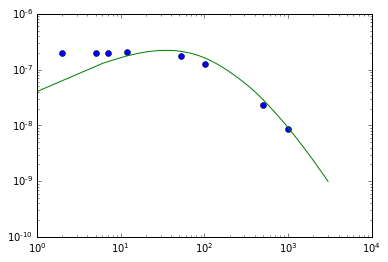

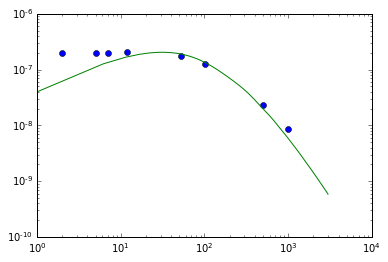

In [25]:
# plt.figure()
# plt.loglog(L_sample, clgg, marker ='o', ls='')
# plt.semilogx(LL,CLgg)

plt.figure()
plt.loglog(L_sample, clkk, marker ='o', ls='')
plt.semilogx(LL,CLkk)

plt.figure()
plt.loglog(L_sample, clkk, marker ='o', ls='')
plt.semilogx(LL,CLkk5)


# plt.figure()
# plt.loglog(L_sample, clkg, marker ='o', ls='')
# plt.semilogx(LL,CLkg)

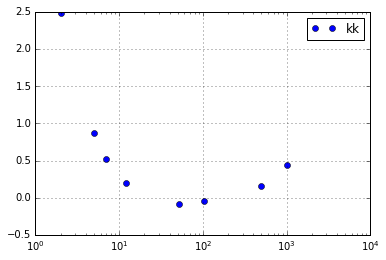

In [26]:
#plt.semilogx(L_sample, clgg/np.interp(L_sample,LL,CLgg)-1, marker ='o', ls='',label='gg')
plt.semilogx(L_sample, clkk/np.interp(L_sample,LL,CLkk5)-1, marker ='o', ls='',label='kk')
#plt.semilogx(L_sample, clkg/np.interp(L_sample,LL,CLkg)-1, marker ='o', ls='',label='kg')

plt.grid()
plt.legend()

In [27]:
from classy import Class

In [28]:
closmo1 = Class()
params = C.Planck2015[1]
params['output'] = 'tCl,lCl'
params['lensing'] = 'yes'
params['perturb_sampling_stepsize']= 0.01
params['tol_perturb_integration']=1.e-6
params['l_switch_limber']=40
closmo1.set(params)
closmo1.compute()
cl_len = closmo1.lensed_cl()

In [29]:
closmo2 = Class()
params2 = C.Planck2015[1]
params2['output'] = 'tCl,lCl'
params2['lensing'] = 'yes'
params2['perturb_sampling_stepsize']= 0.01
params2['tol_perturb_integration']=1.e-6
params2['l_switch_limber']=1.
closmo2.set(params2)
closmo2.compute()
cl_len2 = closmo2.lensed_cl()

In [30]:
plotpath = '/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/CrossPostBorn/results/plots/vanessa/'

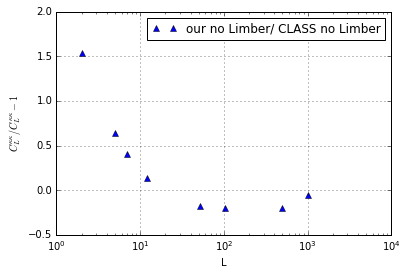

In [64]:
ll = cl_len['ell']
plt.figure()
#plt.semilogx(L_sample, clgg/np.interp(L_sample,LL,CLgg)-1, marker ='o', ls='',label='gg')
#plt.semilogx(L_sample, clkk/np.interp(L_sample,LL,CLkk5)-1, marker ='o', ls='',label='our no Limber/our Limber')
#plt.semilogx(L_sample, clkg/np.interp(L_sample,LL,CLkg)-1, marker ='o', ls='',label='kg')
plt.semilogx(L_sample, clkk/np.interp(L_sample,ll,1./4.*(ll*(ll+1.))**2*cl_len['pp'])-1, marker ='^', ls='',label='our no Limber/ CLASS no Limber')
#plt.semilogx(ll, cl_len['pp']/cl_len2['pp']-1,label='CLASS no Limber/ CLASS Limber')
#plt.semilogx(LL,CLkk/np.interp(LL,ll,1./4.*(ll)**4*cl_len2['pp'])-1,marker ='+')
plt.grid()
plt.ylabel('$C^{\kappa\kappa}_L/C^{\kappa\kappa}_L-1$')
plt.legend()
plt.xlabel('L')
plt.savefig(plotpath+'clkk_comparisons_finersampling_lesswidth.png')

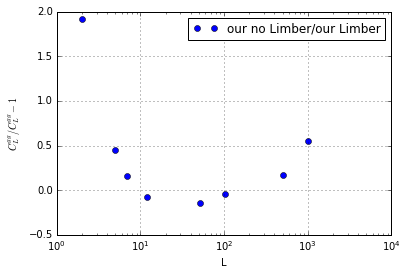

In [32]:
plt.figure()
plt.semilogx(L_sample, clgg/np.interp(L_sample,LL,CLgg)-1, marker ='o', ls='',label='our no Limber/our Limber')
#plt.semilogx(L_sample, clkk/np.interp(L_sample,LL,CLkk5)-1, marker ='o', ls='',label='our post Limber/our Limber')
#plt.semilogx(L_sample, clkg/np.interp(L_sample,LL,CLkg)-1, marker ='o', ls='',label='kg')
#plt.semilogx(L_sample, clkk/np.interp(L_sample,ll,1./4.*(ll)**4*cl_len['pp'])-1, marker ='^', ls='',label='our post Limber/ CLASS post Limber')
#plt.semilogx(ll, cl_len['pp']/cl_len2['pp']-1,label='CLASS post Limber/ CLASS Limber')
#plt.semilogx(LL,CLkk/np.interp(LL,ll,1./4.*(ll)**4*cl_len2['pp'])-1,marker ='+')
plt.grid()
plt.ylabel('$C^{gg}_L/C^{gg}_L-1$')
plt.legend()
plt.xlabel('L')
plt.savefig(plotpath+'clgg_comparisons.png')